# Ali NN

## Imports and Cuda Device

In [1]:
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, recall_score, roc_curve


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import math


from tqdm import tqdm
import matplotlib.pyplot as plt             #visualisation
import seaborn as sns   #visualisation
import plotly.express as px
from torch.utils.tensorboard import SummaryWriter


%matplotlib inline     
sns.set(color_codes=True)

import gc

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    raise Exception("Cry about it")

## KAN Class

In [3]:
class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.view(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output
        
        output = output.view(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

## Data Import

In [4]:
def add_cell_prefix(df, prefix):
    df.index = [prefix + i for i in df.index]
    return df

#Remove extra quotes from the filenames
def extract_cell_name_smartseq(x):
    y = x.split("_")
    return y[len(y)-2]

def get_cell_name_smartseq(file_name):
    return extract_cell_name_smartseq(file_name)

def convert_indexes_to_cell_names_smartseq(df):
    df.index = [get_cell_name_smartseq(x) for x in df.index]
    return df

def get_cell_hypo_or_norm_smartseq(df_meta, cell_name):
    return df_meta[df_meta["Cell name"]==cell_name]["Condition"].values[0]

def seperate_hypo_and_norm_smartseq(df, df_meta):
    df_hypo = df[df.index.map(lambda x: get_cell_hypo_or_norm_smartseq(df_meta, x)=="Hypo")]
    df_norm = df[df.index.map(lambda x: get_cell_hypo_or_norm_smartseq(df_meta, x)=="Norm" or get_cell_hypo_or_norm_smartseq(df_meta, x)=="Normo")]
    return df_hypo, df_norm

def process_df_smartseq(df, df_meta, prefix):
    df = convert_indexes_to_cell_names_smartseq(df)
    _, df_norm = seperate_hypo_and_norm_smartseq(df,df_meta)
    df = add_cell_prefix(df, prefix)
    df_norm = add_cell_prefix(df_norm, prefix)
    return df, df_norm.index

#Remove extra quotes from the filenames
def extract_cell_name_dropseq(x):
    y = x.split("_")
    return y[0]

def get_cell_name_dropseq(file_name):
    return extract_cell_name_dropseq(file_name)

def convert_indexes_to_cell_names_dropseq(df):
    df.index = [get_cell_name_dropseq(x) for x in df.index]
    return df

def get_cell_hypo_or_norm_dropseq(cell_name):
    return cell_name.split("_")[-1]

def seperate_hypo_and_norm_dropseq(df):
    df_hypo = df[df.index.map(lambda x: get_cell_hypo_or_norm_dropseq(x)=="Hypoxia")]
    df_norm = df[df.index.map(lambda x: get_cell_hypo_or_norm_dropseq(x)=="Normoxia")]
    return df_hypo, df_norm

def process_df_dropseq(df, prefix):
    _, df_norm = seperate_hypo_and_norm_dropseq(df)
    df = convert_indexes_to_cell_names_dropseq(df)
    df_norm = convert_indexes_to_cell_names_dropseq(df_norm)
    df = add_cell_prefix(df, prefix)
    df_norm = add_cell_prefix(df_norm, prefix)
    return df, df_norm.index

In [5]:
mcf7_smartS_meta = pd.read_csv("Data/SmartSeq/MCF7_SmartS_MetaData.tsv",delimiter="\t", index_col=0)
mcf7_smartS_filn = pd.read_csv("Data/SmartSeq/MCF7_SmartS_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T
hcc_smartS_meta = pd.read_csv("Data/SmartSeq/HCC1806_SmartS_MetaData.tsv",delimiter="\t",index_col=0)
hcc_smartS_filn = pd.read_csv("Data/SmartSeq/HCC1806_SmartS_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T
mcf7_dropS_filn = pd.read_csv("Data/DropSeq/MCF7_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T
hcc_dropS_filn = pd.read_csv("Data/DropSeq/HCC1806_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T

In [6]:
mcf7_smartS_filn, mcf7_smartS_filn_norm_idx = process_df_smartseq(mcf7_smartS_filn.copy(), mcf7_smartS_meta, "MCF7_")
hcc_smartS_filn, hcc_smartS_filn_norm_idx = process_df_smartseq(hcc_smartS_filn.copy(), hcc_smartS_meta, "HCC1806_")
mcf7_dropS_filn, mcf7_dropS_filn_norm_idx = process_df_dropseq(mcf7_dropS_filn, "MCF7_")
hcc_dropS_filn, hcc_dropS_filn_norm_idx = process_df_dropseq(hcc_dropS_filn, "HCC1806_")

In [7]:
mcf7_smartS_filn["mcf"] = np.ones_like(mcf7_smartS_filn.iloc[:, 0])
hcc_smartS_filn["mcf"] = np.zeros_like(hcc_smartS_filn.iloc[:, 0])
mcf7_dropS_filn["mcf"] = np.ones_like(mcf7_dropS_filn.iloc[:, 0])
hcc_dropS_filn["mcf"] = np.zeros_like(hcc_dropS_filn.iloc[:, 0])

mcf7_smartS_filn["smart"] = np.ones_like(mcf7_smartS_filn.iloc[:, 0])
hcc_smartS_filn["smart"] = np.ones_like(hcc_smartS_filn.iloc[:, 0])
mcf7_dropS_filn["smart"] = np.zeros_like(mcf7_dropS_filn.iloc[:, 0])
hcc_dropS_filn["smart"] = np.zeros_like(hcc_dropS_filn.iloc[:, 0])

dataset_list = [mcf7_smartS_filn, hcc_smartS_filn, mcf7_dropS_filn, hcc_dropS_filn]
dataset_names = ["MCF7_SmartSeq", "HCC1806_SmartSeq", "MCF7_DropSeq", "HCC1806_DropSeq"]
datasets = dict(zip(dataset_names, dataset_list))
norm_idx_datasets = dict(zip(dataset_names, [mcf7_smartS_filn_norm_idx, hcc_smartS_filn_norm_idx, mcf7_dropS_filn_norm_idx, hcc_dropS_filn_norm_idx]))

In [8]:
dropS_norm_idx = np.concatenate([mcf7_dropS_filn_norm_idx, hcc_dropS_filn_norm_idx])
smartS_norm_idx = np.concatenate([mcf7_smartS_filn_norm_idx, hcc_smartS_filn_norm_idx])

smartS_idx = np.concatenate([mcf7_smartS_filn.index, hcc_smartS_filn.index])

mcf7_idx = np.concatenate([mcf7_smartS_filn.index, mcf7_dropS_filn.index])

merged_norm_idx = np.concatenate([mcf7_smartS_filn_norm_idx, hcc_smartS_filn_norm_idx, mcf7_dropS_filn_norm_idx, hcc_dropS_filn_norm_idx])

## Train-Test Split

In [9]:
datasets_train = {}
datasets_test = {}

for name, dataset in datasets.items():
    train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, stratify=dataset.index.isin(norm_idx_datasets[name]))
    datasets_train[name] = train_dataset
    datasets_test[name] = test_dataset

merged_train_dataset = pd.concat(datasets_train.values()).fillna(0).astype(np.int32)
merged_test_dataset = pd.concat(datasets_test.values()).fillna(0).astype(np.int32)

## Free Up Memory #1

In [10]:
# Free up memory
del dataset_list, dataset_names, datasets, norm_idx_datasets, mcf7_smartS_filn, hcc_smartS_filn, mcf7_dropS_filn, hcc_dropS_filn, mcf7_smartS_filn_norm_idx, hcc_smartS_filn_norm_idx, mcf7_dropS_filn_norm_idx, hcc_dropS_filn_norm_idx

In [11]:
gc.collect()
torch.cuda.empty_cache()

## Define Neural Networks

In [12]:
class NNDataset(Dataset):
    def __init__(self, df, df_norm_idx):
        self.data = df.values  # Convert DataFrame to numpy array
        self.data_norm = df_norm_idx
        self.idx = df.index
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        dat = self.data[index, :]
        x = torch.tensor(dat, dtype=torch.float32, device=device)
        y = torch.tensor(0 if self.idx[index] in self.data_norm else 1,  dtype=torch.float32, device=device)
        return x, y

In [13]:
class NNBig(nn.Module):
    def __init__(self, in_size, H1, H2, H3):
        super(NNBig, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_size, H1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H1, H1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H1, H2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H2, H2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H2, H3),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H3, H3),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H3, 1))

    def forward(self, x):
        return self.layers(x)

In [14]:
class NNMedium(nn.Module):
    def __init__(self, in_size, H1, H2, H3):
        super(NNMedium, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_size, H1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H1, H2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H2, H3),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H3, 1))

    def forward(self, x):
        return self.layers(x)

In [15]:
class KANBig(nn.Module):
    def __init__(self, in_size, H1, H2, H3):
        super(KANBig, self).__init__()

        self.layers = nn.Sequential(
            KANLinear(in_size, H1),
            nn.Dropout(0.5),
            KANLinear(H1, H2),
            nn.Dropout(0.5),
            KANLinear(H2, H2),
            nn.Dropout(0.5),
            KANLinear(H2, H3),
            nn.Dropout(0.5),
            KANLinear(H3, H3),
            nn.Dropout(0.5),
            KANLinear(H3, H3),
            nn.Dropout(0.5),
            KANLinear(H3, 1))

    def forward(self, x):
        return self.layers(x)

In [16]:
class KANSmall(nn.Module):
    def __init__(self, in_size, H1, H2, H3):
        super(KANSmall, self).__init__()

        self.layers = nn.Sequential(
            KANLinear(in_size, H1),
            nn.Dropout(0.5),
            KANLinear(H1, H2),
            nn.Dropout(0.5),
            KANLinear(H2, H3),
            nn.Dropout(0.5),
            KANLinear(H3, 1))

    def forward(self, x):
        return self.layers(x)

In [17]:
class KANTiny(nn.Module):
    def __init__(self, in_size, H1):
        super(KANTiny, self).__init__()

        self.layers = nn.Sequential(
            KANLinear(in_size, H1),
            KANLinear(H1, 1))

    def forward(self, x):
        return self.layers(x)

## Model Measuring

In [18]:
@torch.no_grad
def measure_model_log(writer, model, data_loader, epoch):
    correct = 0
    total = 0
    y_pred = []
    y_pred_class = []
    y_true = []
    for inputs, labels in data_loader:
        outputs = model(inputs)
        predicted = nn.Sigmoid()(outputs[:, 0])
        total += labels.size(0)
        correct += (predicted.round() == labels).sum().item()
        y_pred_class.extend(predicted.cpu().round().numpy()) # Save Prediction
        y_pred.extend(predicted.cpu().numpy()) # Save Prediction
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
    if(np.isnan(y_pred_class).any()):
        print("Found nan, skipping evaluation")
        return 
    f1 = f1_score(y_true, y_pred_class)
    recall = recall_score(y_true, y_pred_class)
    accuracy = (correct / total)
    writer.add_scalar("F1 Score", f1, epoch)
    writer.add_scalar("Recall", recall, epoch)
    writer.add_scalar("Accuracy", accuracy, epoch)
    print("F1 Score:", f1)
    print("Recall:", recall)
    print(f'Accuracy on test: {accuracy * 100}%')

    # constant for classes
    classes = ('Normoxia', 'Hypoxia')

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred_class)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
    fig = plt.figure(figsize = (12,7))
    sns.heatmap(df_cm, annot=True)
    writer.add_figure("Confusion Matrix", fig, epoch)

    fig = plt.figure(figsize = (12,7))
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    writer.add_figure("ROC Curve", fig, epoch)

In [19]:
@torch.no_grad
def measure_model(model, data_loader):
    plt.close()
    correct = 0
    total = 0
    y_pred = []
    y_pred_class = []
    y_true = []
    for inputs, labels in data_loader:
        outputs = model(inputs)
        predicted = nn.Sigmoid()(outputs[:, 0])
        total += labels.size(0)
        correct += (predicted.round() == labels).sum().item()
        y_pred_class.extend(predicted.cpu().round().numpy()) # Save Prediction
        y_pred.extend(predicted.cpu().numpy()) # Save Prediction
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
    
    f1 = f1_score(y_true, y_pred_class)
    recall = recall_score(y_true, y_pred_class)
    accuracy = (correct / total)
    print("F1 Score:", f1)
    print("Recall:", recall)
    print(f'Accuracy on test: {accuracy * 100}%')

    # constant for classes
    classes = ('Normoxia', 'Hypoxia')

    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred_class)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sns.heatmap(df_cm, annot=True)
    plt.show()

## Initialize Datasets

In [20]:
data_loaders_train = {}
data_loaders_test = {}

for name in datasets_train.keys():
    data_loaders_train[name] = DataLoader(NNDataset(datasets_train[name], merged_norm_idx), batch_size=64, shuffle=True)
    data_loaders_test[name] = DataLoader(NNDataset(datasets_test[name], merged_norm_idx), batch_size=32)

merged_data_loader_train = DataLoader(NNDataset(merged_train_dataset, merged_norm_idx), batch_size=128, shuffle=True)
merged_data_loader_test = DataLoader(NNDataset(merged_test_dataset, merged_norm_idx), batch_size=64)

## Training Helpers

In [21]:
def train(model, train_config, writer=None):
    total_epochs = 0
    for config_type, config in train_config:
        if config_type == 0:
            iter_count, subtrain_config = config
            for _ in range(iter_count):
                total_epochs += train(model, subtrain_config, writer)
        elif config_type == 1:
            num_epochs, data_loader, test_loader, optimizer, criterion = config
            for epoch in tqdm(range(num_epochs)):
                running_loss = 0.0
                for inputs, labels in data_loader:
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs[:, 0], labels)
                    loss.backward()
                    nn.utils.clip_grad_norm_(model.parameters(), 0.1)
                    optimizer.step()
                    running_loss += loss.item()

                writer.add_scalar("Loss/train", running_loss/len(data_loader), epoch)
                print(f"Epoch {epoch+1}, Loss: {running_loss/len(data_loader)}", flush=True)
                measure_model_log(writer, model, test_loader, total_epochs)
                writer.flush()
                total_epochs += 1
        else:
            raise Exception("Invalid training config")
    return total_epochs
        

In [22]:
#lr_sgd = 1e-2
#lr_ada = 1e-2
#lr_admw = 1e-3
#wd_admw = 1e-4

# Define the optimizer
#sgd = optim.SGD(model.parameters(), lr=lr_sgd)
#adm = optim.Adam(model.parameters(), lr=lr_adm)
#ada = optim.Adagrad(model.parameters(), lr=lr_ada)
#admw = optim.AdamW(model.parameters(), lr=lr_admw, weight_decay=wd_admw)

## Training Neural Networks

### Training Over Individual Datasets

In [23]:
input_size = 3002

#### Traditional Neural Networks

In [42]:
models = {}
for name in data_loaders_test.keys():
    model = NNMedium(input_size, 4096, 1024, 512).to(device)
    writer = SummaryWriter()
    bcelogits = nn.BCEWithLogitsLoss()

    lr_ada = 1e-2
    ada = optim.Adagrad(model.parameters(), lr=lr_ada)
    train_config = [
        [1, [50 if "Smart" in name else 3, data_loaders_train[name], data_loaders_test[name], ada, bcelogits]],
    ]
    train(model, train_config, writer)
    models[name] = model

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1, Loss: 44553.30687522888


  2%|▏         | 1/50 [00:00<00:12,  3.87it/s]

F1 Score: 0.0
Recall: 0.0
Accuracy on test: 50.0%
Epoch 2, Loss: 2509.7960319519043


  4%|▍         | 2/50 [00:00<00:12,  3.86it/s]

F1 Score: 0.3333333333333333
Recall: 0.2
Accuracy on test: 60.0%
Epoch 3, Loss: 220.49323450028896


  6%|▌         | 3/50 [00:00<00:12,  3.83it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 4, Loss: 39.8558304659673


  8%|▊         | 4/50 [00:01<00:11,  3.86it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 5, Loss: 0.0


 10%|█         | 5/50 [00:01<00:11,  3.83it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 6, Loss: 6.041943556167706e-41


 12%|█▏        | 6/50 [00:01<00:11,  3.83it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 7, Loss: 0.0


 14%|█▍        | 7/50 [00:01<00:11,  3.86it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 8, Loss: 1.8245717637579655e-37


 16%|█▌        | 8/50 [00:02<00:10,  3.83it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 9, Loss: 6.62897566891624e-20


 18%|█▊        | 9/50 [00:02<00:10,  3.87it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 10, Loss: 2.0623753101000698e-29


 20%|██        | 10/50 [00:02<00:10,  3.92it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 11, Loss: 2.3921019578087866e-39


 22%|██▏       | 11/50 [00:02<00:09,  3.92it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 12, Loss: 0.0


 24%|██▍       | 12/50 [00:03<00:09,  3.93it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 13, Loss: 0.0


 26%|██▌       | 13/50 [00:03<00:09,  3.91it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 14, Loss: 0.0


 28%|██▊       | 14/50 [00:03<00:09,  3.90it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 15, Loss: 0.0


 30%|███       | 15/50 [00:03<00:08,  3.92it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 16, Loss: 0.0


 32%|███▏      | 16/50 [00:04<00:08,  3.94it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 17, Loss: 0.0


 34%|███▍      | 17/50 [00:04<00:08,  3.89it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 18, Loss: 0.0


 36%|███▌      | 18/50 [00:04<00:08,  3.91it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 19, Loss: 0.0


 38%|███▊      | 19/50 [00:04<00:07,  3.93it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 20, Loss: 1.4134324970780222e-16


 40%|████      | 20/50 [00:05<00:07,  3.94it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 21, Loss: 0.0


 42%|████▏     | 21/50 [00:05<00:07,  3.96it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 22, Loss: 0.0


 44%|████▍     | 22/50 [00:05<00:07,  3.98it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 23, Loss: 0.0
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


 46%|████▌     | 23/50 [00:06<00:10,  2.47it/s]

Epoch 24, Loss: 0.0


 48%|████▊     | 24/50 [00:06<00:09,  2.79it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 25, Loss: 2.8593495164547892e-42


 50%|█████     | 25/50 [00:06<00:08,  3.02it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 26, Loss: 0.0


 52%|█████▏    | 26/50 [00:07<00:07,  3.26it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 27, Loss: 0.0


 54%|█████▍    | 27/50 [00:07<00:06,  3.46it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 28, Loss: 0.0


 56%|█████▌    | 28/50 [00:07<00:06,  3.61it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 29, Loss: 0.0


 58%|█████▊    | 29/50 [00:07<00:05,  3.73it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 30, Loss: 0.0


 60%|██████    | 30/50 [00:08<00:05,  3.82it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 31, Loss: 0.0


 62%|██████▏   | 31/50 [00:08<00:04,  3.85it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 32, Loss: 0.0


 64%|██████▍   | 32/50 [00:08<00:04,  3.87it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 33, Loss: 0.0


 66%|██████▌   | 33/50 [00:08<00:04,  3.85it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 34, Loss: 0.0


 68%|██████▊   | 34/50 [00:09<00:04,  3.92it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 35, Loss: 0.0


 70%|███████   | 35/50 [00:09<00:03,  3.90it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 36, Loss: 1.185811358720899e-19


 72%|███████▏  | 36/50 [00:09<00:03,  3.90it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 37, Loss: 0.0


 74%|███████▍  | 37/50 [00:09<00:03,  3.93it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 38, Loss: 0.0


 76%|███████▌  | 38/50 [00:10<00:03,  3.94it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 39, Loss: 0.0


 78%|███████▊  | 39/50 [00:10<00:02,  3.95it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 40, Loss: 3.0635761559439524e-38


 80%|████████  | 40/50 [00:10<00:02,  3.96it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 41, Loss: 37.74399319291115


 82%|████████▏ | 41/50 [00:10<00:02,  3.89it/s]

F1 Score: 0.9795918367346939
Recall: 0.96
Accuracy on test: 98.0%
Epoch 42, Loss: 5.989957123994827


 84%|████████▍ | 42/50 [00:11<00:02,  3.88it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 43, Loss: 0.0


 86%|████████▌ | 43/50 [00:11<00:01,  3.84it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 44, Loss: 6.866362475191604e-44


 88%|████████▊ | 44/50 [00:11<00:01,  3.83it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 45, Loss: 0.0


 90%|█████████ | 45/50 [00:11<00:01,  3.88it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 46, Loss: 0.0


 92%|█████████▏| 46/50 [00:12<00:01,  3.91it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 47, Loss: 0.0
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


 94%|█████████▍| 47/50 [00:12<00:01,  2.91it/s]

Epoch 48, Loss: 0.0


 96%|█████████▌| 48/50 [00:13<00:00,  3.14it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 49, Loss: 0.0


 98%|█████████▊| 49/50 [00:13<00:00,  3.30it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 50, Loss: 1.6385739218439966e-33


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1, Loss: 123878.989180247


  2%|▏         | 1/50 [00:00<00:11,  4.28it/s]

F1 Score: 0.0
Recall: 0.0
Accuracy on test: 45.94594594594595%
Epoch 2, Loss: 8363.786295572916


  4%|▍         | 2/50 [00:00<00:11,  4.30it/s]

F1 Score: 0.7017543859649122
Recall: 1.0
Accuracy on test: 54.054054054054056%
Epoch 3, Loss: 2462.6246287027993


  6%|▌         | 3/50 [00:00<00:10,  4.32it/s]

F1 Score: 0.0
Recall: 0.0
Accuracy on test: 45.94594594594595%
Epoch 4, Loss: 333.75682703653973


  8%|▊         | 4/50 [00:00<00:10,  4.31it/s]

F1 Score: 0.7017543859649122
Recall: 1.0
Accuracy on test: 54.054054054054056%
Epoch 5, Loss: 149.08938344319662


 10%|█         | 5/50 [00:01<00:10,  4.33it/s]

F1 Score: 0.3225806451612903
Recall: 0.25
Accuracy on test: 43.24324324324324%
Epoch 6, Loss: 25.360286076863606


 12%|█▏        | 6/50 [00:01<00:10,  4.17it/s]

F1 Score: 0.0
Recall: 0.0
Accuracy on test: 45.94594594594595%
Epoch 7, Loss: 611.1656227111816


 14%|█▍        | 7/50 [00:01<00:10,  4.16it/s]

F1 Score: 0.7017543859649122
Recall: 1.0
Accuracy on test: 54.054054054054056%
Epoch 8, Loss: 68.8963254292806


 16%|█▌        | 8/50 [00:01<00:09,  4.21it/s]

F1 Score: 0.5161290322580645
Recall: 0.4
Accuracy on test: 59.45945945945946%
Epoch 9, Loss: 6.556369781494141


 18%|█▊        | 9/50 [00:02<00:09,  4.22it/s]

F1 Score: 0.7017543859649122
Recall: 1.0
Accuracy on test: 54.054054054054056%
Epoch 10, Loss: 9.16432778040568


 20%|██        | 10/50 [00:02<00:09,  4.21it/s]

F1 Score: 0.08333333333333333
Recall: 0.05
Accuracy on test: 40.54054054054054%
Epoch 11, Loss: 7.0627031326293945


 22%|██▏       | 11/50 [00:02<00:09,  4.21it/s]

F1 Score: 0.7017543859649122
Recall: 1.0
Accuracy on test: 54.054054054054056%
Epoch 12, Loss: 6.036436915397644


 24%|██▍       | 12/50 [00:02<00:08,  4.23it/s]

F1 Score: 0.6
Recall: 0.45
Accuracy on test: 67.56756756756756%
Epoch 13, Loss: 2.097317894299825


 26%|██▌       | 13/50 [00:03<00:08,  4.28it/s]

F1 Score: 0.7547169811320755
Recall: 1.0
Accuracy on test: 64.86486486486487%
Epoch 14, Loss: 0.9445938042675456
F1 Score: 0.7407407407407407
Recall: 1.0
Accuracy on test: 62.16216216216216%


 28%|██▊       | 14/50 [00:03<00:08,  4.12it/s]

Epoch 15, Loss: 8.73828891913096


 30%|███       | 15/50 [00:03<00:08,  4.14it/s]

F1 Score: 0.8837209302325582
Recall: 0.95
Accuracy on test: 86.48648648648648%
Epoch 16, Loss: 0.8750425477822622


 32%|███▏      | 16/50 [00:03<00:08,  4.23it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 17, Loss: 0.5906875741978487


 34%|███▍      | 17/50 [00:04<00:07,  4.24it/s]

F1 Score: 0.926829268292683
Recall: 0.95
Accuracy on test: 91.8918918918919%
Epoch 18, Loss: 1.1553761462370555


 36%|███▌      | 18/50 [00:04<00:07,  4.28it/s]

F1 Score: 0.975609756097561
Recall: 1.0
Accuracy on test: 97.2972972972973%
Epoch 19, Loss: 0.0232246388716586


 38%|███▊      | 19/50 [00:04<00:07,  4.29it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 20, Loss: 0.006991433576852539


 40%|████      | 20/50 [00:04<00:06,  4.29it/s]

F1 Score: 0.975609756097561
Recall: 1.0
Accuracy on test: 97.2972972972973%
Epoch 21, Loss: 0.07974245102514033


 42%|████▏     | 21/50 [00:04<00:06,  4.32it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 22, Loss: 0.5686700225704998


 44%|████▍     | 22/50 [00:05<00:06,  4.23it/s]

F1 Score: 0.9473684210526315
Recall: 0.9
Accuracy on test: 94.5945945945946%
Epoch 23, Loss: 0.0020990222692679173


 46%|████▌     | 23/50 [00:05<00:06,  4.26it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 24, Loss: 0.7064098492264796


 48%|████▊     | 24/50 [00:05<00:06,  4.24it/s]

F1 Score: 0.975609756097561
Recall: 1.0
Accuracy on test: 97.2972972972973%
Epoch 25, Loss: 0.00011314079623699531


 50%|█████     | 25/50 [00:05<00:05,  4.25it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 26, Loss: 5.802105638798988e-06


 52%|█████▏    | 26/50 [00:06<00:05,  4.29it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 27, Loss: 7.178369045475937e-08
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


 54%|█████▍    | 27/50 [00:06<00:07,  2.90it/s]

Epoch 28, Loss: 8.388743316580394e-09


 56%|█████▌    | 28/50 [00:06<00:06,  3.22it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 29, Loss: 1.4618445309767455e-07


 58%|█████▊    | 29/50 [00:07<00:05,  3.51it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 30, Loss: 4.912718797814478e-08


 60%|██████    | 30/50 [00:07<00:05,  3.64it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 31, Loss: 1.4103386073810555e-07


 62%|██████▏   | 31/50 [00:07<00:04,  3.82it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 32, Loss: 3.9712104347999766e-08


 64%|██████▍   | 32/50 [00:07<00:04,  3.98it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 33, Loss: 0.005041995231461025


 66%|██████▌   | 33/50 [00:08<00:04,  4.07it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 34, Loss: 4.9544068213283345e-11


 68%|██████▊   | 34/50 [00:08<00:03,  4.15it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 35, Loss: 1.0633205020568375e-09


 70%|███████   | 35/50 [00:08<00:03,  4.22it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 36, Loss: 9.650435145623488e-09


 72%|███████▏  | 36/50 [00:08<00:03,  4.25it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 37, Loss: 1.0762266345246143e-13


 74%|███████▍  | 37/50 [00:09<00:03,  4.29it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 38, Loss: 5.649294889584183e-15


 76%|███████▌  | 38/50 [00:09<00:02,  4.20it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 39, Loss: 2.7500158539188437e-08


 78%|███████▊  | 39/50 [00:09<00:02,  4.26it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 40, Loss: 6.173253574992946e-10


 80%|████████  | 40/50 [00:09<00:02,  4.28it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 41, Loss: 4.642043713131219e-06


 82%|████████▏ | 41/50 [00:09<00:02,  4.31it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 42, Loss: 1.5737239725438943e-15


 84%|████████▍ | 42/50 [00:10<00:01,  4.33it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 43, Loss: 6.057848199007305e-08


 86%|████████▌ | 43/50 [00:10<00:01,  4.33it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 44, Loss: 1.6963603447086872e-19


 88%|████████▊ | 44/50 [00:10<00:01,  4.32it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 45, Loss: 2.0432381454089585e-11


 90%|█████████ | 45/50 [00:10<00:01,  4.31it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 46, Loss: 3.4240445579913193e-14


 92%|█████████▏| 46/50 [00:11<00:00,  4.18it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 47, Loss: 4.069586871730724e-14


 94%|█████████▍| 47/50 [00:11<00:00,  4.22it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 48, Loss: 1.6235860914351474e-10


 96%|█████████▌| 48/50 [00:11<00:00,  4.24it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 49, Loss: 9.974616350883514e-15


 98%|█████████▊| 49/50 [00:11<00:00,  4.29it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 50, Loss: 1.126789560241296e-07


100%|██████████| 50/50 [00:12<00:00,  4.14it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1, Loss: 0.2686003151746438


 33%|███▎      | 1/3 [00:07<00:15,  7.64s/it]

F1 Score: 0.9721749006246451
Recall: 0.9661399548532731
Accuracy on test: 97.73462783171522%
Epoch 2, Loss: 0.06064278924552255


 67%|██████▋   | 2/3 [00:15<00:07,  7.66s/it]

F1 Score: 0.9730649277005954
Recall: 0.9683972911963883
Accuracy on test: 97.80397595931576%
Epoch 3, Loss: 0.04091564301462913


100%|██████████| 3/3 [00:22<00:00,  7.63s/it]

F1 Score: 0.9746764209341587
Recall: 0.9774266365688488
Accuracy on test: 97.91955617198336%



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1, Loss: 0.5318866722569193


 33%|███▎      | 1/3 [00:05<00:10,  5.09s/it]

F1 Score: 0.9596486412297557
Recall: 0.9853438556933484
Accuracy on test: 94.99489274770173%
Epoch 2, Loss: 0.08124516825900292


 67%|██████▋   | 2/3 [00:10<00:05,  5.08s/it]

F1 Score: 0.9698863636363636
Recall: 0.9622322435174746
Accuracy on test: 96.39087504256042%
Epoch 3, Loss: 0.04346329366584858


100%|██████████| 3/3 [00:15<00:00,  5.06s/it]

F1 Score: 0.9622804491793838
Recall: 0.9419391206313416
Accuracy on test: 95.53966632618318%


MCF7_SmartSeq
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


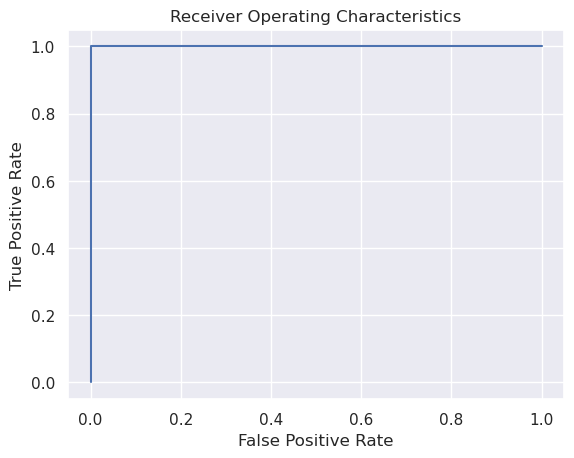

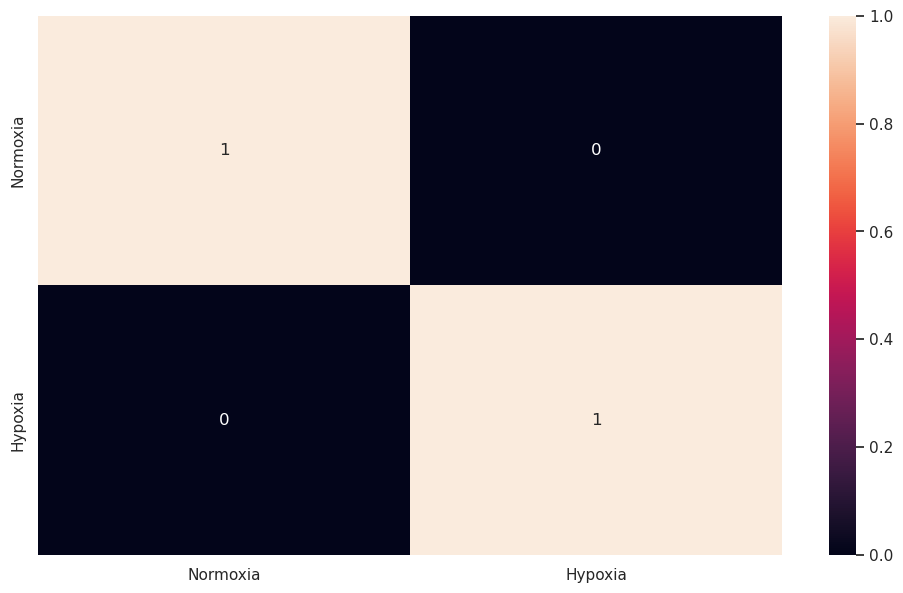

HCC1806_SmartSeq
F1 Score: 0.975609756097561
Recall: 1.0
Accuracy on test: 97.2972972972973%


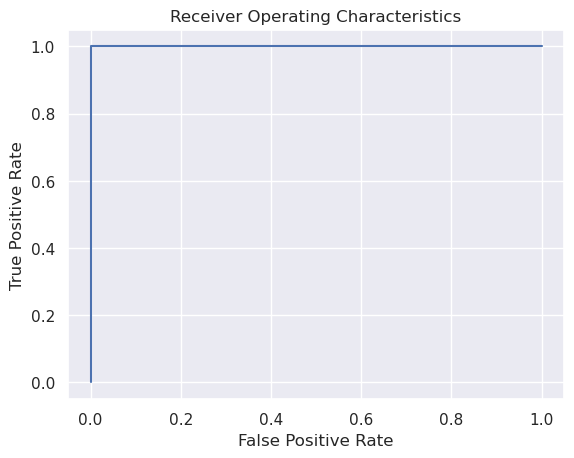

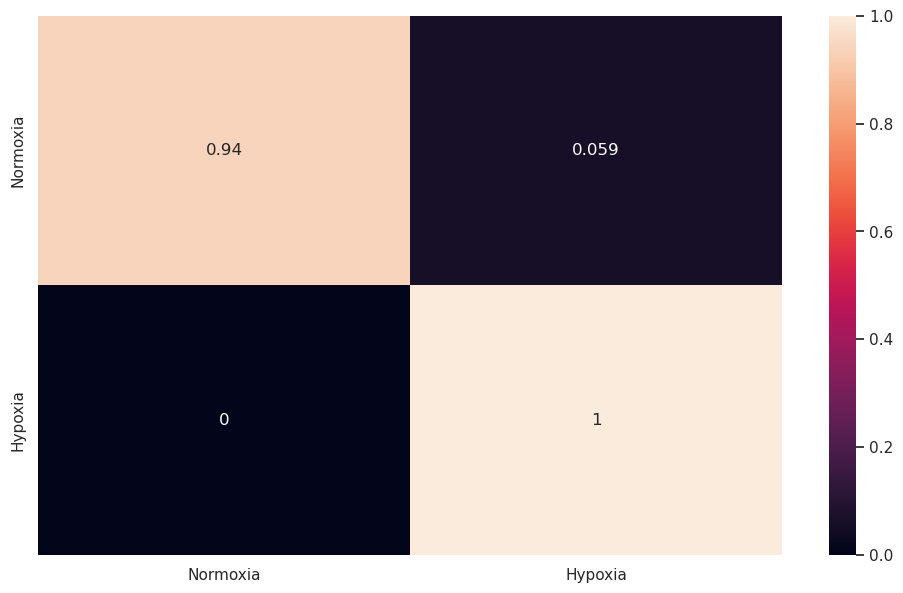

MCF7_DropSeq
F1 Score: 0.9743878412609063
Recall: 0.9768623024830699
Accuracy on test: 97.89644012944983%


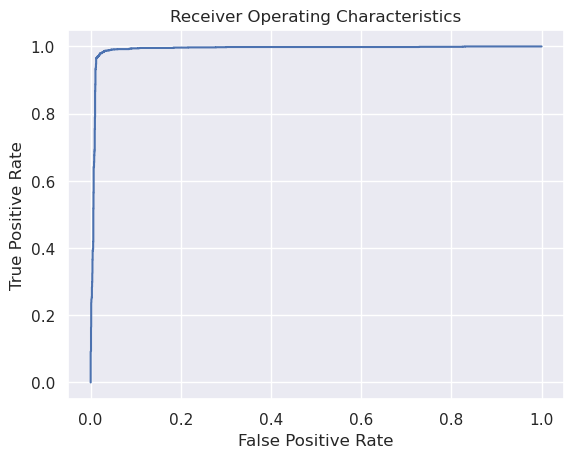

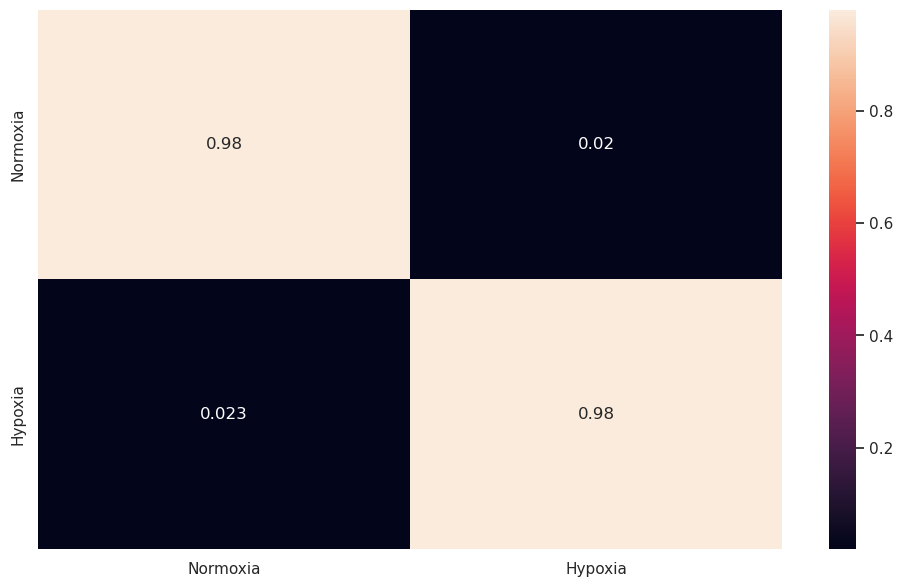

HCC1806_DropSeq
F1 Score: 0.9613163972286374
Recall: 0.9385569334836528
Accuracy on test: 95.43752128021791%


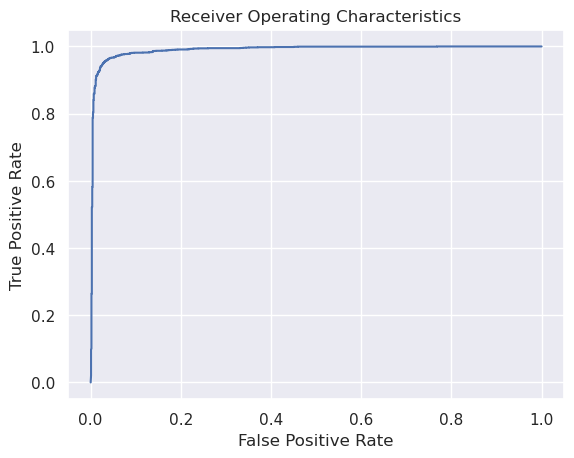

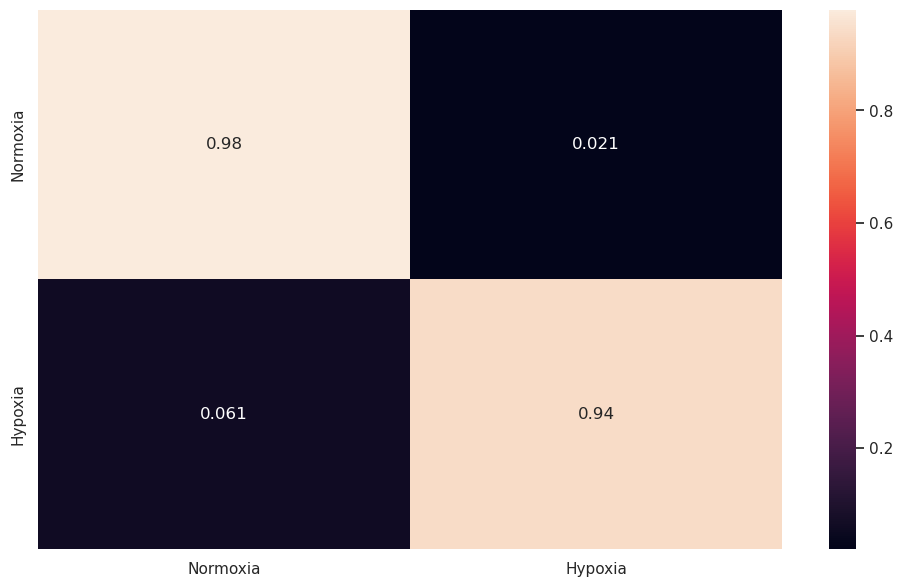

In [43]:
for name, model in models.items():
    print(name)
    measure_model(model, data_loaders_test[name])

In [45]:
for model in models.values():
    model.cpu()
    del model
del models
gc.collect()
torch.cuda.empty_cache()

NameError: name 'models' is not defined

#### KAN (Kolmogorov Arnold Networks)

In [47]:
models = {}
for name in data_loaders_test.keys():
    model = KANTiny(input_size, 64).to(device)
    writer = SummaryWriter()
    bcelogits = nn.BCEWithLogitsLoss()

    lr_ada = 1e-2
    ada = optim.Adagrad(model.parameters(), lr=lr_ada)
    train_config = [
        [1, [50 if "Smart" in name else 3, data_loaders_train[name], data_loaders_test[name], ada, bcelogits]],
    ]
    train(model, train_config, writer)
    models[name] = model

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1, Loss: 967.668360710144


  2%|▏         | 1/50 [00:00<00:12,  3.81it/s]

F1 Score: 0.0
Recall: 0.0
Accuracy on test: 50.0%
Epoch 2, Loss: 100.73484802246094


  4%|▍         | 2/50 [00:00<00:11,  4.04it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 3, Loss: 0.0


  6%|▌         | 3/50 [00:00<00:11,  4.12it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 4, Loss: 0.0
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


  8%|▊         | 4/50 [00:01<00:27,  1.69it/s]

Epoch 5, Loss: 0.0


 10%|█         | 5/50 [00:02<00:20,  2.17it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 6, Loss: 0.0


 12%|█▏        | 6/50 [00:02<00:16,  2.60it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 7, Loss: 0.0


 14%|█▍        | 7/50 [00:02<00:14,  2.98it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 8, Loss: 0.0


 16%|█▌        | 8/50 [00:02<00:12,  3.29it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 9, Loss: 0.0


 18%|█▊        | 9/50 [00:03<00:11,  3.53it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 10, Loss: 0.0


 20%|██        | 10/50 [00:03<00:10,  3.74it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 11, Loss: 0.0


 22%|██▏       | 11/50 [00:03<00:10,  3.76it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 12, Loss: 0.0


 24%|██▍       | 12/50 [00:03<00:09,  3.89it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 13, Loss: 0.0


 26%|██▌       | 13/50 [00:04<00:09,  3.85it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 14, Loss: 0.0


 28%|██▊       | 14/50 [00:04<00:09,  3.97it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 15, Loss: 0.0


 30%|███       | 15/50 [00:04<00:08,  4.03it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 16, Loss: 0.0


 32%|███▏      | 16/50 [00:04<00:08,  4.07it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 17, Loss: 0.0


 34%|███▍      | 17/50 [00:04<00:08,  4.12it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 18, Loss: 0.0


 36%|███▌      | 18/50 [00:05<00:07,  4.15it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 19, Loss: 0.0


 38%|███▊      | 19/50 [00:05<00:07,  4.14it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 20, Loss: 0.0


 40%|████      | 20/50 [00:05<00:07,  4.05it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 21, Loss: 0.0


 42%|████▏     | 21/50 [00:05<00:07,  4.13it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 22, Loss: 0.0


 44%|████▍     | 22/50 [00:06<00:06,  4.19it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 23, Loss: 0.0
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


 46%|████▌     | 23/50 [00:06<00:08,  3.25it/s]

Epoch 24, Loss: 0.0


 48%|████▊     | 24/50 [00:06<00:07,  3.49it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 25, Loss: 0.0


 50%|█████     | 25/50 [00:07<00:06,  3.66it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 26, Loss: 0.0


 52%|█████▏    | 26/50 [00:07<00:06,  3.83it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 27, Loss: 0.0


 54%|█████▍    | 27/50 [00:07<00:05,  3.96it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 28, Loss: 0.0


 56%|█████▌    | 28/50 [00:07<00:05,  3.98it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 29, Loss: 0.0


 58%|█████▊    | 29/50 [00:08<00:05,  4.03it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 30, Loss: 0.0


 60%|██████    | 30/50 [00:08<00:04,  4.09it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 31, Loss: 0.0


 62%|██████▏   | 31/50 [00:08<00:04,  4.15it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 32, Loss: 0.0


 64%|██████▍   | 32/50 [00:08<00:04,  4.06it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 33, Loss: 0.0


 66%|██████▌   | 33/50 [00:09<00:04,  4.11it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 34, Loss: 0.0


 68%|██████▊   | 34/50 [00:09<00:03,  4.16it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 35, Loss: 0.0


 70%|███████   | 35/50 [00:09<00:03,  4.19it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 36, Loss: 0.0


 72%|███████▏  | 36/50 [00:09<00:03,  4.19it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 37, Loss: 0.0


 74%|███████▍  | 37/50 [00:09<00:03,  4.22it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 38, Loss: 0.0


 76%|███████▌  | 38/50 [00:10<00:02,  4.22it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 39, Loss: 0.0


 78%|███████▊  | 39/50 [00:10<00:02,  4.20it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 40, Loss: 0.0


 80%|████████  | 40/50 [00:10<00:02,  4.23it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 41, Loss: 0.0


 82%|████████▏ | 41/50 [00:10<00:02,  4.12it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 42, Loss: 0.0


 84%|████████▍ | 42/50 [00:11<00:01,  4.15it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 43, Loss: 0.0


 86%|████████▌ | 43/50 [00:11<00:01,  4.17it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 44, Loss: 0.0


 88%|████████▊ | 44/50 [00:11<00:01,  4.18it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 45, Loss: 0.0


 90%|█████████ | 45/50 [00:11<00:01,  4.20it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 46, Loss: 0.0


 92%|█████████▏| 46/50 [00:12<00:00,  4.19it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 47, Loss: 0.0
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


 94%|█████████▍| 47/50 [00:12<00:00,  3.04it/s]

Epoch 48, Loss: 0.0


 96%|█████████▌| 48/50 [00:12<00:00,  3.32it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 49, Loss: 0.0


 98%|█████████▊| 49/50 [00:13<00:00,  3.47it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 50, Loss: 0.0


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1, Loss: 940.3256098429362


  2%|▏         | 1/50 [00:00<00:11,  4.29it/s]

F1 Score: 0.0
Recall: 0.0
Accuracy on test: 45.94594594594595%
Epoch 2, Loss: 378.36898549397785


  4%|▍         | 2/50 [00:00<00:10,  4.37it/s]

F1 Score: 0.7272727272727273
Recall: 1.0
Accuracy on test: 59.45945945945946%
Epoch 3, Loss: 178.56961059570312


  6%|▌         | 3/50 [00:00<00:10,  4.45it/s]

F1 Score: 0.75
Recall: 0.6
Accuracy on test: 78.37837837837837%
Epoch 4, Loss: 28.24608834584554


  8%|▊         | 4/50 [00:00<00:10,  4.44it/s]

F1 Score: 0.975609756097561
Recall: 1.0
Accuracy on test: 97.2972972972973%
Epoch 5, Loss: 20.52269999186198


 10%|█         | 5/50 [00:01<00:10,  4.46it/s]

F1 Score: 0.9523809523809523
Recall: 1.0
Accuracy on test: 94.5945945945946%
Epoch 6, Loss: 0.20061399539311728


 12%|█▏        | 6/50 [00:01<00:09,  4.50it/s]

F1 Score: 0.8571428571428571
Recall: 0.75
Accuracy on test: 86.48648648648648%
Epoch 7, Loss: 7.038148244222005


 14%|█▍        | 7/50 [00:01<00:09,  4.31it/s]

F1 Score: 0.9523809523809523
Recall: 1.0
Accuracy on test: 94.5945945945946%
Epoch 8, Loss: 7.413398106892903


 16%|█▌        | 8/50 [00:01<00:09,  4.39it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 9, Loss: 9.565552157660326


 18%|█▊        | 9/50 [00:02<00:09,  4.36it/s]

F1 Score: 0.926829268292683
Recall: 0.95
Accuracy on test: 91.8918918918919%
Epoch 10, Loss: 0.03268931061029434


 20%|██        | 10/50 [00:02<00:09,  4.41it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 11, Loss: 0.0


 22%|██▏       | 11/50 [00:02<00:08,  4.45it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 12, Loss: 0.0


 24%|██▍       | 12/50 [00:02<00:08,  4.47it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 13, Loss: 0.0


 26%|██▌       | 13/50 [00:02<00:08,  4.46it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 14, Loss: 0.0


 28%|██▊       | 14/50 [00:03<00:08,  4.47it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 15, Loss: 0.0


 30%|███       | 15/50 [00:03<00:07,  4.41it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 16, Loss: 0.0


 32%|███▏      | 16/50 [00:03<00:07,  4.47it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 17, Loss: 0.0


 34%|███▍      | 17/50 [00:03<00:07,  4.53it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 18, Loss: 0.0


 36%|███▌      | 18/50 [00:04<00:07,  4.55it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 19, Loss: 0.0


 38%|███▊      | 19/50 [00:04<00:06,  4.53it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 20, Loss: 0.0


 40%|████      | 20/50 [00:04<00:06,  4.52it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 21, Loss: 0.0


 42%|████▏     | 21/50 [00:04<00:06,  4.52it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 22, Loss: 0.0


 44%|████▍     | 22/50 [00:04<00:06,  4.53it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 23, Loss: 0.0


 46%|████▌     | 23/50 [00:05<00:05,  4.51it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 24, Loss: 0.0


 48%|████▊     | 24/50 [00:05<00:05,  4.38it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 25, Loss: 0.0


 50%|█████     | 25/50 [00:05<00:05,  4.44it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 26, Loss: 0.0


 52%|█████▏    | 26/50 [00:05<00:05,  4.49it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 27, Loss: 0.0
F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%


 54%|█████▍    | 27/50 [00:06<00:07,  2.94it/s]

Epoch 28, Loss: 0.0


 56%|█████▌    | 28/50 [00:06<00:06,  3.29it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 29, Loss: 0.0


 58%|█████▊    | 29/50 [00:06<00:05,  3.59it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 30, Loss: 0.0


 60%|██████    | 30/50 [00:07<00:05,  3.82it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 31, Loss: 0.0


 62%|██████▏   | 31/50 [00:07<00:04,  4.00it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 32, Loss: 0.0


 64%|██████▍   | 32/50 [00:07<00:04,  4.09it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 33, Loss: 0.0


 66%|██████▌   | 33/50 [00:07<00:04,  4.06it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 34, Loss: 0.0


 68%|██████▊   | 34/50 [00:08<00:03,  4.14it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 35, Loss: 0.0


 70%|███████   | 35/50 [00:08<00:03,  4.24it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 36, Loss: 0.0


 72%|███████▏  | 36/50 [00:08<00:03,  4.32it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 37, Loss: 0.0


 74%|███████▍  | 37/50 [00:08<00:02,  4.36it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 38, Loss: 0.0


 76%|███████▌  | 38/50 [00:08<00:02,  4.41it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 39, Loss: 0.0


 78%|███████▊  | 39/50 [00:09<00:02,  4.45it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 40, Loss: 0.0


 80%|████████  | 40/50 [00:09<00:02,  4.49it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 41, Loss: 0.0


 82%|████████▏ | 41/50 [00:09<00:02,  4.49it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 42, Loss: 0.0


 84%|████████▍ | 42/50 [00:09<00:01,  4.41it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 43, Loss: 0.0


 86%|████████▌ | 43/50 [00:10<00:01,  4.39it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 44, Loss: 0.0


 88%|████████▊ | 44/50 [00:10<00:01,  4.44it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 45, Loss: 0.0


 90%|█████████ | 45/50 [00:10<00:01,  4.45it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 46, Loss: 0.0


 92%|█████████▏| 46/50 [00:10<00:00,  4.46it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 47, Loss: 0.0


 94%|█████████▍| 47/50 [00:10<00:00,  4.50it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 48, Loss: 0.0


 96%|█████████▌| 48/50 [00:11<00:00,  4.53it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 49, Loss: 0.0


 98%|█████████▊| 49/50 [00:11<00:00,  4.53it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 50, Loss: 0.0


100%|██████████| 50/50 [00:11<00:00,  4.31it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1, Loss: 0.09788897042970321


 33%|███▎      | 1/3 [00:06<00:13,  6.72s/it]

F1 Score: 0.9774901519414744
Recall: 0.9802483069977427
Accuracy on test: 98.15071659731855%
Epoch 2, Loss: 0.05035903853900401


 67%|██████▋   | 2/3 [00:13<00:06,  6.68s/it]

F1 Score: 0.9780405405405406
Recall: 0.9802483069977427
Accuracy on test: 98.19694868238558%
Epoch 3, Loss: 0.038766059195846185


100%|██████████| 3/3 [00:20<00:00,  6.67s/it]

F1 Score: 0.9764271513774496
Recall: 0.9700902934537246
Accuracy on test: 98.08136846971799%



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1, Loss: 0.1697286427648657


 33%|███▎      | 1/3 [00:04<00:08,  4.40s/it]

F1 Score: 0.9720159908623643
Recall: 0.9594137542277339
Accuracy on test: 96.66326183180117%
Epoch 2, Loss: 0.07940738805083801


 67%|██████▋   | 2/3 [00:08<00:04,  4.38s/it]

F1 Score: 0.9723252496433666
Recall: 0.9605411499436303
Accuracy on test: 96.69731018045626%
Epoch 3, Loss: 0.05954990296310786


100%|██████████| 3/3 [00:13<00:00,  4.38s/it]

F1 Score: 0.9746764209341587
Recall: 0.9763246899661782
Accuracy on test: 96.93564862104188%


MCF7_SmartSeq
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


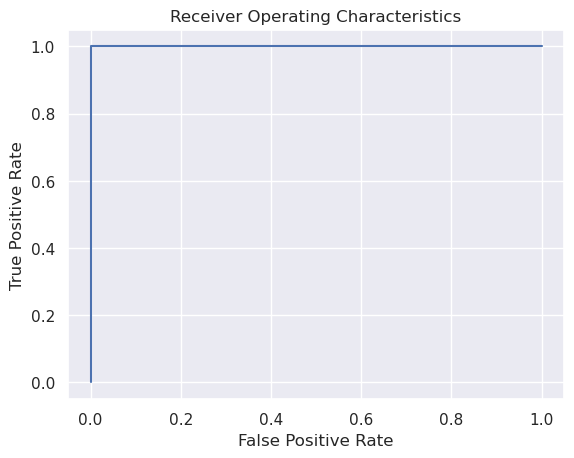

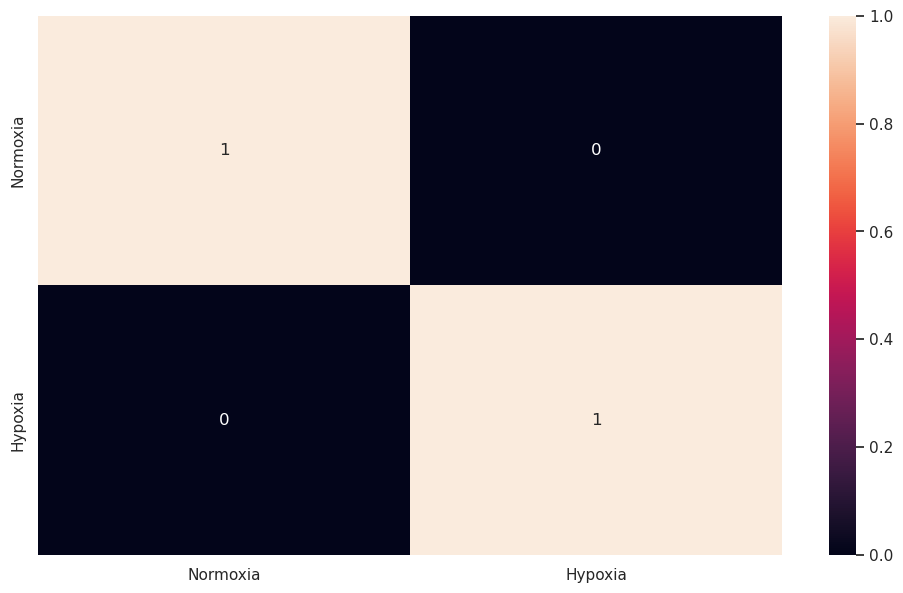

HCC1806_SmartSeq
F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%


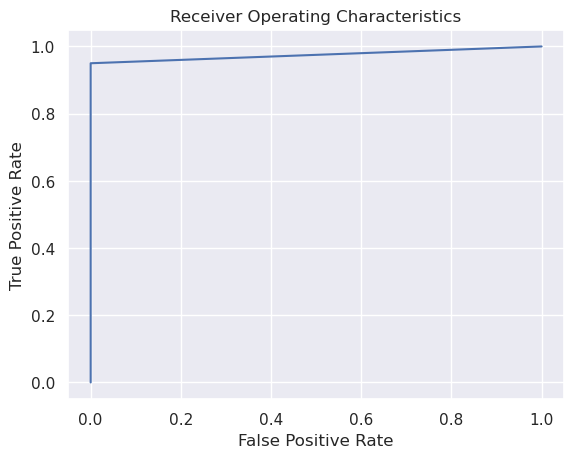

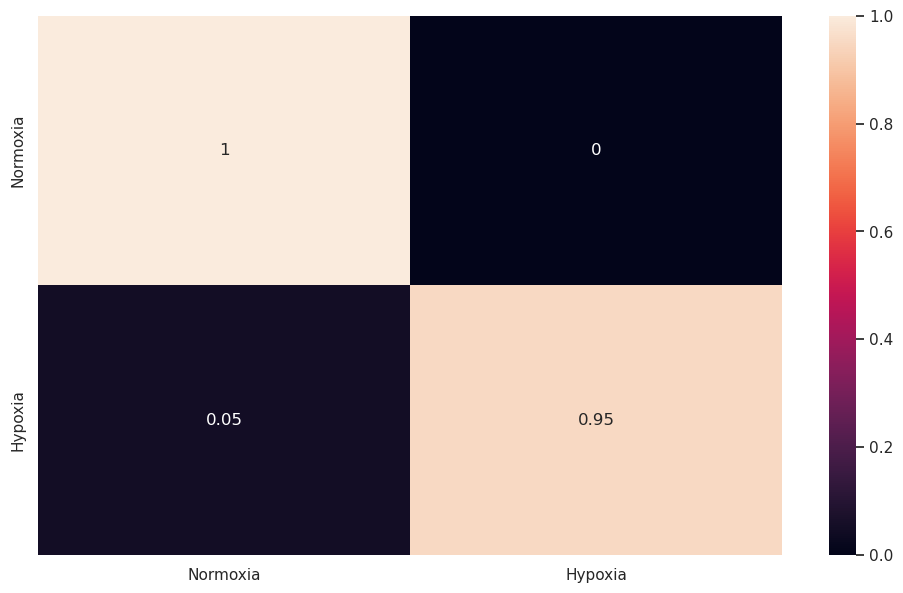

MCF7_DropSeq
F1 Score: 0.9764271513774496
Recall: 0.9700902934537246
Accuracy on test: 98.08136846971799%


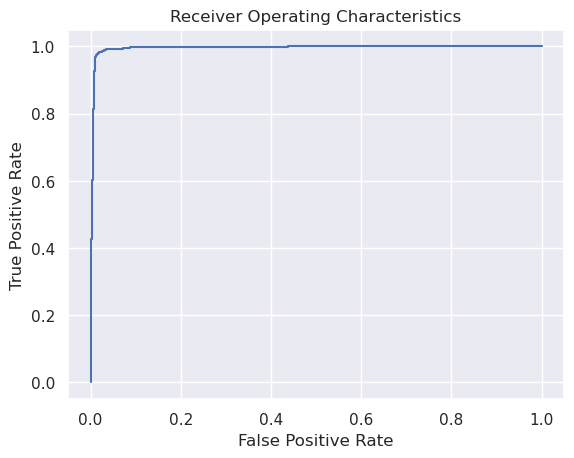

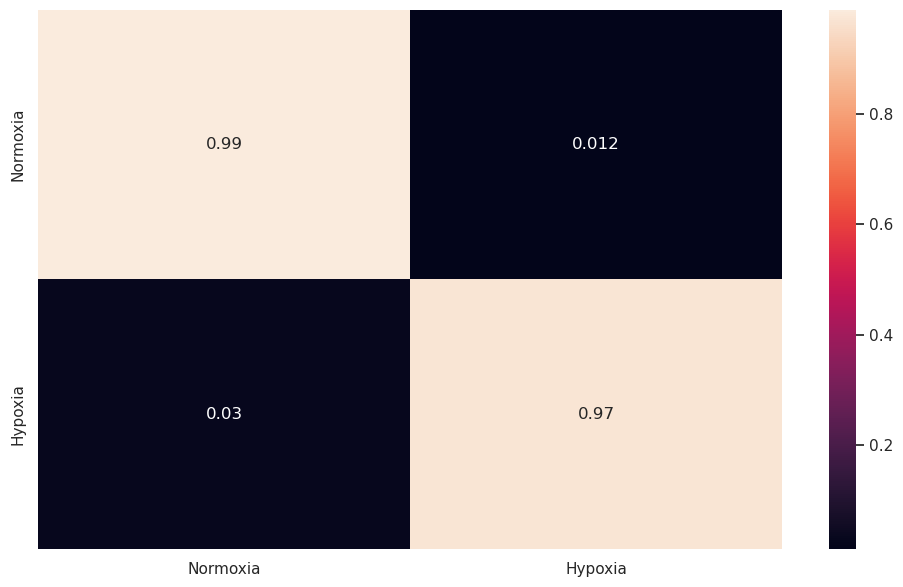

HCC1806_DropSeq
F1 Score: 0.9746764209341587
Recall: 0.9763246899661782
Accuracy on test: 96.93564862104188%


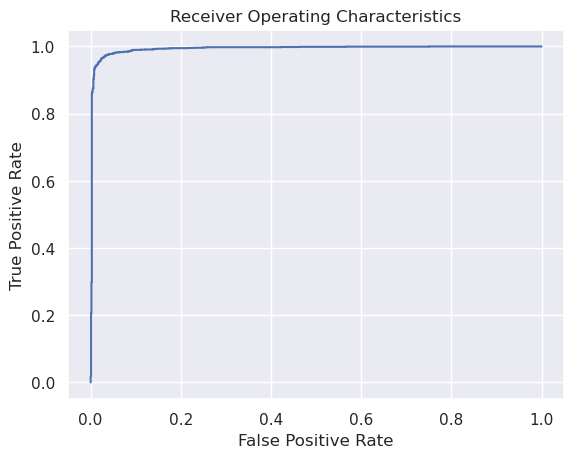

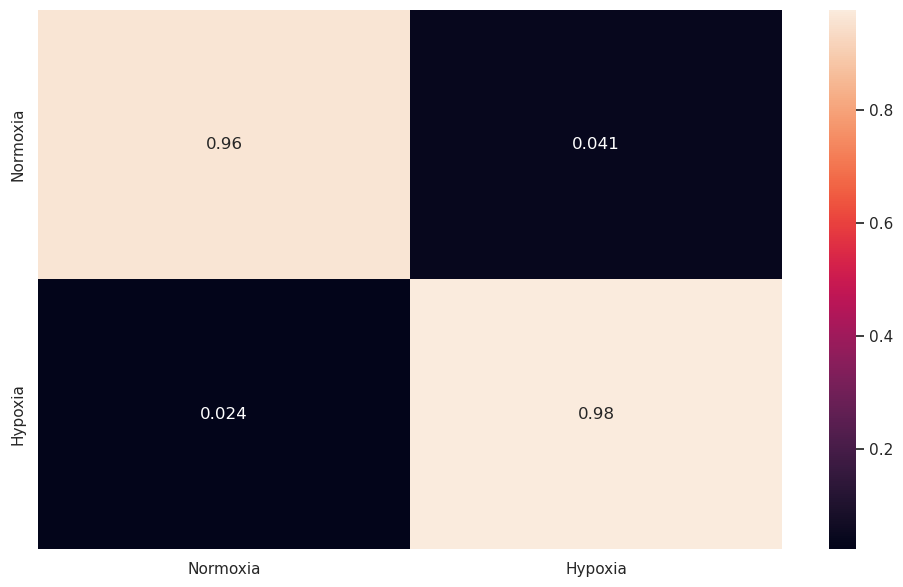

In [48]:
for name, model in models.items():
    print(name)
    measure_model(model, data_loaders_test[name])

In [49]:
for model in models.values():
    model.cpu()
    del model
del models
gc.collect()
torch.cuda.empty_cache()

### Training Over Merged Datasets

In [32]:
input_size = merged_train_dataset.shape[1]

#### Traditional Neural Network

In [81]:
model = NNBig(input_size, 4096, 2048, 1024).to(device)
writer = SummaryWriter()
bcelogits = nn.BCEWithLogitsLoss()

lr_ada = 1e-2
ada = optim.Adagrad(model.parameters(), lr=lr_ada)

In [82]:
train_config = [
    [1, [10, merged_data_loader_train, merged_data_loader_test, ada, bcelogits]]
]

In [85]:
train(model, train_config, writer)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, Loss: 0.08404361110447296


 10%|█         | 1/10 [00:18<02:43, 18.12s/it]

F1 Score: 0.9661461931739671
Recall: 0.9735449735449735
Accuracy on test: 96.66666666666667%
Epoch 2, Loss: 0.41837044451279165


 20%|██        | 2/10 [00:36<02:24, 18.12s/it]

F1 Score: 0.9660408614025401
Recall: 0.974380395433027
Accuracy on test: 96.6530612244898%
Epoch 3, Loss: 0.3625206127820681


 30%|███       | 3/10 [00:54<02:06, 18.05s/it]

F1 Score: 0.9661754385964912
Recall: 0.9585073795600111
Accuracy on test: 96.72108843537414%
Epoch 4, Loss: 0.012366191210335472


 40%|████      | 4/10 [01:12<01:48, 18.04s/it]

F1 Score: 0.9674650422262218
Recall: 0.9729880256196045
Accuracy on test: 96.80272108843538%
Epoch 5, Loss: 0.026330203750104208


 50%|█████     | 5/10 [01:30<01:30, 18.04s/it]

F1 Score: 0.9687238201619659
Recall: 0.9660261765524923
Accuracy on test: 96.95238095238096%
Epoch 6, Loss: 0.1501021486058011


 60%|██████    | 6/10 [01:48<01:12, 18.04s/it]

F1 Score: 0.9621878052183619
Recall: 0.960178223336118
Accuracy on test: 96.31292517006803%
Epoch 7, Loss: 0.02753622982295253


 70%|███████   | 7/10 [02:06<00:54, 18.07s/it]

F1 Score: 0.9639335023950408
Recall: 0.9526594263436369
Accuracy on test: 96.51700680272108%
Epoch 8, Loss: 0.004766177447925197


 80%|████████  | 8/10 [02:24<00:36, 18.08s/it]

F1 Score: 0.9671857619577308
Recall: 0.9685324422166527
Accuracy on test: 96.78911564625851%
Epoch 9, Loss: 0.003685005538511558


 90%|█████████ | 9/10 [02:42<00:18, 18.05s/it]

F1 Score: 0.963549025148347
Recall: 0.9495962127541074
Accuracy on test: 96.48979591836735%
Epoch 10, Loss: 0.003141266086652673


100%|██████████| 10/10 [03:00<00:00, 18.06s/it]

F1 Score: 0.965033000983008
Recall: 0.9568365357839042
Accuracy on test: 96.61224489795919%


10

F1 Score: 0.9633684210526315
Recall: 0.9557226399331662
Accuracy on test: 96.44897959183673%


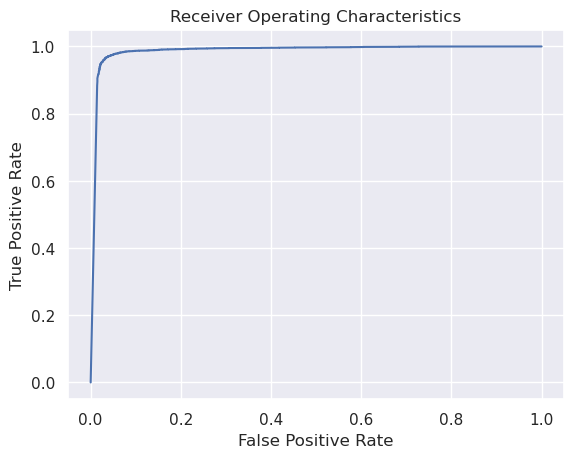

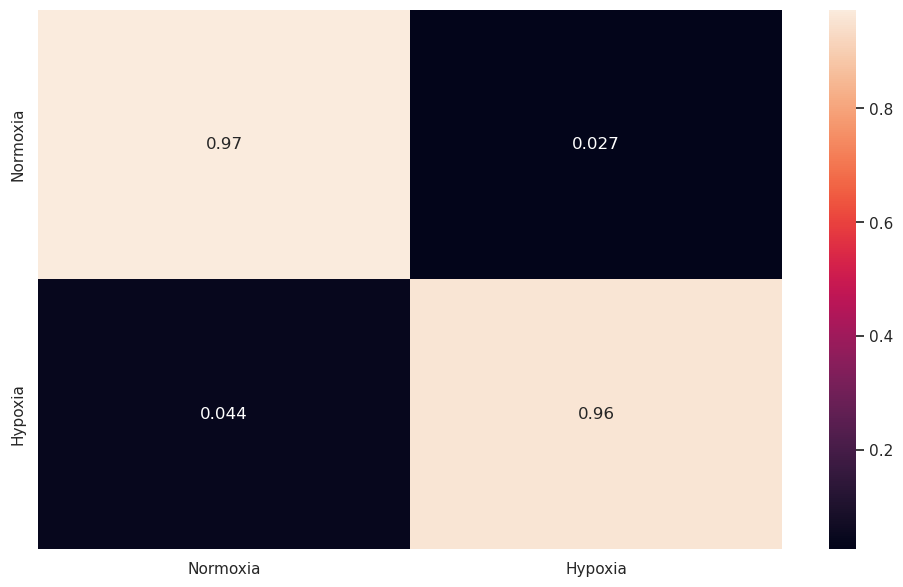

In [86]:
measure_model(model, merged_data_loader_test)

In [77]:
model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()

#### KAN (Kolmogorov Arnold Networks)

In [73]:
model = KANTiny(input_size, 512).to(device)
writer = SummaryWriter()
bcelogits = nn.BCEWithLogitsLoss()

lr_ada = 1e-2
ada = optim.Adagrad(model.parameters(), lr=lr_ada)

In [75]:
train_config = [
    [1, [10, merged_data_loader_train, merged_data_loader_test, ada, bcelogits]]
]

In [76]:
train(model, train_config, writer)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, Loss: 2.9354007379192373


 10%|█         | 1/10 [00:21<03:10, 21.11s/it]

F1 Score: 0.9640148903901834
Recall: 0.9735449735449735
Accuracy on test: 96.44897959183673%
Epoch 2, Loss: 0.0645545287138742


 20%|██        | 2/10 [00:42<02:49, 21.13s/it]

F1 Score: 0.9705516383243468
Recall: 0.9774436090225563
Accuracy on test: 97.10204081632654%
Epoch 3, Loss: 0.038521854674605574


 30%|███       | 3/10 [01:03<02:28, 21.15s/it]

F1 Score: 0.9698160887266601
Recall: 0.961849067112225
Accuracy on test: 97.07482993197279%
Epoch 4, Loss: 0.023463312500034986


 40%|████      | 4/10 [01:24<02:07, 21.17s/it]

F1 Score: 0.9712522787827794
Recall: 0.9643553327763854
Accuracy on test: 97.2108843537415%
Epoch 5, Loss: 0.013734112491669214


 50%|█████     | 5/10 [01:45<01:45, 21.14s/it]

F1 Score: 0.9729880256196045
Recall: 0.9729880256196045
Accuracy on test: 97.36054421768708%
Epoch 6, Loss: 0.00802033881292395


 60%|██████    | 6/10 [02:06<01:24, 21.13s/it]

F1 Score: 0.97265625
Recall: 0.9707602339181286
Accuracy on test: 97.33333333333334%
Epoch 7, Loss: 0.00499498817016897


 70%|███████   | 7/10 [02:28<01:03, 21.18s/it]

F1 Score: 0.9727095516569201
Recall: 0.9727095516569201
Accuracy on test: 97.33333333333334%
Epoch 8, Loss: 0.003217232596564471


 80%|████████  | 8/10 [02:49<00:42, 21.15s/it]

F1 Score: 0.9723849372384937
Recall: 0.9707602339181286
Accuracy on test: 97.3061224489796%
Epoch 9, Loss: 0.0022025807813802005


 90%|█████████ | 9/10 [03:10<00:21, 21.12s/it]

F1 Score: 0.97165991902834
Recall: 0.9690893901420217
Accuracy on test: 97.23809523809524%
Epoch 10, Loss: 0.0015431324953881457


100%|██████████| 10/10 [03:31<00:00, 21.13s/it]

F1 Score: 0.971044901384809
Recall: 0.9665831244778613
Accuracy on test: 97.18367346938776%


10

F1 Score: 0.9674276169265034
Recall: 0.9676970203285993
Accuracy on test: 96.81632653061224%


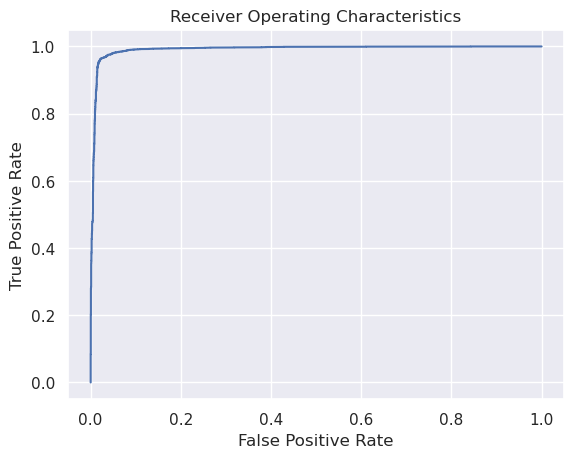

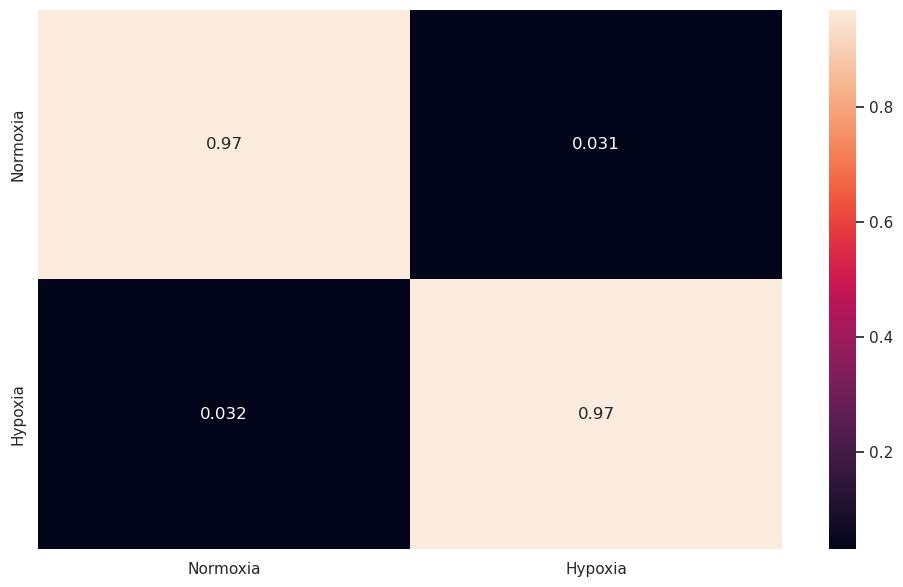

In [65]:
measure_model(model, merged_data_loader_test)

In [ ]:
model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()

## Autoencoders

### Define Models

In [23]:
class AutoEnc(nn.Module):
    def __init__(self, input_dim, hidden_dims, latent_dim):
        super(AutoEnc, self).__init__()
        
        # Store input dimension
        self.input_dim = input_dim
        
        # Encoder
        encoder_layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            encoder_layers.append(nn.Linear(prev_dim, h_dim))
            encoder_layers.append(nn.LeakyReLU())
            encoder_layers.append(nn.Dropout(0.5))
            prev_dim = h_dim
        
        self.encoder = nn.Sequential(*encoder_layers)
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        
        # Decoder
        decoder_layers = []
        prev_dim = latent_dim
        for h_dim in reversed(hidden_dims):
            decoder_layers.append(nn.Linear(prev_dim, h_dim))
            decoder_layers.append(nn.LeakyReLU())
            decoder_layers.append(nn.Dropout(0.5))
            prev_dim = h_dim
        
        self.decoder = nn.Sequential(*decoder_layers)
        self.final_layer = nn.Linear(hidden_dims[0], input_dim)
        
    def encode(self, x):
        return self.fc_mu(self.encoder(x))
    
    def decode(self, z):
        return self.final_layer(self.decoder(z))
    
    def forward(self, x):
        h = self.encode(x)
        return self.decode(h), h

In [24]:
class MAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(MAE, self).__init__()
        
        # Store input dimension
        self.input_dim = input_dim

        self.encoder = nn.Linear(input_dim, latent_dim)
        self.decoder = nn.Linear(latent_dim, input_dim)
        self.relu = nn.LeakyReLU()
        
    def encode(self, x):
        return self.relu(self.encoder(x))
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        h = self.encode(x)
        return self.decode(h), h, self.decoder.weight

### Define Parameters

In [25]:
input_size = merged_train_dataset.shape[1]
latent_size = 3

### Traditional Autoencoders

#### Initialize Model

In [133]:
model = AutoEnc(input_size, [1000, 200], latent_size).to(device)

lr_ada = 1e-2
ada = optim.Adagrad(model.parameters(), lr=lr_ada)

#### Loss Functions

In [134]:
mseloss = nn.MSELoss()

#### Train

In [137]:
train_config = [
    [5000, merged_data_loader_train, ada]
]

In [138]:
for segment in train_config:
    num_epochs = segment[0]
    data_loaderr = segment[1]
    optimizer = segment[2]
    epochs = tqdm(range(num_epochs))
    for epoch in epochs:
        running_losses = 0.0
        for inputs, labels in data_loaderr:
            # Zero the parameter gradients
            optimizer.zero_grad()

            recon_batch, mu = model(inputs)
            MSE = mseloss(recon_batch, inputs)

            MSE.backward()
            
            running_losses += MSE.item()

            optimizer.step()

        print(f"Epoch {epoch+1}, Loss: {running_losses/len(data_loaderr)}", flush=True)

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 1, Loss: 1981.8494346851726


  0%|          | 1/5000 [00:09<13:29:39,  9.72s/it]

Epoch 2, Loss: 1967.9770234791158


  0%|          | 2/5000 [00:19<13:31:03,  9.74s/it]

Epoch 3, Loss: 1872.648259664181


  0%|          | 3/5000 [00:29<13:32:00,  9.75s/it]

Epoch 4, Loss: 1732.1105275723921


  0%|          | 4/5000 [00:38<13:31:37,  9.75s/it]

Epoch 5, Loss: 1768.7559747288572


  0%|          | 5/5000 [00:48<13:31:10,  9.74s/it]

Epoch 6, Loss: 1651.2465387268235


  0%|          | 6/5000 [00:58<13:32:00,  9.76s/it]

Epoch 7, Loss: 1727.9141524581319


  0%|          | 7/5000 [01:08<13:32:32,  9.76s/it]

Epoch 8, Loss: 1607.62944111722


  0%|          | 8/5000 [01:18<13:32:15,  9.76s/it]

Epoch 9, Loss: 1611.3754780564782


  0%|          | 9/5000 [01:27<13:28:32,  9.72s/it]

Epoch 10, Loss: 1555.1664778392762


  0%|          | 10/5000 [01:37<13:29:00,  9.73s/it]

Epoch 11, Loss: 1568.4122412733896


  0%|          | 11/5000 [01:47<13:28:56,  9.73s/it]

Epoch 12, Loss: 1523.5032642342799


  0%|          | 12/5000 [01:56<13:28:46,  9.73s/it]

Epoch 13, Loss: 1463.6198611778734


  0%|          | 13/5000 [02:06<13:29:28,  9.74s/it]

Epoch 14, Loss: 1467.4655656926982


  0%|          | 14/5000 [02:16<13:28:29,  9.73s/it]

Epoch 15, Loss: 1487.4757423746198


  0%|          | 15/5000 [02:26<13:29:45,  9.75s/it]

Epoch 16, Loss: 1457.121677748859


  0%|          | 16/5000 [02:35<13:30:17,  9.75s/it]

Epoch 17, Loss: 1518.8120231147532


  0%|          | 17/5000 [02:45<13:30:38,  9.76s/it]

Epoch 18, Loss: 1468.3177259963006


  0%|          | 18/5000 [02:55<13:29:44,  9.75s/it]

Epoch 19, Loss: 1366.8942288670528


  0%|          | 19/5000 [03:05<13:29:31,  9.75s/it]

Epoch 20, Loss: 1396.859173033516


  0%|          | 20/5000 [03:14<13:29:57,  9.76s/it]

Epoch 21, Loss: 1405.692427322058


  0%|          | 21/5000 [03:24<13:29:50,  9.76s/it]

Epoch 22, Loss: 1412.649184556597


  0%|          | 22/5000 [03:34<13:30:23,  9.77s/it]

Epoch 23, Loss: 1401.475543921635


  0%|          | 23/5000 [03:44<13:29:54,  9.76s/it]

Epoch 24, Loss: 1411.2423176130198


  0%|          | 24/5000 [03:54<13:30:30,  9.77s/it]

Epoch 25, Loss: 1404.178789209947


  0%|          | 25/5000 [04:03<13:30:06,  9.77s/it]

Epoch 26, Loss: 1370.5412058363304


  1%|          | 26/5000 [04:13<13:30:17,  9.77s/it]

Epoch 27, Loss: 1394.6215634145976


  1%|          | 27/5000 [04:23<13:29:43,  9.77s/it]

Epoch 28, Loss: 1336.9587891387712


  1%|          | 28/5000 [04:33<13:30:23,  9.78s/it]

Epoch 29, Loss: 1360.739119419083


  1%|          | 29/5000 [04:42<13:30:28,  9.78s/it]

Epoch 30, Loss: 1374.7900318839465


  1%|          | 30/5000 [04:52<13:30:22,  9.78s/it]

Epoch 31, Loss: 1350.2249874726585


  1%|          | 31/5000 [05:02<13:29:40,  9.78s/it]

Epoch 32, Loss: 1284.8579039201302


  1%|          | 32/5000 [05:12<13:29:06,  9.77s/it]

Epoch 33, Loss: 1327.472889409036


  1%|          | 33/5000 [05:22<13:29:52,  9.78s/it]

Epoch 34, Loss: 1361.562912328525


  1%|          | 34/5000 [05:31<13:29:56,  9.79s/it]

Epoch 35, Loss: 1337.4294772227497


  1%|          | 35/5000 [05:41<13:29:19,  9.78s/it]

Epoch 36, Loss: 1321.2491773834533


  1%|          | 36/5000 [05:51<13:28:43,  9.78s/it]

Epoch 37, Loss: 1319.5780061519501


  1%|          | 37/5000 [06:01<13:31:44,  9.81s/it]

Epoch 38, Loss: 1314.9483189191021


  1%|          | 38/5000 [06:11<13:32:18,  9.82s/it]

Epoch 39, Loss: 1296.9197122233718


  1%|          | 39/5000 [06:20<13:31:50,  9.82s/it]

Epoch 40, Loss: 1311.928313677434


  1%|          | 40/5000 [06:30<13:33:38,  9.84s/it]

Epoch 41, Loss: 1292.1186067111628


  1%|          | 41/5000 [06:40<13:29:55,  9.80s/it]

Epoch 42, Loss: 1296.0401193296132


  1%|          | 42/5000 [06:50<13:27:08,  9.77s/it]

Epoch 43, Loss: 1260.2948172547895


  1%|          | 43/5000 [06:59<13:26:15,  9.76s/it]

Epoch 44, Loss: 1281.5523476278652


  1%|          | 44/5000 [07:09<13:24:51,  9.74s/it]

Epoch 45, Loss: 1290.0359287229246


  1%|          | 45/5000 [07:19<13:23:04,  9.72s/it]

Epoch 46, Loss: 1364.7663682318253


  1%|          | 46/5000 [07:29<13:21:47,  9.71s/it]

Epoch 47, Loss: 1283.8691745432175


  1%|          | 47/5000 [07:38<13:19:40,  9.69s/it]

Epoch 48, Loss: 1274.0084793106855


  1%|          | 48/5000 [07:48<13:20:17,  9.70s/it]

Epoch 49, Loss: 1271.172337927815


  1%|          | 49/5000 [07:58<13:19:12,  9.69s/it]

Epoch 50, Loss: 1315.653431748275


  1%|          | 50/5000 [08:07<13:19:22,  9.69s/it]

Epoch 51, Loss: 1334.7731320783496


  1%|          | 51/5000 [08:17<13:19:35,  9.69s/it]

Epoch 52, Loss: 1311.3751602627824


  1%|          | 52/5000 [08:27<13:18:33,  9.68s/it]

Epoch 53, Loss: 1276.1435148018534


  1%|          | 53/5000 [08:36<13:18:26,  9.68s/it]

Epoch 54, Loss: 1267.371714362907


  1%|          | 54/5000 [08:46<13:17:06,  9.67s/it]

Epoch 55, Loss: 1273.845468513862


  1%|          | 55/5000 [08:56<13:16:47,  9.67s/it]

Epoch 56, Loss: 1244.0113714179429


  1%|          | 56/5000 [09:05<13:17:49,  9.68s/it]

Epoch 57, Loss: 1244.6454089257056


  1%|          | 57/5000 [09:15<13:16:22,  9.67s/it]

Epoch 58, Loss: 1266.1662728082388


  1%|          | 58/5000 [09:25<13:15:13,  9.65s/it]

Epoch 59, Loss: 1217.8215910909294


  1%|          | 59/5000 [09:34<13:14:06,  9.64s/it]

Epoch 60, Loss: 1299.4894535752094


  1%|          | 60/5000 [09:44<13:15:37,  9.66s/it]

Epoch 61, Loss: 1206.1316396926247


  1%|          | 61/5000 [09:54<13:16:10,  9.67s/it]

Epoch 62, Loss: 1221.112135796087


  1%|          | 62/5000 [10:03<13:15:16,  9.66s/it]

Epoch 63, Loss: 1252.7152031534067


  1%|▏         | 63/5000 [10:13<13:14:44,  9.66s/it]

Epoch 64, Loss: 1316.6298351057521


  1%|▏         | 64/5000 [10:23<13:15:16,  9.67s/it]

Epoch 65, Loss: 1250.058763655502


  1%|▏         | 65/5000 [10:32<13:15:56,  9.68s/it]

Epoch 66, Loss: 1253.8093919936082


  1%|▏         | 66/5000 [10:42<13:15:11,  9.67s/it]

Epoch 67, Loss: 1200.6376449998954


  1%|▏         | 67/5000 [10:52<13:15:00,  9.67s/it]

Epoch 68, Loss: 1229.0736337663686


  1%|▏         | 68/5000 [11:01<13:13:32,  9.65s/it]

Epoch 69, Loss: 1219.09901168923


  1%|▏         | 69/5000 [11:11<13:12:30,  9.64s/it]

Epoch 70, Loss: 1275.0731775766644


  1%|▏         | 70/5000 [11:20<13:12:14,  9.64s/it]

Epoch 71, Loss: 1257.7953371216097


  1%|▏         | 71/5000 [11:30<13:12:30,  9.65s/it]

Epoch 72, Loss: 1251.6719432285136


  1%|▏         | 72/5000 [11:40<13:11:30,  9.64s/it]

Epoch 73, Loss: 1237.099779758732


  1%|▏         | 73/5000 [11:49<13:12:10,  9.65s/it]

Epoch 74, Loss: 1259.4550671040527


  1%|▏         | 74/5000 [11:59<13:12:08,  9.65s/it]

Epoch 75, Loss: 1219.1970104974735


  2%|▏         | 75/5000 [12:09<13:12:43,  9.66s/it]

Epoch 76, Loss: 1223.7312615797896


  2%|▏         | 76/5000 [12:18<13:14:21,  9.68s/it]

Epoch 77, Loss: 1193.437258575306


  2%|▏         | 77/5000 [12:28<13:15:24,  9.69s/it]

Epoch 78, Loss: 1240.8806641647998


  2%|▏         | 78/5000 [12:38<13:15:42,  9.70s/it]

Epoch 79, Loss: 1222.5666809462011


  2%|▏         | 79/5000 [12:48<13:16:09,  9.71s/it]

Epoch 80, Loss: 1193.8152354298888


  2%|▏         | 80/5000 [12:57<13:16:18,  9.71s/it]

Epoch 81, Loss: 1242.8157815327786


  2%|▏         | 81/5000 [13:07<13:15:41,  9.71s/it]

Epoch 82, Loss: 1182.0711855479233


  2%|▏         | 82/5000 [13:17<13:14:34,  9.69s/it]

Epoch 83, Loss: 1238.2314780366648


  2%|▏         | 83/5000 [13:26<13:13:32,  9.68s/it]

Epoch 84, Loss: 1164.658311699266


  2%|▏         | 84/5000 [13:36<13:13:37,  9.69s/it]

Epoch 85, Loss: 1211.779873504441


  2%|▏         | 85/5000 [13:46<13:12:11,  9.67s/it]

Epoch 86, Loss: 1188.3465755025654


  2%|▏         | 86/5000 [13:55<13:12:09,  9.67s/it]

Epoch 87, Loss: 1143.3190587161675


  2%|▏         | 87/5000 [14:05<13:11:35,  9.67s/it]

Epoch 88, Loss: 1178.0223461753972


  2%|▏         | 88/5000 [14:15<13:12:44,  9.68s/it]

Epoch 89, Loss: 1198.119007801297


  2%|▏         | 89/5000 [14:24<13:14:02,  9.70s/it]

Epoch 90, Loss: 1189.946345339829


  2%|▏         | 90/5000 [14:34<13:13:44,  9.70s/it]

Epoch 91, Loss: 1161.486993595488


  2%|▏         | 91/5000 [14:44<13:14:16,  9.71s/it]

Epoch 92, Loss: 1199.1968989025315


  2%|▏         | 92/5000 [14:54<13:14:22,  9.71s/it]

Epoch 93, Loss: 1196.979089447532


  2%|▏         | 93/5000 [15:03<13:13:52,  9.71s/it]

Epoch 94, Loss: 1222.3947873434781


  2%|▏         | 94/5000 [15:13<13:13:49,  9.71s/it]

Epoch 95, Loss: 1191.8427257134376


  2%|▏         | 95/5000 [15:23<13:13:11,  9.70s/it]

Epoch 96, Loss: 1178.8115797684407


  2%|▏         | 96/5000 [15:32<13:11:53,  9.69s/it]

Epoch 97, Loss: 1192.698486627217


  2%|▏         | 97/5000 [15:42<13:11:51,  9.69s/it]

Epoch 98, Loss: 1198.1538049841056


  2%|▏         | 98/5000 [15:52<13:10:45,  9.68s/it]

Epoch 99, Loss: 1207.1482597588035


  2%|▏         | 99/5000 [16:01<13:10:32,  9.68s/it]

Epoch 100, Loss: 1170.927260956071


  2%|▏         | 100/5000 [16:11<13:09:28,  9.67s/it]

Epoch 101, Loss: 1215.720002399887


  2%|▏         | 101/5000 [16:21<13:07:47,  9.65s/it]

Epoch 102, Loss: 1127.0705917015835


  2%|▏         | 102/5000 [16:30<13:07:40,  9.65s/it]

Epoch 103, Loss: 1179.3208644593701


  2%|▏         | 103/5000 [16:40<13:08:00,  9.66s/it]

Epoch 104, Loss: 1153.780618442514


  2%|▏         | 104/5000 [16:50<13:08:35,  9.66s/it]

Epoch 105, Loss: 1195.1654368302907


  2%|▏         | 105/5000 [16:59<13:07:59,  9.66s/it]

Epoch 106, Loss: 1162.5101072110722


  2%|▏         | 106/5000 [17:09<13:08:54,  9.67s/it]

Epoch 107, Loss: 1149.6030963201724


  2%|▏         | 107/5000 [17:19<13:09:59,  9.69s/it]

Epoch 108, Loss: 1144.7668601326482


  2%|▏         | 108/5000 [17:28<13:09:43,  9.69s/it]

Epoch 109, Loss: 1136.3119494923592


  2%|▏         | 109/5000 [17:38<13:10:04,  9.69s/it]

Epoch 110, Loss: 1162.6637078020235


  2%|▏         | 110/5000 [17:48<13:08:46,  9.68s/it]

Epoch 111, Loss: 1161.4814403175822


  2%|▏         | 111/5000 [17:57<13:07:05,  9.66s/it]

Epoch 112, Loss: 1132.3981597683028


  2%|▏         | 112/5000 [18:07<13:06:03,  9.65s/it]

Epoch 113, Loss: 1134.857014647126


  2%|▏         | 113/5000 [18:17<13:05:13,  9.64s/it]

Epoch 114, Loss: 1135.488278254656


  2%|▏         | 114/5000 [18:26<13:04:44,  9.64s/it]

Epoch 115, Loss: 1105.4326736318676


  2%|▏         | 115/5000 [18:36<13:04:37,  9.64s/it]

Epoch 116, Loss: 1123.7761777338935


  2%|▏         | 116/5000 [18:46<13:05:25,  9.65s/it]

Epoch 117, Loss: 1128.178144017947


  2%|▏         | 117/5000 [18:55<13:05:41,  9.65s/it]

Epoch 118, Loss: 1145.2548990334183


  2%|▏         | 118/5000 [19:05<13:04:49,  9.65s/it]

Epoch 119, Loss: 1110.3164323636856


  2%|▏         | 119/5000 [19:15<13:06:40,  9.67s/it]

Epoch 120, Loss: 1086.1005942691766


  2%|▏         | 120/5000 [19:24<13:06:44,  9.67s/it]

Epoch 121, Loss: 1115.7599981269111


  2%|▏         | 121/5000 [19:34<13:08:01,  9.69s/it]

Epoch 122, Loss: 1110.6097460072


  2%|▏         | 122/5000 [19:44<13:08:17,  9.70s/it]

Epoch 123, Loss: 1121.2791204720575


  2%|▏         | 123/5000 [19:53<13:06:00,  9.67s/it]

Epoch 124, Loss: 1173.4186188073747


  2%|▏         | 124/5000 [20:03<13:04:59,  9.66s/it]

Epoch 125, Loss: 1134.70104823451


  2%|▎         | 125/5000 [20:13<13:05:27,  9.67s/it]

Epoch 126, Loss: 1092.3696407427121


  3%|▎         | 126/5000 [20:22<13:05:37,  9.67s/it]

Epoch 127, Loss: 1092.511543271237


  3%|▎         | 127/5000 [20:32<13:04:57,  9.67s/it]

Epoch 128, Loss: 1102.175648535043


  3%|▎         | 128/5000 [20:42<13:03:31,  9.65s/it]

Epoch 129, Loss: 1093.8980368074353


  3%|▎         | 129/5000 [20:51<13:04:21,  9.66s/it]

Epoch 130, Loss: 1133.4357964398096


  3%|▎         | 130/5000 [21:01<13:04:21,  9.66s/it]

Epoch 131, Loss: 1098.1860859188696


  3%|▎         | 131/5000 [21:11<13:05:51,  9.68s/it]

Epoch 132, Loss: 1089.3679884703101


  3%|▎         | 132/5000 [21:20<13:06:45,  9.70s/it]

Epoch 133, Loss: 1100.9909203635286


  3%|▎         | 133/5000 [21:30<13:05:21,  9.68s/it]

Epoch 134, Loss: 1082.2024048880553


  3%|▎         | 134/5000 [21:40<13:04:11,  9.67s/it]

Epoch 135, Loss: 1104.2920626964258


  3%|▎         | 135/5000 [21:49<13:04:16,  9.67s/it]

Epoch 136, Loss: 1121.9873923124826


  3%|▎         | 136/5000 [21:59<13:03:55,  9.67s/it]

Epoch 137, Loss: 1082.8697109857656


  3%|▎         | 137/5000 [22:09<13:05:17,  9.69s/it]

Epoch 138, Loss: 1116.6860340773896


  3%|▎         | 138/5000 [22:18<13:05:45,  9.70s/it]

Epoch 139, Loss: 1122.8987657438154


  3%|▎         | 139/5000 [22:28<13:06:37,  9.71s/it]

Epoch 140, Loss: 1135.3662038988716


  3%|▎         | 140/5000 [22:38<13:07:05,  9.72s/it]

Epoch 141, Loss: 1093.4012339917538


  3%|▎         | 141/5000 [22:48<13:06:19,  9.71s/it]

Epoch 142, Loss: 1113.8973843748154


  3%|▎         | 142/5000 [22:57<13:06:18,  9.71s/it]

Epoch 143, Loss: 1071.4827700861122


  3%|▎         | 143/5000 [23:07<13:06:39,  9.72s/it]

Epoch 144, Loss: 1069.5268176025022


  3%|▎         | 144/5000 [23:17<13:06:31,  9.72s/it]

Epoch 145, Loss: 1086.30591153645


  3%|▎         | 145/5000 [23:27<13:06:46,  9.72s/it]

Epoch 146, Loss: 1055.68627578817


  3%|▎         | 146/5000 [23:36<13:06:53,  9.73s/it]

Epoch 147, Loss: 1118.9596152222675


  3%|▎         | 147/5000 [23:46<13:04:14,  9.70s/it]

Epoch 148, Loss: 1114.738898674431


  3%|▎         | 148/5000 [23:56<13:03:07,  9.68s/it]

Epoch 149, Loss: 1146.7982665278828


  3%|▎         | 149/5000 [24:05<13:01:10,  9.66s/it]

Epoch 150, Loss: 1112.6013146749494


  3%|▎         | 150/5000 [24:15<13:02:05,  9.68s/it]

Epoch 151, Loss: 1101.3471811231063


  3%|▎         | 151/5000 [24:25<13:03:23,  9.69s/it]

Epoch 152, Loss: 1066.455670690909


  3%|▎         | 152/5000 [24:34<13:02:25,  9.68s/it]

Epoch 153, Loss: 1042.925207361903


  3%|▎         | 153/5000 [24:44<13:01:28,  9.67s/it]

Epoch 154, Loss: 1069.1414338395


  3%|▎         | 154/5000 [24:54<13:02:24,  9.69s/it]

Epoch 155, Loss: 1080.7683997031788


  3%|▎         | 155/5000 [25:03<13:01:21,  9.68s/it]

Epoch 156, Loss: 1107.149552488975


  3%|▎         | 156/5000 [25:13<13:02:13,  9.69s/it]

Epoch 157, Loss: 1097.0729231104579


  3%|▎         | 157/5000 [25:23<13:01:26,  9.68s/it]

Epoch 158, Loss: 1053.4520853087145


  3%|▎         | 158/5000 [25:32<12:59:50,  9.66s/it]

Epoch 159, Loss: 1060.5726744011693


  3%|▎         | 159/5000 [25:42<12:59:36,  9.66s/it]

Epoch 160, Loss: 1033.3943466741591


  3%|▎         | 160/5000 [25:52<12:58:19,  9.65s/it]

Epoch 161, Loss: 1042.3675764392738


  3%|▎         | 161/5000 [26:01<12:58:48,  9.66s/it]

Epoch 162, Loss: 1060.0092293544633


  3%|▎         | 162/5000 [26:11<12:58:53,  9.66s/it]

Epoch 163, Loss: 1029.7882247207929


  3%|▎         | 163/5000 [26:21<12:57:52,  9.65s/it]

Epoch 164, Loss: 1079.6678498427505


  3%|▎         | 164/5000 [26:30<12:56:47,  9.64s/it]

Epoch 165, Loss: 1070.6586072533676


  3%|▎         | 165/5000 [26:40<12:58:19,  9.66s/it]

Epoch 166, Loss: 1068.3613937864648


  3%|▎         | 166/5000 [26:50<12:58:33,  9.66s/it]

Epoch 167, Loss: 1110.1825380730402


  3%|▎         | 167/5000 [26:59<12:58:58,  9.67s/it]

Epoch 168, Loss: 1050.8622272395246


  3%|▎         | 168/5000 [27:09<13:00:07,  9.69s/it]

Epoch 169, Loss: 1037.4104958331131


  3%|▎         | 169/5000 [27:19<13:00:10,  9.69s/it]

Epoch 170, Loss: 1043.4404595227345


  3%|▎         | 170/5000 [27:28<13:01:06,  9.70s/it]

Epoch 171, Loss: 1008.1706760359523


  3%|▎         | 171/5000 [27:38<13:00:24,  9.70s/it]

Epoch 172, Loss: 1050.3923874397478


  3%|▎         | 172/5000 [27:48<13:00:55,  9.71s/it]

Epoch 173, Loss: 1020.1386250581106


  3%|▎         | 173/5000 [27:57<12:59:22,  9.69s/it]

Epoch 174, Loss: 1071.6285467023436


  3%|▎         | 174/5000 [28:07<13:00:04,  9.70s/it]

Epoch 175, Loss: 1083.3603434690638


  4%|▎         | 175/5000 [28:17<13:00:10,  9.70s/it]

Epoch 176, Loss: 1062.905794258772


  4%|▎         | 176/5000 [28:26<12:58:22,  9.68s/it]

Epoch 177, Loss: 1043.5626418844513


  4%|▎         | 177/5000 [28:36<12:59:24,  9.70s/it]

Epoch 178, Loss: 1041.9026737649965


  4%|▎         | 178/5000 [28:46<12:59:12,  9.70s/it]

Epoch 179, Loss: 1054.0490722812874


  4%|▎         | 179/5000 [28:56<12:57:40,  9.68s/it]

Epoch 180, Loss: 1060.3920537651395


  4%|▎         | 180/5000 [29:05<12:57:29,  9.68s/it]

Epoch 181, Loss: 1021.8183645510317


  4%|▎         | 181/5000 [29:15<12:58:25,  9.69s/it]

Epoch 182, Loss: 1045.3223078789918


  4%|▎         | 182/5000 [29:25<12:56:48,  9.67s/it]

Epoch 183, Loss: 1012.121496723155


  4%|▎         | 183/5000 [29:34<12:56:12,  9.67s/it]

Epoch 184, Loss: 1069.0737626629518


  4%|▎         | 184/5000 [29:44<12:57:55,  9.69s/it]

Epoch 185, Loss: 1054.8032397228737


  4%|▎         | 185/5000 [29:54<12:57:54,  9.69s/it]

Epoch 186, Loss: 1043.2835812495616


  4%|▎         | 186/5000 [30:03<12:58:35,  9.70s/it]

Epoch 187, Loss: 1007.4851573728025


  4%|▎         | 187/5000 [30:13<12:57:18,  9.69s/it]

Epoch 188, Loss: 1037.6269857957636


  4%|▍         | 188/5000 [30:23<12:56:53,  9.69s/it]

Epoch 189, Loss: 1022.3349387338466


  4%|▍         | 189/5000 [30:32<12:56:09,  9.68s/it]

Epoch 190, Loss: 1064.1928527453185


  4%|▍         | 190/5000 [30:42<12:57:27,  9.70s/it]

Epoch 191, Loss: 1039.1165338455173


  4%|▍         | 191/5000 [30:52<12:58:06,  9.71s/it]

Epoch 192, Loss: 1037.2310165196982


  4%|▍         | 192/5000 [31:02<12:58:16,  9.71s/it]

Epoch 193, Loss: 1059.911024344583


  4%|▍         | 193/5000 [31:11<12:58:50,  9.72s/it]

Epoch 194, Loss: 999.228832483729


  4%|▍         | 194/5000 [31:21<12:58:59,  9.73s/it]

Epoch 195, Loss: 1085.1486549236042


  4%|▍         | 195/5000 [31:31<12:58:54,  9.73s/it]

Epoch 196, Loss: 1029.1924711939434


  4%|▍         | 196/5000 [31:41<12:58:45,  9.73s/it]

Epoch 197, Loss: 1040.0641031387222


  4%|▍         | 197/5000 [31:50<12:58:07,  9.72s/it]

Epoch 198, Loss: 1011.8283061480879


  4%|▍         | 198/5000 [32:00<12:57:32,  9.72s/it]

Epoch 199, Loss: 1027.9038377346067


  4%|▍         | 199/5000 [32:10<12:56:49,  9.71s/it]

Epoch 200, Loss: 1032.5444376204648


  4%|▍         | 200/5000 [32:19<12:56:09,  9.70s/it]

Epoch 201, Loss: 1006.5414352480484


  4%|▍         | 201/5000 [32:29<12:54:17,  9.68s/it]

Epoch 202, Loss: 1035.2716631028638


  4%|▍         | 202/5000 [32:39<12:52:48,  9.66s/it]

Epoch 203, Loss: 1047.3442864213462


  4%|▍         | 203/5000 [32:48<12:52:54,  9.67s/it]

Epoch 204, Loss: 1030.4634290428264


  4%|▍         | 204/5000 [32:58<12:52:55,  9.67s/it]

Epoch 205, Loss: 1037.4650944508612


  4%|▍         | 205/5000 [33:08<12:52:11,  9.66s/it]

Epoch 206, Loss: 1019.8750248584896


  4%|▍         | 206/5000 [33:17<12:54:23,  9.69s/it]

Epoch 207, Loss: 1016.3644114954802


  4%|▍         | 207/5000 [33:27<12:54:58,  9.70s/it]

Epoch 208, Loss: 1017.2272917097515


  4%|▍         | 208/5000 [33:37<12:55:06,  9.70s/it]

Epoch 209, Loss: 1036.2475391748483


  4%|▍         | 209/5000 [33:46<12:53:58,  9.69s/it]

Epoch 210, Loss: 1036.9162975296217


  4%|▍         | 210/5000 [33:56<12:53:15,  9.69s/it]

Epoch 211, Loss: 1057.533776386471


  4%|▍         | 211/5000 [34:06<12:51:46,  9.67s/it]

Epoch 212, Loss: 1044.717341925965


  4%|▍         | 212/5000 [34:15<12:50:52,  9.66s/it]

Epoch 213, Loss: 1011.5673919818486


  4%|▍         | 213/5000 [34:25<12:50:07,  9.65s/it]

Epoch 214, Loss: 1026.006899488102


  4%|▍         | 214/5000 [34:35<12:51:55,  9.68s/it]

Epoch 215, Loss: 1037.0501543879996


  4%|▍         | 215/5000 [34:44<12:52:05,  9.68s/it]

Epoch 216, Loss: 1032.06895346763


  4%|▍         | 216/5000 [34:54<12:50:50,  9.67s/it]

Epoch 217, Loss: 1035.781581065496


  4%|▍         | 217/5000 [35:04<12:51:28,  9.68s/it]

Epoch 218, Loss: 1013.6067720897009


  4%|▍         | 218/5000 [35:13<12:49:56,  9.66s/it]

Epoch 219, Loss: 1048.136191936307


  4%|▍         | 219/5000 [35:23<12:49:24,  9.66s/it]

Epoch 220, Loss: 995.9382618136218


  4%|▍         | 220/5000 [35:33<12:50:58,  9.68s/it]

Epoch 221, Loss: 1014.3676566740255


  4%|▍         | 221/5000 [35:42<12:51:10,  9.68s/it]

Epoch 222, Loss: 989.8235805295408


  4%|▍         | 222/5000 [35:52<12:49:58,  9.67s/it]

Epoch 223, Loss: 1011.8203873673049


  4%|▍         | 223/5000 [36:02<12:48:43,  9.66s/it]

Epoch 224, Loss: 1005.1500079004661


  4%|▍         | 224/5000 [36:11<12:50:25,  9.68s/it]

Epoch 225, Loss: 1020.0865930285142


  4%|▍         | 225/5000 [36:21<12:49:31,  9.67s/it]

Epoch 226, Loss: 1005.7622162490921


  5%|▍         | 226/5000 [36:31<12:51:21,  9.69s/it]

Epoch 227, Loss: 990.4573775572459


  5%|▍         | 227/5000 [36:41<12:51:54,  9.70s/it]

Epoch 228, Loss: 990.523559269228


  5%|▍         | 228/5000 [36:50<12:52:30,  9.71s/it]

Epoch 229, Loss: 1025.8814824847748


  5%|▍         | 229/5000 [37:00<12:52:58,  9.72s/it]

Epoch 230, Loss: 1010.5607777732384


  5%|▍         | 230/5000 [37:10<12:53:27,  9.73s/it]

Epoch 231, Loss: 997.4286537209283


  5%|▍         | 231/5000 [37:20<12:53:38,  9.73s/it]

Epoch 232, Loss: 1010.1810187914773


  5%|▍         | 232/5000 [37:29<12:53:45,  9.74s/it]

Epoch 233, Loss: 1017.4744323069634


  5%|▍         | 233/5000 [37:39<12:53:01,  9.73s/it]

Epoch 234, Loss: 994.6346230528601


  5%|▍         | 234/5000 [37:49<12:50:50,  9.70s/it]

Epoch 235, Loss: 1025.4350677082234


  5%|▍         | 235/5000 [37:58<12:51:04,  9.71s/it]

Epoch 236, Loss: 1034.172733117818


  5%|▍         | 236/5000 [38:08<12:50:16,  9.70s/it]

Epoch 237, Loss: 1008.1510277123393


  5%|▍         | 237/5000 [38:18<12:48:42,  9.68s/it]

Epoch 238, Loss: 1013.1472994494211


  5%|▍         | 238/5000 [38:27<12:47:36,  9.67s/it]

Epoch 239, Loss: 1000.5313453553488


  5%|▍         | 239/5000 [38:37<12:47:03,  9.67s/it]

Epoch 240, Loss: 987.9379410336846


  5%|▍         | 240/5000 [38:47<12:48:12,  9.68s/it]

Epoch 241, Loss: 990.7379581328644


  5%|▍         | 241/5000 [38:56<12:47:27,  9.68s/it]

Epoch 242, Loss: 1001.4714042454958


  5%|▍         | 242/5000 [39:06<12:47:49,  9.68s/it]

Epoch 243, Loss: 993.8197953688061


  5%|▍         | 243/5000 [39:16<12:49:04,  9.70s/it]

Epoch 244, Loss: 1008.824710590117


  5%|▍         | 244/5000 [39:25<12:48:00,  9.69s/it]

Epoch 245, Loss: 988.2655830868237


  5%|▍         | 245/5000 [39:35<12:46:35,  9.67s/it]

Epoch 246, Loss: 1020.5557146491402


  5%|▍         | 246/5000 [39:45<12:46:00,  9.67s/it]

Epoch 247, Loss: 1011.7293646207646


  5%|▍         | 247/5000 [39:54<12:45:04,  9.66s/it]

Epoch 248, Loss: 999.2059310641625


  5%|▍         | 248/5000 [40:04<12:44:31,  9.65s/it]

Epoch 249, Loss: 993.2515000788414


  5%|▍         | 249/5000 [40:14<12:44:07,  9.65s/it]

Epoch 250, Loss: 983.8677765272233


  5%|▌         | 250/5000 [40:23<12:43:38,  9.65s/it]

Epoch 251, Loss: 1000.3049239733945


  5%|▌         | 251/5000 [40:33<12:44:29,  9.66s/it]

Epoch 252, Loss: 990.2012159417667


  5%|▌         | 252/5000 [40:43<12:45:40,  9.68s/it]

Epoch 253, Loss: 992.0813755993934


  5%|▌         | 253/5000 [40:52<12:46:14,  9.69s/it]

Epoch 254, Loss: 974.2813200784118


  5%|▌         | 254/5000 [41:02<12:45:39,  9.68s/it]

Epoch 255, Loss: 1001.9436776264693


  5%|▌         | 255/5000 [41:12<12:44:29,  9.67s/it]

Epoch 256, Loss: 1014.807487571369


  5%|▌         | 256/5000 [41:21<12:44:09,  9.66s/it]

Epoch 257, Loss: 991.6036672307098


  5%|▌         | 257/5000 [41:31<12:44:08,  9.67s/it]

Epoch 258, Loss: 986.4045915216045


  5%|▌         | 258/5000 [41:41<12:45:59,  9.69s/it]

Epoch 259, Loss: 984.6158844606708


  5%|▌         | 259/5000 [41:51<12:46:48,  9.70s/it]

Epoch 260, Loss: 974.1684603681383


  5%|▌         | 260/5000 [42:00<12:46:57,  9.71s/it]

Epoch 261, Loss: 976.7006003417722


  5%|▌         | 261/5000 [42:10<12:47:18,  9.71s/it]

Epoch 262, Loss: 963.0383407379784


  5%|▌         | 262/5000 [42:20<12:45:35,  9.70s/it]

Epoch 263, Loss: 970.1652222877773


  5%|▌         | 263/5000 [42:29<12:44:41,  9.69s/it]

Epoch 264, Loss: 1045.8129815814289


  5%|▌         | 264/5000 [42:39<12:45:21,  9.70s/it]

Epoch 265, Loss: 971.2767542503288


  5%|▌         | 265/5000 [42:49<12:44:36,  9.69s/it]

Epoch 266, Loss: 991.2429602363511


  5%|▌         | 266/5000 [42:58<12:46:21,  9.71s/it]

Epoch 267, Loss: 971.2843011520641


  5%|▌         | 267/5000 [43:08<12:46:59,  9.72s/it]

Epoch 268, Loss: 998.6406833306279


  5%|▌         | 268/5000 [43:18<12:46:55,  9.72s/it]

Epoch 269, Loss: 987.6641793147539


  5%|▌         | 269/5000 [43:28<12:45:19,  9.71s/it]

Epoch 270, Loss: 1010.0266194173985


  5%|▌         | 270/5000 [43:37<12:46:02,  9.72s/it]

Epoch 271, Loss: 980.1289430515112


  5%|▌         | 271/5000 [43:47<12:45:02,  9.71s/it]

Epoch 272, Loss: 1015.4886820925966


  5%|▌         | 272/5000 [43:57<12:44:22,  9.70s/it]

Epoch 273, Loss: 974.2437113136053


  5%|▌         | 273/5000 [44:06<12:43:46,  9.69s/it]

Epoch 274, Loss: 958.7487738579836


  5%|▌         | 274/5000 [44:16<12:43:03,  9.69s/it]

Epoch 275, Loss: 977.5734266888027


  6%|▌         | 275/5000 [44:26<12:42:07,  9.68s/it]

Epoch 276, Loss: 963.663476036408


  6%|▌         | 276/5000 [44:35<12:41:02,  9.67s/it]

Epoch 277, Loss: 988.3754889252717


  6%|▌         | 277/5000 [44:45<12:39:31,  9.65s/it]

Epoch 278, Loss: 966.807595382809


  6%|▌         | 278/5000 [44:55<12:38:38,  9.64s/it]

Epoch 279, Loss: 1011.2195674673694


  6%|▌         | 279/5000 [45:04<12:38:51,  9.64s/it]

Epoch 280, Loss: 972.8661633995403


  6%|▌         | 280/5000 [45:14<12:39:06,  9.65s/it]

Epoch 281, Loss: 953.4285835018786


  6%|▌         | 281/5000 [45:24<12:40:52,  9.67s/it]

Epoch 282, Loss: 982.0305941447616


  6%|▌         | 282/5000 [45:33<12:40:31,  9.67s/it]

Epoch 283, Loss: 986.7714922250289


  6%|▌         | 283/5000 [45:43<12:39:00,  9.65s/it]

Epoch 284, Loss: 940.4111203767359


  6%|▌         | 284/5000 [45:53<12:37:43,  9.64s/it]

Epoch 285, Loss: 975.0616247362417


  6%|▌         | 285/5000 [46:02<12:36:55,  9.63s/it]

Epoch 286, Loss: 969.3986083361928


  6%|▌         | 286/5000 [46:12<12:38:05,  9.65s/it]

Epoch 287, Loss: 955.2648638478602


  6%|▌         | 287/5000 [46:22<12:39:58,  9.68s/it]

Epoch 288, Loss: 947.0613855143604


  6%|▌         | 288/5000 [46:31<12:38:51,  9.66s/it]

Epoch 289, Loss: 956.0075574277374


  6%|▌         | 289/5000 [46:41<12:40:01,  9.68s/it]

Epoch 290, Loss: 975.1275846518577


  6%|▌         | 290/5000 [46:51<12:41:10,  9.70s/it]

Epoch 291, Loss: 925.1083028403314


  6%|▌         | 291/5000 [47:00<12:39:21,  9.68s/it]

Epoch 292, Loss: 967.6351900817583


  6%|▌         | 292/5000 [47:10<12:37:38,  9.66s/it]

Epoch 293, Loss: 936.2084762392809


  6%|▌         | 293/5000 [47:20<12:37:25,  9.65s/it]

Epoch 294, Loss: 976.0370165926769


  6%|▌         | 294/5000 [47:29<12:37:18,  9.66s/it]

Epoch 295, Loss: 987.3124494976971


  6%|▌         | 295/5000 [47:39<12:37:06,  9.65s/it]

Epoch 296, Loss: 970.6276283022178


  6%|▌         | 296/5000 [47:49<12:36:44,  9.65s/it]

Epoch 297, Loss: 994.54479632606


  6%|▌         | 297/5000 [47:58<12:37:44,  9.67s/it]

Epoch 298, Loss: 959.9147474487514


  6%|▌         | 298/5000 [48:08<12:39:05,  9.69s/it]

Epoch 299, Loss: 956.9875553761811


  6%|▌         | 299/5000 [48:18<12:39:06,  9.69s/it]

Epoch 300, Loss: 975.6750542535568


  6%|▌         | 300/5000 [48:27<12:38:40,  9.69s/it]

Epoch 301, Loss: 956.352130384306


  6%|▌         | 301/5000 [48:37<12:37:06,  9.67s/it]

Epoch 302, Loss: 951.3701651932914


  6%|▌         | 302/5000 [48:47<12:35:48,  9.65s/it]

Epoch 303, Loss: 970.3361038171888


  6%|▌         | 303/5000 [48:56<12:35:50,  9.66s/it]

Epoch 304, Loss: 933.6049182889254


  6%|▌         | 304/5000 [49:06<12:35:04,  9.65s/it]

Epoch 305, Loss: 947.212362596668


  6%|▌         | 305/5000 [49:15<12:34:14,  9.64s/it]

Epoch 306, Loss: 901.5817999082091


  6%|▌         | 306/5000 [49:25<12:35:33,  9.66s/it]

Epoch 307, Loss: 940.1098144426618


  6%|▌         | 307/5000 [49:35<12:36:23,  9.67s/it]

Epoch 308, Loss: 936.9324543103737


  6%|▌         | 308/5000 [49:45<12:38:02,  9.69s/it]

Epoch 309, Loss: 952.3297285776099


  6%|▌         | 309/5000 [49:54<12:37:59,  9.70s/it]

Epoch 310, Loss: 960.9078952441882


  6%|▌         | 310/5000 [50:04<12:37:44,  9.69s/it]

Epoch 311, Loss: 945.3959756769888


  6%|▌         | 311/5000 [50:14<12:38:19,  9.70s/it]

Epoch 312, Loss: 938.2550738111462


  6%|▌         | 312/5000 [50:23<12:37:49,  9.70s/it]

Epoch 313, Loss: 947.5078836794295


  6%|▋         | 313/5000 [50:33<12:38:03,  9.70s/it]

Epoch 314, Loss: 935.5995806622117


  6%|▋         | 314/5000 [50:43<12:39:13,  9.72s/it]

Epoch 315, Loss: 983.7861328604753


  6%|▋         | 315/5000 [50:53<12:39:20,  9.72s/it]

Epoch 316, Loss: 993.9091042902159


  6%|▋         | 316/5000 [51:02<12:39:07,  9.72s/it]

Epoch 317, Loss: 942.2665768633556


  6%|▋         | 317/5000 [51:12<12:38:30,  9.72s/it]

Epoch 318, Loss: 942.9487862185291


  6%|▋         | 318/5000 [51:22<12:36:48,  9.70s/it]

Epoch 319, Loss: 921.0971218630348


  6%|▋         | 319/5000 [51:31<12:36:40,  9.70s/it]

Epoch 320, Loss: 951.2857329684431


  6%|▋         | 320/5000 [51:41<12:35:11,  9.68s/it]

Epoch 321, Loss: 924.775697504729


  6%|▋         | 321/5000 [51:51<12:33:54,  9.67s/it]

Epoch 322, Loss: 968.1471991379461


  6%|▋         | 322/5000 [52:00<12:33:04,  9.66s/it]

Epoch 323, Loss: 924.0657031511321


  6%|▋         | 323/5000 [52:10<12:34:33,  9.68s/it]

Epoch 324, Loss: 941.010942859478


  6%|▋         | 324/5000 [52:20<12:34:58,  9.69s/it]

Epoch 325, Loss: 943.5862111934177


  6%|▋         | 325/5000 [52:29<12:34:53,  9.69s/it]

Epoch 326, Loss: 948.0229502830007


  7%|▋         | 326/5000 [52:39<12:35:02,  9.69s/it]

Epoch 327, Loss: 967.4381815058382


  7%|▋         | 327/5000 [52:49<12:35:53,  9.71s/it]

Epoch 328, Loss: 928.0357828342396


  7%|▋         | 328/5000 [52:59<12:35:20,  9.70s/it]

Epoch 329, Loss: 919.4214082572123


  7%|▋         | 329/5000 [53:08<12:34:00,  9.69s/it]

Epoch 330, Loss: 941.2328965880948


  7%|▋         | 330/5000 [53:18<12:32:56,  9.67s/it]

Epoch 331, Loss: 922.239521054551


  7%|▋         | 331/5000 [53:28<12:32:34,  9.67s/it]

Epoch 332, Loss: 957.0162055166519


  7%|▋         | 332/5000 [53:37<12:33:52,  9.69s/it]

Epoch 333, Loss: 967.1071219328953


  7%|▋         | 333/5000 [53:47<12:34:55,  9.71s/it]

Epoch 334, Loss: 919.0914270154484


  7%|▋         | 334/5000 [53:57<12:34:54,  9.71s/it]

Epoch 335, Loss: 925.9647480737904


  7%|▋         | 335/5000 [54:06<12:33:19,  9.69s/it]

Epoch 336, Loss: 914.3467386400408


  7%|▋         | 336/5000 [54:16<12:31:51,  9.67s/it]

Epoch 337, Loss: 917.8088210547423


  7%|▋         | 337/5000 [54:26<12:32:11,  9.68s/it]

Epoch 338, Loss: 974.2457190827021


  7%|▋         | 338/5000 [54:35<12:32:53,  9.69s/it]

Epoch 339, Loss: 951.5221385603204


  7%|▋         | 339/5000 [54:45<12:33:10,  9.70s/it]

Epoch 340, Loss: 891.9542101129565


  7%|▋         | 340/5000 [54:55<12:34:32,  9.72s/it]

Epoch 341, Loss: 914.3654081898053


  7%|▋         | 341/5000 [55:05<12:34:21,  9.71s/it]

Epoch 342, Loss: 915.0926710432152


  7%|▋         | 342/5000 [55:14<12:34:50,  9.72s/it]

Epoch 343, Loss: 918.2538919389086


  7%|▋         | 343/5000 [55:24<12:35:26,  9.73s/it]

Epoch 344, Loss: 940.1184095304945


  7%|▋         | 344/5000 [55:34<12:34:26,  9.72s/it]

Epoch 345, Loss: 890.91200694458


  7%|▋         | 345/5000 [55:43<12:32:21,  9.70s/it]

Epoch 346, Loss: 930.6787462971295


  7%|▋         | 346/5000 [55:53<12:31:31,  9.69s/it]

Epoch 347, Loss: 927.4241864466311


  7%|▋         | 347/5000 [56:03<12:29:51,  9.67s/it]

Epoch 348, Loss: 924.0087709963808


  7%|▋         | 348/5000 [56:12<12:30:37,  9.68s/it]

Epoch 349, Loss: 924.5775679215951


  7%|▋         | 349/5000 [56:22<12:29:42,  9.67s/it]

Epoch 350, Loss: 910.8334210408608


  7%|▋         | 350/5000 [56:32<12:29:06,  9.67s/it]

Epoch 351, Loss: 893.2173130511752


  7%|▋         | 351/5000 [56:41<12:29:35,  9.67s/it]

Epoch 352, Loss: 924.6706103123563


  7%|▋         | 352/5000 [56:51<12:28:52,  9.67s/it]

Epoch 353, Loss: 909.8258559832916


  7%|▋         | 353/5000 [57:01<12:30:41,  9.69s/it]

Epoch 354, Loss: 912.947328397907


  7%|▋         | 354/5000 [57:11<12:30:50,  9.70s/it]

Epoch 355, Loss: 941.7899957361915


  7%|▋         | 355/5000 [57:20<12:31:17,  9.70s/it]

Epoch 356, Loss: 927.3946810840265


  7%|▋         | 356/5000 [57:30<12:30:05,  9.69s/it]

Epoch 357, Loss: 928.2950641985011


  7%|▋         | 357/5000 [57:40<12:28:38,  9.67s/it]

Epoch 358, Loss: 891.8455549708527


  7%|▋         | 358/5000 [57:49<12:27:22,  9.66s/it]

Epoch 359, Loss: 946.0422289399187


  7%|▋         | 359/5000 [57:59<12:26:41,  9.65s/it]

Epoch 360, Loss: 911.0801759596428


  7%|▋         | 360/5000 [58:09<12:28:19,  9.68s/it]

Epoch 361, Loss: 908.4947986553707


  7%|▋         | 361/5000 [58:18<12:29:02,  9.69s/it]

Epoch 362, Loss: 891.3059474050513


  7%|▋         | 362/5000 [58:28<12:28:09,  9.68s/it]

Epoch 363, Loss: 886.6231448873068


  7%|▋         | 363/5000 [58:38<12:28:59,  9.69s/it]

Epoch 364, Loss: 920.5712457736063


  7%|▋         | 364/5000 [58:47<12:29:49,  9.70s/it]

Epoch 365, Loss: 904.2887701123306


  7%|▋         | 365/5000 [58:57<12:29:21,  9.70s/it]

Epoch 366, Loss: 921.5833259946788


  7%|▋         | 366/5000 [59:07<12:29:10,  9.70s/it]

Epoch 367, Loss: 919.5871513080986


  7%|▋         | 367/5000 [59:16<12:28:37,  9.70s/it]

Epoch 368, Loss: 930.3550542880497


  7%|▋         | 368/5000 [59:26<12:28:36,  9.70s/it]

Epoch 369, Loss: 899.1328003546466


  7%|▋         | 369/5000 [59:36<12:27:44,  9.69s/it]

Epoch 370, Loss: 891.5930697725681


  7%|▋         | 370/5000 [59:45<12:26:54,  9.68s/it]

Epoch 371, Loss: 854.5821837107773


  7%|▋         | 371/5000 [59:55<12:26:11,  9.67s/it]

Epoch 372, Loss: 924.7674522498056


  7%|▋         | 372/5000 [1:00:05<12:27:30,  9.69s/it]

Epoch 373, Loss: 899.666930249139


  7%|▋         | 373/5000 [1:00:15<12:27:45,  9.70s/it]

Epoch 374, Loss: 903.0707205283253


  7%|▋         | 374/5000 [1:00:24<12:26:18,  9.68s/it]

Epoch 375, Loss: 903.8954217920323


  8%|▊         | 375/5000 [1:00:34<12:24:52,  9.66s/it]

Epoch 376, Loss: 896.0023829513756


  8%|▊         | 376/5000 [1:00:43<12:23:44,  9.65s/it]

Epoch 377, Loss: 934.7502601191887


  8%|▊         | 377/5000 [1:00:53<12:23:27,  9.65s/it]

Epoch 378, Loss: 891.8312116955772


  8%|▊         | 378/5000 [1:01:03<12:24:21,  9.66s/it]

Epoch 379, Loss: 890.4639387951435


  8%|▊         | 379/5000 [1:01:12<12:24:05,  9.66s/it]

Epoch 380, Loss: 882.6338463438756


  8%|▊         | 380/5000 [1:01:22<12:24:02,  9.66s/it]

Epoch 381, Loss: 904.7232177077752


  8%|▊         | 381/5000 [1:01:32<12:22:25,  9.64s/it]

Epoch 382, Loss: 906.9190110782566


  8%|▊         | 382/5000 [1:01:41<12:22:35,  9.65s/it]

Epoch 383, Loss: 872.2975498973514


  8%|▊         | 383/5000 [1:01:51<12:24:19,  9.67s/it]

Epoch 384, Loss: 927.3697224056591


  8%|▊         | 384/5000 [1:02:01<12:24:51,  9.68s/it]

Epoch 385, Loss: 904.6928465582916


  8%|▊         | 385/5000 [1:02:11<12:26:25,  9.70s/it]

Epoch 386, Loss: 862.5111046201671


  8%|▊         | 386/5000 [1:02:20<12:25:30,  9.69s/it]

Epoch 387, Loss: 863.0764715672673


  8%|▊         | 387/5000 [1:02:30<12:26:20,  9.71s/it]

Epoch 388, Loss: 870.6933701847073


  8%|▊         | 388/5000 [1:02:40<12:26:26,  9.71s/it]

Epoch 389, Loss: 889.181150392945


  8%|▊         | 389/5000 [1:02:49<12:26:23,  9.71s/it]

Epoch 390, Loss: 916.5219180400281


  8%|▊         | 390/5000 [1:02:59<12:25:58,  9.71s/it]

Epoch 391, Loss: 920.495249229378


  8%|▊         | 391/5000 [1:03:09<12:24:30,  9.69s/it]

Epoch 392, Loss: 887.1872167172315


  8%|▊         | 392/5000 [1:03:19<12:25:20,  9.70s/it]

Epoch 393, Loss: 890.9069743984743


  8%|▊         | 393/5000 [1:03:28<12:24:50,  9.70s/it]

Epoch 394, Loss: 884.5318302054283


  8%|▊         | 394/5000 [1:03:38<12:23:58,  9.69s/it]

Epoch 395, Loss: 893.2061978065287


  8%|▊         | 395/5000 [1:03:48<12:24:09,  9.70s/it]

Epoch 396, Loss: 891.7668282412965


  8%|▊         | 396/5000 [1:03:57<12:23:54,  9.69s/it]

Epoch 397, Loss: 873.1630332430258


  8%|▊         | 397/5000 [1:04:07<12:23:15,  9.69s/it]

Epoch 398, Loss: 917.2987169685409


  8%|▊         | 398/5000 [1:04:17<12:23:44,  9.70s/it]

Epoch 399, Loss: 926.1692203097855


  8%|▊         | 399/5000 [1:04:26<12:22:15,  9.68s/it]

Epoch 400, Loss: 883.6018622638577


  8%|▊         | 400/5000 [1:04:36<12:20:41,  9.66s/it]

Epoch 401, Loss: 881.7541408515981


  8%|▊         | 401/5000 [1:04:46<12:21:05,  9.67s/it]

Epoch 402, Loss: 890.2019034753189


  8%|▊         | 402/5000 [1:04:55<12:21:16,  9.67s/it]

Epoch 403, Loss: 882.4876358603816


  8%|▊         | 403/5000 [1:05:05<12:19:41,  9.65s/it]

Epoch 404, Loss: 900.6592258890038


  8%|▊         | 404/5000 [1:05:15<12:19:06,  9.65s/it]

Epoch 405, Loss: 906.4740077595671


  8%|▊         | 405/5000 [1:05:24<12:18:42,  9.65s/it]

Epoch 406, Loss: 869.8813877972572


  8%|▊         | 406/5000 [1:05:34<12:19:42,  9.66s/it]

Epoch 407, Loss: 941.4450826898055


  8%|▊         | 407/5000 [1:05:44<12:20:42,  9.68s/it]

Epoch 408, Loss: 873.1739675329432


  8%|▊         | 408/5000 [1:05:53<12:22:01,  9.70s/it]

Epoch 409, Loss: 871.0698461400912


  8%|▊         | 409/5000 [1:06:03<12:23:20,  9.71s/it]

Epoch 410, Loss: 895.7181320406172


  8%|▊         | 410/5000 [1:06:13<12:23:04,  9.71s/it]

Epoch 411, Loss: 871.167908977782


  8%|▊         | 411/5000 [1:06:23<12:23:08,  9.72s/it]

Epoch 412, Loss: 901.8500562797099


  8%|▊         | 412/5000 [1:06:32<12:22:56,  9.72s/it]

Epoch 413, Loss: 870.9025388676835


  8%|▊         | 413/5000 [1:06:42<12:23:15,  9.72s/it]

Epoch 414, Loss: 882.8565432381209


  8%|▊         | 414/5000 [1:06:52<12:21:20,  9.70s/it]

Epoch 415, Loss: 882.1536762636155


  8%|▊         | 415/5000 [1:07:01<12:19:30,  9.68s/it]

Epoch 416, Loss: 874.6989174358547


  8%|▊         | 416/5000 [1:07:11<12:18:17,  9.66s/it]

Epoch 417, Loss: 901.1585851316543


  8%|▊         | 417/5000 [1:07:20<12:17:05,  9.65s/it]

Epoch 418, Loss: 894.9336015591641


  8%|▊         | 418/5000 [1:07:30<12:17:01,  9.65s/it]

Epoch 419, Loss: 899.2185355740235


  8%|▊         | 419/5000 [1:07:40<12:16:50,  9.65s/it]

Epoch 420, Loss: 893.7053762997298


  8%|▊         | 420/5000 [1:07:49<12:17:05,  9.66s/it]

Epoch 421, Loss: 889.5642177758981


  8%|▊         | 421/5000 [1:07:59<12:16:03,  9.64s/it]

Epoch 422, Loss: 885.2424867589674


  8%|▊         | 422/5000 [1:08:09<12:17:50,  9.67s/it]

Epoch 423, Loss: 910.8923267628512


  8%|▊         | 423/5000 [1:08:19<12:19:08,  9.69s/it]

Epoch 424, Loss: 828.9131965393606


  8%|▊         | 424/5000 [1:08:28<12:19:13,  9.69s/it]

Epoch 425, Loss: 864.1876974906934


  8%|▊         | 425/5000 [1:08:38<12:19:37,  9.70s/it]

Epoch 426, Loss: 917.1438443208842


  9%|▊         | 426/5000 [1:08:48<12:20:24,  9.71s/it]

Epoch 427, Loss: 874.8486843293451


  9%|▊         | 427/5000 [1:08:57<12:20:57,  9.72s/it]

Epoch 428, Loss: 868.1571683424646


  9%|▊         | 428/5000 [1:09:07<12:19:46,  9.71s/it]

Epoch 429, Loss: 881.8119987372795


  9%|▊         | 429/5000 [1:09:17<12:18:04,  9.69s/it]

Epoch 430, Loss: 861.400476111828


  9%|▊         | 430/5000 [1:09:26<12:18:57,  9.70s/it]

Epoch 431, Loss: 863.9411340521567


  9%|▊         | 431/5000 [1:09:36<12:19:22,  9.71s/it]

Epoch 432, Loss: 921.3900226402703


  9%|▊         | 432/5000 [1:09:46<12:19:48,  9.72s/it]

Epoch 433, Loss: 865.979271699472


  9%|▊         | 433/5000 [1:09:56<12:19:28,  9.72s/it]

Epoch 434, Loss: 903.3061141834311


  9%|▊         | 434/5000 [1:10:05<12:19:25,  9.72s/it]

Epoch 435, Loss: 860.829592986988


  9%|▊         | 435/5000 [1:10:15<12:18:56,  9.71s/it]

Epoch 436, Loss: 865.9759683272275


  9%|▊         | 436/5000 [1:10:25<12:17:51,  9.70s/it]

Epoch 437, Loss: 837.1403049211625


  9%|▊         | 437/5000 [1:10:34<12:17:54,  9.70s/it]

Epoch 438, Loss: 894.0102265661988


  9%|▉         | 438/5000 [1:10:44<12:16:38,  9.69s/it]

Epoch 439, Loss: 839.2271722497661


  9%|▉         | 439/5000 [1:10:54<12:15:27,  9.67s/it]

Epoch 440, Loss: 882.318996728163


  9%|▉         | 440/5000 [1:11:03<12:14:57,  9.67s/it]

Epoch 441, Loss: 832.9108255220334


  9%|▉         | 441/5000 [1:11:13<12:15:11,  9.68s/it]

Epoch 442, Loss: 876.589908529235


  9%|▉         | 442/5000 [1:11:23<12:16:19,  9.69s/it]

Epoch 443, Loss: 832.9005516981463


  9%|▉         | 443/5000 [1:11:33<12:16:43,  9.70s/it]

Epoch 444, Loss: 880.3749423665682


  9%|▉         | 444/5000 [1:11:42<12:16:53,  9.70s/it]

Epoch 445, Loss: 837.1091077675638


  9%|▉         | 445/5000 [1:11:52<12:17:27,  9.71s/it]

Epoch 446, Loss: 854.9786293801568


  9%|▉         | 446/5000 [1:12:02<12:17:13,  9.71s/it]

Epoch 447, Loss: 842.7473666535448


  9%|▉         | 447/5000 [1:12:11<12:17:47,  9.72s/it]

Epoch 448, Loss: 841.2977958744311


  9%|▉         | 448/5000 [1:12:21<12:16:33,  9.71s/it]

Epoch 449, Loss: 833.2355718599551


  9%|▉         | 449/5000 [1:12:31<12:16:48,  9.71s/it]

Epoch 450, Loss: 848.098184872532


  9%|▉         | 450/5000 [1:12:41<12:16:52,  9.72s/it]

Epoch 451, Loss: 855.1542042553749


  9%|▉         | 451/5000 [1:12:50<12:16:45,  9.72s/it]

Epoch 452, Loss: 842.1008458798508


  9%|▉         | 452/5000 [1:13:00<12:17:08,  9.72s/it]

Epoch 453, Loss: 848.2809419382363


  9%|▉         | 453/5000 [1:13:10<12:15:03,  9.70s/it]

Epoch 454, Loss: 869.6475587466165


  9%|▉         | 454/5000 [1:13:19<12:13:16,  9.68s/it]

Epoch 455, Loss: 883.5203552210785


  9%|▉         | 455/5000 [1:13:29<12:12:27,  9.67s/it]

Epoch 456, Loss: 869.7384280288835


  9%|▉         | 456/5000 [1:13:39<12:13:54,  9.69s/it]

Epoch 457, Loss: 856.0291892647743


  9%|▉         | 457/5000 [1:13:48<12:14:30,  9.70s/it]

Epoch 458, Loss: 872.2123743982419


  9%|▉         | 458/5000 [1:13:58<12:13:54,  9.69s/it]

Epoch 459, Loss: 875.9388794516416


  9%|▉         | 459/5000 [1:14:08<12:14:13,  9.70s/it]

Epoch 460, Loss: 888.1892607025154


  9%|▉         | 460/5000 [1:14:18<12:14:08,  9.70s/it]

Epoch 461, Loss: 852.0422671826637


  9%|▉         | 461/5000 [1:14:27<12:13:32,  9.70s/it]

Epoch 462, Loss: 856.2456182168715


  9%|▉         | 462/5000 [1:14:37<12:13:02,  9.69s/it]

Epoch 463, Loss: 844.1818229369658


  9%|▉         | 463/5000 [1:14:47<12:11:22,  9.67s/it]

Epoch 464, Loss: 873.2393083337856


  9%|▉         | 464/5000 [1:14:56<12:10:34,  9.66s/it]

Epoch 465, Loss: 846.0554907743859


  9%|▉         | 465/5000 [1:15:06<12:09:20,  9.65s/it]

Epoch 466, Loss: 861.0631527022175


  9%|▉         | 466/5000 [1:15:15<12:09:05,  9.65s/it]

Epoch 467, Loss: 843.2972397332444


  9%|▉         | 467/5000 [1:15:25<12:08:43,  9.65s/it]

Epoch 468, Loss: 836.2155131498108


  9%|▉         | 468/5000 [1:15:35<12:08:06,  9.64s/it]

Epoch 469, Loss: 849.8367946323169


  9%|▉         | 469/5000 [1:15:44<12:07:29,  9.63s/it]

Epoch 470, Loss: 836.4143073370599


  9%|▉         | 470/5000 [1:15:54<12:07:01,  9.63s/it]

Epoch 471, Loss: 820.3987032700492


  9%|▉         | 471/5000 [1:16:04<12:07:04,  9.63s/it]

Epoch 472, Loss: 901.7023474769262


  9%|▉         | 472/5000 [1:16:13<12:08:39,  9.66s/it]

Epoch 473, Loss: 824.2325421874128


  9%|▉         | 473/5000 [1:16:23<12:08:25,  9.65s/it]

Epoch 474, Loss: 807.7611673766828


  9%|▉         | 474/5000 [1:16:33<12:07:47,  9.65s/it]

Epoch 475, Loss: 847.067798913335


 10%|▉         | 475/5000 [1:16:42<12:07:43,  9.65s/it]

Epoch 476, Loss: 850.919649073433


 10%|▉         | 476/5000 [1:16:52<12:08:46,  9.67s/it]

Epoch 477, Loss: 827.9096512917105


 10%|▉         | 477/5000 [1:17:02<12:08:04,  9.66s/it]

Epoch 478, Loss: 833.8543826470718


 10%|▉         | 478/5000 [1:17:11<12:06:30,  9.64s/it]

Epoch 479, Loss: 890.3109781976627


 10%|▉         | 479/5000 [1:17:21<12:05:38,  9.63s/it]

Epoch 480, Loss: 838.8056670559165


 10%|▉         | 480/5000 [1:17:30<12:05:14,  9.63s/it]

Epoch 481, Loss: 826.9421197559684


 10%|▉         | 481/5000 [1:17:40<12:05:38,  9.63s/it]

Epoch 482, Loss: 836.3838250830931


 10%|▉         | 482/5000 [1:17:50<12:06:22,  9.65s/it]

Epoch 483, Loss: 852.021733091059


 10%|▉         | 483/5000 [1:17:59<12:05:30,  9.64s/it]

Epoch 484, Loss: 842.3438729050853


 10%|▉         | 484/5000 [1:18:09<12:05:22,  9.64s/it]

Epoch 485, Loss: 821.845203231842


 10%|▉         | 485/5000 [1:18:19<12:05:45,  9.64s/it]

Epoch 486, Loss: 835.780946621234


 10%|▉         | 486/5000 [1:18:28<12:06:35,  9.66s/it]

Epoch 487, Loss: 819.6964068771542


 10%|▉         | 487/5000 [1:18:38<12:08:15,  9.68s/it]

Epoch 488, Loss: 854.2122601559305


 10%|▉         | 488/5000 [1:18:48<12:09:35,  9.70s/it]

Epoch 489, Loss: 828.3110411208285


 10%|▉         | 489/5000 [1:18:58<12:10:11,  9.71s/it]

Epoch 490, Loss: 830.8066614906587


 10%|▉         | 490/5000 [1:19:07<12:09:37,  9.71s/it]

Epoch 491, Loss: 822.2181281207859


 10%|▉         | 491/5000 [1:19:17<12:09:54,  9.71s/it]

Epoch 492, Loss: 851.0722559180758


 10%|▉         | 492/5000 [1:19:27<12:08:05,  9.69s/it]

Epoch 493, Loss: 837.664474535199


 10%|▉         | 493/5000 [1:19:36<12:06:35,  9.67s/it]

Epoch 494, Loss: 846.5237068533088


 10%|▉         | 494/5000 [1:19:46<12:05:50,  9.66s/it]

Epoch 495, Loss: 858.6756163839736


 10%|▉         | 495/5000 [1:19:56<12:06:00,  9.67s/it]

Epoch 496, Loss: 846.8912974130201


 10%|▉         | 496/5000 [1:20:05<12:06:57,  9.68s/it]

Epoch 497, Loss: 836.8302685815031


 10%|▉         | 497/5000 [1:20:15<12:07:19,  9.69s/it]

Epoch 498, Loss: 841.3765046338349


 10%|▉         | 498/5000 [1:20:25<12:07:30,  9.70s/it]

Epoch 499, Loss: 845.4565100654149


 10%|▉         | 499/5000 [1:20:34<12:08:20,  9.71s/it]

Epoch 500, Loss: 830.3228289882288


 10%|█         | 500/5000 [1:20:44<12:08:52,  9.72s/it]

Epoch 501, Loss: 844.7423066621079


 10%|█         | 501/5000 [1:20:54<12:07:36,  9.70s/it]

Epoch 502, Loss: 875.5978479278639


 10%|█         | 502/5000 [1:21:04<12:07:17,  9.70s/it]

Epoch 503, Loss: 823.4919757557628


 10%|█         | 503/5000 [1:21:13<12:05:51,  9.68s/it]

Epoch 504, Loss: 801.1723192942045


 10%|█         | 504/5000 [1:21:23<12:06:11,  9.69s/it]

Epoch 505, Loss: 839.6324926741097


 10%|█         | 505/5000 [1:21:33<12:06:49,  9.70s/it]

Epoch 506, Loss: 866.1816994129316


 10%|█         | 506/5000 [1:21:42<12:06:47,  9.70s/it]

Epoch 507, Loss: 848.1537079724119


 10%|█         | 507/5000 [1:21:52<12:06:28,  9.70s/it]

Epoch 508, Loss: 822.9185831447172


 10%|█         | 508/5000 [1:22:02<12:05:24,  9.69s/it]

Epoch 509, Loss: 819.1569644812332


 10%|█         | 509/5000 [1:22:11<12:06:13,  9.70s/it]

Epoch 510, Loss: 856.603270197595


 10%|█         | 510/5000 [1:22:21<12:04:17,  9.68s/it]

Epoch 511, Loss: 869.4474059231903


 10%|█         | 511/5000 [1:22:31<12:03:04,  9.66s/it]

Epoch 512, Loss: 809.4013530147951


 10%|█         | 512/5000 [1:22:40<12:03:08,  9.67s/it]

Epoch 513, Loss: 837.9292202821406


 10%|█         | 513/5000 [1:22:50<12:04:11,  9.68s/it]

Epoch 514, Loss: 838.0472639685578


 10%|█         | 514/5000 [1:23:00<12:03:34,  9.68s/it]

Epoch 515, Loss: 796.7589604408845


 10%|█         | 515/5000 [1:23:09<12:03:50,  9.68s/it]

Epoch 516, Loss: 841.9101259182329


 10%|█         | 516/5000 [1:23:19<12:03:41,  9.68s/it]

Epoch 517, Loss: 849.1001912428633


 10%|█         | 517/5000 [1:23:29<12:04:23,  9.70s/it]

Epoch 518, Loss: 849.6436660173308


 10%|█         | 518/5000 [1:23:39<12:05:00,  9.71s/it]

Epoch 519, Loss: 833.8778594351819


 10%|█         | 519/5000 [1:23:48<12:05:52,  9.72s/it]

Epoch 520, Loss: 814.1927073997648


 10%|█         | 520/5000 [1:23:58<12:05:56,  9.72s/it]

Epoch 521, Loss: 792.5876885741139


 10%|█         | 521/5000 [1:24:08<12:06:38,  9.73s/it]

Epoch 522, Loss: 802.5008275961746


 10%|█         | 522/5000 [1:24:18<12:06:38,  9.74s/it]

Epoch 523, Loss: 813.2681072338605


 10%|█         | 523/5000 [1:24:27<12:06:24,  9.74s/it]

Epoch 524, Loss: 802.2196636075397


 10%|█         | 524/5000 [1:24:37<12:05:32,  9.73s/it]

Epoch 525, Loss: 838.6156089859164


 10%|█         | 525/5000 [1:24:47<12:05:04,  9.72s/it]

Epoch 526, Loss: 830.8027289727622


 11%|█         | 526/5000 [1:24:56<12:04:52,  9.72s/it]

Epoch 527, Loss: 846.7919338725508


 11%|█         | 527/5000 [1:25:06<12:04:28,  9.72s/it]

Epoch 528, Loss: 804.4952044122568


 11%|█         | 528/5000 [1:25:16<12:04:13,  9.72s/it]

Epoch 529, Loss: 832.0144895019739


 11%|█         | 529/5000 [1:25:26<12:04:14,  9.72s/it]

Epoch 530, Loss: 832.4906311578886


 11%|█         | 530/5000 [1:25:35<12:03:56,  9.72s/it]

Epoch 531, Loss: 803.3212820729321


 11%|█         | 531/5000 [1:25:45<12:04:40,  9.73s/it]

Epoch 532, Loss: 815.6896520931759


 11%|█         | 532/5000 [1:25:55<12:04:49,  9.73s/it]

Epoch 533, Loss: 832.340664033122


 11%|█         | 533/5000 [1:26:05<12:04:18,  9.73s/it]

Epoch 534, Loss: 874.7205350402256


 11%|█         | 534/5000 [1:26:14<12:03:50,  9.72s/it]

Epoch 535, Loss: 822.0180858010507


 11%|█         | 535/5000 [1:26:24<12:01:46,  9.70s/it]

Epoch 536, Loss: 831.6958775390588


 11%|█         | 536/5000 [1:26:34<12:00:31,  9.68s/it]

Epoch 537, Loss: 823.5246258236306


 11%|█         | 537/5000 [1:26:43<11:59:50,  9.68s/it]

Epoch 538, Loss: 858.4929324650732


 11%|█         | 538/5000 [1:26:53<11:59:00,  9.67s/it]

Epoch 539, Loss: 805.6241756053398


 11%|█         | 539/5000 [1:27:02<11:59:10,  9.67s/it]

Epoch 540, Loss: 806.9384617219152


 11%|█         | 540/5000 [1:27:12<11:59:22,  9.68s/it]

Epoch 541, Loss: 830.560145103154


 11%|█         | 541/5000 [1:27:22<11:59:41,  9.68s/it]

Epoch 542, Loss: 830.7671124626922


 11%|█         | 542/5000 [1:27:32<11:59:22,  9.68s/it]

Epoch 543, Loss: 884.6679934111303


 11%|█         | 543/5000 [1:27:41<12:00:12,  9.70s/it]

Epoch 544, Loss: 797.9115377931329


 11%|█         | 544/5000 [1:27:51<12:00:28,  9.70s/it]

Epoch 545, Loss: 824.2301185146137


 11%|█         | 545/5000 [1:28:01<11:58:26,  9.68s/it]

Epoch 546, Loss: 811.8999047839123


 11%|█         | 546/5000 [1:28:10<11:57:10,  9.66s/it]

Epoch 547, Loss: 806.1592926630507


 11%|█         | 547/5000 [1:28:20<11:56:31,  9.65s/it]

Epoch 548, Loss: 786.687395214014


 11%|█         | 548/5000 [1:28:29<11:55:24,  9.64s/it]

Epoch 549, Loss: 806.417667965348


 11%|█         | 549/5000 [1:28:39<11:55:48,  9.65s/it]

Epoch 550, Loss: 792.5647448726161


 11%|█         | 550/5000 [1:28:49<11:57:45,  9.68s/it]

Epoch 551, Loss: 798.2906552995677


 11%|█         | 551/5000 [1:28:59<11:59:28,  9.70s/it]

Epoch 552, Loss: 878.0638111520883


 11%|█         | 552/5000 [1:29:08<11:58:00,  9.69s/it]

Epoch 553, Loss: 801.3864161682679


 11%|█         | 553/5000 [1:29:18<11:57:45,  9.68s/it]

Epoch 554, Loss: 842.4550810674772


 11%|█         | 554/5000 [1:29:28<11:56:39,  9.67s/it]

Epoch 555, Loss: 798.9219321618261


 11%|█         | 555/5000 [1:29:37<11:55:55,  9.66s/it]

Epoch 556, Loss: 825.5288235048237


 11%|█         | 556/5000 [1:29:47<11:56:02,  9.67s/it]

Epoch 557, Loss: 826.331258020469


 11%|█         | 557/5000 [1:29:57<11:56:49,  9.68s/it]

Epoch 558, Loss: 796.102403148296


 11%|█         | 558/5000 [1:30:06<11:56:07,  9.67s/it]

Epoch 559, Loss: 801.5898994634819


 11%|█         | 559/5000 [1:30:16<11:54:37,  9.65s/it]

Epoch 560, Loss: 827.4291773241823


 11%|█         | 560/5000 [1:30:26<11:54:12,  9.65s/it]

Epoch 561, Loss: 799.9354964441094


 11%|█         | 561/5000 [1:30:35<11:53:31,  9.64s/it]

Epoch 562, Loss: 824.9775263363739


 11%|█         | 562/5000 [1:30:45<11:53:11,  9.64s/it]

Epoch 563, Loss: 798.885590293469


 11%|█▏        | 563/5000 [1:30:55<11:53:22,  9.65s/it]

Epoch 564, Loss: 827.7843972547547


 11%|█▏        | 564/5000 [1:31:04<11:53:06,  9.65s/it]

Epoch 565, Loss: 830.7384404446444


 11%|█▏        | 565/5000 [1:31:14<11:54:50,  9.67s/it]

Epoch 566, Loss: 800.9499145739591


 11%|█▏        | 566/5000 [1:31:24<11:54:07,  9.66s/it]

Epoch 567, Loss: 792.1700627040279


 11%|█▏        | 567/5000 [1:31:33<11:54:28,  9.67s/it]

Epoch 568, Loss: 796.4972218215952


 11%|█▏        | 568/5000 [1:31:43<11:55:30,  9.69s/it]

Epoch 569, Loss: 794.0355463029574


 11%|█▏        | 569/5000 [1:31:53<11:56:20,  9.70s/it]

Epoch 570, Loss: 791.3023667271533


 11%|█▏        | 570/5000 [1:32:02<11:56:14,  9.70s/it]

Epoch 571, Loss: 812.3874478615172


 11%|█▏        | 571/5000 [1:32:12<11:55:44,  9.70s/it]

Epoch 572, Loss: 788.0948809540142


 11%|█▏        | 572/5000 [1:32:22<11:55:32,  9.70s/it]

Epoch 573, Loss: 763.903986194665


 11%|█▏        | 573/5000 [1:32:31<11:55:17,  9.69s/it]

Epoch 574, Loss: 800.8063462999852


 11%|█▏        | 574/5000 [1:32:41<11:54:23,  9.68s/it]

Epoch 575, Loss: 829.8626920342607


 12%|█▏        | 575/5000 [1:32:51<11:54:33,  9.69s/it]

Epoch 576, Loss: 811.0336895937181


 12%|█▏        | 576/5000 [1:33:01<11:54:40,  9.69s/it]

Epoch 577, Loss: 811.069980927492


 12%|█▏        | 577/5000 [1:33:10<11:54:04,  9.69s/it]

Epoch 578, Loss: 791.3088096798114


 12%|█▏        | 578/5000 [1:33:20<11:54:25,  9.69s/it]

Epoch 579, Loss: 832.1070053278266


 12%|█▏        | 579/5000 [1:33:30<11:54:59,  9.70s/it]

Epoch 580, Loss: 798.206840556698


 12%|█▏        | 580/5000 [1:33:39<11:54:45,  9.70s/it]

Epoch 581, Loss: 801.9231427024079


 12%|█▏        | 581/5000 [1:33:49<11:54:07,  9.70s/it]

Epoch 582, Loss: 886.9169163104633


 12%|█▏        | 582/5000 [1:33:59<11:54:38,  9.71s/it]

Epoch 583, Loss: 816.4003875001131


 12%|█▏        | 583/5000 [1:34:08<11:54:20,  9.70s/it]

Epoch 584, Loss: 759.6117958575811


 12%|█▏        | 584/5000 [1:34:18<11:54:18,  9.71s/it]

Epoch 585, Loss: 788.9628209425704


 12%|█▏        | 585/5000 [1:34:28<11:54:21,  9.71s/it]

Epoch 586, Loss: 807.9715140780029


 12%|█▏        | 586/5000 [1:34:37<11:52:52,  9.69s/it]

Epoch 587, Loss: 816.2375292481288


 12%|█▏        | 587/5000 [1:34:47<11:53:32,  9.70s/it]

Epoch 588, Loss: 782.8222101380481


 12%|█▏        | 588/5000 [1:34:57<11:53:10,  9.70s/it]

Epoch 589, Loss: 813.0653756346553


 12%|█▏        | 589/5000 [1:35:07<11:52:21,  9.69s/it]

Epoch 590, Loss: 814.3536900802475


 12%|█▏        | 590/5000 [1:35:16<11:52:33,  9.69s/it]

Epoch 591, Loss: 812.2489084714618


 12%|█▏        | 591/5000 [1:35:26<11:52:30,  9.70s/it]

Epoch 592, Loss: 830.8787647970993


 12%|█▏        | 592/5000 [1:35:36<11:52:42,  9.70s/it]

Epoch 593, Loss: 769.5925504293131


 12%|█▏        | 593/5000 [1:35:45<11:52:14,  9.70s/it]

Epoch 594, Loss: 839.9790416372535


 12%|█▏        | 594/5000 [1:35:55<11:53:02,  9.71s/it]

Epoch 595, Loss: 822.646671440339


 12%|█▏        | 595/5000 [1:36:05<11:53:11,  9.71s/it]

Epoch 596, Loss: 812.2832162016759


 12%|█▏        | 596/5000 [1:36:15<11:53:21,  9.72s/it]

Epoch 597, Loss: 832.6667350024309


 12%|█▏        | 597/5000 [1:36:24<11:52:57,  9.72s/it]

Epoch 598, Loss: 781.3356241706111


 12%|█▏        | 598/5000 [1:36:34<11:52:46,  9.72s/it]

Epoch 599, Loss: 814.7454214723052


 12%|█▏        | 599/5000 [1:36:44<11:51:14,  9.70s/it]

Epoch 600, Loss: 785.3440648367548


 12%|█▏        | 600/5000 [1:36:53<11:51:22,  9.70s/it]

Epoch 601, Loss: 814.0699930334059


 12%|█▏        | 601/5000 [1:37:03<11:51:30,  9.70s/it]

Epoch 602, Loss: 805.9751983942707


 12%|█▏        | 602/5000 [1:37:13<11:50:48,  9.70s/it]

Epoch 603, Loss: 798.2117929967687


 12%|█▏        | 603/5000 [1:37:22<11:49:45,  9.69s/it]

Epoch 604, Loss: 787.4013702699833


 12%|█▏        | 604/5000 [1:37:32<11:48:40,  9.67s/it]

Epoch 605, Loss: 785.1995490091489


 12%|█▏        | 605/5000 [1:37:42<11:47:28,  9.66s/it]

Epoch 606, Loss: 809.4023926573441


 12%|█▏        | 606/5000 [1:37:51<11:46:34,  9.65s/it]

Epoch 607, Loss: 786.007148764574


 12%|█▏        | 607/5000 [1:38:01<11:46:42,  9.65s/it]

Epoch 608, Loss: 785.0465401534315


 12%|█▏        | 608/5000 [1:38:11<11:46:38,  9.65s/it]

Epoch 609, Loss: 786.9244486329025


 12%|█▏        | 609/5000 [1:38:20<11:47:44,  9.67s/it]

Epoch 610, Loss: 833.1302800857502


 12%|█▏        | 610/5000 [1:38:30<11:47:05,  9.66s/it]

Epoch 611, Loss: 798.4766424003502


 12%|█▏        | 611/5000 [1:38:40<11:46:38,  9.66s/it]

Epoch 612, Loss: 852.0402424074548


 12%|█▏        | 612/5000 [1:38:49<11:47:10,  9.67s/it]

Epoch 613, Loss: 771.5130842008668


 12%|█▏        | 613/5000 [1:38:59<11:48:26,  9.69s/it]

Epoch 614, Loss: 785.9530381718731


 12%|█▏        | 614/5000 [1:39:09<11:48:18,  9.69s/it]

Epoch 615, Loss: 798.5360143411418


 12%|█▏        | 615/5000 [1:39:18<11:48:36,  9.70s/it]

Epoch 616, Loss: 849.3774494644255


 12%|█▏        | 616/5000 [1:39:28<11:48:24,  9.70s/it]

Epoch 617, Loss: 831.2605873977684


 12%|█▏        | 617/5000 [1:39:38<11:47:59,  9.69s/it]

Epoch 618, Loss: 788.9024502516603


 12%|█▏        | 618/5000 [1:39:48<11:48:16,  9.70s/it]

Epoch 619, Loss: 809.4254424698813


 12%|█▏        | 619/5000 [1:39:57<11:48:01,  9.70s/it]

Epoch 620, Loss: 788.518981051283


 12%|█▏        | 620/5000 [1:40:07<11:48:08,  9.70s/it]

Epoch 621, Loss: 786.586768276212


 12%|█▏        | 621/5000 [1:40:17<11:47:56,  9.70s/it]

Epoch 622, Loss: 795.44226254884


 12%|█▏        | 622/5000 [1:40:26<11:46:17,  9.68s/it]

Epoch 623, Loss: 796.3160937812827


 12%|█▏        | 623/5000 [1:40:36<11:45:25,  9.67s/it]

Epoch 624, Loss: 791.6257025714477


 12%|█▏        | 624/5000 [1:40:46<11:46:10,  9.68s/it]

Epoch 625, Loss: 819.7132614684656


 12%|█▎        | 625/5000 [1:40:55<11:47:03,  9.70s/it]

Epoch 626, Loss: 778.3313278462576


 13%|█▎        | 626/5000 [1:41:05<11:47:02,  9.70s/it]

Epoch 627, Loss: 808.1590868389153


 13%|█▎        | 627/5000 [1:41:15<11:47:20,  9.71s/it]

Epoch 628, Loss: 796.2178255937022


 13%|█▎        | 628/5000 [1:41:25<11:47:25,  9.71s/it]

Epoch 629, Loss: 790.1362954026007


 13%|█▎        | 629/5000 [1:41:34<11:46:03,  9.69s/it]

Epoch 630, Loss: 802.1748654822454


 13%|█▎        | 630/5000 [1:41:44<11:45:00,  9.68s/it]

Epoch 631, Loss: 786.5889562549313


 13%|█▎        | 631/5000 [1:41:53<11:43:40,  9.66s/it]

Epoch 632, Loss: 789.1694108812867


 13%|█▎        | 632/5000 [1:42:03<11:45:02,  9.68s/it]

Epoch 633, Loss: 796.907568771214


 13%|█▎        | 633/5000 [1:42:13<11:45:18,  9.69s/it]

Epoch 634, Loss: 784.8237299636817


 13%|█▎        | 634/5000 [1:42:23<11:46:15,  9.71s/it]

Epoch 635, Loss: 784.8036979288187


 13%|█▎        | 635/5000 [1:42:32<11:46:28,  9.71s/it]

Epoch 636, Loss: 785.6518096206629


 13%|█▎        | 636/5000 [1:42:42<11:46:55,  9.72s/it]

Epoch 637, Loss: 765.110548405738


 13%|█▎        | 637/5000 [1:42:52<11:46:27,  9.72s/it]

Epoch 638, Loss: 811.5389847693398


 13%|█▎        | 638/5000 [1:43:02<11:46:47,  9.72s/it]

Epoch 639, Loss: 792.0146912346067


 13%|█▎        | 639/5000 [1:43:11<11:45:49,  9.71s/it]

Epoch 640, Loss: 794.6797551597753


 13%|█▎        | 640/5000 [1:43:21<11:45:40,  9.71s/it]

Epoch 641, Loss: 772.0473407607526


 13%|█▎        | 641/5000 [1:43:31<11:45:34,  9.71s/it]

Epoch 642, Loss: 786.1745174264292


 13%|█▎        | 642/5000 [1:43:40<11:45:55,  9.72s/it]

Epoch 643, Loss: 793.2527460491851


 13%|█▎        | 643/5000 [1:43:50<11:46:01,  9.72s/it]

Epoch 644, Loss: 795.370849956653


 13%|█▎        | 644/5000 [1:44:00<11:44:38,  9.71s/it]

Epoch 645, Loss: 770.1881899337568


 13%|█▎        | 645/5000 [1:44:09<11:43:40,  9.69s/it]

Epoch 646, Loss: 792.4757553682217


 13%|█▎        | 646/5000 [1:44:19<11:43:12,  9.69s/it]

Epoch 647, Loss: 742.6903355386756


 13%|█▎        | 647/5000 [1:44:29<11:42:22,  9.68s/it]

Epoch 648, Loss: 789.7830175529032


 13%|█▎        | 648/5000 [1:44:38<11:42:01,  9.68s/it]

Epoch 649, Loss: 824.1271921703835


 13%|█▎        | 649/5000 [1:44:48<11:42:13,  9.68s/it]

Epoch 650, Loss: 768.9423093331897


 13%|█▎        | 650/5000 [1:44:58<11:43:25,  9.70s/it]

Epoch 651, Loss: 801.4782673384184


 13%|█▎        | 651/5000 [1:45:08<11:43:45,  9.71s/it]

Epoch 652, Loss: 788.522004592856


 13%|█▎        | 652/5000 [1:45:17<11:42:56,  9.70s/it]

Epoch 653, Loss: 774.1538542372215


 13%|█▎        | 653/5000 [1:45:27<11:42:43,  9.70s/it]

Epoch 654, Loss: 783.3701852078995


 13%|█▎        | 654/5000 [1:45:37<11:43:17,  9.71s/it]

Epoch 655, Loss: 786.4258671640864


 13%|█▎        | 655/5000 [1:45:46<11:43:19,  9.71s/it]

Epoch 656, Loss: 788.8471790956253


 13%|█▎        | 656/5000 [1:45:56<11:42:49,  9.71s/it]

Epoch 657, Loss: 751.3272373149091


 13%|█▎        | 657/5000 [1:46:06<11:43:15,  9.72s/it]

Epoch 658, Loss: 790.7941057970667


 13%|█▎        | 658/5000 [1:46:16<11:43:13,  9.72s/it]

Epoch 659, Loss: 763.0588021825351


 13%|█▎        | 659/5000 [1:46:25<11:43:10,  9.72s/it]

Epoch 660, Loss: 791.3123155723771


 13%|█▎        | 660/5000 [1:46:35<11:42:52,  9.72s/it]

Epoch 661, Loss: 779.1486825095409


 13%|█▎        | 661/5000 [1:46:45<11:42:48,  9.72s/it]

Epoch 662, Loss: 794.3097443144768


 13%|█▎        | 662/5000 [1:46:55<11:43:30,  9.73s/it]

Epoch 663, Loss: 766.8422127229364


 13%|█▎        | 663/5000 [1:47:04<11:43:55,  9.74s/it]

Epoch 664, Loss: 800.9651105290521


 13%|█▎        | 664/5000 [1:47:14<11:42:24,  9.72s/it]

Epoch 665, Loss: 817.4000091091608


 13%|█▎        | 665/5000 [1:47:24<11:41:13,  9.71s/it]

Epoch 666, Loss: 803.6580388363612


 13%|█▎        | 666/5000 [1:47:33<11:40:53,  9.70s/it]

Epoch 667, Loss: 780.7839002073621


 13%|█▎        | 667/5000 [1:47:43<11:40:46,  9.70s/it]

Epoch 668, Loss: 782.3770514635288


 13%|█▎        | 668/5000 [1:47:53<11:40:58,  9.71s/it]

Epoch 669, Loss: 823.0464023378232


 13%|█▎        | 669/5000 [1:48:02<11:40:55,  9.71s/it]

Epoch 670, Loss: 743.8438582929094


 13%|█▎        | 670/5000 [1:48:12<11:41:05,  9.71s/it]

Epoch 671, Loss: 759.7952719501018


 13%|█▎        | 671/5000 [1:48:22<11:40:35,  9.71s/it]

Epoch 672, Loss: 778.0935966617549


 13%|█▎        | 672/5000 [1:48:32<11:40:34,  9.71s/it]

Epoch 673, Loss: 770.7064664139858


 13%|█▎        | 673/5000 [1:48:41<11:40:47,  9.72s/it]

Epoch 674, Loss: 765.0215958972178


 13%|█▎        | 674/5000 [1:48:51<11:40:29,  9.72s/it]

Epoch 675, Loss: 816.5387689917308


 14%|█▎        | 675/5000 [1:49:01<11:40:42,  9.72s/it]

Epoch 676, Loss: 771.8015156250933


 14%|█▎        | 676/5000 [1:49:10<11:40:05,  9.71s/it]

Epoch 677, Loss: 807.9257773344445


 14%|█▎        | 677/5000 [1:49:20<11:37:59,  9.69s/it]

Epoch 678, Loss: 795.4111615812325


 14%|█▎        | 678/5000 [1:49:30<11:36:28,  9.67s/it]

Epoch 679, Loss: 753.0901576153772


 14%|█▎        | 679/5000 [1:49:39<11:35:35,  9.66s/it]

Epoch 680, Loss: 773.7440232215206


 14%|█▎        | 680/5000 [1:49:49<11:34:54,  9.65s/it]

Epoch 681, Loss: 766.0876937515548


 14%|█▎        | 681/5000 [1:49:59<11:34:45,  9.65s/it]

Epoch 682, Loss: 757.7453463274661


 14%|█▎        | 682/5000 [1:50:08<11:34:06,  9.64s/it]

Epoch 683, Loss: 778.0378035502104


 14%|█▎        | 683/5000 [1:50:18<11:35:08,  9.66s/it]

Epoch 684, Loss: 758.8357801442885


 14%|█▎        | 684/5000 [1:50:28<11:34:43,  9.66s/it]

Epoch 685, Loss: 831.3336975108994


 14%|█▎        | 685/5000 [1:50:37<11:33:21,  9.64s/it]

Epoch 686, Loss: 769.9562077711134


 14%|█▎        | 686/5000 [1:50:47<11:32:48,  9.64s/it]

Epoch 687, Loss: 771.7439931435106


 14%|█▎        | 687/5000 [1:50:57<11:34:33,  9.66s/it]

Epoch 688, Loss: 813.8063115117504


 14%|█▍        | 688/5000 [1:51:06<11:34:48,  9.67s/it]

Epoch 689, Loss: 830.2584659444087


 14%|█▍        | 689/5000 [1:51:16<11:34:58,  9.67s/it]

Epoch 690, Loss: 780.2829728827691


 14%|█▍        | 690/5000 [1:51:26<11:35:53,  9.69s/it]

Epoch 691, Loss: 804.0201029062919


 14%|█▍        | 691/5000 [1:51:35<11:35:46,  9.69s/it]

Epoch 692, Loss: 786.3076718215709


 14%|█▍        | 692/5000 [1:51:45<11:35:49,  9.69s/it]

Epoch 693, Loss: 775.4595749494985


 14%|█▍        | 693/5000 [1:51:55<11:34:33,  9.68s/it]

Epoch 694, Loss: 788.7692994130371


 14%|█▍        | 694/5000 [1:52:04<11:33:25,  9.66s/it]

Epoch 695, Loss: 764.3125814681467


 14%|█▍        | 695/5000 [1:52:14<11:33:28,  9.67s/it]

Epoch 696, Loss: 757.907799710965


 14%|█▍        | 696/5000 [1:52:24<11:34:09,  9.68s/it]

Epoch 697, Loss: 777.2253010133362


 14%|█▍        | 697/5000 [1:52:33<11:35:12,  9.69s/it]

Epoch 698, Loss: 772.6813357265261


 14%|█▍        | 698/5000 [1:52:43<11:35:14,  9.70s/it]

Epoch 699, Loss: 784.858788636181


 14%|█▍        | 699/5000 [1:52:53<11:34:03,  9.68s/it]

Epoch 700, Loss: 762.0783358280587


 14%|█▍        | 700/5000 [1:53:02<11:33:16,  9.67s/it]

Epoch 701, Loss: 803.0466735375641


 14%|█▍        | 701/5000 [1:53:12<11:33:48,  9.68s/it]

Epoch 702, Loss: 752.2718473974129


 14%|█▍        | 702/5000 [1:53:22<11:33:30,  9.68s/it]

Epoch 703, Loss: 765.4763580565382


 14%|█▍        | 703/5000 [1:53:31<11:32:23,  9.67s/it]

Epoch 704, Loss: 769.5655396733271


 14%|█▍        | 704/5000 [1:53:41<11:31:25,  9.66s/it]

Epoch 705, Loss: 804.9529398270761


 14%|█▍        | 705/5000 [1:53:51<11:30:38,  9.65s/it]

Epoch 706, Loss: 758.767932828451


 14%|█▍        | 706/5000 [1:54:00<11:31:34,  9.66s/it]

Epoch 707, Loss: 803.221184601246


 14%|█▍        | 707/5000 [1:54:10<11:33:05,  9.69s/it]

Epoch 708, Loss: 784.2098146165519


 14%|█▍        | 708/5000 [1:54:20<11:32:02,  9.67s/it]

Epoch 709, Loss: 790.0118541707649


 14%|█▍        | 709/5000 [1:54:29<11:31:48,  9.67s/it]

Epoch 710, Loss: 756.5733205907533


 14%|█▍        | 710/5000 [1:54:39<11:31:18,  9.67s/it]

Epoch 711, Loss: 803.7082324964197


 14%|█▍        | 711/5000 [1:54:49<11:30:34,  9.66s/it]

Epoch 712, Loss: 792.0466541525301


 14%|█▍        | 712/5000 [1:54:58<11:29:21,  9.65s/it]

Epoch 713, Loss: 785.4227406178479


 14%|█▍        | 713/5000 [1:55:08<11:31:16,  9.68s/it]

Epoch 714, Loss: 782.3785090986639


 14%|█▍        | 714/5000 [1:55:18<11:32:30,  9.69s/it]

Epoch 715, Loss: 768.5774679540455


 14%|█▍        | 715/5000 [1:55:28<11:32:39,  9.70s/it]

Epoch 716, Loss: 775.228806596136


 14%|█▍        | 716/5000 [1:55:37<11:31:39,  9.69s/it]

Epoch 717, Loss: 791.7483970842122


 14%|█▍        | 717/5000 [1:55:47<11:32:08,  9.70s/it]

Epoch 718, Loss: 770.3171582265717


 14%|█▍        | 718/5000 [1:55:57<11:32:37,  9.71s/it]

Epoch 719, Loss: 763.0481756369867


 14%|█▍        | 719/5000 [1:56:06<11:32:16,  9.70s/it]

Epoch 720, Loss: 774.0258649173638


 14%|█▍        | 720/5000 [1:56:16<11:31:55,  9.70s/it]

Epoch 721, Loss: 767.2670223208063


 14%|█▍        | 721/5000 [1:56:26<11:32:29,  9.71s/it]

Epoch 722, Loss: 781.4232485541345


 14%|█▍        | 722/5000 [1:56:35<11:31:16,  9.70s/it]

Epoch 723, Loss: 768.1143339433586


 14%|█▍        | 723/5000 [1:56:45<11:31:09,  9.70s/it]

Epoch 724, Loss: 765.1272472533033


 14%|█▍        | 724/5000 [1:56:55<11:31:36,  9.70s/it]

Epoch 725, Loss: 753.6400515586623


 14%|█▍        | 725/5000 [1:57:05<11:30:56,  9.70s/it]

Epoch 726, Loss: 756.5318142499613


 15%|█▍        | 726/5000 [1:57:14<11:30:49,  9.70s/it]

Epoch 727, Loss: 775.5331438565222


 15%|█▍        | 727/5000 [1:57:24<11:29:15,  9.68s/it]

Epoch 728, Loss: 762.6770155954134


 15%|█▍        | 728/5000 [1:57:34<11:28:21,  9.67s/it]

Epoch 729, Loss: 778.2309204595407


 15%|█▍        | 729/5000 [1:57:43<11:27:56,  9.66s/it]

Epoch 730, Loss: 756.904614870396


 15%|█▍        | 730/5000 [1:57:53<11:28:58,  9.68s/it]

Epoch 731, Loss: 746.3754898302743


 15%|█▍        | 731/5000 [1:58:03<11:27:53,  9.67s/it]

Epoch 732, Loss: 737.4559000989827


 15%|█▍        | 732/5000 [1:58:12<11:26:40,  9.65s/it]

Epoch 733, Loss: 760.4680204083576


 15%|█▍        | 733/5000 [1:58:22<11:26:02,  9.65s/it]

Epoch 734, Loss: 761.7250678380708


 15%|█▍        | 734/5000 [1:58:32<11:26:47,  9.66s/it]

Epoch 735, Loss: 749.5286279900729


 15%|█▍        | 735/5000 [1:58:41<11:27:55,  9.68s/it]

Epoch 736, Loss: 768.5687081087381


 15%|█▍        | 736/5000 [1:58:51<11:27:30,  9.67s/it]

Epoch 737, Loss: 775.3437551606609


 15%|█▍        | 737/5000 [1:59:01<11:26:37,  9.66s/it]

Epoch 738, Loss: 784.1465384810191


 15%|█▍        | 738/5000 [1:59:10<11:26:20,  9.66s/it]

Epoch 739, Loss: 801.5416421911639


 15%|█▍        | 739/5000 [1:59:20<11:25:56,  9.66s/it]

Epoch 740, Loss: 774.7275394387382


 15%|█▍        | 740/5000 [1:59:30<11:26:55,  9.67s/it]

Epoch 741, Loss: 801.9087718915519


 15%|█▍        | 741/5000 [1:59:39<11:26:25,  9.67s/it]

Epoch 742, Loss: 798.4652860402413


 15%|█▍        | 742/5000 [1:59:49<11:27:17,  9.68s/it]

Epoch 743, Loss: 765.0453253822644


 15%|█▍        | 743/5000 [1:59:59<11:27:06,  9.68s/it]

Epoch 744, Loss: 747.9212661262764


 15%|█▍        | 744/5000 [2:00:08<11:27:59,  9.70s/it]

Epoch 745, Loss: 770.9218778737052


 15%|█▍        | 745/5000 [2:00:18<11:27:13,  9.69s/it]

Epoch 746, Loss: 803.650788223128


 15%|█▍        | 746/5000 [2:00:28<11:27:58,  9.70s/it]

Epoch 747, Loss: 760.8690411559589


 15%|█▍        | 747/5000 [2:00:37<11:26:49,  9.69s/it]

Epoch 748, Loss: 776.7337070658317


 15%|█▍        | 748/5000 [2:00:47<11:27:17,  9.70s/it]

Epoch 749, Loss: 767.3330797564238


 15%|█▍        | 749/5000 [2:00:57<11:25:41,  9.68s/it]

Epoch 750, Loss: 789.8802328009158


 15%|█▌        | 750/5000 [2:01:06<11:25:03,  9.67s/it]

Epoch 751, Loss: 780.8634202277369


 15%|█▌        | 751/5000 [2:01:16<11:25:36,  9.68s/it]

Epoch 752, Loss: 769.1502477165959


 15%|█▌        | 752/5000 [2:01:26<11:24:45,  9.67s/it]

Epoch 753, Loss: 744.3481334603027


 15%|█▌        | 753/5000 [2:01:35<11:24:35,  9.67s/it]

Epoch 754, Loss: 786.0250265576108


 15%|█▌        | 754/5000 [2:01:45<11:24:19,  9.67s/it]

Epoch 755, Loss: 788.6189023290801


 15%|█▌        | 755/5000 [2:01:55<11:25:24,  9.69s/it]

Epoch 756, Loss: 722.572365964609


 15%|█▌        | 756/5000 [2:02:05<11:26:08,  9.70s/it]

Epoch 757, Loss: 742.1994260240184


 15%|█▌        | 757/5000 [2:02:14<11:26:05,  9.70s/it]

Epoch 758, Loss: 757.6672176645664


 15%|█▌        | 758/5000 [2:02:24<11:26:14,  9.71s/it]

Epoch 759, Loss: 749.8731478272086


 15%|█▌        | 759/5000 [2:02:34<11:26:28,  9.71s/it]

Epoch 760, Loss: 744.6402356877599


 15%|█▌        | 760/5000 [2:02:43<11:26:57,  9.72s/it]

Epoch 761, Loss: 782.272016132056


 15%|█▌        | 761/5000 [2:02:53<11:25:50,  9.71s/it]

Epoch 762, Loss: 718.592002328874


 15%|█▌        | 762/5000 [2:03:03<11:24:09,  9.69s/it]

Epoch 763, Loss: 747.3363121735175


 15%|█▌        | 763/5000 [2:03:12<11:23:47,  9.68s/it]

Epoch 764, Loss: 763.6962056782097


 15%|█▌        | 764/5000 [2:03:22<11:24:16,  9.69s/it]

Epoch 765, Loss: 762.589446185594


 15%|█▌        | 765/5000 [2:03:32<11:24:44,  9.70s/it]

Epoch 766, Loss: 764.6653578700741


 15%|█▌        | 766/5000 [2:03:42<11:24:03,  9.69s/it]

Epoch 767, Loss: 768.4113146622058


 15%|█▌        | 767/5000 [2:03:51<11:23:26,  9.69s/it]

Epoch 768, Loss: 736.952466547554


 15%|█▌        | 768/5000 [2:04:01<11:22:56,  9.68s/it]

Epoch 769, Loss: 744.7844340517307


 15%|█▌        | 769/5000 [2:04:11<11:23:58,  9.70s/it]

Epoch 770, Loss: 754.209668925437


 15%|█▌        | 770/5000 [2:04:20<11:24:28,  9.71s/it]

Epoch 771, Loss: 726.9990832262552


 15%|█▌        | 771/5000 [2:04:30<11:24:29,  9.71s/it]

Epoch 772, Loss: 768.3058532665929


 15%|█▌        | 772/5000 [2:04:40<11:23:23,  9.70s/it]

Epoch 773, Loss: 751.6855254172469


 15%|█▌        | 773/5000 [2:04:49<11:21:53,  9.68s/it]

Epoch 774, Loss: 760.4390135552896


 15%|█▌        | 774/5000 [2:04:59<11:21:05,  9.67s/it]

Epoch 775, Loss: 750.3823487292003


 16%|█▌        | 775/5000 [2:05:09<11:20:24,  9.66s/it]

Epoch 776, Loss: 809.7337734884218


 16%|█▌        | 776/5000 [2:05:18<11:21:20,  9.68s/it]

Epoch 777, Loss: 756.6741513312672


 16%|█▌        | 777/5000 [2:05:28<11:20:50,  9.67s/it]

Epoch 778, Loss: 772.9852980906063


 16%|█▌        | 778/5000 [2:05:38<11:20:52,  9.68s/it]

Epoch 779, Loss: 800.8915442929482


 16%|█▌        | 779/5000 [2:05:47<11:20:24,  9.67s/it]

Epoch 780, Loss: 725.3318562582945


 16%|█▌        | 780/5000 [2:05:57<11:19:31,  9.66s/it]

Epoch 781, Loss: 747.0071590060611


 16%|█▌        | 781/5000 [2:06:07<11:20:39,  9.68s/it]

Epoch 782, Loss: 741.7715561495365


 16%|█▌        | 782/5000 [2:06:16<11:21:09,  9.69s/it]

Epoch 783, Loss: 766.4481856261259


 16%|█▌        | 783/5000 [2:06:26<11:21:14,  9.69s/it]

Epoch 784, Loss: 742.6060244547284


 16%|█▌        | 784/5000 [2:06:36<11:20:18,  9.68s/it]

Epoch 785, Loss: 779.9027314386452


 16%|█▌        | 785/5000 [2:06:46<11:20:22,  9.69s/it]

Epoch 786, Loss: 789.6031629125871


 16%|█▌        | 786/5000 [2:06:55<11:20:32,  9.69s/it]

Epoch 787, Loss: 797.0172808339901


 16%|█▌        | 787/5000 [2:07:05<11:19:26,  9.68s/it]

Epoch 788, Loss: 771.0745409434256


 16%|█▌        | 788/5000 [2:07:15<11:20:26,  9.69s/it]

Epoch 789, Loss: 729.0609533966722


 16%|█▌        | 789/5000 [2:07:24<11:20:53,  9.70s/it]

Epoch 790, Loss: 774.3299237121058


 16%|█▌        | 790/5000 [2:07:34<11:21:05,  9.71s/it]

Epoch 791, Loss: 759.2970987618942


 16%|█▌        | 791/5000 [2:07:44<11:20:58,  9.71s/it]

Epoch 792, Loss: 773.2034087610796


 16%|█▌        | 792/5000 [2:07:53<11:20:13,  9.70s/it]

Epoch 793, Loss: 763.6559755748057


 16%|█▌        | 793/5000 [2:08:03<11:20:24,  9.70s/it]

Epoch 794, Loss: 767.102399579792


 16%|█▌        | 794/5000 [2:08:13<11:19:04,  9.69s/it]

Epoch 795, Loss: 761.7380233248291


 16%|█▌        | 795/5000 [2:08:22<11:18:19,  9.68s/it]

Epoch 796, Loss: 739.2855156706403


 16%|█▌        | 796/5000 [2:08:32<11:18:29,  9.68s/it]

Epoch 797, Loss: 766.9639410680403


 16%|█▌        | 797/5000 [2:08:42<11:17:49,  9.68s/it]

Epoch 798, Loss: 785.6862585179022


 16%|█▌        | 798/5000 [2:08:52<11:19:12,  9.70s/it]

Epoch 799, Loss: 803.1070451646233


 16%|█▌        | 799/5000 [2:09:01<11:19:39,  9.71s/it]

Epoch 800, Loss: 764.665347249563


 16%|█▌        | 800/5000 [2:09:11<11:19:23,  9.71s/it]

Epoch 801, Loss: 741.3112536619539


 16%|█▌        | 801/5000 [2:09:21<11:18:45,  9.70s/it]

Epoch 802, Loss: 751.3960442782096


 16%|█▌        | 802/5000 [2:09:30<11:19:22,  9.71s/it]

Epoch 803, Loss: 772.9704277985932


 16%|█▌        | 803/5000 [2:09:40<11:19:36,  9.72s/it]

Epoch 804, Loss: 749.0830746449207


 16%|█▌        | 804/5000 [2:09:50<11:18:41,  9.70s/it]

Epoch 805, Loss: 757.5957115816682


 16%|█▌        | 805/5000 [2:10:00<11:18:14,  9.70s/it]

Epoch 806, Loss: 747.9388242405232


 16%|█▌        | 806/5000 [2:10:09<11:16:46,  9.68s/it]

Epoch 807, Loss: 745.4440176175178


 16%|█▌        | 807/5000 [2:10:19<11:15:27,  9.67s/it]

Epoch 808, Loss: 755.9023743653589


 16%|█▌        | 808/5000 [2:10:28<11:16:35,  9.68s/it]

Epoch 809, Loss: 762.0437987972375


 16%|█▌        | 809/5000 [2:10:38<11:16:48,  9.69s/it]

Epoch 810, Loss: 738.3482746469585


 16%|█▌        | 810/5000 [2:10:48<11:15:43,  9.68s/it]

Epoch 811, Loss: 746.6969852996261


 16%|█▌        | 811/5000 [2:10:58<11:16:36,  9.69s/it]

Epoch 812, Loss: 748.1250068441843


 16%|█▌        | 812/5000 [2:11:07<11:17:14,  9.70s/it]

Epoch 813, Loss: 760.9851226238615


 16%|█▋        | 813/5000 [2:11:17<11:17:29,  9.71s/it]

Epoch 814, Loss: 756.5155316804738


 16%|█▋        | 814/5000 [2:11:27<11:17:25,  9.71s/it]

Epoch 815, Loss: 758.2866752756679


 16%|█▋        | 815/5000 [2:11:36<11:16:50,  9.70s/it]

Epoch 816, Loss: 775.0311667982489


 16%|█▋        | 816/5000 [2:11:46<11:16:46,  9.71s/it]

Epoch 817, Loss: 769.5285383040004


 16%|█▋        | 817/5000 [2:11:56<11:17:55,  9.72s/it]

Epoch 818, Loss: 779.025298929263


 16%|█▋        | 818/5000 [2:12:06<11:16:58,  9.71s/it]

Epoch 819, Loss: 731.1437339414883


 16%|█▋        | 819/5000 [2:12:15<11:17:09,  9.72s/it]

Epoch 820, Loss: 748.8245078300653


 16%|█▋        | 820/5000 [2:12:25<11:16:07,  9.71s/it]

Epoch 821, Loss: 755.4259424234862


 16%|█▋        | 821/5000 [2:12:35<11:15:38,  9.70s/it]

Epoch 822, Loss: 753.2552001962033


 16%|█▋        | 822/5000 [2:12:44<11:16:02,  9.71s/it]

Epoch 823, Loss: 761.6560367935377


 16%|█▋        | 823/5000 [2:12:54<11:14:50,  9.69s/it]

Epoch 824, Loss: 737.6559193169455


 16%|█▋        | 824/5000 [2:13:04<11:14:23,  9.69s/it]

Epoch 825, Loss: 763.1136520019368


 16%|█▋        | 825/5000 [2:13:13<11:14:10,  9.69s/it]

Epoch 826, Loss: 735.771724413967


 17%|█▋        | 826/5000 [2:13:23<11:14:08,  9.69s/it]

Epoch 827, Loss: 804.3728117058297


 17%|█▋        | 827/5000 [2:13:33<11:14:30,  9.70s/it]

Epoch 828, Loss: 770.9845240995774


 17%|█▋        | 828/5000 [2:13:42<11:13:09,  9.68s/it]

Epoch 829, Loss: 741.8367986015165


 17%|█▋        | 829/5000 [2:13:52<11:12:33,  9.67s/it]

Epoch 830, Loss: 722.2757954337512


 17%|█▋        | 830/5000 [2:14:02<11:12:12,  9.67s/it]

Epoch 831, Loss: 762.0955806612968


 17%|█▋        | 831/5000 [2:14:11<11:11:43,  9.67s/it]

Epoch 832, Loss: 715.5748567347617


 17%|█▋        | 832/5000 [2:14:21<11:10:46,  9.66s/it]

Epoch 833, Loss: 752.7343849700106


 17%|█▋        | 833/5000 [2:14:31<11:12:02,  9.68s/it]

Epoch 834, Loss: 711.6311395765484


 17%|█▋        | 834/5000 [2:14:41<11:12:57,  9.69s/it]

Epoch 835, Loss: 744.3909023220449


 17%|█▋        | 835/5000 [2:14:50<11:12:22,  9.69s/it]

Epoch 836, Loss: 784.2687821583094


 17%|█▋        | 836/5000 [2:15:00<11:10:59,  9.67s/it]

Epoch 837, Loss: 755.1644430435222


 17%|█▋        | 837/5000 [2:15:09<11:10:20,  9.66s/it]

Epoch 838, Loss: 735.1986923905008


 17%|█▋        | 838/5000 [2:15:19<11:09:51,  9.66s/it]

Epoch 839, Loss: 751.2302261104726


 17%|█▋        | 839/5000 [2:15:29<11:08:58,  9.65s/it]

Epoch 840, Loss: 741.8267831157245


 17%|█▋        | 840/5000 [2:15:38<11:09:07,  9.65s/it]

Epoch 841, Loss: 716.7917697391756


 17%|█▋        | 841/5000 [2:15:48<11:10:34,  9.67s/it]

Epoch 842, Loss: 714.6746531710514


 17%|█▋        | 842/5000 [2:15:58<11:11:33,  9.69s/it]

Epoch 843, Loss: 741.5424409187358


 17%|█▋        | 843/5000 [2:16:08<11:11:47,  9.70s/it]

Epoch 844, Loss: 725.1148404781909


 17%|█▋        | 844/5000 [2:16:17<11:12:28,  9.71s/it]

Epoch 845, Loss: 750.0135452411745


 17%|█▋        | 845/5000 [2:16:27<11:12:40,  9.71s/it]

Epoch 846, Loss: 782.3987202077133


 17%|█▋        | 846/5000 [2:16:37<11:12:52,  9.72s/it]

Epoch 847, Loss: 742.4133256007472


 17%|█▋        | 847/5000 [2:16:47<11:12:52,  9.72s/it]

Epoch 848, Loss: 759.1518150569952


 17%|█▋        | 848/5000 [2:16:56<11:12:55,  9.72s/it]

Epoch 849, Loss: 754.5373292231527


 17%|█▋        | 849/5000 [2:17:06<11:11:37,  9.71s/it]

Epoch 850, Loss: 720.3912231862059


 17%|█▋        | 850/5000 [2:17:16<11:10:49,  9.70s/it]

Epoch 851, Loss: 727.4215347501571


 17%|█▋        | 851/5000 [2:17:25<11:11:21,  9.71s/it]

Epoch 852, Loss: 760.8580991108295


 17%|█▋        | 852/5000 [2:17:35<11:11:13,  9.71s/it]

Epoch 853, Loss: 743.4948231246971


 17%|█▋        | 853/5000 [2:17:45<11:11:14,  9.71s/it]

Epoch 854, Loss: 726.2098574384561


 17%|█▋        | 854/5000 [2:17:54<11:11:29,  9.72s/it]

Epoch 855, Loss: 759.830279436335


 17%|█▋        | 855/5000 [2:18:04<11:11:14,  9.72s/it]

Epoch 856, Loss: 767.8297442971689


 17%|█▋        | 856/5000 [2:18:14<11:11:13,  9.72s/it]

Epoch 857, Loss: 747.8483008990145


 17%|█▋        | 857/5000 [2:18:24<11:11:03,  9.72s/it]

Epoch 858, Loss: 734.2913719520459


 17%|█▋        | 858/5000 [2:18:33<11:11:07,  9.72s/it]

Epoch 859, Loss: 750.8804849305878


 17%|█▋        | 859/5000 [2:18:43<11:10:34,  9.72s/it]

Epoch 860, Loss: 713.973503895687


 17%|█▋        | 860/5000 [2:18:53<11:08:56,  9.69s/it]

Epoch 861, Loss: 754.8812844786145


 17%|█▋        | 861/5000 [2:19:02<11:07:28,  9.68s/it]

Epoch 862, Loss: 740.243326820919


 17%|█▋        | 862/5000 [2:19:12<11:06:09,  9.66s/it]

Epoch 863, Loss: 748.6507927517528


 17%|█▋        | 863/5000 [2:19:22<11:05:37,  9.65s/it]

Epoch 864, Loss: 736.3011554942183


 17%|█▋        | 864/5000 [2:19:31<11:05:58,  9.66s/it]

Epoch 865, Loss: 780.341653118153


 17%|█▋        | 865/5000 [2:19:41<11:06:31,  9.67s/it]

Epoch 866, Loss: 756.2942587587011


 17%|█▋        | 866/5000 [2:19:51<11:05:24,  9.66s/it]

Epoch 867, Loss: 765.7773213703024


 17%|█▋        | 867/5000 [2:20:00<11:04:32,  9.65s/it]

Epoch 868, Loss: 743.9468851311375


 17%|█▋        | 868/5000 [2:20:10<11:04:10,  9.64s/it]

Epoch 869, Loss: 745.9143671776613


 17%|█▋        | 869/5000 [2:20:20<11:04:44,  9.65s/it]

Epoch 870, Loss: 779.0308646015661


 17%|█▋        | 870/5000 [2:20:29<11:05:51,  9.67s/it]

Epoch 871, Loss: 732.9402550593667


 17%|█▋        | 871/5000 [2:20:39<11:05:42,  9.67s/it]

Epoch 872, Loss: 710.5003769391743


 17%|█▋        | 872/5000 [2:20:49<11:05:58,  9.68s/it]

Epoch 873, Loss: 741.5679257024079


 17%|█▋        | 873/5000 [2:20:58<11:04:23,  9.66s/it]

Epoch 874, Loss: 741.9645715676086


 17%|█▋        | 874/5000 [2:21:08<11:03:58,  9.66s/it]

Epoch 875, Loss: 723.6060809857496


 18%|█▊        | 875/5000 [2:21:18<11:04:13,  9.66s/it]

Epoch 876, Loss: 741.2917596602731


 18%|█▊        | 876/5000 [2:21:27<11:04:16,  9.66s/it]

Epoch 877, Loss: 774.6292797728402


 18%|█▊        | 877/5000 [2:21:37<11:03:01,  9.65s/it]

Epoch 878, Loss: 764.9267460420403


 18%|█▊        | 878/5000 [2:21:47<11:03:04,  9.65s/it]

Epoch 879, Loss: 750.6168785456244


 18%|█▊        | 879/5000 [2:21:56<11:03:40,  9.66s/it]

Epoch 880, Loss: 723.5269905103289


 18%|█▊        | 880/5000 [2:22:06<11:03:11,  9.66s/it]

Epoch 881, Loss: 774.792588352995


 18%|█▊        | 881/5000 [2:22:16<11:04:27,  9.68s/it]

Epoch 882, Loss: 720.1927027889568


 18%|█▊        | 882/5000 [2:22:25<11:04:27,  9.68s/it]

Epoch 883, Loss: 718.4379569826729


 18%|█▊        | 883/5000 [2:22:35<11:03:02,  9.66s/it]

Epoch 884, Loss: 728.9126553376732


 18%|█▊        | 884/5000 [2:22:45<11:02:50,  9.66s/it]

Epoch 885, Loss: 734.9523733085426


 18%|█▊        | 885/5000 [2:22:54<11:03:13,  9.67s/it]

Epoch 886, Loss: 776.1818172675598


 18%|█▊        | 886/5000 [2:23:04<11:02:47,  9.67s/it]

Epoch 887, Loss: 713.5883371805044


 18%|█▊        | 887/5000 [2:23:14<11:03:53,  9.68s/it]

Epoch 888, Loss: 739.3121327580155


 18%|█▊        | 888/5000 [2:23:23<11:03:47,  9.69s/it]

Epoch 889, Loss: 768.9802209130934


 18%|█▊        | 889/5000 [2:23:33<11:04:06,  9.69s/it]

Epoch 890, Loss: 749.8778031543545


 18%|█▊        | 890/5000 [2:23:43<11:04:46,  9.70s/it]

Epoch 891, Loss: 749.6688691289205


 18%|█▊        | 891/5000 [2:23:52<11:05:15,  9.71s/it]

Epoch 892, Loss: 741.4292464481586


 18%|█▊        | 892/5000 [2:24:02<11:05:25,  9.72s/it]

Epoch 893, Loss: 732.5441794651196


 18%|█▊        | 893/5000 [2:24:12<11:04:48,  9.71s/it]

Epoch 894, Loss: 766.4113659735607


 18%|█▊        | 894/5000 [2:24:22<11:03:01,  9.69s/it]

Epoch 895, Loss: 746.4772564545598


 18%|█▊        | 895/5000 [2:24:31<11:03:15,  9.69s/it]

Epoch 896, Loss: 752.9189262095352


 18%|█▊        | 896/5000 [2:24:41<11:02:09,  9.68s/it]

Epoch 897, Loss: 723.0790065391718


 18%|█▊        | 897/5000 [2:24:51<11:02:17,  9.69s/it]

Epoch 898, Loss: 736.4616234588073


 18%|█▊        | 898/5000 [2:25:00<11:01:21,  9.67s/it]

Epoch 899, Loss: 736.2790205680644


 18%|█▊        | 899/5000 [2:25:10<11:02:10,  9.69s/it]

Epoch 900, Loss: 736.3865362686631


 18%|█▊        | 900/5000 [2:25:20<11:02:32,  9.70s/it]

Epoch 901, Loss: 796.4637411505955


 18%|█▊        | 901/5000 [2:25:29<11:01:22,  9.68s/it]

Epoch 902, Loss: 783.4831824746631


 18%|█▊        | 902/5000 [2:25:39<11:01:51,  9.69s/it]

Epoch 903, Loss: 716.3078855753593


 18%|█▊        | 903/5000 [2:25:49<11:00:36,  9.67s/it]

Epoch 904, Loss: 748.0767252874763


 18%|█▊        | 904/5000 [2:25:58<10:59:48,  9.67s/it]

Epoch 905, Loss: 755.7157411662943


 18%|█▊        | 905/5000 [2:26:08<10:59:05,  9.66s/it]

Epoch 906, Loss: 766.8337972431241


 18%|█▊        | 906/5000 [2:26:18<10:58:33,  9.65s/it]

Epoch 907, Loss: 783.4175798798871


 18%|█▊        | 907/5000 [2:26:27<10:59:48,  9.67s/it]

Epoch 908, Loss: 747.0578650801402


 18%|█▊        | 908/5000 [2:26:37<11:00:11,  9.68s/it]

Epoch 909, Loss: 717.9443390102977


 18%|█▊        | 909/5000 [2:26:47<11:00:55,  9.69s/it]

Epoch 910, Loss: 763.9246103924578


 18%|█▊        | 910/5000 [2:26:56<10:59:50,  9.68s/it]

Epoch 911, Loss: 751.7262121916141


 18%|█▊        | 911/5000 [2:27:06<10:59:12,  9.67s/it]

Epoch 912, Loss: 741.8061283802047


 18%|█▊        | 912/5000 [2:27:16<10:58:46,  9.67s/it]

Epoch 913, Loss: 748.3426119594309


 18%|█▊        | 913/5000 [2:27:25<10:57:54,  9.66s/it]

Epoch 914, Loss: 755.2189850272206


 18%|█▊        | 914/5000 [2:27:35<10:58:07,  9.66s/it]

Epoch 915, Loss: 752.8337457715493


 18%|█▊        | 915/5000 [2:27:45<10:57:35,  9.66s/it]

Epoch 916, Loss: 753.3827460731825


 18%|█▊        | 916/5000 [2:27:54<10:57:21,  9.66s/it]

Epoch 917, Loss: 696.6130041288455


 18%|█▊        | 917/5000 [2:28:04<10:58:04,  9.67s/it]

Epoch 918, Loss: 725.1515614323804


 18%|█▊        | 918/5000 [2:28:14<10:57:52,  9.67s/it]

Epoch 919, Loss: 774.3824614064687


 18%|█▊        | 919/5000 [2:28:23<10:57:25,  9.67s/it]

Epoch 920, Loss: 758.1942883592747


 18%|█▊        | 920/5000 [2:28:33<10:56:56,  9.66s/it]

Epoch 921, Loss: 733.5353904472421


 18%|█▊        | 921/5000 [2:28:43<10:58:03,  9.68s/it]

Epoch 922, Loss: 733.2066787262164


 18%|█▊        | 922/5000 [2:28:52<10:57:04,  9.67s/it]

Epoch 923, Loss: 753.3934293239175


 18%|█▊        | 923/5000 [2:29:02<10:58:25,  9.69s/it]

Epoch 924, Loss: 747.689733694186


 18%|█▊        | 924/5000 [2:29:12<10:57:40,  9.68s/it]

Epoch 925, Loss: 750.7984110218675


 18%|█▊        | 925/5000 [2:29:21<10:56:39,  9.67s/it]

Epoch 926, Loss: 719.6354388687274


 19%|█▊        | 926/5000 [2:29:31<10:56:45,  9.67s/it]

Epoch 927, Loss: 714.6994769597669


 19%|█▊        | 927/5000 [2:29:41<10:57:30,  9.69s/it]

Epoch 928, Loss: 819.0135255023837


 19%|█▊        | 928/5000 [2:29:51<10:58:08,  9.70s/it]

Epoch 929, Loss: 731.6496273466264


 19%|█▊        | 929/5000 [2:30:00<10:58:24,  9.70s/it]

Epoch 930, Loss: 718.4249249702724


 19%|█▊        | 930/5000 [2:30:10<10:57:59,  9.70s/it]

Epoch 931, Loss: 742.8145179774937


 19%|█▊        | 931/5000 [2:30:20<10:57:59,  9.70s/it]

Epoch 932, Loss: 728.0074428769558


 19%|█▊        | 932/5000 [2:30:29<10:57:11,  9.69s/it]

Epoch 933, Loss: 709.3175283369649


 19%|█▊        | 933/5000 [2:30:39<10:56:34,  9.69s/it]

Epoch 934, Loss: 711.1872140384563


 19%|█▊        | 934/5000 [2:30:49<10:54:48,  9.66s/it]

Epoch 935, Loss: 715.3784377733326


 19%|█▊        | 935/5000 [2:30:58<10:54:41,  9.66s/it]

Epoch 936, Loss: 772.2195484977216


 19%|█▊        | 936/5000 [2:31:08<10:54:10,  9.66s/it]

Epoch 937, Loss: 708.8579177222337


 19%|█▊        | 937/5000 [2:31:18<10:53:28,  9.65s/it]

Epoch 938, Loss: 735.6835787143234


 19%|█▉        | 938/5000 [2:31:27<10:54:03,  9.66s/it]

Epoch 939, Loss: 753.6664346814641


 19%|█▉        | 939/5000 [2:31:37<10:55:00,  9.68s/it]

Epoch 940, Loss: 740.2557876082057


 19%|█▉        | 940/5000 [2:31:47<10:55:40,  9.69s/it]

Epoch 941, Loss: 764.8901590796754


 19%|█▉        | 941/5000 [2:31:56<10:54:40,  9.68s/it]

Epoch 942, Loss: 714.0562122357443


 19%|█▉        | 942/5000 [2:32:06<10:54:21,  9.68s/it]

Epoch 943, Loss: 734.3541627898974


 19%|█▉        | 943/5000 [2:32:16<10:55:11,  9.69s/it]

Epoch 944, Loss: 737.2460117552591


 19%|█▉        | 944/5000 [2:32:25<10:55:31,  9.70s/it]

Epoch 945, Loss: 715.6641555430449


 19%|█▉        | 945/5000 [2:32:35<10:55:27,  9.70s/it]

Epoch 946, Loss: 694.7040660756924


 19%|█▉        | 946/5000 [2:32:45<10:55:31,  9.70s/it]

Epoch 947, Loss: 745.0414228566801


 19%|█▉        | 947/5000 [2:32:54<10:55:06,  9.70s/it]

Epoch 948, Loss: 742.5391462910759


 19%|█▉        | 948/5000 [2:33:04<10:53:39,  9.68s/it]

Epoch 949, Loss: 750.7105800804884


 19%|█▉        | 949/5000 [2:33:14<10:52:49,  9.67s/it]

Epoch 950, Loss: 702.5324484241721


 19%|█▉        | 950/5000 [2:33:23<10:52:40,  9.67s/it]

Epoch 951, Loss: 697.025746828269


 19%|█▉        | 951/5000 [2:33:33<10:51:28,  9.65s/it]

Epoch 952, Loss: 722.6689743625082


 19%|█▉        | 952/5000 [2:33:43<10:51:37,  9.66s/it]

Epoch 953, Loss: 742.8247620448956


 19%|█▉        | 953/5000 [2:33:52<10:50:48,  9.65s/it]

Epoch 954, Loss: 746.1450925375294


 19%|█▉        | 954/5000 [2:34:02<10:50:07,  9.64s/it]

Epoch 955, Loss: 743.1208179061989


 19%|█▉        | 955/5000 [2:34:12<10:49:32,  9.63s/it]

Epoch 956, Loss: 742.4747464722266


 19%|█▉        | 956/5000 [2:34:21<10:51:02,  9.66s/it]

Epoch 957, Loss: 727.6777728040257


 19%|█▉        | 957/5000 [2:34:31<10:52:12,  9.68s/it]

Epoch 958, Loss: 746.8325104661124


 19%|█▉        | 958/5000 [2:34:41<10:52:36,  9.69s/it]

Epoch 959, Loss: 747.3564957844499


 19%|█▉        | 959/5000 [2:34:50<10:53:04,  9.70s/it]

Epoch 960, Loss: 718.7599756583247


 19%|█▉        | 960/5000 [2:35:00<10:52:49,  9.70s/it]

Epoch 961, Loss: 777.2554316092121


 19%|█▉        | 961/5000 [2:35:10<10:52:51,  9.70s/it]

Epoch 962, Loss: 729.5360734613046


 19%|█▉        | 962/5000 [2:35:20<10:52:26,  9.69s/it]

Epoch 963, Loss: 722.9720905906319


 19%|█▉        | 963/5000 [2:35:29<10:51:32,  9.68s/it]

Epoch 964, Loss: 797.40098580271


 19%|█▉        | 964/5000 [2:35:39<10:51:41,  9.69s/it]

Epoch 965, Loss: 735.4574183103344


 19%|█▉        | 965/5000 [2:35:49<10:50:42,  9.68s/it]

Epoch 966, Loss: 730.3004894574375


 19%|█▉        | 966/5000 [2:35:58<10:50:58,  9.68s/it]

Epoch 967, Loss: 784.0523365777796


 19%|█▉        | 967/5000 [2:36:08<10:49:57,  9.67s/it]

Epoch 968, Loss: 698.0561069780069


 19%|█▉        | 968/5000 [2:36:18<10:49:40,  9.67s/it]

Epoch 969, Loss: 708.2301396467925


 19%|█▉        | 969/5000 [2:36:27<10:48:32,  9.65s/it]

Epoch 970, Loss: 753.4341161756574


 19%|█▉        | 970/5000 [2:36:37<10:47:45,  9.64s/it]

Epoch 971, Loss: 750.384512882129


 19%|█▉        | 971/5000 [2:36:46<10:47:18,  9.64s/it]

Epoch 972, Loss: 750.8297702335793


 19%|█▉        | 972/5000 [2:36:56<10:47:58,  9.65s/it]

Epoch 973, Loss: 766.4222691713144


 19%|█▉        | 973/5000 [2:37:06<10:47:22,  9.65s/it]

Epoch 974, Loss: 745.9686002278781


 19%|█▉        | 974/5000 [2:37:15<10:48:18,  9.66s/it]

Epoch 975, Loss: 755.3204012108076


 20%|█▉        | 975/5000 [2:37:25<10:47:57,  9.66s/it]

Epoch 976, Loss: 753.3360540994969


 20%|█▉        | 976/5000 [2:37:35<10:46:41,  9.64s/it]

Epoch 977, Loss: 726.4898108822172


 20%|█▉        | 977/5000 [2:37:44<10:48:30,  9.67s/it]

Epoch 978, Loss: 710.6783550973333


 20%|█▉        | 978/5000 [2:37:54<10:49:02,  9.68s/it]

Epoch 979, Loss: 829.8527027904015


 20%|█▉        | 979/5000 [2:38:04<10:49:23,  9.69s/it]

Epoch 980, Loss: 737.200398179419


 20%|█▉        | 980/5000 [2:38:14<10:48:37,  9.68s/it]

Epoch 981, Loss: 738.3978698612717


 20%|█▉        | 981/5000 [2:38:23<10:48:55,  9.69s/it]

Epoch 982, Loss: 728.5126015122008


 20%|█▉        | 982/5000 [2:38:33<10:49:26,  9.70s/it]

Epoch 983, Loss: 741.5752859249063


 20%|█▉        | 983/5000 [2:38:43<10:49:05,  9.70s/it]

Epoch 984, Loss: 720.1131079414779


 20%|█▉        | 984/5000 [2:38:52<10:49:15,  9.70s/it]

Epoch 985, Loss: 720.4336517427764


 20%|█▉        | 985/5000 [2:39:02<10:49:23,  9.70s/it]

Epoch 986, Loss: 714.6984108215279


 20%|█▉        | 986/5000 [2:39:12<10:50:02,  9.72s/it]

Epoch 987, Loss: 681.4011061862759


 20%|█▉        | 987/5000 [2:39:22<10:49:36,  9.71s/it]

Epoch 988, Loss: 714.4475372175807


 20%|█▉        | 988/5000 [2:39:31<10:48:45,  9.70s/it]

Epoch 989, Loss: 739.5173377766072


 20%|█▉        | 989/5000 [2:39:41<10:48:54,  9.71s/it]

Epoch 990, Loss: 764.7293335608814


 20%|█▉        | 990/5000 [2:39:51<10:48:43,  9.71s/it]

Epoch 991, Loss: 723.3843946980555


 20%|█▉        | 991/5000 [2:40:00<10:48:12,  9.70s/it]

Epoch 992, Loss: 731.7328116281525


 20%|█▉        | 992/5000 [2:40:10<10:47:34,  9.69s/it]

Epoch 993, Loss: 736.6344007289766


 20%|█▉        | 993/5000 [2:40:20<10:46:35,  9.68s/it]

Epoch 994, Loss: 746.5940515802606


 20%|█▉        | 994/5000 [2:40:29<10:45:31,  9.67s/it]

Epoch 995, Loss: 795.7144947527705


 20%|█▉        | 995/5000 [2:40:39<10:45:38,  9.67s/it]

Epoch 996, Loss: 725.4676239983381


 20%|█▉        | 996/5000 [2:40:49<10:45:47,  9.68s/it]

Epoch 997, Loss: 737.5806769601514


 20%|█▉        | 997/5000 [2:40:58<10:46:33,  9.69s/it]

Epoch 998, Loss: 786.2090283095998


 20%|█▉        | 998/5000 [2:41:08<10:46:15,  9.69s/it]

Epoch 999, Loss: 719.6881766044737


 20%|█▉        | 999/5000 [2:41:18<10:46:33,  9.70s/it]

Epoch 1000, Loss: 727.2219544055507


 20%|██        | 1000/5000 [2:41:27<10:46:40,  9.70s/it]

Epoch 1001, Loss: 765.8902150747407


 20%|██        | 1001/5000 [2:41:37<10:45:57,  9.69s/it]

Epoch 1002, Loss: 782.1757452083185


 20%|██        | 1002/5000 [2:41:47<10:44:58,  9.68s/it]

Epoch 1003, Loss: 751.8815534415776


 20%|██        | 1003/5000 [2:41:56<10:44:15,  9.67s/it]

Epoch 1004, Loss: 769.7699952848255


 20%|██        | 1004/5000 [2:42:06<10:45:10,  9.69s/it]

Epoch 1005, Loss: 725.7182759027443


 20%|██        | 1005/5000 [2:42:16<10:45:00,  9.69s/it]

Epoch 1006, Loss: 714.729986629878


 20%|██        | 1006/5000 [2:42:26<10:44:44,  9.69s/it]

Epoch 1007, Loss: 709.2594163549497


 20%|██        | 1007/5000 [2:42:35<10:44:55,  9.69s/it]

Epoch 1008, Loss: 712.9831836763931


 20%|██        | 1008/5000 [2:42:45<10:44:20,  9.68s/it]

Epoch 1009, Loss: 713.8209455410586


 20%|██        | 1009/5000 [2:42:55<10:44:09,  9.68s/it]

Epoch 1010, Loss: 732.5556185280499


 20%|██        | 1010/5000 [2:43:04<10:44:44,  9.70s/it]

Epoch 1011, Loss: 762.2890239804174


 20%|██        | 1011/5000 [2:43:14<10:45:06,  9.70s/it]

Epoch 1012, Loss: 737.5529743904167


 20%|██        | 1012/5000 [2:43:24<10:45:29,  9.71s/it]

Epoch 1013, Loss: 718.8899510946611


 20%|██        | 1013/5000 [2:43:33<10:45:11,  9.71s/it]

Epoch 1014, Loss: 725.5484494683698


 20%|██        | 1014/5000 [2:43:43<10:43:15,  9.68s/it]

Epoch 1015, Loss: 746.5377307515106


 20%|██        | 1015/5000 [2:43:53<10:43:02,  9.68s/it]

Epoch 1016, Loss: 692.3512336263514


 20%|██        | 1016/5000 [2:44:02<10:43:17,  9.69s/it]

Epoch 1017, Loss: 733.7012899044254


 20%|██        | 1017/5000 [2:44:12<10:43:25,  9.69s/it]

Epoch 1018, Loss: 715.877909800394


 20%|██        | 1018/5000 [2:44:22<10:43:14,  9.69s/it]

Epoch 1019, Loss: 746.2822365598834


 20%|██        | 1019/5000 [2:44:32<10:43:05,  9.69s/it]

Epoch 1020, Loss: 752.5451069270301


 20%|██        | 1020/5000 [2:44:41<10:41:57,  9.68s/it]

Epoch 1021, Loss: 719.5826332464328


 20%|██        | 1021/5000 [2:44:51<10:41:56,  9.68s/it]

Epoch 1022, Loss: 725.0574094650538


 20%|██        | 1022/5000 [2:45:01<10:42:40,  9.69s/it]

Epoch 1023, Loss: 723.2021330146848


 20%|██        | 1023/5000 [2:45:10<10:43:17,  9.71s/it]

Epoch 1024, Loss: 706.6573464469093


 20%|██        | 1024/5000 [2:45:20<10:43:41,  9.71s/it]

Epoch 1025, Loss: 726.1187224160718


 20%|██        | 1025/5000 [2:45:30<10:43:29,  9.71s/it]

Epoch 1026, Loss: 727.9752177583945


 21%|██        | 1026/5000 [2:45:39<10:42:55,  9.71s/it]

Epoch 1027, Loss: 730.7174232197035


 21%|██        | 1027/5000 [2:45:49<10:42:03,  9.70s/it]

Epoch 1028, Loss: 713.0359707677494


 21%|██        | 1028/5000 [2:45:59<10:42:02,  9.70s/it]

Epoch 1029, Loss: 735.7125828955161


 21%|██        | 1029/5000 [2:46:09<10:40:54,  9.68s/it]

Epoch 1030, Loss: 744.6723854137989


 21%|██        | 1030/5000 [2:46:18<10:39:54,  9.67s/it]

Epoch 1031, Loss: 727.8402006495905


 21%|██        | 1031/5000 [2:46:28<10:40:52,  9.69s/it]

Epoch 1032, Loss: 702.3502083275953


 21%|██        | 1032/5000 [2:46:38<10:40:54,  9.69s/it]

Epoch 1033, Loss: 714.3324892697937


 21%|██        | 1033/5000 [2:46:47<10:41:11,  9.70s/it]

Epoch 1034, Loss: 771.820725212311


 21%|██        | 1034/5000 [2:46:57<10:41:00,  9.70s/it]

Epoch 1035, Loss: 723.2600319352649


 21%|██        | 1035/5000 [2:47:07<10:41:16,  9.70s/it]

Epoch 1036, Loss: 720.452866490493


 21%|██        | 1036/5000 [2:47:16<10:40:49,  9.70s/it]

Epoch 1037, Loss: 761.6036607309204


 21%|██        | 1037/5000 [2:47:26<10:39:32,  9.68s/it]

Epoch 1038, Loss: 720.8478985928647


 21%|██        | 1038/5000 [2:47:36<10:38:56,  9.68s/it]

Epoch 1039, Loss: 743.3666658693033


 21%|██        | 1039/5000 [2:47:45<10:38:54,  9.68s/it]

Epoch 1040, Loss: 712.8944711344398


 21%|██        | 1040/5000 [2:47:55<10:37:42,  9.66s/it]

Epoch 1041, Loss: 724.2944170171638


 21%|██        | 1041/5000 [2:48:05<10:37:22,  9.66s/it]

Epoch 1042, Loss: 745.0712836573953


 21%|██        | 1042/5000 [2:48:14<10:37:42,  9.67s/it]

Epoch 1043, Loss: 743.2617154433027


 21%|██        | 1043/5000 [2:48:24<10:36:52,  9.66s/it]

Epoch 1044, Loss: 702.6894752321522


 21%|██        | 1044/5000 [2:48:34<10:36:36,  9.66s/it]

Epoch 1045, Loss: 714.4659411173637


 21%|██        | 1045/5000 [2:48:43<10:36:13,  9.65s/it]

Epoch 1046, Loss: 724.2529920862745


 21%|██        | 1046/5000 [2:48:53<10:37:11,  9.67s/it]

Epoch 1047, Loss: 693.803193747479


 21%|██        | 1047/5000 [2:49:03<10:38:02,  9.68s/it]

Epoch 1048, Loss: 758.5107896470181


 21%|██        | 1048/5000 [2:49:12<10:37:55,  9.68s/it]

Epoch 1049, Loss: 716.4351220492598


 21%|██        | 1049/5000 [2:49:22<10:38:30,  9.70s/it]

Epoch 1050, Loss: 728.7740302598023


 21%|██        | 1050/5000 [2:49:32<10:39:22,  9.71s/it]

Epoch 1051, Loss: 721.2102149799142


 21%|██        | 1051/5000 [2:49:42<10:38:23,  9.70s/it]

Epoch 1052, Loss: 715.4547475088874


 21%|██        | 1052/5000 [2:49:51<10:37:55,  9.69s/it]

Epoch 1053, Loss: 712.1839812241657


 21%|██        | 1053/5000 [2:50:01<10:37:09,  9.69s/it]

Epoch 1054, Loss: 741.8938796686414


 21%|██        | 1054/5000 [2:50:11<10:36:28,  9.68s/it]

Epoch 1055, Loss: 697.2744058640269


 21%|██        | 1055/5000 [2:50:20<10:37:46,  9.70s/it]

Epoch 1056, Loss: 729.031580284659


 21%|██        | 1056/5000 [2:50:30<10:37:13,  9.69s/it]

Epoch 1057, Loss: 712.8157120092408


 21%|██        | 1057/5000 [2:50:40<10:37:08,  9.70s/it]

Epoch 1058, Loss: 712.8569853163121


 21%|██        | 1058/5000 [2:50:49<10:36:20,  9.69s/it]

Epoch 1059, Loss: 733.5007025377258


 21%|██        | 1059/5000 [2:50:59<10:35:47,  9.68s/it]

Epoch 1060, Loss: 725.7270115175487


 21%|██        | 1060/5000 [2:51:09<10:35:47,  9.68s/it]

Epoch 1061, Loss: 698.1953737582526


 21%|██        | 1061/5000 [2:51:18<10:35:38,  9.68s/it]

Epoch 1062, Loss: 714.8485373623669


 21%|██        | 1062/5000 [2:51:28<10:34:42,  9.67s/it]

Epoch 1063, Loss: 765.9319034007742


 21%|██▏       | 1063/5000 [2:51:38<10:33:39,  9.66s/it]

Epoch 1064, Loss: 693.7108909610658


 21%|██▏       | 1064/5000 [2:51:47<10:33:23,  9.66s/it]

Epoch 1065, Loss: 708.6571018444455


 21%|██▏       | 1065/5000 [2:51:57<10:34:05,  9.67s/it]

Epoch 1066, Loss: 732.7482636144304


 21%|██▏       | 1066/5000 [2:52:07<10:34:52,  9.68s/it]

Epoch 1067, Loss: 733.3050576456701


 21%|██▏       | 1067/5000 [2:52:16<10:35:23,  9.69s/it]

Epoch 1068, Loss: 736.6452974889104


 21%|██▏       | 1068/5000 [2:52:26<10:35:39,  9.70s/it]

Epoch 1069, Loss: 687.5535371540358


 21%|██▏       | 1069/5000 [2:52:36<10:34:28,  9.68s/it]

Epoch 1070, Loss: 704.5133921678947


 21%|██▏       | 1070/5000 [2:52:45<10:33:13,  9.67s/it]

Epoch 1071, Loss: 770.234776678325


 21%|██▏       | 1071/5000 [2:52:55<10:33:32,  9.67s/it]

Epoch 1072, Loss: 732.500594542548


 21%|██▏       | 1072/5000 [2:53:05<10:33:01,  9.67s/it]

Epoch 1073, Loss: 727.5484498007789


 21%|██▏       | 1073/5000 [2:53:14<10:33:32,  9.68s/it]

Epoch 1074, Loss: 723.8990213098572


 21%|██▏       | 1074/5000 [2:53:24<10:33:15,  9.68s/it]

Epoch 1075, Loss: 724.0645581449018


 22%|██▏       | 1075/5000 [2:53:34<10:32:16,  9.67s/it]

Epoch 1076, Loss: 716.9456682904259


 22%|██▏       | 1076/5000 [2:53:43<10:32:08,  9.67s/it]

Epoch 1077, Loss: 733.2103539449041


 22%|██▏       | 1077/5000 [2:53:53<10:31:06,  9.65s/it]

Epoch 1078, Loss: 682.4614842322695


 22%|██▏       | 1078/5000 [2:54:03<10:30:55,  9.65s/it]

Epoch 1079, Loss: 739.8956875221885


 22%|██▏       | 1079/5000 [2:54:12<10:30:18,  9.65s/it]

Epoch 1080, Loss: 705.0508919388866


 22%|██▏       | 1080/5000 [2:54:22<10:30:18,  9.65s/it]

Epoch 1081, Loss: 696.6501749366683


 22%|██▏       | 1081/5000 [2:54:32<10:29:33,  9.64s/it]

Epoch 1082, Loss: 713.4031290556911


 22%|██▏       | 1082/5000 [2:54:41<10:29:47,  9.64s/it]

Epoch 1083, Loss: 730.9015790416495


 22%|██▏       | 1083/5000 [2:54:51<10:30:13,  9.65s/it]

Epoch 1084, Loss: 708.8598404215729


 22%|██▏       | 1084/5000 [2:55:01<10:29:51,  9.65s/it]

Epoch 1085, Loss: 728.2852167540109


 22%|██▏       | 1085/5000 [2:55:10<10:29:23,  9.65s/it]

Epoch 1086, Loss: 728.0545515417081


 22%|██▏       | 1086/5000 [2:55:20<10:30:38,  9.67s/it]

Epoch 1087, Loss: 746.5867437548611


 22%|██▏       | 1087/5000 [2:55:30<10:31:02,  9.68s/it]

Epoch 1088, Loss: 724.9600320719992


 22%|██▏       | 1088/5000 [2:55:39<10:31:59,  9.69s/it]

Epoch 1089, Loss: 705.3320285031815


 22%|██▏       | 1089/5000 [2:55:49<10:32:26,  9.70s/it]

Epoch 1090, Loss: 708.4669142514953


 22%|██▏       | 1090/5000 [2:55:59<10:32:46,  9.71s/it]

Epoch 1091, Loss: 735.6959744611999


 22%|██▏       | 1091/5000 [2:56:08<10:31:12,  9.69s/it]

Epoch 1092, Loss: 746.2187895839143


 22%|██▏       | 1092/5000 [2:56:18<10:30:06,  9.67s/it]

Epoch 1093, Loss: 713.3184583225004


 22%|██▏       | 1093/5000 [2:56:28<10:29:00,  9.66s/it]

Epoch 1094, Loss: 728.3140213057885


 22%|██▏       | 1094/5000 [2:56:37<10:28:26,  9.65s/it]

Epoch 1095, Loss: 775.0897010084079


 22%|██▏       | 1095/5000 [2:56:47<10:29:14,  9.67s/it]

Epoch 1096, Loss: 731.9072066173767


 22%|██▏       | 1096/5000 [2:56:57<10:28:52,  9.66s/it]

Epoch 1097, Loss: 740.0272472953343


 22%|██▏       | 1097/5000 [2:57:06<10:27:58,  9.65s/it]

Epoch 1098, Loss: 753.7758360510287


 22%|██▏       | 1098/5000 [2:57:16<10:27:48,  9.65s/it]

Epoch 1099, Loss: 726.8599843448271


 22%|██▏       | 1099/5000 [2:57:26<10:27:25,  9.65s/it]

Epoch 1100, Loss: 694.9846611767683


 22%|██▏       | 1100/5000 [2:57:35<10:27:03,  9.65s/it]

Epoch 1101, Loss: 728.5256523259956


 22%|██▏       | 1101/5000 [2:57:45<10:27:04,  9.65s/it]

Epoch 1102, Loss: 704.6441123738884


 22%|██▏       | 1102/5000 [2:57:55<10:26:27,  9.64s/it]

Epoch 1103, Loss: 716.1892569978438


 22%|██▏       | 1103/5000 [2:58:04<10:27:32,  9.66s/it]

Epoch 1104, Loss: 729.9366534626355


 22%|██▏       | 1104/5000 [2:58:14<10:27:05,  9.66s/it]

Epoch 1105, Loss: 699.3639173669497


 22%|██▏       | 1105/5000 [2:58:24<10:28:01,  9.67s/it]

Epoch 1106, Loss: 745.0037310885347


 22%|██▏       | 1106/5000 [2:58:33<10:27:18,  9.67s/it]

Epoch 1107, Loss: 744.7756339154652


 22%|██▏       | 1107/5000 [2:58:43<10:27:52,  9.68s/it]

Epoch 1108, Loss: 691.5650253708758


 22%|██▏       | 1108/5000 [2:58:53<10:28:46,  9.69s/it]

Epoch 1109, Loss: 714.3398625723694


 22%|██▏       | 1109/5000 [2:59:02<10:28:08,  9.69s/it]

Epoch 1110, Loss: 708.0338835171059


 22%|██▏       | 1110/5000 [2:59:12<10:27:06,  9.67s/it]

Epoch 1111, Loss: 724.984826016426


 22%|██▏       | 1111/5000 [2:59:22<10:26:21,  9.66s/it]

Epoch 1112, Loss: 698.0785186421288


 22%|██▏       | 1112/5000 [2:59:31<10:26:58,  9.68s/it]

Epoch 1113, Loss: 712.1373493118131


 22%|██▏       | 1113/5000 [2:59:41<10:27:18,  9.68s/it]

Epoch 1114, Loss: 696.4736906075607


 22%|██▏       | 1114/5000 [2:59:51<10:26:56,  9.68s/it]

Epoch 1115, Loss: 694.9015000822427


 22%|██▏       | 1115/5000 [3:00:00<10:27:16,  9.69s/it]

Epoch 1116, Loss: 696.008530105861


 22%|██▏       | 1116/5000 [3:00:10<10:26:54,  9.68s/it]

Epoch 1117, Loss: 719.9190385499564


 22%|██▏       | 1117/5000 [3:00:20<10:27:33,  9.70s/it]

Epoch 1118, Loss: 722.2047513202805


 22%|██▏       | 1118/5000 [3:00:30<10:28:06,  9.71s/it]

Epoch 1119, Loss: 732.6587405365447


 22%|██▏       | 1119/5000 [3:00:39<10:28:10,  9.71s/it]

Epoch 1120, Loss: 723.9190545076424


 22%|██▏       | 1120/5000 [3:00:49<10:27:42,  9.71s/it]

Epoch 1121, Loss: 747.6018029337991


 22%|██▏       | 1121/5000 [3:00:59<10:27:45,  9.71s/it]

Epoch 1122, Loss: 720.8460667156493


 22%|██▏       | 1122/5000 [3:01:08<10:27:41,  9.71s/it]

Epoch 1123, Loss: 719.5023859286762


 22%|██▏       | 1123/5000 [3:01:18<10:27:10,  9.71s/it]

Epoch 1124, Loss: 711.3126827390298


 22%|██▏       | 1124/5000 [3:01:28<10:26:05,  9.69s/it]

Epoch 1125, Loss: 729.065889706576


 22%|██▎       | 1125/5000 [3:01:37<10:25:04,  9.68s/it]

Epoch 1126, Loss: 701.7382889606869


 23%|██▎       | 1126/5000 [3:01:47<10:24:01,  9.66s/it]

Epoch 1127, Loss: 720.216764274612


 23%|██▎       | 1127/5000 [3:01:57<10:24:06,  9.67s/it]

Epoch 1128, Loss: 709.2496077846574


 23%|██▎       | 1128/5000 [3:02:06<10:23:50,  9.67s/it]

Epoch 1129, Loss: 702.0035176310203


 23%|██▎       | 1129/5000 [3:02:16<10:24:36,  9.68s/it]

Epoch 1130, Loss: 703.7080341359195


 23%|██▎       | 1130/5000 [3:02:26<10:25:16,  9.69s/it]

Epoch 1131, Loss: 726.8938356991533


 23%|██▎       | 1131/5000 [3:02:36<10:25:09,  9.69s/it]

Epoch 1132, Loss: 736.7488725912474


 23%|██▎       | 1132/5000 [3:02:45<10:25:21,  9.70s/it]

Epoch 1133, Loss: 724.5629161509321


 23%|██▎       | 1133/5000 [3:02:55<10:24:36,  9.69s/it]

Epoch 1134, Loss: 722.6893322433143


 23%|██▎       | 1134/5000 [3:03:05<10:24:10,  9.69s/it]

Epoch 1135, Loss: 743.2076915645891


 23%|██▎       | 1135/5000 [3:03:14<10:24:07,  9.69s/it]

Epoch 1136, Loss: 714.43457127322


 23%|██▎       | 1136/5000 [3:03:24<10:23:03,  9.67s/it]

Epoch 1137, Loss: 744.5226839045791


 23%|██▎       | 1137/5000 [3:03:34<10:23:29,  9.68s/it]

Epoch 1138, Loss: 703.204442181665


 23%|██▎       | 1138/5000 [3:03:43<10:23:34,  9.69s/it]

Epoch 1139, Loss: 720.6691673727302


 23%|██▎       | 1139/5000 [3:03:53<10:23:57,  9.70s/it]

Epoch 1140, Loss: 732.6137708757235


 23%|██▎       | 1140/5000 [3:04:03<10:24:18,  9.70s/it]

Epoch 1141, Loss: 720.5859617287374


 23%|██▎       | 1141/5000 [3:04:12<10:24:13,  9.71s/it]

Epoch 1142, Loss: 723.975651161146


 23%|██▎       | 1142/5000 [3:04:22<10:24:07,  9.71s/it]

Epoch 1143, Loss: 718.0130281173665


 23%|██▎       | 1143/5000 [3:04:32<10:23:05,  9.69s/it]

Epoch 1144, Loss: 737.9261645208396


 23%|██▎       | 1144/5000 [3:04:42<10:23:26,  9.70s/it]

Epoch 1145, Loss: 750.2234357631725


 23%|██▎       | 1145/5000 [3:04:51<10:22:59,  9.70s/it]

Epoch 1146, Loss: 730.6533254922247


 23%|██▎       | 1146/5000 [3:05:01<10:22:40,  9.69s/it]

Epoch 1147, Loss: 723.5756894690026


 23%|██▎       | 1147/5000 [3:05:11<10:22:40,  9.70s/it]

Epoch 1148, Loss: 722.8705682833072


 23%|██▎       | 1148/5000 [3:05:20<10:22:57,  9.70s/it]

Epoch 1149, Loss: 719.8780423400842


 23%|██▎       | 1149/5000 [3:05:30<10:22:23,  9.70s/it]

Epoch 1150, Loss: 737.0657638423145


 23%|██▎       | 1150/5000 [3:05:40<10:21:28,  9.69s/it]

Epoch 1151, Loss: 717.5765099484312


 23%|██▎       | 1151/5000 [3:05:49<10:20:16,  9.67s/it]

Epoch 1152, Loss: 722.2082787792482


 23%|██▎       | 1152/5000 [3:05:59<10:19:06,  9.65s/it]

Epoch 1153, Loss: 701.937112233237


 23%|██▎       | 1153/5000 [3:06:09<10:19:33,  9.66s/it]

Epoch 1154, Loss: 701.1772606966126


 23%|██▎       | 1154/5000 [3:06:18<10:19:44,  9.67s/it]

Epoch 1155, Loss: 722.8593587873746


 23%|██▎       | 1155/5000 [3:06:28<10:20:36,  9.68s/it]

Epoch 1156, Loss: 725.793120280135


 23%|██▎       | 1156/5000 [3:06:38<10:19:55,  9.68s/it]

Epoch 1157, Loss: 700.1835076863351


 23%|██▎       | 1157/5000 [3:06:47<10:20:08,  9.68s/it]

Epoch 1158, Loss: 723.6332743967033


 23%|██▎       | 1158/5000 [3:06:57<10:19:08,  9.67s/it]

Epoch 1159, Loss: 712.7304045061702


 23%|██▎       | 1159/5000 [3:07:07<10:17:59,  9.65s/it]

Epoch 1160, Loss: 688.382373735746


 23%|██▎       | 1160/5000 [3:07:16<10:18:08,  9.66s/it]

Epoch 1161, Loss: 688.0415317982597


 23%|██▎       | 1161/5000 [3:07:26<10:18:53,  9.67s/it]

Epoch 1162, Loss: 694.2003520815916


 23%|██▎       | 1162/5000 [3:07:36<10:18:58,  9.68s/it]

Epoch 1163, Loss: 692.8890069174216


 23%|██▎       | 1163/5000 [3:07:45<10:19:12,  9.68s/it]

Epoch 1164, Loss: 708.1594358755194


 23%|██▎       | 1164/5000 [3:07:55<10:19:24,  9.69s/it]

Epoch 1165, Loss: 710.3651433084646


 23%|██▎       | 1165/5000 [3:08:05<10:18:37,  9.68s/it]

Epoch 1166, Loss: 710.0833778824172


 23%|██▎       | 1166/5000 [3:08:14<10:18:10,  9.67s/it]

Epoch 1167, Loss: 723.6509428197922


 23%|██▎       | 1167/5000 [3:08:24<10:18:38,  9.68s/it]

Epoch 1168, Loss: 697.3282183712429


 23%|██▎       | 1168/5000 [3:08:34<10:18:02,  9.68s/it]

Epoch 1169, Loss: 742.730012108013


 23%|██▎       | 1169/5000 [3:08:44<10:18:37,  9.69s/it]

Epoch 1170, Loss: 710.9287643959826


 23%|██▎       | 1170/5000 [3:08:53<10:18:03,  9.68s/it]

Epoch 1171, Loss: 697.9022467400879


 23%|██▎       | 1171/5000 [3:09:03<10:18:35,  9.69s/it]

Epoch 1172, Loss: 700.3427108806112


 23%|██▎       | 1172/5000 [3:09:13<10:18:27,  9.69s/it]

Epoch 1173, Loss: 691.5775192329579


 23%|██▎       | 1173/5000 [3:09:22<10:19:05,  9.71s/it]

Epoch 1174, Loss: 775.3390482108878


 23%|██▎       | 1174/5000 [3:09:32<10:18:43,  9.70s/it]

Epoch 1175, Loss: 703.0115003518437


 24%|██▎       | 1175/5000 [3:09:42<10:18:42,  9.71s/it]

Epoch 1176, Loss: 714.7631661994626


 24%|██▎       | 1176/5000 [3:09:51<10:18:43,  9.71s/it]

Epoch 1177, Loss: 699.1440396442686


 24%|██▎       | 1177/5000 [3:10:01<10:18:23,  9.71s/it]

Epoch 1178, Loss: 706.1199938264554


 24%|██▎       | 1178/5000 [3:10:11<10:17:09,  9.69s/it]

Epoch 1179, Loss: 676.6670561937534


 24%|██▎       | 1179/5000 [3:10:20<10:16:49,  9.69s/it]

Epoch 1180, Loss: 715.6793451207974


 24%|██▎       | 1180/5000 [3:10:30<10:17:10,  9.69s/it]

Epoch 1181, Loss: 738.4405308681014


 24%|██▎       | 1181/5000 [3:10:40<10:17:14,  9.70s/it]

Epoch 1182, Loss: 690.0812736554639


 24%|██▎       | 1182/5000 [3:10:50<10:17:25,  9.70s/it]

Epoch 1183, Loss: 730.6834038602269


 24%|██▎       | 1183/5000 [3:10:59<10:17:17,  9.70s/it]

Epoch 1184, Loss: 685.0896852235107


 24%|██▎       | 1184/5000 [3:11:09<10:16:23,  9.69s/it]

Epoch 1185, Loss: 687.8681656057906


 24%|██▎       | 1185/5000 [3:11:19<10:15:09,  9.67s/it]

Epoch 1186, Loss: 699.6593215590586


 24%|██▎       | 1186/5000 [3:11:28<10:14:52,  9.67s/it]

Epoch 1187, Loss: 669.6363476062922


 24%|██▎       | 1187/5000 [3:11:38<10:14:46,  9.67s/it]

Epoch 1188, Loss: 733.0168234069548


 24%|██▍       | 1188/5000 [3:11:48<10:15:09,  9.68s/it]

Epoch 1189, Loss: 696.7563674100392


 24%|██▍       | 1189/5000 [3:11:57<10:15:12,  9.69s/it]

Epoch 1190, Loss: 740.7486588024575


 24%|██▍       | 1190/5000 [3:12:07<10:15:50,  9.70s/it]

Epoch 1191, Loss: 679.7150520056972


 24%|██▍       | 1191/5000 [3:12:17<10:14:53,  9.69s/it]

Epoch 1192, Loss: 710.5259618498385


 24%|██▍       | 1192/5000 [3:12:26<10:13:13,  9.66s/it]

Epoch 1193, Loss: 725.0517186803177


 24%|██▍       | 1193/5000 [3:12:36<10:13:48,  9.67s/it]

Epoch 1194, Loss: 743.4644257415248


 24%|██▍       | 1194/5000 [3:12:46<10:14:06,  9.68s/it]

Epoch 1195, Loss: 740.5978326664995


 24%|██▍       | 1195/5000 [3:12:55<10:14:22,  9.69s/it]

Epoch 1196, Loss: 707.5171369227216


 24%|██▍       | 1196/5000 [3:13:05<10:14:13,  9.69s/it]

Epoch 1197, Loss: 710.4090459513437


 24%|██▍       | 1197/5000 [3:13:15<10:14:07,  9.69s/it]

Epoch 1198, Loss: 727.8003353814715


 24%|██▍       | 1198/5000 [3:13:25<10:13:38,  9.68s/it]

Epoch 1199, Loss: 717.6168974390173


 24%|██▍       | 1199/5000 [3:13:34<10:12:15,  9.66s/it]

Epoch 1200, Loss: 707.5070407871319


 24%|██▍       | 1200/5000 [3:13:44<10:11:34,  9.66s/it]

Epoch 1201, Loss: 713.1719310353145


 24%|██▍       | 1201/5000 [3:13:53<10:11:09,  9.65s/it]

Epoch 1202, Loss: 707.0185960204705


 24%|██▍       | 1202/5000 [3:14:03<10:10:53,  9.65s/it]

Epoch 1203, Loss: 734.6279109991277


 24%|██▍       | 1203/5000 [3:14:13<10:10:26,  9.65s/it]

Epoch 1204, Loss: 707.361114385967


 24%|██▍       | 1204/5000 [3:14:22<10:11:13,  9.66s/it]

Epoch 1205, Loss: 679.4770523791566


 24%|██▍       | 1205/5000 [3:14:32<10:10:50,  9.66s/it]

Epoch 1206, Loss: 714.4348654078563


 24%|██▍       | 1206/5000 [3:14:42<10:11:27,  9.67s/it]

Epoch 1207, Loss: 703.5753429571248


 24%|██▍       | 1207/5000 [3:14:51<10:11:41,  9.68s/it]

Epoch 1208, Loss: 706.825690612618


 24%|██▍       | 1208/5000 [3:15:01<10:11:31,  9.68s/it]

Epoch 1209, Loss: 680.6092593352918


 24%|██▍       | 1209/5000 [3:15:11<10:12:14,  9.69s/it]

Epoch 1210, Loss: 710.4075389057398


 24%|██▍       | 1210/5000 [3:15:20<10:11:20,  9.68s/it]

Epoch 1211, Loss: 744.3191023953583


 24%|██▍       | 1211/5000 [3:15:30<10:11:26,  9.68s/it]

Epoch 1212, Loss: 725.1148942451276


 24%|██▍       | 1212/5000 [3:15:40<10:10:18,  9.67s/it]

Epoch 1213, Loss: 721.7147266447058


 24%|██▍       | 1213/5000 [3:15:49<10:10:10,  9.67s/it]

Epoch 1214, Loss: 739.1464572318708


 24%|██▍       | 1214/5000 [3:15:59<10:09:15,  9.66s/it]

Epoch 1215, Loss: 740.0052606160712


 24%|██▍       | 1215/5000 [3:16:09<10:08:31,  9.65s/it]

Epoch 1216, Loss: 761.4425167645935


 24%|██▍       | 1216/5000 [3:16:18<10:08:01,  9.64s/it]

Epoch 1217, Loss: 707.6113439428256


 24%|██▍       | 1217/5000 [3:16:28<10:07:44,  9.64s/it]

Epoch 1218, Loss: 729.6378395968319


 24%|██▍       | 1218/5000 [3:16:38<10:08:39,  9.66s/it]

Epoch 1219, Loss: 686.1671380713744


 24%|██▍       | 1219/5000 [3:16:47<10:09:06,  9.67s/it]

Epoch 1220, Loss: 689.2216314228657


 24%|██▍       | 1220/5000 [3:16:57<10:09:53,  9.68s/it]

Epoch 1221, Loss: 687.6210217514601


 24%|██▍       | 1221/5000 [3:17:07<10:10:12,  9.69s/it]

Epoch 1222, Loss: 690.6320689943659


 24%|██▍       | 1222/5000 [3:17:17<10:10:29,  9.70s/it]

Epoch 1223, Loss: 687.0781009638926


 24%|██▍       | 1223/5000 [3:17:26<10:10:56,  9.71s/it]

Epoch 1224, Loss: 737.6564236958228


 24%|██▍       | 1224/5000 [3:17:36<10:10:26,  9.70s/it]

Epoch 1225, Loss: 697.0626788927323


 24%|██▍       | 1225/5000 [3:17:46<10:09:22,  9.69s/it]

Epoch 1226, Loss: 738.6497141605486


 25%|██▍       | 1226/5000 [3:17:55<10:10:06,  9.70s/it]

Epoch 1227, Loss: 693.495207458686


 25%|██▍       | 1227/5000 [3:18:05<10:09:54,  9.70s/it]

Epoch 1228, Loss: 680.5068200082396


 25%|██▍       | 1228/5000 [3:18:15<10:09:27,  9.69s/it]

Epoch 1229, Loss: 712.8948833618961


 25%|██▍       | 1229/5000 [3:18:24<10:09:29,  9.70s/it]

Epoch 1230, Loss: 761.49847774504


 25%|██▍       | 1230/5000 [3:18:34<10:08:38,  9.69s/it]

Epoch 1231, Loss: 694.1887800952014


 25%|██▍       | 1231/5000 [3:18:44<10:07:28,  9.67s/it]

Epoch 1232, Loss: 684.9955777172971


 25%|██▍       | 1232/5000 [3:18:53<10:06:45,  9.66s/it]

Epoch 1233, Loss: 693.4432902381958


 25%|██▍       | 1233/5000 [3:19:03<10:06:00,  9.65s/it]

Epoch 1234, Loss: 681.252901107332


 25%|██▍       | 1234/5000 [3:19:13<10:05:15,  9.64s/it]

Epoch 1235, Loss: 692.2236112429396


 25%|██▍       | 1235/5000 [3:19:22<10:06:16,  9.66s/it]

Epoch 1236, Loss: 705.7876454317861


 25%|██▍       | 1236/5000 [3:19:32<10:06:27,  9.67s/it]

Epoch 1237, Loss: 726.6731049344592


 25%|██▍       | 1237/5000 [3:19:42<10:05:40,  9.66s/it]

Epoch 1238, Loss: 695.3730458901466


 25%|██▍       | 1238/5000 [3:19:51<10:05:23,  9.66s/it]

Epoch 1239, Loss: 703.5047938595324


 25%|██▍       | 1239/5000 [3:20:01<10:06:20,  9.67s/it]

Epoch 1240, Loss: 678.4998442558976


 25%|██▍       | 1240/5000 [3:20:11<10:06:48,  9.68s/it]

Epoch 1241, Loss: 725.5643341384181


 25%|██▍       | 1241/5000 [3:20:20<10:07:26,  9.70s/it]

Epoch 1242, Loss: 714.0718861167684


 25%|██▍       | 1242/5000 [3:20:30<10:07:25,  9.70s/it]

Epoch 1243, Loss: 691.583662555383


 25%|██▍       | 1243/5000 [3:20:40<10:06:38,  9.69s/it]

Epoch 1244, Loss: 735.54397211023


 25%|██▍       | 1244/5000 [3:20:49<10:07:15,  9.70s/it]

Epoch 1245, Loss: 708.1636543950309


 25%|██▍       | 1245/5000 [3:20:59<10:07:06,  9.70s/it]

Epoch 1246, Loss: 714.2267348416959


 25%|██▍       | 1246/5000 [3:21:09<10:07:13,  9.71s/it]

Epoch 1247, Loss: 713.7989873649957


 25%|██▍       | 1247/5000 [3:21:19<10:07:04,  9.71s/it]

Epoch 1248, Loss: 700.878564096631


 25%|██▍       | 1248/5000 [3:21:28<10:05:38,  9.69s/it]

Epoch 1249, Loss: 667.235788195645


 25%|██▍       | 1249/5000 [3:21:38<10:05:13,  9.68s/it]

Epoch 1250, Loss: 743.5395036070405


 25%|██▌       | 1250/5000 [3:21:48<10:05:48,  9.69s/it]

Epoch 1251, Loss: 691.307785783368


 25%|██▌       | 1251/5000 [3:21:57<10:04:38,  9.68s/it]

Epoch 1252, Loss: 707.9129353458305


 25%|██▌       | 1252/5000 [3:22:07<10:04:52,  9.68s/it]

Epoch 1253, Loss: 701.7973242068582


 25%|██▌       | 1253/5000 [3:22:17<10:04:29,  9.68s/it]

Epoch 1254, Loss: 671.3846947701081


 25%|██▌       | 1254/5000 [3:22:26<10:03:53,  9.67s/it]

Epoch 1255, Loss: 693.4027783573807


 25%|██▌       | 1255/5000 [3:22:36<10:03:48,  9.67s/it]

Epoch 1256, Loss: 725.2229233880244


 25%|██▌       | 1256/5000 [3:22:46<10:03:06,  9.67s/it]

Epoch 1257, Loss: 722.2213826364473


 25%|██▌       | 1257/5000 [3:22:55<10:04:06,  9.68s/it]

Epoch 1258, Loss: 729.8606531347432


 25%|██▌       | 1258/5000 [3:23:05<10:04:32,  9.69s/it]

Epoch 1259, Loss: 709.5972340836797


 25%|██▌       | 1259/5000 [3:23:15<10:04:45,  9.70s/it]

Epoch 1260, Loss: 710.1085017747205


 25%|██▌       | 1260/5000 [3:23:24<10:04:10,  9.69s/it]

Epoch 1261, Loss: 724.4267307399732


 25%|██▌       | 1261/5000 [3:23:34<10:04:05,  9.69s/it]

Epoch 1262, Loss: 708.2704497046283


 25%|██▌       | 1262/5000 [3:23:44<10:04:38,  9.71s/it]

Epoch 1263, Loss: 731.9346802711162


 25%|██▌       | 1263/5000 [3:23:54<10:03:55,  9.70s/it]

Epoch 1264, Loss: 731.3976553124093


 25%|██▌       | 1264/5000 [3:24:03<10:03:35,  9.69s/it]

Epoch 1265, Loss: 693.8297681616215


 25%|██▌       | 1265/5000 [3:24:13<10:02:58,  9.69s/it]

Epoch 1266, Loss: 717.858320831799


 25%|██▌       | 1266/5000 [3:24:23<10:03:41,  9.70s/it]

Epoch 1267, Loss: 713.2131604479221


 25%|██▌       | 1267/5000 [3:24:32<10:03:00,  9.69s/it]

Epoch 1268, Loss: 681.066423090272


 25%|██▌       | 1268/5000 [3:24:42<10:01:52,  9.68s/it]

Epoch 1269, Loss: 690.0058825903612


 25%|██▌       | 1269/5000 [3:24:52<10:01:10,  9.67s/it]

Epoch 1270, Loss: 726.7770172503332


 25%|██▌       | 1270/5000 [3:25:01<10:00:58,  9.67s/it]

Epoch 1271, Loss: 730.7130364739214


 25%|██▌       | 1271/5000 [3:25:11<10:01:30,  9.68s/it]

Epoch 1272, Loss: 704.9332149314006


 25%|██▌       | 1272/5000 [3:25:21<10:02:29,  9.70s/it]

Epoch 1273, Loss: 732.9904259098937


 25%|██▌       | 1273/5000 [3:25:30<10:03:13,  9.71s/it]

Epoch 1274, Loss: 723.0404003071234


 25%|██▌       | 1274/5000 [3:25:40<10:03:11,  9.71s/it]

Epoch 1275, Loss: 727.5682933753761


 26%|██▌       | 1275/5000 [3:25:50<10:03:23,  9.72s/it]

Epoch 1276, Loss: 692.3118899004938


 26%|██▌       | 1276/5000 [3:26:00<10:02:03,  9.70s/it]

Epoch 1277, Loss: 729.2226708179745


 26%|██▌       | 1277/5000 [3:26:09<10:01:25,  9.69s/it]

Epoch 1278, Loss: 725.7034996350012


 26%|██▌       | 1278/5000 [3:26:19<10:02:12,  9.71s/it]

Epoch 1279, Loss: 734.7703995314953


 26%|██▌       | 1279/5000 [3:26:29<10:02:39,  9.72s/it]

Epoch 1280, Loss: 682.4521410485648


 26%|██▌       | 1280/5000 [3:26:38<10:02:18,  9.71s/it]

Epoch 1281, Loss: 706.6575597539868


 26%|██▌       | 1281/5000 [3:26:48<10:00:33,  9.69s/it]

Epoch 1282, Loss: 710.2980198332959


 26%|██▌       | 1282/5000 [3:26:58<9:59:36,  9.68s/it] 

Epoch 1283, Loss: 693.8108032820018


 26%|██▌       | 1283/5000 [3:27:07<9:58:21,  9.66s/it]

Epoch 1284, Loss: 693.7411227214434


 26%|██▌       | 1284/5000 [3:27:17<9:57:36,  9.65s/it]

Epoch 1285, Loss: 727.647478807588


 26%|██▌       | 1285/5000 [3:27:27<9:58:55,  9.67s/it]

Epoch 1286, Loss: 682.1327867722867


 26%|██▌       | 1286/5000 [3:27:36<9:59:08,  9.68s/it]

Epoch 1287, Loss: 735.9962747439095


 26%|██▌       | 1287/5000 [3:27:46<9:58:42,  9.67s/it]

Epoch 1288, Loss: 691.9635932242093


 26%|██▌       | 1288/5000 [3:27:56<9:58:55,  9.68s/it]

Epoch 1289, Loss: 690.4774260402697


 26%|██▌       | 1289/5000 [3:28:05<9:59:00,  9.68s/it]

Epoch 1290, Loss: 663.171768919508


 26%|██▌       | 1290/5000 [3:28:15<9:58:55,  9.69s/it]

Epoch 1291, Loss: 730.6452714174014


 26%|██▌       | 1291/5000 [3:28:25<9:59:18,  9.69s/it]

Epoch 1292, Loss: 715.688268744654


 26%|██▌       | 1292/5000 [3:28:35<9:59:35,  9.70s/it]

Epoch 1293, Loss: 717.387679220736


 26%|██▌       | 1293/5000 [3:28:44<9:58:31,  9.69s/it]

Epoch 1294, Loss: 717.2943591524726


 26%|██▌       | 1294/5000 [3:28:54<9:58:37,  9.69s/it]

Epoch 1295, Loss: 726.5223059060295


 26%|██▌       | 1295/5000 [3:29:04<9:57:39,  9.68s/it]

Epoch 1296, Loss: 716.6060284877763


 26%|██▌       | 1296/5000 [3:29:13<9:57:39,  9.68s/it]

Epoch 1297, Loss: 726.7154322781316


 26%|██▌       | 1297/5000 [3:29:23<9:58:39,  9.70s/it]

Epoch 1298, Loss: 659.0929536876471


 26%|██▌       | 1298/5000 [3:29:33<9:59:10,  9.71s/it]

Epoch 1299, Loss: 713.584996241979


 26%|██▌       | 1299/5000 [3:29:42<9:59:22,  9.72s/it]

Epoch 1300, Loss: 695.2625770382098


 26%|██▌       | 1300/5000 [3:29:52<9:59:25,  9.72s/it]

Epoch 1301, Loss: 713.3224338031496


 26%|██▌       | 1301/5000 [3:30:02<9:59:05,  9.72s/it]

Epoch 1302, Loss: 688.019788687336


 26%|██▌       | 1302/5000 [3:30:12<9:59:07,  9.72s/it]

Epoch 1303, Loss: 705.353701154175


 26%|██▌       | 1303/5000 [3:30:21<9:58:04,  9.71s/it]

Epoch 1304, Loss: 698.8169541905431


 26%|██▌       | 1304/5000 [3:30:31<9:56:34,  9.68s/it]

Epoch 1305, Loss: 693.7416386926627


 26%|██▌       | 1305/5000 [3:30:41<9:55:12,  9.66s/it]

Epoch 1306, Loss: 742.5615154184401


 26%|██▌       | 1306/5000 [3:30:50<9:54:58,  9.66s/it]

Epoch 1307, Loss: 705.4674223510954


 26%|██▌       | 1307/5000 [3:31:00<9:55:34,  9.68s/it]

Epoch 1308, Loss: 710.1822476133381


 26%|██▌       | 1308/5000 [3:31:10<9:56:04,  9.69s/it]

Epoch 1309, Loss: 675.0555984783756


 26%|██▌       | 1309/5000 [3:31:19<9:56:10,  9.69s/it]

Epoch 1310, Loss: 744.6493621432749


 26%|██▌       | 1310/5000 [3:31:29<9:56:12,  9.69s/it]

Epoch 1311, Loss: 706.6944593430699


 26%|██▌       | 1311/5000 [3:31:39<9:55:52,  9.69s/it]

Epoch 1312, Loss: 700.2385105040411


 26%|██▌       | 1312/5000 [3:31:48<9:55:43,  9.69s/it]

Epoch 1313, Loss: 726.2819420856302


 26%|██▋       | 1313/5000 [3:31:58<9:55:51,  9.70s/it]

Epoch 1314, Loss: 708.6201599785005


 26%|██▋       | 1314/5000 [3:32:08<9:54:38,  9.68s/it]

Epoch 1315, Loss: 703.6307767344882


 26%|██▋       | 1315/5000 [3:32:17<9:55:13,  9.69s/it]

Epoch 1316, Loss: 705.7723938683453


 26%|██▋       | 1316/5000 [3:32:27<9:55:44,  9.70s/it]

Epoch 1317, Loss: 714.6314332485199


 26%|██▋       | 1317/5000 [3:32:37<9:55:23,  9.70s/it]

Epoch 1318, Loss: 713.550471743342


 26%|██▋       | 1318/5000 [3:32:47<9:55:12,  9.70s/it]

Epoch 1319, Loss: 675.8809542295563


 26%|██▋       | 1319/5000 [3:32:56<9:55:06,  9.70s/it]

Epoch 1320, Loss: 738.2750098635969


 26%|██▋       | 1320/5000 [3:33:06<9:55:07,  9.70s/it]

Epoch 1321, Loss: 701.4769195169858


 26%|██▋       | 1321/5000 [3:33:16<9:54:36,  9.70s/it]

Epoch 1322, Loss: 704.4023278471244


 26%|██▋       | 1322/5000 [3:33:25<9:53:41,  9.69s/it]

Epoch 1323, Loss: 716.8603119082263


 26%|██▋       | 1323/5000 [3:33:35<9:53:00,  9.68s/it]

Epoch 1324, Loss: 728.5795813048987


 26%|██▋       | 1324/5000 [3:33:45<9:53:24,  9.69s/it]

Epoch 1325, Loss: 731.2875037621868


 26%|██▋       | 1325/5000 [3:33:54<9:53:29,  9.69s/it]

Epoch 1326, Loss: 699.2481071659242


 27%|██▋       | 1326/5000 [3:34:04<9:53:11,  9.69s/it]

Epoch 1327, Loss: 700.6667377006263


 27%|██▋       | 1327/5000 [3:34:14<9:54:08,  9.71s/it]

Epoch 1328, Loss: 684.6727871610095


 27%|██▋       | 1328/5000 [3:34:24<9:54:30,  9.71s/it]

Epoch 1329, Loss: 724.0644726469789


 27%|██▋       | 1329/5000 [3:34:33<9:53:42,  9.70s/it]

Epoch 1330, Loss: 709.3800397018862


 27%|██▋       | 1330/5000 [3:34:43<9:53:25,  9.70s/it]

Epoch 1331, Loss: 728.2193861937232


 27%|██▋       | 1331/5000 [3:34:53<9:53:25,  9.70s/it]

Epoch 1332, Loss: 715.4634422309049


 27%|██▋       | 1332/5000 [3:35:02<9:52:28,  9.69s/it]

Epoch 1333, Loss: 707.6781017039133


 27%|██▋       | 1333/5000 [3:35:12<9:51:14,  9.67s/it]

Epoch 1334, Loss: 695.5210849567276


 27%|██▋       | 1334/5000 [3:35:22<9:50:09,  9.66s/it]

Epoch 1335, Loss: 731.1910870228448


 27%|██▋       | 1335/5000 [3:35:31<9:50:45,  9.67s/it]

Epoch 1336, Loss: 686.532699023754


 27%|██▋       | 1336/5000 [3:35:41<9:51:15,  9.68s/it]

Epoch 1337, Loss: 704.6242397777736


 27%|██▋       | 1337/5000 [3:35:51<9:51:06,  9.68s/it]

Epoch 1338, Loss: 701.5833974208197


 27%|██▋       | 1338/5000 [3:36:00<9:50:27,  9.67s/it]

Epoch 1339, Loss: 708.4079405899281


 27%|██▋       | 1339/5000 [3:36:10<9:50:51,  9.68s/it]

Epoch 1340, Loss: 710.3303209653367


 27%|██▋       | 1340/5000 [3:36:20<9:51:35,  9.70s/it]

Epoch 1341, Loss: 731.0602031003198


 27%|██▋       | 1341/5000 [3:36:29<9:50:59,  9.69s/it]

Epoch 1342, Loss: 691.7629316683211


 27%|██▋       | 1342/5000 [3:36:39<9:50:28,  9.69s/it]

Epoch 1343, Loss: 687.9136588653145


 27%|██▋       | 1343/5000 [3:36:49<9:50:28,  9.69s/it]

Epoch 1344, Loss: 712.9110717778782


 27%|██▋       | 1344/5000 [3:36:59<9:50:45,  9.70s/it]

Epoch 1345, Loss: 716.7610993059757


 27%|██▋       | 1345/5000 [3:37:08<9:49:14,  9.67s/it]

Epoch 1346, Loss: 697.1490335428034


 27%|██▋       | 1346/5000 [3:37:18<9:48:28,  9.66s/it]

Epoch 1347, Loss: 722.2906232199915


 27%|██▋       | 1347/5000 [3:37:27<9:47:53,  9.66s/it]

Epoch 1348, Loss: 731.5153143174946


 27%|██▋       | 1348/5000 [3:37:37<9:48:27,  9.67s/it]

Epoch 1349, Loss: 721.4421007940302


 27%|██▋       | 1349/5000 [3:37:47<9:48:04,  9.66s/it]

Epoch 1350, Loss: 723.1587593476895


 27%|██▋       | 1350/5000 [3:37:56<9:48:03,  9.67s/it]

Epoch 1351, Loss: 683.6573140212213


 27%|██▋       | 1351/5000 [3:38:06<9:48:35,  9.68s/it]

Epoch 1352, Loss: 690.2027314489626


 27%|██▋       | 1352/5000 [3:38:16<9:48:06,  9.67s/it]

Epoch 1353, Loss: 669.7967897267446


 27%|██▋       | 1353/5000 [3:38:25<9:47:36,  9.67s/it]

Epoch 1354, Loss: 707.6531946550568


 27%|██▋       | 1354/5000 [3:38:35<9:47:34,  9.67s/it]

Epoch 1355, Loss: 727.6119540485837


 27%|██▋       | 1355/5000 [3:38:45<9:46:29,  9.65s/it]

Epoch 1356, Loss: 700.257608189612


 27%|██▋       | 1356/5000 [3:38:55<9:47:53,  9.68s/it]

Epoch 1357, Loss: 712.4837443659973


 27%|██▋       | 1357/5000 [3:39:04<9:48:29,  9.69s/it]

Epoch 1358, Loss: 690.5908429243481


 27%|██▋       | 1358/5000 [3:39:14<9:48:33,  9.70s/it]

Epoch 1359, Loss: 716.6600951963306


 27%|██▋       | 1359/5000 [3:39:24<9:47:47,  9.69s/it]

Epoch 1360, Loss: 716.3725007542773


 27%|██▋       | 1360/5000 [3:39:33<9:46:31,  9.67s/it]

Epoch 1361, Loss: 673.228417608806


 27%|██▋       | 1361/5000 [3:39:43<9:46:05,  9.66s/it]

Epoch 1362, Loss: 700.2467262672827


 27%|██▋       | 1362/5000 [3:39:53<9:46:10,  9.67s/it]

Epoch 1363, Loss: 700.9679564805458


 27%|██▋       | 1363/5000 [3:40:02<9:45:46,  9.66s/it]

Epoch 1364, Loss: 708.3945856857883


 27%|██▋       | 1364/5000 [3:40:12<9:45:22,  9.66s/it]

Epoch 1365, Loss: 741.2291427139841


 27%|██▋       | 1365/5000 [3:40:21<9:44:19,  9.64s/it]

Epoch 1366, Loss: 736.312281151942


 27%|██▋       | 1366/5000 [3:40:31<9:43:30,  9.63s/it]

Epoch 1367, Loss: 710.7621232028079


 27%|██▋       | 1367/5000 [3:40:41<9:43:02,  9.63s/it]

Epoch 1368, Loss: 682.7330296722768


 27%|██▋       | 1368/5000 [3:40:50<9:42:52,  9.63s/it]

Epoch 1369, Loss: 673.8385959725017


 27%|██▋       | 1369/5000 [3:41:00<9:44:22,  9.66s/it]

Epoch 1370, Loss: 675.0660719796691


 27%|██▋       | 1370/5000 [3:41:10<9:45:14,  9.67s/it]

Epoch 1371, Loss: 682.7785654219434


 27%|██▋       | 1371/5000 [3:41:19<9:45:09,  9.67s/it]

Epoch 1372, Loss: 695.4862004650514


 27%|██▋       | 1372/5000 [3:41:29<9:45:46,  9.69s/it]

Epoch 1373, Loss: 701.2574302300649


 27%|██▋       | 1373/5000 [3:41:39<9:46:01,  9.69s/it]

Epoch 1374, Loss: 700.0197725978883


 27%|██▋       | 1374/5000 [3:41:49<9:45:25,  9.69s/it]

Epoch 1375, Loss: 703.7245207207196


 28%|██▊       | 1375/5000 [3:41:58<9:45:42,  9.69s/it]

Epoch 1376, Loss: 699.4230128564265


 28%|██▊       | 1376/5000 [3:42:08<9:44:58,  9.68s/it]

Epoch 1377, Loss: 704.1227812316431


 28%|██▊       | 1377/5000 [3:42:18<9:44:13,  9.68s/it]

Epoch 1378, Loss: 676.136363164708


 28%|██▊       | 1378/5000 [3:42:27<9:44:24,  9.68s/it]

Epoch 1379, Loss: 677.4160867179703


 28%|██▊       | 1379/5000 [3:42:37<9:43:31,  9.67s/it]

Epoch 1380, Loss: 694.3330549739463


 28%|██▊       | 1380/5000 [3:42:47<9:42:34,  9.66s/it]

Epoch 1381, Loss: 729.4397503401922


 28%|██▊       | 1381/5000 [3:42:56<9:42:49,  9.66s/it]

Epoch 1382, Loss: 679.5012685261019


 28%|██▊       | 1382/5000 [3:43:06<9:43:44,  9.68s/it]

Epoch 1383, Loss: 718.1935212771368


 28%|██▊       | 1383/5000 [3:43:16<9:44:40,  9.70s/it]

Epoch 1384, Loss: 693.4354070035012


 28%|██▊       | 1384/5000 [3:43:25<9:44:30,  9.70s/it]

Epoch 1385, Loss: 708.6071610282297


 28%|██▊       | 1385/5000 [3:43:35<9:44:38,  9.70s/it]

Epoch 1386, Loss: 684.6097434978122


 28%|██▊       | 1386/5000 [3:43:45<9:44:41,  9.71s/it]

Epoch 1387, Loss: 713.4531566244104


 28%|██▊       | 1387/5000 [3:43:55<9:44:55,  9.71s/it]

Epoch 1388, Loss: 687.4488916417665


 28%|██▊       | 1388/5000 [3:44:04<9:44:50,  9.72s/it]

Epoch 1389, Loss: 712.2339722373887


 28%|██▊       | 1389/5000 [3:44:14<9:44:51,  9.72s/it]

Epoch 1390, Loss: 723.1422680736559


 28%|██▊       | 1390/5000 [3:44:24<9:44:54,  9.72s/it]

Epoch 1391, Loss: 674.9311793417224


 28%|██▊       | 1391/5000 [3:44:33<9:43:17,  9.70s/it]

Epoch 1392, Loss: 710.0531644837201


 28%|██▊       | 1392/5000 [3:44:43<9:43:15,  9.70s/it]

Epoch 1393, Loss: 689.6657777008479


 28%|██▊       | 1393/5000 [3:44:53<9:43:30,  9.71s/it]

Epoch 1394, Loss: 723.0505865658107


 28%|██▊       | 1394/5000 [3:45:02<9:43:35,  9.71s/it]

Epoch 1395, Loss: 719.207554143894


 28%|██▊       | 1395/5000 [3:45:12<9:43:26,  9.71s/it]

Epoch 1396, Loss: 707.6619897719472


 28%|██▊       | 1396/5000 [3:45:22<9:42:52,  9.70s/it]

Epoch 1397, Loss: 715.6857019398361


 28%|██▊       | 1397/5000 [3:45:32<9:42:20,  9.70s/it]

Epoch 1398, Loss: 705.4233036011619


 28%|██▊       | 1398/5000 [3:45:41<9:41:47,  9.69s/it]

Epoch 1399, Loss: 685.3650082741742


 28%|██▊       | 1399/5000 [3:45:51<9:40:53,  9.68s/it]

Epoch 1400, Loss: 703.6106572402074


 28%|██▊       | 1400/5000 [3:46:01<9:40:54,  9.68s/it]

Epoch 1401, Loss: 690.0550510946499


 28%|██▊       | 1401/5000 [3:46:10<9:41:09,  9.69s/it]

Epoch 1402, Loss: 679.5970886719778


 28%|██▊       | 1402/5000 [3:46:20<9:40:58,  9.69s/it]

Epoch 1403, Loss: 684.770504056144


 28%|██▊       | 1403/5000 [3:46:30<9:40:58,  9.69s/it]

Epoch 1404, Loss: 688.6765110302231


 28%|██▊       | 1404/5000 [3:46:39<9:39:35,  9.67s/it]

Epoch 1405, Loss: 687.6679846247578


 28%|██▊       | 1405/5000 [3:46:49<9:39:40,  9.67s/it]

Epoch 1406, Loss: 706.9676518947048


 28%|██▊       | 1406/5000 [3:46:59<9:39:47,  9.68s/it]

Epoch 1407, Loss: 692.1954506781924


 28%|██▊       | 1407/5000 [3:47:08<9:38:52,  9.67s/it]

Epoch 1408, Loss: 670.3245857158271


 28%|██▊       | 1408/5000 [3:47:18<9:38:05,  9.66s/it]

Epoch 1409, Loss: 719.5396560928582


 28%|██▊       | 1409/5000 [3:47:28<9:39:07,  9.68s/it]

Epoch 1410, Loss: 697.7033895662784


 28%|██▊       | 1410/5000 [3:47:37<9:39:24,  9.68s/it]

Epoch 1411, Loss: 687.0043150625961


 28%|██▊       | 1411/5000 [3:47:47<9:39:09,  9.68s/it]

Epoch 1412, Loss: 681.7583373589036


 28%|██▊       | 1412/5000 [3:47:57<9:38:39,  9.68s/it]

Epoch 1413, Loss: 685.9814247154509


 28%|██▊       | 1413/5000 [3:48:06<9:38:46,  9.68s/it]

Epoch 1414, Loss: 709.2826927874885


 28%|██▊       | 1414/5000 [3:48:16<9:39:07,  9.69s/it]

Epoch 1415, Loss: 673.3054518857242


 28%|██▊       | 1415/5000 [3:48:26<9:39:19,  9.70s/it]

Epoch 1416, Loss: 707.9722709722816


 28%|██▊       | 1416/5000 [3:48:36<9:39:28,  9.70s/it]

Epoch 1417, Loss: 709.2727513328033


 28%|██▊       | 1417/5000 [3:48:45<9:39:07,  9.70s/it]

Epoch 1418, Loss: 735.4393320338557


 28%|██▊       | 1418/5000 [3:48:55<9:39:15,  9.70s/it]

Epoch 1419, Loss: 709.2952907192318


 28%|██▊       | 1419/5000 [3:49:05<9:39:08,  9.70s/it]

Epoch 1420, Loss: 679.9752588322143


 28%|██▊       | 1420/5000 [3:49:14<9:39:00,  9.70s/it]

Epoch 1421, Loss: 701.7260994108151


 28%|██▊       | 1421/5000 [3:49:24<9:38:47,  9.70s/it]

Epoch 1422, Loss: 714.0873047751901


 28%|██▊       | 1422/5000 [3:49:34<9:38:19,  9.70s/it]

Epoch 1423, Loss: 714.2507833049835


 28%|██▊       | 1423/5000 [3:49:43<9:37:24,  9.69s/it]

Epoch 1424, Loss: 727.4870284831718


 28%|██▊       | 1424/5000 [3:49:53<9:36:45,  9.68s/it]

Epoch 1425, Loss: 688.3950189536032


 28%|██▊       | 1425/5000 [3:50:03<9:35:43,  9.66s/it]

Epoch 1426, Loss: 694.4556726647784


 29%|██▊       | 1426/5000 [3:50:12<9:35:57,  9.67s/it]

Epoch 1427, Loss: 703.9932226688318


 29%|██▊       | 1427/5000 [3:50:22<9:35:47,  9.67s/it]

Epoch 1428, Loss: 715.9092598902305


 29%|██▊       | 1428/5000 [3:50:32<9:36:06,  9.68s/it]

Epoch 1429, Loss: 691.821133429055


 29%|██▊       | 1429/5000 [3:50:41<9:36:00,  9.68s/it]

Epoch 1430, Loss: 692.1609876325921


 29%|██▊       | 1430/5000 [3:50:51<9:35:40,  9.68s/it]

Epoch 1431, Loss: 709.2491041923184


 29%|██▊       | 1431/5000 [3:51:01<9:35:43,  9.68s/it]

Epoch 1432, Loss: 725.0266197363806


 29%|██▊       | 1432/5000 [3:51:10<9:35:24,  9.68s/it]

Epoch 1433, Loss: 704.8961208212149


 29%|██▊       | 1433/5000 [3:51:20<9:34:48,  9.67s/it]

Epoch 1434, Loss: 675.3485044137129


 29%|██▊       | 1434/5000 [3:51:30<9:35:25,  9.68s/it]

Epoch 1435, Loss: 672.9850956573434


 29%|██▊       | 1435/5000 [3:51:39<9:35:47,  9.69s/it]

Epoch 1436, Loss: 736.6292899167246


 29%|██▊       | 1436/5000 [3:51:49<9:36:00,  9.70s/it]

Epoch 1437, Loss: 700.8019058649145


 29%|██▊       | 1437/5000 [3:51:59<9:35:53,  9.70s/it]

Epoch 1438, Loss: 706.194167786707


 29%|██▉       | 1438/5000 [3:52:09<9:35:39,  9.70s/it]

Epoch 1439, Loss: 709.518538980429


 29%|██▉       | 1439/5000 [3:52:18<9:35:54,  9.70s/it]

Epoch 1440, Loss: 736.6192346588101


 29%|██▉       | 1440/5000 [3:52:28<9:36:09,  9.71s/it]

Epoch 1441, Loss: 660.5116388085581


 29%|██▉       | 1441/5000 [3:52:38<9:36:03,  9.71s/it]

Epoch 1442, Loss: 667.9215826429265


 29%|██▉       | 1442/5000 [3:52:48<9:36:21,  9.72s/it]

Epoch 1443, Loss: 702.5050615848082


 29%|██▉       | 1443/5000 [3:52:57<9:36:39,  9.73s/it]

Epoch 1444, Loss: 698.2886338251441


 29%|██▉       | 1444/5000 [3:53:07<9:35:49,  9.72s/it]

Epoch 1445, Loss: 682.9435365294471


 29%|██▉       | 1445/5000 [3:53:17<9:35:36,  9.71s/it]

Epoch 1446, Loss: 712.2875970288301


 29%|██▉       | 1446/5000 [3:53:26<9:34:47,  9.70s/it]

Epoch 1447, Loss: 740.5114513350084


 29%|██▉       | 1447/5000 [3:53:36<9:34:34,  9.70s/it]

Epoch 1448, Loss: 689.3393591417729


 29%|██▉       | 1448/5000 [3:53:46<9:34:15,  9.70s/it]

Epoch 1449, Loss: 683.0610960225534


 29%|██▉       | 1449/5000 [3:53:55<9:32:51,  9.68s/it]

Epoch 1450, Loss: 711.211044570091


 29%|██▉       | 1450/5000 [3:54:05<9:31:51,  9.67s/it]

Epoch 1451, Loss: 667.483097898458


 29%|██▉       | 1451/5000 [3:54:15<9:31:54,  9.67s/it]

Epoch 1452, Loss: 700.6362858966479


 29%|██▉       | 1452/5000 [3:54:24<9:31:21,  9.66s/it]

Epoch 1453, Loss: 660.4428514341784


 29%|██▉       | 1453/5000 [3:54:34<9:30:32,  9.65s/it]

Epoch 1454, Loss: 663.2894933718217


 29%|██▉       | 1454/5000 [3:54:44<9:29:49,  9.64s/it]

Epoch 1455, Loss: 694.9158990366303


 29%|██▉       | 1455/5000 [3:54:53<9:30:05,  9.65s/it]

Epoch 1456, Loss: 705.4171819322136


 29%|██▉       | 1456/5000 [3:55:03<9:29:45,  9.65s/it]

Epoch 1457, Loss: 725.2674824941093


 29%|██▉       | 1457/5000 [3:55:13<9:29:39,  9.65s/it]

Epoch 1458, Loss: 670.6989492324545


 29%|██▉       | 1458/5000 [3:55:22<9:29:51,  9.65s/it]

Epoch 1459, Loss: 776.2484301452404


 29%|██▉       | 1459/5000 [3:55:32<9:29:22,  9.65s/it]

Epoch 1460, Loss: 714.8343566487179


 29%|██▉       | 1460/5000 [3:55:42<9:30:31,  9.67s/it]

Epoch 1461, Loss: 697.8509735267934


 29%|██▉       | 1461/5000 [3:55:51<9:30:54,  9.68s/it]

Epoch 1462, Loss: 689.7279595563269


 29%|██▉       | 1462/5000 [3:56:01<9:31:06,  9.69s/it]

Epoch 1463, Loss: 678.9585527948063


 29%|██▉       | 1463/5000 [3:56:11<9:30:48,  9.68s/it]

Epoch 1464, Loss: 706.8453337335878


 29%|██▉       | 1464/5000 [3:56:20<9:29:32,  9.66s/it]

Epoch 1465, Loss: 712.6049535363588


 29%|██▉       | 1465/5000 [3:56:30<9:29:56,  9.67s/it]

Epoch 1466, Loss: 721.4688716311169


 29%|██▉       | 1466/5000 [3:56:40<9:30:34,  9.69s/it]

Epoch 1467, Loss: 708.8226661402408


 29%|██▉       | 1467/5000 [3:56:49<9:29:25,  9.67s/it]

Epoch 1468, Loss: 680.7656283210315


 29%|██▉       | 1468/5000 [3:56:59<9:28:21,  9.66s/it]

Epoch 1469, Loss: 723.4961737936281


 29%|██▉       | 1469/5000 [3:57:09<9:27:33,  9.64s/it]

Epoch 1470, Loss: 708.0759815424519


 29%|██▉       | 1470/5000 [3:57:18<9:28:09,  9.66s/it]

Epoch 1471, Loss: 675.2212938663914


 29%|██▉       | 1471/5000 [3:57:28<9:28:22,  9.66s/it]

Epoch 1472, Loss: 722.6483909537773


 29%|██▉       | 1472/5000 [3:57:38<9:29:27,  9.68s/it]

Epoch 1473, Loss: 705.2360858733564


 29%|██▉       | 1473/5000 [3:57:47<9:29:57,  9.70s/it]

Epoch 1474, Loss: 698.5876449236404


 29%|██▉       | 1474/5000 [3:57:57<9:29:55,  9.70s/it]

Epoch 1475, Loss: 701.8493600673164


 30%|██▉       | 1475/5000 [3:58:07<9:29:02,  9.69s/it]

Epoch 1476, Loss: 691.504393545198


 30%|██▉       | 1476/5000 [3:58:16<9:28:18,  9.68s/it]

Epoch 1477, Loss: 681.1316133268825


 30%|██▉       | 1477/5000 [3:58:26<9:27:43,  9.67s/it]

Epoch 1478, Loss: 696.1012250000854


 30%|██▉       | 1478/5000 [3:58:36<9:26:28,  9.65s/it]

Epoch 1479, Loss: 697.4233586194237


 30%|██▉       | 1479/5000 [3:58:45<9:26:48,  9.66s/it]

Epoch 1480, Loss: 679.4126291375932


 30%|██▉       | 1480/5000 [3:58:55<9:26:26,  9.66s/it]

Epoch 1481, Loss: 709.5570123064939


 30%|██▉       | 1481/5000 [3:59:05<9:26:11,  9.65s/it]

Epoch 1482, Loss: 701.7955449825881


 30%|██▉       | 1482/5000 [3:59:14<9:25:34,  9.65s/it]

Epoch 1483, Loss: 713.5856964590919


 30%|██▉       | 1483/5000 [3:59:24<9:25:41,  9.65s/it]

Epoch 1484, Loss: 695.0931825012293


 30%|██▉       | 1484/5000 [3:59:34<9:25:39,  9.65s/it]

Epoch 1485, Loss: 722.9699723198524


 30%|██▉       | 1485/5000 [3:59:43<9:25:46,  9.66s/it]

Epoch 1486, Loss: 697.9637096648955


 30%|██▉       | 1486/5000 [3:59:53<9:25:20,  9.65s/it]

Epoch 1487, Loss: 708.7907586497943


 30%|██▉       | 1487/5000 [4:00:02<9:24:33,  9.64s/it]

Epoch 1488, Loss: 673.9094037672099


 30%|██▉       | 1488/5000 [4:00:12<9:24:08,  9.64s/it]

Epoch 1489, Loss: 737.387239042621


 30%|██▉       | 1489/5000 [4:00:22<9:24:18,  9.64s/it]

Epoch 1490, Loss: 702.7675303886118


 30%|██▉       | 1490/5000 [4:00:31<9:24:51,  9.66s/it]

Epoch 1491, Loss: 705.2088682245949


 30%|██▉       | 1491/5000 [4:00:41<9:23:59,  9.64s/it]

Epoch 1492, Loss: 693.2729277628596


 30%|██▉       | 1492/5000 [4:00:51<9:25:13,  9.67s/it]

Epoch 1493, Loss: 702.0677741214633


 30%|██▉       | 1493/5000 [4:01:00<9:24:45,  9.66s/it]

Epoch 1494, Loss: 670.6969766943837


 30%|██▉       | 1494/5000 [4:01:10<9:23:43,  9.65s/it]

Epoch 1495, Loss: 701.1054299131035


 30%|██▉       | 1495/5000 [4:01:20<9:22:56,  9.64s/it]

Epoch 1496, Loss: 698.7636248284708


 30%|██▉       | 1496/5000 [4:01:29<9:23:06,  9.64s/it]

Epoch 1497, Loss: 726.3291356412288


 30%|██▉       | 1497/5000 [4:01:39<9:23:15,  9.65s/it]

Epoch 1498, Loss: 687.5881104661395


 30%|██▉       | 1498/5000 [4:01:49<9:23:33,  9.66s/it]

Epoch 1499, Loss: 686.1085726871277


 30%|██▉       | 1499/5000 [4:01:58<9:23:26,  9.66s/it]

Epoch 1500, Loss: 666.9672704477188


 30%|███       | 1500/5000 [4:02:08<9:24:00,  9.67s/it]

Epoch 1501, Loss: 699.1800055695778


 30%|███       | 1501/5000 [4:02:18<9:24:36,  9.68s/it]

Epoch 1502, Loss: 674.5978077678739


 30%|███       | 1502/5000 [4:02:27<9:24:32,  9.68s/it]

Epoch 1503, Loss: 688.6865181011188


 30%|███       | 1503/5000 [4:02:37<9:25:11,  9.70s/it]

Epoch 1504, Loss: 704.7620734904448


 30%|███       | 1504/5000 [4:02:47<9:25:33,  9.71s/it]

Epoch 1505, Loss: 686.2217302334535


 30%|███       | 1505/5000 [4:02:57<9:25:11,  9.70s/it]

Epoch 1506, Loss: 681.7620115773996


 30%|███       | 1506/5000 [4:03:06<9:24:29,  9.69s/it]

Epoch 1507, Loss: 702.0950747175871


 30%|███       | 1507/5000 [4:03:16<9:24:05,  9.69s/it]

Epoch 1508, Loss: 686.6413248370523


 30%|███       | 1508/5000 [4:03:26<9:23:56,  9.69s/it]

Epoch 1509, Loss: 665.4153750815793


 30%|███       | 1509/5000 [4:03:35<9:23:31,  9.69s/it]

Epoch 1510, Loss: 684.4964264063569


 30%|███       | 1510/5000 [4:03:45<9:23:30,  9.69s/it]

Epoch 1511, Loss: 683.8073493133907


 30%|███       | 1511/5000 [4:03:55<9:22:23,  9.67s/it]

Epoch 1512, Loss: 694.8009334398514


 30%|███       | 1512/5000 [4:04:04<9:22:08,  9.67s/it]

Epoch 1513, Loss: 679.8461239830793


 30%|███       | 1513/5000 [4:04:14<9:22:14,  9.67s/it]

Epoch 1514, Loss: 710.9097086584277


 30%|███       | 1514/5000 [4:04:24<9:21:45,  9.67s/it]

Epoch 1515, Loss: 710.0273152709008


 30%|███       | 1515/5000 [4:04:33<9:21:32,  9.67s/it]

Epoch 1516, Loss: 672.9256881723423


 30%|███       | 1516/5000 [4:04:43<9:21:19,  9.67s/it]

Epoch 1517, Loss: 697.6585660402703


 30%|███       | 1517/5000 [4:04:53<9:20:11,  9.65s/it]

Epoch 1518, Loss: 684.1253050069446


 30%|███       | 1518/5000 [4:05:02<9:20:21,  9.66s/it]

Epoch 1519, Loss: 678.747070426251


 30%|███       | 1519/5000 [4:05:12<9:21:21,  9.68s/it]

Epoch 1520, Loss: 702.9174553334227


 30%|███       | 1520/5000 [4:05:22<9:21:45,  9.69s/it]

Epoch 1521, Loss: 687.7826366261781


 30%|███       | 1521/5000 [4:05:31<9:21:36,  9.69s/it]

Epoch 1522, Loss: 714.0193267123531


 30%|███       | 1522/5000 [4:05:41<9:22:05,  9.70s/it]

Epoch 1523, Loss: 671.0828125102688


 30%|███       | 1523/5000 [4:05:51<9:21:40,  9.69s/it]

Epoch 1524, Loss: 674.7384861637879


 30%|███       | 1524/5000 [4:06:00<9:21:36,  9.69s/it]

Epoch 1525, Loss: 694.7816235431834


 30%|███       | 1525/5000 [4:06:10<9:19:55,  9.67s/it]

Epoch 1526, Loss: 703.7985380396085


 31%|███       | 1526/5000 [4:06:20<9:20:09,  9.67s/it]

Epoch 1527, Loss: 693.6931923624452


 31%|███       | 1527/5000 [4:06:29<9:20:14,  9.68s/it]

Epoch 1528, Loss: 688.8054354322993


 31%|███       | 1528/5000 [4:06:39<9:19:37,  9.67s/it]

Epoch 1529, Loss: 676.8761331380709


 31%|███       | 1529/5000 [4:06:49<9:19:27,  9.67s/it]

Epoch 1530, Loss: 680.3746892365748


 31%|███       | 1530/5000 [4:06:58<9:18:52,  9.66s/it]

Epoch 1531, Loss: 738.4153809409588


 31%|███       | 1531/5000 [4:07:08<9:18:00,  9.65s/it]

Epoch 1532, Loss: 710.7185869121519


 31%|███       | 1532/5000 [4:07:18<9:17:44,  9.65s/it]

Epoch 1533, Loss: 735.4548285595101


 31%|███       | 1533/5000 [4:07:27<9:18:31,  9.67s/it]

Epoch 1534, Loss: 683.3312798871457


 31%|███       | 1534/5000 [4:07:37<9:19:36,  9.69s/it]

Epoch 1535, Loss: 701.2532660552017


 31%|███       | 1535/5000 [4:07:47<9:19:52,  9.69s/it]

Epoch 1536, Loss: 666.6413453335672


 31%|███       | 1536/5000 [4:07:56<9:19:26,  9.69s/it]

Epoch 1537, Loss: 683.9670912677665


 31%|███       | 1537/5000 [4:08:06<9:18:49,  9.68s/it]

Epoch 1538, Loss: 680.2010092265418


 31%|███       | 1538/5000 [4:08:16<9:19:05,  9.69s/it]

Epoch 1539, Loss: 687.9661847974133


 31%|███       | 1539/5000 [4:08:26<9:19:30,  9.70s/it]

Epoch 1540, Loss: 654.6658684184694


 31%|███       | 1540/5000 [4:08:35<9:19:04,  9.69s/it]

Epoch 1541, Loss: 697.7106220766416


 31%|███       | 1541/5000 [4:08:45<9:17:55,  9.68s/it]

Epoch 1542, Loss: 694.4662262281322


 31%|███       | 1542/5000 [4:08:55<9:17:07,  9.67s/it]

Epoch 1543, Loss: 660.6102891044934


 31%|███       | 1543/5000 [4:09:04<9:16:13,  9.65s/it]

Epoch 1544, Loss: 697.985954915716


 31%|███       | 1544/5000 [4:09:14<9:15:53,  9.65s/it]

Epoch 1545, Loss: 716.9334503136413


 31%|███       | 1545/5000 [4:09:23<9:15:22,  9.64s/it]

Epoch 1546, Loss: 677.9513031087654


 31%|███       | 1546/5000 [4:09:33<9:15:51,  9.66s/it]

Epoch 1547, Loss: 704.7502137077892


 31%|███       | 1547/5000 [4:09:43<9:15:47,  9.66s/it]

Epoch 1548, Loss: 704.214030854323


 31%|███       | 1548/5000 [4:09:52<9:15:29,  9.66s/it]

Epoch 1549, Loss: 662.6727032445209


 31%|███       | 1549/5000 [4:10:02<9:16:28,  9.68s/it]

Epoch 1550, Loss: 685.1146889001293


 31%|███       | 1550/5000 [4:10:12<9:16:10,  9.67s/it]

Epoch 1551, Loss: 666.8126670912555


 31%|███       | 1551/5000 [4:10:21<9:15:28,  9.66s/it]

Epoch 1552, Loss: 721.5447465453135


 31%|███       | 1552/5000 [4:10:31<9:15:17,  9.66s/it]

Epoch 1553, Loss: 683.6981089842546


 31%|███       | 1553/5000 [4:10:41<9:15:52,  9.68s/it]

Epoch 1554, Loss: 679.3854578562243


 31%|███       | 1554/5000 [4:10:51<9:15:56,  9.68s/it]

Epoch 1555, Loss: 729.3875720765279


 31%|███       | 1555/5000 [4:11:00<9:16:14,  9.69s/it]

Epoch 1556, Loss: 697.644189528473


 31%|███       | 1556/5000 [4:11:10<9:15:52,  9.68s/it]

Epoch 1557, Loss: 681.9386229520583


 31%|███       | 1557/5000 [4:11:20<9:15:31,  9.68s/it]

Epoch 1558, Loss: 689.8951778647854


 31%|███       | 1558/5000 [4:11:29<9:15:12,  9.68s/it]

Epoch 1559, Loss: 665.5176855508238


 31%|███       | 1559/5000 [4:11:39<9:14:40,  9.67s/it]

Epoch 1560, Loss: 683.2944983416439


 31%|███       | 1560/5000 [4:11:49<9:13:31,  9.65s/it]

Epoch 1561, Loss: 673.5048237939892


 31%|███       | 1561/5000 [4:11:58<9:13:03,  9.65s/it]

Epoch 1562, Loss: 682.6765568809503


 31%|███       | 1562/5000 [4:12:08<9:13:24,  9.66s/it]

Epoch 1563, Loss: 702.436494738058


 31%|███▏      | 1563/5000 [4:12:18<9:14:21,  9.68s/it]

Epoch 1564, Loss: 707.8283733146346


 31%|███▏      | 1564/5000 [4:12:27<9:14:57,  9.69s/it]

Epoch 1565, Loss: 693.7523668312508


 31%|███▏      | 1565/5000 [4:12:37<9:15:25,  9.70s/it]

Epoch 1566, Loss: 698.3306879370433


 31%|███▏      | 1566/5000 [4:12:47<9:15:30,  9.71s/it]

Epoch 1567, Loss: 721.7667602968119


 31%|███▏      | 1567/5000 [4:12:56<9:15:34,  9.71s/it]

Epoch 1568, Loss: 691.214322950286


 31%|███▏      | 1568/5000 [4:13:06<9:15:26,  9.71s/it]

Epoch 1569, Loss: 664.8667172835735


 31%|███▏      | 1569/5000 [4:13:16<9:15:21,  9.71s/it]

Epoch 1570, Loss: 735.5135945611836


 31%|███▏      | 1570/5000 [4:13:26<9:15:26,  9.72s/it]

Epoch 1571, Loss: 690.8667066956182


 31%|███▏      | 1571/5000 [4:13:35<9:14:35,  9.70s/it]

Epoch 1572, Loss: 665.078471872178


 31%|███▏      | 1572/5000 [4:13:45<9:14:30,  9.71s/it]

Epoch 1573, Loss: 677.6921819485076


 31%|███▏      | 1573/5000 [4:13:55<9:14:19,  9.71s/it]

Epoch 1574, Loss: 679.6806724497158


 31%|███▏      | 1574/5000 [4:14:04<9:14:06,  9.70s/it]

Epoch 1575, Loss: 709.6541768768722


 32%|███▏      | 1575/5000 [4:14:14<9:13:57,  9.70s/it]

Epoch 1576, Loss: 674.0306614789301


 32%|███▏      | 1576/5000 [4:14:24<9:13:28,  9.70s/it]

Epoch 1577, Loss: 695.2810168198594


 32%|███▏      | 1577/5000 [4:14:33<9:13:11,  9.70s/it]

Epoch 1578, Loss: 715.6033446635565


 32%|███▏      | 1578/5000 [4:14:43<9:13:17,  9.70s/it]

Epoch 1579, Loss: 688.7635979773396


 32%|███▏      | 1579/5000 [4:14:53<9:12:54,  9.70s/it]

Epoch 1580, Loss: 674.8585674445591


 32%|███▏      | 1580/5000 [4:15:03<9:12:55,  9.70s/it]

Epoch 1581, Loss: 672.2955099931067


 32%|███▏      | 1581/5000 [4:15:12<9:12:15,  9.69s/it]

Epoch 1582, Loss: 712.1001239337675


 32%|███▏      | 1582/5000 [4:15:22<9:12:20,  9.70s/it]

Epoch 1583, Loss: 693.7255586197681


 32%|███▏      | 1583/5000 [4:15:32<9:12:23,  9.70s/it]

Epoch 1584, Loss: 675.7400400936604


 32%|███▏      | 1584/5000 [4:15:41<9:12:21,  9.70s/it]

Epoch 1585, Loss: 711.9913571604892


 32%|███▏      | 1585/5000 [4:15:51<9:12:10,  9.70s/it]

Epoch 1586, Loss: 671.8199572052969


 32%|███▏      | 1586/5000 [4:16:01<9:11:56,  9.70s/it]

Epoch 1587, Loss: 678.6381999429963


 32%|███▏      | 1587/5000 [4:16:10<9:10:34,  9.68s/it]

Epoch 1588, Loss: 699.8094423375862


 32%|███▏      | 1588/5000 [4:16:20<9:09:08,  9.66s/it]

Epoch 1589, Loss: 704.2944768280115


 32%|███▏      | 1589/5000 [4:16:30<9:08:25,  9.65s/it]

Epoch 1590, Loss: 670.2452013484809


 32%|███▏      | 1590/5000 [4:16:39<9:09:02,  9.66s/it]

Epoch 1591, Loss: 680.7671370507259


 32%|███▏      | 1591/5000 [4:16:49<9:09:08,  9.67s/it]

Epoch 1592, Loss: 717.2899724450448


 32%|███▏      | 1592/5000 [4:16:59<9:09:13,  9.67s/it]

Epoch 1593, Loss: 649.7818101104349


 32%|███▏      | 1593/5000 [4:17:08<9:09:46,  9.68s/it]

Epoch 1594, Loss: 686.8243988204262


 32%|███▏      | 1594/5000 [4:17:18<9:09:23,  9.68s/it]

Epoch 1595, Loss: 689.7049828440113


 32%|███▏      | 1595/5000 [4:17:28<9:09:59,  9.69s/it]

Epoch 1596, Loss: 681.984520559677


 32%|███▏      | 1596/5000 [4:17:37<9:10:20,  9.70s/it]

Epoch 1597, Loss: 696.714869151556


 32%|███▏      | 1597/5000 [4:17:47<9:10:07,  9.70s/it]

Epoch 1598, Loss: 704.9340327552641


 32%|███▏      | 1598/5000 [4:17:57<9:09:54,  9.70s/it]

Epoch 1599, Loss: 716.688696454109


 32%|███▏      | 1599/5000 [4:18:07<9:08:27,  9.68s/it]

Epoch 1600, Loss: 690.3822126149159


 32%|███▏      | 1600/5000 [4:18:16<9:08:03,  9.67s/it]

Epoch 1601, Loss: 695.6254710385333


 32%|███▏      | 1601/5000 [4:18:26<9:07:14,  9.66s/it]

Epoch 1602, Loss: 688.2740917651064


 32%|███▏      | 1602/5000 [4:18:35<9:06:30,  9.65s/it]

Epoch 1603, Loss: 655.5990220112321


 32%|███▏      | 1603/5000 [4:18:45<9:06:04,  9.65s/it]

Epoch 1604, Loss: 664.1158103544751


 32%|███▏      | 1604/5000 [4:18:55<9:06:26,  9.65s/it]

Epoch 1605, Loss: 707.8486295086373


 32%|███▏      | 1605/5000 [4:19:04<9:06:37,  9.66s/it]

Epoch 1606, Loss: 714.3651585004252


 32%|███▏      | 1606/5000 [4:19:14<9:06:47,  9.67s/it]

Epoch 1607, Loss: 679.8005746085521


 32%|███▏      | 1607/5000 [4:19:24<9:06:15,  9.66s/it]

Epoch 1608, Loss: 692.021448198382


 32%|███▏      | 1608/5000 [4:19:33<9:06:46,  9.67s/it]

Epoch 1609, Loss: 695.4027431228401


 32%|███▏      | 1609/5000 [4:19:43<9:06:50,  9.68s/it]

Epoch 1610, Loss: 722.4544795125561


 32%|███▏      | 1610/5000 [4:19:53<9:06:32,  9.67s/it]

Epoch 1611, Loss: 700.1490380517977


 32%|███▏      | 1611/5000 [4:20:03<9:07:27,  9.69s/it]

Epoch 1612, Loss: 722.4317823698988


 32%|███▏      | 1612/5000 [4:20:12<9:06:14,  9.67s/it]

Epoch 1613, Loss: 692.2506939169991


 32%|███▏      | 1613/5000 [4:20:22<9:05:31,  9.66s/it]

Epoch 1614, Loss: 682.94559465075


 32%|███▏      | 1614/5000 [4:20:31<9:04:39,  9.65s/it]

Epoch 1615, Loss: 727.5743748459965


 32%|███▏      | 1615/5000 [4:20:41<9:05:18,  9.67s/it]

Epoch 1616, Loss: 685.1653730432787


 32%|███▏      | 1616/5000 [4:20:51<9:05:23,  9.67s/it]

Epoch 1617, Loss: 704.0431613667341


 32%|███▏      | 1617/5000 [4:21:00<9:05:48,  9.68s/it]

Epoch 1618, Loss: 691.3228248588417


 32%|███▏      | 1618/5000 [4:21:10<9:05:52,  9.68s/it]

Epoch 1619, Loss: 679.0579129181964


 32%|███▏      | 1619/5000 [4:21:20<9:05:17,  9.68s/it]

Epoch 1620, Loss: 684.1247754302848


 32%|███▏      | 1620/5000 [4:21:30<9:04:59,  9.67s/it]

Epoch 1621, Loss: 685.5158691694069


 32%|███▏      | 1621/5000 [4:21:39<9:03:55,  9.66s/it]

Epoch 1622, Loss: 719.5903714311673


 32%|███▏      | 1622/5000 [4:21:49<9:03:43,  9.66s/it]

Epoch 1623, Loss: 682.2273246051662


 32%|███▏      | 1623/5000 [4:21:58<9:03:05,  9.65s/it]

Epoch 1624, Loss: 689.8399086323931


 32%|███▏      | 1624/5000 [4:22:08<9:03:39,  9.66s/it]

Epoch 1625, Loss: 720.5913091673962


 32%|███▎      | 1625/5000 [4:22:18<9:03:31,  9.66s/it]

Epoch 1626, Loss: 718.1759905198346


 33%|███▎      | 1626/5000 [4:22:27<9:03:37,  9.67s/it]

Epoch 1627, Loss: 694.7018314137731


 33%|███▎      | 1627/5000 [4:22:37<9:03:52,  9.67s/it]

Epoch 1628, Loss: 672.4437687638338


 33%|███▎      | 1628/5000 [4:22:47<9:02:57,  9.66s/it]

Epoch 1629, Loss: 712.5493107542234


 33%|███▎      | 1629/5000 [4:22:56<9:03:36,  9.68s/it]

Epoch 1630, Loss: 673.4790528587835


 33%|███▎      | 1630/5000 [4:23:06<9:04:08,  9.69s/it]

Epoch 1631, Loss: 663.5780110230103


 33%|███▎      | 1631/5000 [4:23:16<9:04:36,  9.70s/it]

Epoch 1632, Loss: 705.0232865501357


 33%|███▎      | 1632/5000 [4:23:26<9:04:32,  9.70s/it]

Epoch 1633, Loss: 701.0818731822397


 33%|███▎      | 1633/5000 [4:23:35<9:04:28,  9.70s/it]

Epoch 1634, Loss: 657.0507648462025


 33%|███▎      | 1634/5000 [4:23:45<9:04:59,  9.71s/it]

Epoch 1635, Loss: 706.6073282638483


 33%|███▎      | 1635/5000 [4:23:55<9:04:40,  9.71s/it]

Epoch 1636, Loss: 655.4551962248981


 33%|███▎      | 1636/5000 [4:24:04<9:04:07,  9.70s/it]

Epoch 1637, Loss: 681.6867156901761


 33%|███▎      | 1637/5000 [4:24:14<9:03:30,  9.70s/it]

Epoch 1638, Loss: 692.9644861305537


 33%|███▎      | 1638/5000 [4:24:24<9:03:20,  9.70s/it]

Epoch 1639, Loss: 695.6222254516962


 33%|███▎      | 1639/5000 [4:24:34<9:03:05,  9.70s/it]

Epoch 1640, Loss: 699.7736423053009


 33%|███▎      | 1640/5000 [4:24:43<9:03:25,  9.70s/it]

Epoch 1641, Loss: 710.3570279401282


 33%|███▎      | 1641/5000 [4:24:53<9:02:55,  9.70s/it]

Epoch 1642, Loss: 704.6349805691644


 33%|███▎      | 1642/5000 [4:25:03<9:03:03,  9.70s/it]

Epoch 1643, Loss: 679.8703172502958


 33%|███▎      | 1643/5000 [4:25:12<9:02:47,  9.70s/it]

Epoch 1644, Loss: 673.4105375844499


 33%|███▎      | 1644/5000 [4:25:22<9:02:23,  9.70s/it]

Epoch 1645, Loss: 716.147270424745


 33%|███▎      | 1645/5000 [4:25:32<9:02:10,  9.70s/it]

Epoch 1646, Loss: 683.3603198315138


 33%|███▎      | 1646/5000 [4:25:41<9:02:08,  9.70s/it]

Epoch 1647, Loss: 670.8304161777315


 33%|███▎      | 1647/5000 [4:25:51<9:00:57,  9.68s/it]

Epoch 1648, Loss: 677.8812212682288


 33%|███▎      | 1648/5000 [4:26:01<9:00:28,  9.67s/it]

Epoch 1649, Loss: 662.7764603568646


 33%|███▎      | 1649/5000 [4:26:10<9:00:09,  9.67s/it]

Epoch 1650, Loss: 677.47093151513


 33%|███▎      | 1650/5000 [4:26:20<9:00:05,  9.67s/it]

Epoch 1651, Loss: 637.8456279982529


 33%|███▎      | 1651/5000 [4:26:30<8:59:12,  9.66s/it]

Epoch 1652, Loss: 703.7010623665932


 33%|███▎      | 1652/5000 [4:26:39<8:59:53,  9.68s/it]

Epoch 1653, Loss: 685.7695686975089


 33%|███▎      | 1653/5000 [4:26:49<9:00:16,  9.69s/it]

Epoch 1654, Loss: 666.3930144940543


 33%|███▎      | 1654/5000 [4:26:59<8:59:46,  9.68s/it]

Epoch 1655, Loss: 702.2566095507177


 33%|███▎      | 1655/5000 [4:27:08<8:59:38,  9.68s/it]

Epoch 1656, Loss: 689.5969482389481


 33%|███▎      | 1656/5000 [4:27:18<8:59:35,  9.68s/it]

Epoch 1657, Loss: 698.9598330333181


 33%|███▎      | 1657/5000 [4:27:28<8:59:59,  9.69s/it]

Epoch 1658, Loss: 674.5109276608605


 33%|███▎      | 1658/5000 [4:27:38<8:59:36,  9.69s/it]

Epoch 1659, Loss: 654.4893773290775


 33%|███▎      | 1659/5000 [4:27:47<8:59:42,  9.69s/it]

Epoch 1660, Loss: 690.7264061799516


 33%|███▎      | 1660/5000 [4:27:57<8:59:47,  9.70s/it]

Epoch 1661, Loss: 692.5496877749653


 33%|███▎      | 1661/5000 [4:28:07<8:59:32,  9.70s/it]

Epoch 1662, Loss: 697.4820077643608


 33%|███▎      | 1662/5000 [4:28:16<8:59:00,  9.69s/it]

Epoch 1663, Loss: 683.3291309923258


 33%|███▎      | 1663/5000 [4:28:26<8:58:03,  9.67s/it]

Epoch 1664, Loss: 689.3444933837199


 33%|███▎      | 1664/5000 [4:28:36<8:57:36,  9.67s/it]

Epoch 1665, Loss: 679.0235167106532


 33%|███▎      | 1665/5000 [4:28:45<8:58:24,  9.69s/it]

Epoch 1666, Loss: 668.996024581709


 33%|███▎      | 1666/5000 [4:28:55<8:58:21,  9.69s/it]

Epoch 1667, Loss: 677.190388664749


 33%|███▎      | 1667/5000 [4:29:05<8:57:59,  9.68s/it]

Epoch 1668, Loss: 645.8168190937165


 33%|███▎      | 1668/5000 [4:29:14<8:57:06,  9.67s/it]

Epoch 1669, Loss: 701.9147567743031


 33%|███▎      | 1669/5000 [4:29:24<8:57:01,  9.67s/it]

Epoch 1670, Loss: 693.3754035926545


 33%|███▎      | 1670/5000 [4:29:34<8:56:25,  9.67s/it]

Epoch 1671, Loss: 678.2046713785795


 33%|███▎      | 1671/5000 [4:29:43<8:55:39,  9.65s/it]

Epoch 1672, Loss: 706.7188001719829


 33%|███▎      | 1672/5000 [4:29:53<8:55:30,  9.65s/it]

Epoch 1673, Loss: 696.4834935086253


 33%|███▎      | 1673/5000 [4:30:03<8:55:19,  9.65s/it]

Epoch 1674, Loss: 695.0541202375099


 33%|███▎      | 1674/5000 [4:30:12<8:55:12,  9.66s/it]

Epoch 1675, Loss: 688.6115148736731


 34%|███▎      | 1675/5000 [4:30:22<8:55:22,  9.66s/it]

Epoch 1676, Loss: 708.4168074562012


 34%|███▎      | 1676/5000 [4:30:32<8:55:56,  9.67s/it]

Epoch 1677, Loss: 698.0982383799294


 34%|███▎      | 1677/5000 [4:30:41<8:56:30,  9.69s/it]

Epoch 1678, Loss: 669.5271916310425


 34%|███▎      | 1678/5000 [4:30:51<8:56:19,  9.69s/it]

Epoch 1679, Loss: 672.1898005107013


 34%|███▎      | 1679/5000 [4:31:01<8:55:56,  9.68s/it]

Epoch 1680, Loss: 691.336714354206


 34%|███▎      | 1680/5000 [4:31:10<8:54:42,  9.66s/it]

Epoch 1681, Loss: 703.0818461963664


 34%|███▎      | 1681/5000 [4:31:20<8:54:09,  9.66s/it]

Epoch 1682, Loss: 697.7188849796905


 34%|███▎      | 1682/5000 [4:31:30<8:54:09,  9.66s/it]

Epoch 1683, Loss: 690.590777800135


 34%|███▎      | 1683/5000 [4:31:39<8:53:35,  9.65s/it]

Epoch 1684, Loss: 666.4328595295873


 34%|███▎      | 1684/5000 [4:31:49<8:53:22,  9.65s/it]

Epoch 1685, Loss: 667.2601305149658


 34%|███▎      | 1685/5000 [4:31:59<8:53:23,  9.65s/it]

Epoch 1686, Loss: 758.4285742727797


 34%|███▎      | 1686/5000 [4:32:08<8:52:54,  9.65s/it]

Epoch 1687, Loss: 703.5336310340821


 34%|███▎      | 1687/5000 [4:32:18<8:52:33,  9.64s/it]

Epoch 1688, Loss: 670.5315142113553


 34%|███▍      | 1688/5000 [4:32:28<8:52:48,  9.65s/it]

Epoch 1689, Loss: 716.9793659358245


 34%|███▍      | 1689/5000 [4:32:37<8:52:20,  9.65s/it]

Epoch 1690, Loss: 694.3301110464755


 34%|███▍      | 1690/5000 [4:32:47<8:52:19,  9.65s/it]

Epoch 1691, Loss: 679.8773011434338


 34%|███▍      | 1691/5000 [4:32:56<8:51:47,  9.64s/it]

Epoch 1692, Loss: 724.7950254897709


 34%|███▍      | 1692/5000 [4:33:06<8:51:25,  9.64s/it]

Epoch 1693, Loss: 680.4322732730242


 34%|███▍      | 1693/5000 [4:33:16<8:51:16,  9.64s/it]

Epoch 1694, Loss: 686.2071387151013


 34%|███▍      | 1694/5000 [4:33:25<8:50:46,  9.63s/it]

Epoch 1695, Loss: 673.6515494257698


 34%|███▍      | 1695/5000 [4:33:35<8:51:20,  9.65s/it]

Epoch 1696, Loss: 690.7658049364453


 34%|███▍      | 1696/5000 [4:33:45<8:52:14,  9.67s/it]

Epoch 1697, Loss: 676.9318678961986


 34%|███▍      | 1697/5000 [4:33:54<8:53:01,  9.68s/it]

Epoch 1698, Loss: 690.6682608531383


 34%|███▍      | 1698/5000 [4:34:04<8:53:03,  9.69s/it]

Epoch 1699, Loss: 664.7781754822672


 34%|███▍      | 1699/5000 [4:34:14<8:53:14,  9.69s/it]

Epoch 1700, Loss: 685.9342845129254


 34%|███▍      | 1700/5000 [4:34:24<8:52:54,  9.69s/it]

Epoch 1701, Loss: 650.0579952995414


 34%|███▍      | 1701/5000 [4:34:33<8:51:34,  9.67s/it]

Epoch 1702, Loss: 711.4599507636674


 34%|███▍      | 1702/5000 [4:34:43<8:51:27,  9.67s/it]

Epoch 1703, Loss: 687.5206436824701


 34%|███▍      | 1703/5000 [4:34:53<8:51:56,  9.68s/it]

Epoch 1704, Loss: 682.6031333572677


 34%|███▍      | 1704/5000 [4:35:02<8:51:47,  9.68s/it]

Epoch 1705, Loss: 674.3446732032072


 34%|███▍      | 1705/5000 [4:35:12<8:52:21,  9.69s/it]

Epoch 1706, Loss: 696.3979013509077


 34%|███▍      | 1706/5000 [4:35:22<8:51:51,  9.69s/it]

Epoch 1707, Loss: 662.9891031658843


 34%|███▍      | 1707/5000 [4:35:31<8:51:03,  9.68s/it]

Epoch 1708, Loss: 653.0534962786604


 34%|███▍      | 1708/5000 [4:35:41<8:50:15,  9.66s/it]

Epoch 1709, Loss: 696.0786369474686


 34%|███▍      | 1709/5000 [4:35:51<8:51:26,  9.69s/it]

Epoch 1710, Loss: 682.301266129655


 34%|███▍      | 1710/5000 [4:36:00<8:50:52,  9.68s/it]

Epoch 1711, Loss: 718.1542838969956


 34%|███▍      | 1711/5000 [4:36:10<8:51:25,  9.69s/it]

Epoch 1712, Loss: 674.7207589044357


 34%|███▍      | 1712/5000 [4:36:20<8:50:17,  9.68s/it]

Epoch 1713, Loss: 703.7133511592027


 34%|███▍      | 1713/5000 [4:36:29<8:50:14,  9.68s/it]

Epoch 1714, Loss: 670.8863538462183


 34%|███▍      | 1714/5000 [4:36:39<8:49:32,  9.67s/it]

Epoch 1715, Loss: 672.7745426505156


 34%|███▍      | 1715/5000 [4:36:49<8:49:23,  9.67s/it]

Epoch 1716, Loss: 681.126103972433


 34%|███▍      | 1716/5000 [4:36:58<8:48:52,  9.66s/it]

Epoch 1717, Loss: 694.9921631217812


 34%|███▍      | 1717/5000 [4:37:08<8:48:58,  9.67s/it]

Epoch 1718, Loss: 687.808707690239


 34%|███▍      | 1718/5000 [4:37:18<8:48:46,  9.67s/it]

Epoch 1719, Loss: 683.5667215713016


 34%|███▍      | 1719/5000 [4:37:27<8:48:22,  9.66s/it]

Epoch 1720, Loss: 706.1736720658839


 34%|███▍      | 1720/5000 [4:37:37<8:48:54,  9.68s/it]

Epoch 1721, Loss: 715.1009344445137


 34%|███▍      | 1721/5000 [4:37:47<8:49:13,  9.68s/it]

Epoch 1722, Loss: 680.0914914746809


 34%|███▍      | 1722/5000 [4:37:56<8:49:06,  9.68s/it]

Epoch 1723, Loss: 683.9772509918589


 34%|███▍      | 1723/5000 [4:38:06<8:48:59,  9.69s/it]

Epoch 1724, Loss: 652.0367428466353


 34%|███▍      | 1724/5000 [4:38:16<8:48:25,  9.68s/it]

Epoch 1725, Loss: 689.6115221542833


 34%|███▍      | 1725/5000 [4:38:25<8:48:46,  9.69s/it]

Epoch 1726, Loss: 657.3830983339283


 35%|███▍      | 1726/5000 [4:38:35<8:48:38,  9.69s/it]

Epoch 1727, Loss: 673.9861855836018


 35%|███▍      | 1727/5000 [4:38:45<8:48:34,  9.69s/it]

Epoch 1728, Loss: 693.9752794762182


 35%|███▍      | 1728/5000 [4:38:55<8:47:45,  9.68s/it]

Epoch 1729, Loss: 705.7968991763404


 35%|███▍      | 1729/5000 [4:39:04<8:47:07,  9.67s/it]

Epoch 1730, Loss: 686.8477084296068


 35%|███▍      | 1730/5000 [4:39:14<8:46:43,  9.66s/it]

Epoch 1731, Loss: 685.6892285545397


 35%|███▍      | 1731/5000 [4:39:24<8:46:44,  9.67s/it]

Epoch 1732, Loss: 710.5888340505406


 35%|███▍      | 1732/5000 [4:39:33<8:45:57,  9.66s/it]

Epoch 1733, Loss: 706.4521325440834


 35%|███▍      | 1733/5000 [4:39:43<8:45:10,  9.65s/it]

Epoch 1734, Loss: 683.5821174692686


 35%|███▍      | 1734/5000 [4:39:52<8:45:40,  9.66s/it]

Epoch 1735, Loss: 677.0128869821843


 35%|███▍      | 1735/5000 [4:40:02<8:45:50,  9.66s/it]

Epoch 1736, Loss: 676.0952481236794


 35%|███▍      | 1736/5000 [4:40:12<8:45:25,  9.66s/it]

Epoch 1737, Loss: 663.9241934719131


 35%|███▍      | 1737/5000 [4:40:21<8:45:28,  9.66s/it]

Epoch 1738, Loss: 714.6900569121475


 35%|███▍      | 1738/5000 [4:40:31<8:45:23,  9.66s/it]

Epoch 1739, Loss: 681.2690301250666


 35%|███▍      | 1739/5000 [4:40:41<8:45:57,  9.68s/it]

Epoch 1740, Loss: 699.4449646636682


 35%|███▍      | 1740/5000 [4:40:51<8:46:31,  9.69s/it]

Epoch 1741, Loss: 696.1846038661736


 35%|███▍      | 1741/5000 [4:41:00<8:45:41,  9.68s/it]

Epoch 1742, Loss: 748.0037076028955


 35%|███▍      | 1742/5000 [4:41:10<8:46:15,  9.69s/it]

Epoch 1743, Loss: 664.733995686844


 35%|███▍      | 1743/5000 [4:41:20<8:46:09,  9.69s/it]

Epoch 1744, Loss: 670.0747981587344


 35%|███▍      | 1744/5000 [4:41:29<8:45:51,  9.69s/it]

Epoch 1745, Loss: 696.6259319201112


 35%|███▍      | 1745/5000 [4:41:39<8:46:02,  9.70s/it]

Epoch 1746, Loss: 642.6593899585469


 35%|███▍      | 1746/5000 [4:41:49<8:45:29,  9.69s/it]

Epoch 1747, Loss: 656.5915257923143


 35%|███▍      | 1747/5000 [4:41:58<8:45:08,  9.69s/it]

Epoch 1748, Loss: 700.3087400664616


 35%|███▍      | 1748/5000 [4:42:08<8:44:44,  9.68s/it]

Epoch 1749, Loss: 674.0841846957965


 35%|███▍      | 1749/5000 [4:42:18<8:44:14,  9.68s/it]

Epoch 1750, Loss: 682.6481025769982


 35%|███▌      | 1750/5000 [4:42:27<8:43:29,  9.66s/it]

Epoch 1751, Loss: 678.523014059177


 35%|███▌      | 1751/5000 [4:42:37<8:42:33,  9.65s/it]

Epoch 1752, Loss: 699.2218738299997


 35%|███▌      | 1752/5000 [4:42:47<8:41:53,  9.64s/it]

Epoch 1753, Loss: 645.5924903385989


 35%|███▌      | 1753/5000 [4:42:56<8:41:40,  9.64s/it]

Epoch 1754, Loss: 690.7003131817864


 35%|███▌      | 1754/5000 [4:43:06<8:41:07,  9.63s/it]

Epoch 1755, Loss: 679.7588299155559


 35%|███▌      | 1755/5000 [4:43:15<8:41:19,  9.64s/it]

Epoch 1756, Loss: 673.7888055514383


 35%|███▌      | 1756/5000 [4:43:25<8:41:33,  9.65s/it]

Epoch 1757, Loss: 668.6047773208145


 35%|███▌      | 1757/5000 [4:43:35<8:41:57,  9.66s/it]

Epoch 1758, Loss: 694.2161959670808


 35%|███▌      | 1758/5000 [4:43:44<8:42:01,  9.66s/it]

Epoch 1759, Loss: 691.4510962367219


 35%|███▌      | 1759/5000 [4:43:54<8:42:01,  9.66s/it]

Epoch 1760, Loss: 681.0816328446502


 35%|███▌      | 1760/5000 [4:44:04<8:41:16,  9.65s/it]

Epoch 1761, Loss: 683.3382073676943


 35%|███▌      | 1761/5000 [4:44:13<8:41:42,  9.66s/it]

Epoch 1762, Loss: 701.0824548288693


 35%|███▌      | 1762/5000 [4:44:23<8:40:58,  9.65s/it]

Epoch 1763, Loss: 705.4811049455371


 35%|███▌      | 1763/5000 [4:44:33<8:41:08,  9.66s/it]

Epoch 1764, Loss: 703.8771303693561


 35%|███▌      | 1764/5000 [4:44:42<8:42:00,  9.68s/it]

Epoch 1765, Loss: 687.468634419289


 35%|███▌      | 1765/5000 [4:44:52<8:41:56,  9.68s/it]

Epoch 1766, Loss: 700.5723305765054


 35%|███▌      | 1766/5000 [4:45:02<8:41:42,  9.68s/it]

Epoch 1767, Loss: 723.4705612996999


 35%|███▌      | 1767/5000 [4:45:12<8:42:14,  9.69s/it]

Epoch 1768, Loss: 694.7969714454334


 35%|███▌      | 1768/5000 [4:45:21<8:42:20,  9.70s/it]

Epoch 1769, Loss: 706.3645428296016


 35%|███▌      | 1769/5000 [4:45:31<8:42:13,  9.70s/it]

Epoch 1770, Loss: 675.074146786316


 35%|███▌      | 1770/5000 [4:45:41<8:42:14,  9.70s/it]

Epoch 1771, Loss: 683.5116301917998


 35%|███▌      | 1771/5000 [4:45:50<8:42:07,  9.70s/it]

Epoch 1772, Loss: 641.9148909846725


 35%|███▌      | 1772/5000 [4:46:00<8:41:13,  9.69s/it]

Epoch 1773, Loss: 681.6550036152258


 35%|███▌      | 1773/5000 [4:46:10<8:40:54,  9.69s/it]

Epoch 1774, Loss: 692.9139045860942


 35%|███▌      | 1774/5000 [4:46:19<8:41:22,  9.70s/it]

Epoch 1775, Loss: 693.9824882753355


 36%|███▌      | 1775/5000 [4:46:29<8:41:16,  9.70s/it]

Epoch 1776, Loss: 696.7561719386798


 36%|███▌      | 1776/5000 [4:46:39<8:41:07,  9.70s/it]

Epoch 1777, Loss: 692.192767522808


 36%|███▌      | 1777/5000 [4:46:48<8:40:05,  9.68s/it]

Epoch 1778, Loss: 663.6016412727373


 36%|███▌      | 1778/5000 [4:46:58<8:39:54,  9.68s/it]

Epoch 1779, Loss: 692.0296126936279


 36%|███▌      | 1779/5000 [4:47:08<8:39:52,  9.68s/it]

Epoch 1780, Loss: 676.3899048940967


 36%|███▌      | 1780/5000 [4:47:18<8:39:59,  9.69s/it]

Epoch 1781, Loss: 739.6333723582651


 36%|███▌      | 1781/5000 [4:47:27<8:40:06,  9.69s/it]

Epoch 1782, Loss: 661.3541110122658


 36%|███▌      | 1782/5000 [4:47:37<8:38:57,  9.68s/it]

Epoch 1783, Loss: 687.5478820354718


 36%|███▌      | 1783/5000 [4:47:47<8:38:39,  9.67s/it]

Epoch 1784, Loss: 659.760665823001


 36%|███▌      | 1784/5000 [4:47:56<8:38:31,  9.67s/it]

Epoch 1785, Loss: 684.5049163245636


 36%|███▌      | 1785/5000 [4:48:06<8:38:21,  9.67s/it]

Epoch 1786, Loss: 682.1087223214462


 36%|███▌      | 1786/5000 [4:48:16<8:37:35,  9.66s/it]

Epoch 1787, Loss: 651.1338642911904


 36%|███▌      | 1787/5000 [4:48:25<8:38:17,  9.68s/it]

Epoch 1788, Loss: 666.2371688089455


 36%|███▌      | 1788/5000 [4:48:35<8:37:35,  9.67s/it]

Epoch 1789, Loss: 697.6860836954706


 36%|███▌      | 1789/5000 [4:48:45<8:37:03,  9.66s/it]

Epoch 1790, Loss: 655.6798518184572


 36%|███▌      | 1790/5000 [4:48:54<8:37:58,  9.68s/it]

Epoch 1791, Loss: 709.2874175018752


 36%|███▌      | 1791/5000 [4:49:04<8:38:14,  9.69s/it]

Epoch 1792, Loss: 706.3100458332378


 36%|███▌      | 1792/5000 [4:49:14<8:38:13,  9.69s/it]

Epoch 1793, Loss: 696.9493052934013


 36%|███▌      | 1793/5000 [4:49:23<8:38:31,  9.70s/it]

Epoch 1794, Loss: 673.1467707876116


 36%|███▌      | 1794/5000 [4:49:33<8:38:23,  9.70s/it]

Epoch 1795, Loss: 676.7213720261241


 36%|███▌      | 1795/5000 [4:49:43<8:38:08,  9.70s/it]

Epoch 1796, Loss: 646.9890986683414


 36%|███▌      | 1796/5000 [4:49:53<8:38:29,  9.71s/it]

Epoch 1797, Loss: 662.744053509961


 36%|███▌      | 1797/5000 [4:50:02<8:37:57,  9.70s/it]

Epoch 1798, Loss: 667.2934147889523


 36%|███▌      | 1798/5000 [4:50:12<8:37:45,  9.70s/it]

Epoch 1799, Loss: 694.476938832859


 36%|███▌      | 1799/5000 [4:50:22<8:37:35,  9.70s/it]

Epoch 1800, Loss: 670.9863622196343


 36%|███▌      | 1800/5000 [4:50:31<8:37:07,  9.70s/it]

Epoch 1801, Loss: 684.5645490727509


 36%|███▌      | 1801/5000 [4:50:41<8:36:39,  9.69s/it]

Epoch 1802, Loss: 686.8770671786659


 36%|███▌      | 1802/5000 [4:50:51<8:37:09,  9.70s/it]

Epoch 1803, Loss: 666.9297311820413


 36%|███▌      | 1803/5000 [4:51:00<8:37:03,  9.70s/it]

Epoch 1804, Loss: 675.8322514304972


 36%|███▌      | 1804/5000 [4:51:10<8:36:57,  9.70s/it]

Epoch 1805, Loss: 670.2430935691394


 36%|███▌      | 1805/5000 [4:51:20<8:36:40,  9.70s/it]

Epoch 1806, Loss: 688.525005179433


 36%|███▌      | 1806/5000 [4:51:30<8:35:46,  9.69s/it]

Epoch 1807, Loss: 638.2235845353616


 36%|███▌      | 1807/5000 [4:51:39<8:35:05,  9.68s/it]

Epoch 1808, Loss: 665.2812180589723


 36%|███▌      | 1808/5000 [4:51:49<8:35:39,  9.69s/it]

Epoch 1809, Loss: 697.6192960922323


 36%|███▌      | 1809/5000 [4:51:59<8:35:35,  9.69s/it]

Epoch 1810, Loss: 689.0895193681121


 36%|███▌      | 1810/5000 [4:52:08<8:35:11,  9.69s/it]

Epoch 1811, Loss: 689.7481733234195


 36%|███▌      | 1811/5000 [4:52:18<8:34:03,  9.67s/it]

Epoch 1812, Loss: 670.2787960018962


 36%|███▌      | 1812/5000 [4:52:28<8:33:46,  9.67s/it]

Epoch 1813, Loss: 671.2497144326244


 36%|███▋      | 1813/5000 [4:52:37<8:33:22,  9.67s/it]

Epoch 1814, Loss: 653.5243036293789


 36%|███▋      | 1814/5000 [4:52:47<8:32:45,  9.66s/it]

Epoch 1815, Loss: 684.9434665375916


 36%|███▋      | 1815/5000 [4:52:57<8:32:49,  9.66s/it]

Epoch 1816, Loss: 691.7698388733455


 36%|███▋      | 1816/5000 [4:53:06<8:33:31,  9.68s/it]

Epoch 1817, Loss: 666.70833495614


 36%|███▋      | 1817/5000 [4:53:16<8:33:59,  9.69s/it]

Epoch 1818, Loss: 729.4701553701544


 36%|███▋      | 1818/5000 [4:53:26<8:34:16,  9.70s/it]

Epoch 1819, Loss: 702.6064012361447


 36%|███▋      | 1819/5000 [4:53:35<8:33:58,  9.69s/it]

Epoch 1820, Loss: 698.3616492894357


 36%|███▋      | 1820/5000 [4:53:45<8:33:41,  9.69s/it]

Epoch 1821, Loss: 700.5235654326236


 36%|███▋      | 1821/5000 [4:53:55<8:33:39,  9.69s/it]

Epoch 1822, Loss: 674.5658077152689


 36%|███▋      | 1822/5000 [4:54:04<8:34:08,  9.71s/it]

Epoch 1823, Loss: 717.2210476228238


 36%|███▋      | 1823/5000 [4:54:14<8:33:53,  9.71s/it]

Epoch 1824, Loss: 689.2481072045215


 36%|███▋      | 1824/5000 [4:54:24<8:33:42,  9.70s/it]

Epoch 1825, Loss: 686.2966404062898


 36%|███▋      | 1825/5000 [4:54:34<8:33:29,  9.70s/it]

Epoch 1826, Loss: 649.368284509412


 37%|███▋      | 1826/5000 [4:54:43<8:32:31,  9.69s/it]

Epoch 1827, Loss: 670.510304223989


 37%|███▋      | 1827/5000 [4:54:53<8:32:20,  9.69s/it]

Epoch 1828, Loss: 684.1675513855789


 37%|███▋      | 1828/5000 [4:55:03<8:32:12,  9.69s/it]

Epoch 1829, Loss: 698.5991592403664


 37%|███▋      | 1829/5000 [4:55:12<8:32:19,  9.69s/it]

Epoch 1830, Loss: 712.2606111489398


 37%|███▋      | 1830/5000 [4:55:22<8:31:56,  9.69s/it]

Epoch 1831, Loss: 689.0521684044729


 37%|███▋      | 1831/5000 [4:55:32<8:31:29,  9.68s/it]

Epoch 1832, Loss: 671.1294384579944


 37%|███▋      | 1832/5000 [4:55:41<8:31:34,  9.69s/it]

Epoch 1833, Loss: 713.3376122362264


 37%|███▋      | 1833/5000 [4:55:51<8:30:58,  9.68s/it]

Epoch 1834, Loss: 691.6580942367892


 37%|███▋      | 1834/5000 [4:56:01<8:30:30,  9.67s/it]

Epoch 1835, Loss: 676.9026452389586


 37%|███▋      | 1835/5000 [4:56:10<8:29:56,  9.67s/it]

Epoch 1836, Loss: 671.8498448670882


 37%|███▋      | 1836/5000 [4:56:20<8:29:32,  9.66s/it]

Epoch 1837, Loss: 672.8094444362042


 37%|███▋      | 1837/5000 [4:56:30<8:29:38,  9.67s/it]

Epoch 1838, Loss: 679.0850662484442


 37%|███▋      | 1838/5000 [4:56:39<8:29:36,  9.67s/it]

Epoch 1839, Loss: 680.1852330188065


 37%|███▋      | 1839/5000 [4:56:49<8:29:02,  9.66s/it]

Epoch 1840, Loss: 665.000211797768


 37%|███▋      | 1840/5000 [4:56:59<8:29:48,  9.68s/it]

Epoch 1841, Loss: 694.2130688834287


 37%|███▋      | 1841/5000 [4:57:08<8:30:06,  9.69s/it]

Epoch 1842, Loss: 690.0082800501228


 37%|███▋      | 1842/5000 [4:57:18<8:30:13,  9.69s/it]

Epoch 1843, Loss: 677.8191738041198


 37%|███▋      | 1843/5000 [4:57:28<8:30:20,  9.70s/it]

Epoch 1844, Loss: 693.8709406875722


 37%|███▋      | 1844/5000 [4:57:37<8:29:28,  9.69s/it]

Epoch 1845, Loss: 697.5787609971736


 37%|███▋      | 1845/5000 [4:57:47<8:28:44,  9.67s/it]

Epoch 1846, Loss: 668.9300522916991


 37%|███▋      | 1846/5000 [4:57:57<8:28:50,  9.68s/it]

Epoch 1847, Loss: 695.9660217895132


 37%|███▋      | 1847/5000 [4:58:07<8:28:49,  9.68s/it]

Epoch 1848, Loss: 648.2817265221768


 37%|███▋      | 1848/5000 [4:58:16<8:28:55,  9.69s/it]

Epoch 1849, Loss: 719.9713666240158


 37%|███▋      | 1849/5000 [4:58:26<8:28:51,  9.69s/it]

Epoch 1850, Loss: 684.6742367687757


 37%|███▋      | 1850/5000 [4:58:36<8:28:53,  9.69s/it]

Epoch 1851, Loss: 692.5753310101512


 37%|███▋      | 1851/5000 [4:58:45<8:28:52,  9.70s/it]

Epoch 1852, Loss: 695.3978339119935


 37%|███▋      | 1852/5000 [4:58:55<8:28:46,  9.70s/it]

Epoch 1853, Loss: 672.5764901450309


 37%|███▋      | 1853/5000 [4:59:05<8:28:47,  9.70s/it]

Epoch 1854, Loss: 687.6105033626699


 37%|███▋      | 1854/5000 [4:59:14<8:28:34,  9.70s/it]

Epoch 1855, Loss: 667.038306027424


 37%|███▋      | 1855/5000 [4:59:24<8:28:23,  9.70s/it]

Epoch 1856, Loss: 690.5577975336786


 37%|███▋      | 1856/5000 [4:59:34<8:28:04,  9.70s/it]

Epoch 1857, Loss: 681.8410880544263


 37%|███▋      | 1857/5000 [4:59:44<8:27:55,  9.70s/it]

Epoch 1858, Loss: 667.3982469271383


 37%|███▋      | 1858/5000 [4:59:53<8:28:02,  9.70s/it]

Epoch 1859, Loss: 653.7511899544655


 37%|███▋      | 1859/5000 [5:00:03<8:27:30,  9.69s/it]

Epoch 1860, Loss: 670.0813489789872


 37%|███▋      | 1860/5000 [5:00:13<8:26:33,  9.68s/it]

Epoch 1861, Loss: 679.5641710538255


 37%|███▋      | 1861/5000 [5:00:22<8:26:01,  9.67s/it]

Epoch 1862, Loss: 693.5402202028781


 37%|███▋      | 1862/5000 [5:00:32<8:25:35,  9.67s/it]

Epoch 1863, Loss: 678.1407453237669


 37%|███▋      | 1863/5000 [5:00:42<8:25:01,  9.66s/it]

Epoch 1864, Loss: 698.9458434013245


 37%|███▋      | 1864/5000 [5:00:51<8:25:21,  9.67s/it]

Epoch 1865, Loss: 719.5724620960005


 37%|███▋      | 1865/5000 [5:01:01<8:24:40,  9.66s/it]

Epoch 1866, Loss: 670.8736125631177


 37%|███▋      | 1866/5000 [5:01:11<8:24:46,  9.66s/it]

Epoch 1867, Loss: 680.6703453923211


 37%|███▋      | 1867/5000 [5:01:20<8:24:47,  9.67s/it]

Epoch 1868, Loss: 677.5785134890319


 37%|███▋      | 1868/5000 [5:01:30<8:24:29,  9.66s/it]

Epoch 1869, Loss: 684.6090023180551


 37%|███▋      | 1869/5000 [5:01:39<8:23:57,  9.66s/it]

Epoch 1870, Loss: 696.4009294231139


 37%|███▋      | 1870/5000 [5:01:49<8:23:31,  9.65s/it]

Epoch 1871, Loss: 673.6806211011241


 37%|███▋      | 1871/5000 [5:01:59<8:22:56,  9.64s/it]

Epoch 1872, Loss: 690.8041245158114


 37%|███▋      | 1872/5000 [5:02:08<8:22:51,  9.65s/it]

Epoch 1873, Loss: 681.4167319416838


 37%|███▋      | 1873/5000 [5:02:18<8:23:27,  9.66s/it]

Epoch 1874, Loss: 694.1243381735424


 37%|███▋      | 1874/5000 [5:02:28<8:23:50,  9.67s/it]

Epoch 1875, Loss: 682.4556919377459


 38%|███▊      | 1875/5000 [5:02:37<8:23:04,  9.66s/it]

Epoch 1876, Loss: 700.7695887349707


 38%|███▊      | 1876/5000 [5:02:47<8:22:16,  9.65s/it]

Epoch 1877, Loss: 683.055254346764


 38%|███▊      | 1877/5000 [5:02:57<8:22:41,  9.66s/it]

Epoch 1878, Loss: 681.9232172353275


 38%|███▊      | 1878/5000 [5:03:06<8:22:12,  9.65s/it]

Epoch 1879, Loss: 690.5405886293753


 38%|███▊      | 1879/5000 [5:03:16<8:22:19,  9.66s/it]

Epoch 1880, Loss: 680.0816277296647


 38%|███▊      | 1880/5000 [5:03:26<8:22:45,  9.67s/it]

Epoch 1881, Loss: 669.4961592519575


 38%|███▊      | 1881/5000 [5:03:35<8:22:22,  9.66s/it]

Epoch 1882, Loss: 694.7663921719497


 38%|███▊      | 1882/5000 [5:03:45<8:23:07,  9.68s/it]

Epoch 1883, Loss: 691.2970737386171


 38%|███▊      | 1883/5000 [5:03:55<8:22:28,  9.67s/it]

Epoch 1884, Loss: 686.2953324307404


 38%|███▊      | 1884/5000 [5:04:04<8:21:44,  9.66s/it]

Epoch 1885, Loss: 669.7769558239404


 38%|███▊      | 1885/5000 [5:04:14<8:21:13,  9.65s/it]

Epoch 1886, Loss: 656.1687563500489


 38%|███▊      | 1886/5000 [5:04:24<8:20:36,  9.65s/it]

Epoch 1887, Loss: 668.3284343194703


 38%|███▊      | 1887/5000 [5:04:33<8:21:02,  9.66s/it]

Epoch 1888, Loss: 676.2403338052657


 38%|███▊      | 1888/5000 [5:04:43<8:20:49,  9.66s/it]

Epoch 1889, Loss: 689.1414989167905


 38%|███▊      | 1889/5000 [5:04:53<8:20:54,  9.66s/it]

Epoch 1890, Loss: 673.4451284965581


 38%|███▊      | 1890/5000 [5:05:02<8:21:52,  9.68s/it]

Epoch 1891, Loss: 681.3228634644623


 38%|███▊      | 1891/5000 [5:05:12<8:22:03,  9.69s/it]

Epoch 1892, Loss: 670.307559896876


 38%|███▊      | 1892/5000 [5:05:22<8:22:55,  9.71s/it]

Epoch 1893, Loss: 668.5349549549753


 38%|███▊      | 1893/5000 [5:05:32<8:22:36,  9.71s/it]

Epoch 1894, Loss: 681.0297022354343


 38%|███▊      | 1894/5000 [5:05:41<8:22:36,  9.71s/it]

Epoch 1895, Loss: 687.5538971352026


 38%|███▊      | 1895/5000 [5:05:51<8:22:37,  9.71s/it]

Epoch 1896, Loss: 675.1810461946803


 38%|███▊      | 1896/5000 [5:06:01<8:21:44,  9.70s/it]

Epoch 1897, Loss: 672.158586292973


 38%|███▊      | 1897/5000 [5:06:10<8:20:58,  9.69s/it]

Epoch 1898, Loss: 696.8838376648562


 38%|███▊      | 1898/5000 [5:06:20<8:20:25,  9.68s/it]

Epoch 1899, Loss: 698.9755497384816


 38%|███▊      | 1899/5000 [5:06:30<8:20:46,  9.69s/it]

Epoch 1900, Loss: 682.4780620122248


 38%|███▊      | 1900/5000 [5:06:39<8:19:59,  9.68s/it]

Epoch 1901, Loss: 672.4003889903912


 38%|███▊      | 1901/5000 [5:06:49<8:19:40,  9.67s/it]

Epoch 1902, Loss: 690.2525755901214


 38%|███▊      | 1902/5000 [5:06:59<8:20:09,  9.69s/it]

Epoch 1903, Loss: 655.527337601376


 38%|███▊      | 1903/5000 [5:07:08<8:19:50,  9.68s/it]

Epoch 1904, Loss: 678.4130978580727


 38%|███▊      | 1904/5000 [5:07:18<8:19:19,  9.68s/it]

Epoch 1905, Loss: 686.1815738986206


 38%|███▊      | 1905/5000 [5:07:28<8:18:41,  9.67s/it]

Epoch 1906, Loss: 655.192265556121


 38%|███▊      | 1906/5000 [5:07:37<8:18:04,  9.66s/it]

Epoch 1907, Loss: 666.945389315907


 38%|███▊      | 1907/5000 [5:07:47<8:17:54,  9.66s/it]

Epoch 1908, Loss: 663.1646957766751


 38%|███▊      | 1908/5000 [5:07:57<8:17:46,  9.66s/it]

Epoch 1909, Loss: 657.1879889096903


 38%|███▊      | 1909/5000 [5:08:06<8:17:23,  9.65s/it]

Epoch 1910, Loss: 653.5462223784269


 38%|███▊      | 1910/5000 [5:08:16<8:17:00,  9.65s/it]

Epoch 1911, Loss: 692.9294889674886


 38%|███▊      | 1911/5000 [5:08:26<8:17:36,  9.67s/it]

Epoch 1912, Loss: 660.3664909854207


 38%|███▊      | 1912/5000 [5:08:35<8:18:08,  9.68s/it]

Epoch 1913, Loss: 676.061965267344


 38%|███▊      | 1913/5000 [5:08:45<8:18:02,  9.68s/it]

Epoch 1914, Loss: 671.6332595874758


 38%|███▊      | 1914/5000 [5:08:55<8:17:16,  9.67s/it]

Epoch 1915, Loss: 670.6900176362823


 38%|███▊      | 1915/5000 [5:09:04<8:17:40,  9.68s/it]

Epoch 1916, Loss: 656.7750179189541


 38%|███▊      | 1916/5000 [5:09:14<8:17:55,  9.69s/it]

Epoch 1917, Loss: 691.1997638153317


 38%|███▊      | 1917/5000 [5:09:24<8:17:58,  9.69s/it]

Epoch 1918, Loss: 677.4016842926164


 38%|███▊      | 1918/5000 [5:09:33<8:17:57,  9.69s/it]

Epoch 1919, Loss: 694.4094939069256


 38%|███▊      | 1919/5000 [5:09:43<8:17:54,  9.70s/it]

Epoch 1920, Loss: 676.6202766485027


 38%|███▊      | 1920/5000 [5:09:53<8:17:04,  9.68s/it]

Epoch 1921, Loss: 696.9221372581046


 38%|███▊      | 1921/5000 [5:10:03<8:17:04,  9.69s/it]

Epoch 1922, Loss: 649.5264580113085


 38%|███▊      | 1922/5000 [5:10:12<8:16:47,  9.68s/it]

Epoch 1923, Loss: 667.2478126797826


 38%|███▊      | 1923/5000 [5:10:22<8:16:42,  9.69s/it]

Epoch 1924, Loss: 691.5831138977538


 38%|███▊      | 1924/5000 [5:10:32<8:15:49,  9.67s/it]

Epoch 1925, Loss: 663.8023741725023


 38%|███▊      | 1925/5000 [5:10:41<8:15:04,  9.66s/it]

Epoch 1926, Loss: 667.0480463276576


 39%|███▊      | 1926/5000 [5:10:51<8:14:32,  9.65s/it]

Epoch 1927, Loss: 654.9326872669646


 39%|███▊      | 1927/5000 [5:11:01<8:15:11,  9.67s/it]

Epoch 1928, Loss: 673.7317250280277


 39%|███▊      | 1928/5000 [5:11:10<8:15:52,  9.69s/it]

Epoch 1929, Loss: 661.4207360431876


 39%|███▊      | 1929/5000 [5:11:20<8:15:41,  9.68s/it]

Epoch 1930, Loss: 705.2274693835041


 39%|███▊      | 1930/5000 [5:11:30<8:15:40,  9.69s/it]

Epoch 1931, Loss: 652.9726871979625


 39%|███▊      | 1931/5000 [5:11:39<8:15:53,  9.69s/it]

Epoch 1932, Loss: 690.0322257519416


 39%|███▊      | 1932/5000 [5:11:49<8:15:48,  9.70s/it]

Epoch 1933, Loss: 696.4886432303845


 39%|███▊      | 1933/5000 [5:11:59<8:15:24,  9.69s/it]

Epoch 1934, Loss: 676.1302827328606


 39%|███▊      | 1934/5000 [5:12:08<8:15:00,  9.69s/it]

Epoch 1935, Loss: 649.9009003054837


 39%|███▊      | 1935/5000 [5:12:18<8:15:12,  9.69s/it]

Epoch 1936, Loss: 691.2495963870346


 39%|███▊      | 1936/5000 [5:12:28<8:15:28,  9.70s/it]

Epoch 1937, Loss: 691.1418896954344


 39%|███▊      | 1937/5000 [5:12:38<8:15:27,  9.71s/it]

Epoch 1938, Loss: 675.9595473762926


 39%|███▉      | 1938/5000 [5:12:47<8:14:43,  9.69s/it]

Epoch 1939, Loss: 674.0824234012028


 39%|███▉      | 1939/5000 [5:12:57<8:14:21,  9.69s/it]

Epoch 1940, Loss: 665.7176730546129


 39%|███▉      | 1940/5000 [5:13:07<8:13:49,  9.68s/it]

Epoch 1941, Loss: 701.2720924997135


 39%|███▉      | 1941/5000 [5:13:16<8:13:44,  9.68s/it]

Epoch 1942, Loss: 654.2414744077494


 39%|███▉      | 1942/5000 [5:13:26<8:13:32,  9.68s/it]

Epoch 1943, Loss: 699.4357622473299


 39%|███▉      | 1943/5000 [5:13:36<8:13:45,  9.69s/it]

Epoch 1944, Loss: 698.4521545956964


 39%|███▉      | 1944/5000 [5:13:45<8:14:04,  9.70s/it]

Epoch 1945, Loss: 676.9121264993497


 39%|███▉      | 1945/5000 [5:13:55<8:14:06,  9.70s/it]

Epoch 1946, Loss: 740.933926727153


 39%|███▉      | 1946/5000 [5:14:05<8:13:43,  9.70s/it]

Epoch 1947, Loss: 684.2187445680732


 39%|███▉      | 1947/5000 [5:14:14<8:13:36,  9.70s/it]

Epoch 1948, Loss: 700.8338458474564


 39%|███▉      | 1948/5000 [5:14:24<8:13:43,  9.71s/it]

Epoch 1949, Loss: 688.1637865227688


 39%|███▉      | 1949/5000 [5:14:34<8:13:11,  9.70s/it]

Epoch 1950, Loss: 664.7225844359431


 39%|███▉      | 1950/5000 [5:14:44<8:13:17,  9.70s/it]

Epoch 1951, Loss: 686.202721558657


 39%|███▉      | 1951/5000 [5:14:53<8:12:43,  9.70s/it]

Epoch 1952, Loss: 684.2350121050911


 39%|███▉      | 1952/5000 [5:15:03<8:12:35,  9.70s/it]

Epoch 1953, Loss: 650.1308034221602


 39%|███▉      | 1953/5000 [5:15:13<8:12:35,  9.70s/it]

Epoch 1954, Loss: 665.6866340651784


 39%|███▉      | 1954/5000 [5:15:22<8:12:02,  9.69s/it]

Epoch 1955, Loss: 674.4661526299042


 39%|███▉      | 1955/5000 [5:15:32<8:11:37,  9.69s/it]

Epoch 1956, Loss: 678.4147867150929


 39%|███▉      | 1956/5000 [5:15:42<8:11:35,  9.69s/it]

Epoch 1957, Loss: 685.0483211499031


 39%|███▉      | 1957/5000 [5:15:51<8:11:29,  9.69s/it]

Epoch 1958, Loss: 697.841193644751


 39%|███▉      | 1958/5000 [5:16:01<8:11:39,  9.70s/it]

Epoch 1959, Loss: 666.2866694462364


 39%|███▉      | 1959/5000 [5:16:11<8:11:11,  9.69s/it]

Epoch 1960, Loss: 658.8668557069548


 39%|███▉      | 1960/5000 [5:16:20<8:11:07,  9.69s/it]

Epoch 1961, Loss: 683.4113729760861


 39%|███▉      | 1961/5000 [5:16:30<8:10:21,  9.68s/it]

Epoch 1962, Loss: 687.0632428800444


 39%|███▉      | 1962/5000 [5:16:40<8:10:29,  9.69s/it]

Epoch 1963, Loss: 669.2303172885886


 39%|███▉      | 1963/5000 [5:16:50<8:10:02,  9.68s/it]

Epoch 1964, Loss: 720.4106070816841


 39%|███▉      | 1964/5000 [5:16:59<8:10:13,  9.69s/it]

Epoch 1965, Loss: 705.6793055596397


 39%|███▉      | 1965/5000 [5:17:09<8:10:29,  9.70s/it]

Epoch 1966, Loss: 726.0187396059217


 39%|███▉      | 1966/5000 [5:17:19<8:10:23,  9.70s/it]

Epoch 1967, Loss: 654.4063354348845


 39%|███▉      | 1967/5000 [5:17:28<8:10:27,  9.70s/it]

Epoch 1968, Loss: 667.1256799808339


 39%|███▉      | 1968/5000 [5:17:38<8:09:19,  9.68s/it]

Epoch 1969, Loss: 681.3735141572421


 39%|███▉      | 1969/5000 [5:17:48<8:09:30,  9.69s/it]

Epoch 1970, Loss: 706.0339858021749


 39%|███▉      | 1970/5000 [5:17:57<8:09:38,  9.70s/it]

Epoch 1971, Loss: 669.7851652201589


 39%|███▉      | 1971/5000 [5:18:07<8:09:38,  9.70s/it]

Epoch 1972, Loss: 676.8577016081175


 39%|███▉      | 1972/5000 [5:18:17<8:09:29,  9.70s/it]

Epoch 1973, Loss: 648.557936183347


 39%|███▉      | 1973/5000 [5:18:26<8:08:55,  9.69s/it]

Epoch 1974, Loss: 701.5227620897733


 39%|███▉      | 1974/5000 [5:18:36<8:08:02,  9.68s/it]

Epoch 1975, Loss: 670.9058360179157


 40%|███▉      | 1975/5000 [5:18:46<8:07:29,  9.67s/it]

Epoch 1976, Loss: 662.1086793971774


 40%|███▉      | 1976/5000 [5:18:55<8:07:07,  9.67s/it]

Epoch 1977, Loss: 687.1711521350495


 40%|███▉      | 1977/5000 [5:19:05<8:07:41,  9.68s/it]

Epoch 1978, Loss: 668.9532333740398


 40%|███▉      | 1978/5000 [5:19:15<8:07:50,  9.69s/it]

Epoch 1979, Loss: 658.207001187296


 40%|███▉      | 1979/5000 [5:19:24<8:06:43,  9.67s/it]

Epoch 1980, Loss: 679.8678253565631


 40%|███▉      | 1980/5000 [5:19:34<8:05:55,  9.65s/it]

Epoch 1981, Loss: 674.096161445376


 40%|███▉      | 1981/5000 [5:19:44<8:05:35,  9.65s/it]

Epoch 1982, Loss: 679.6073390202516


 40%|███▉      | 1982/5000 [5:19:53<8:05:46,  9.66s/it]

Epoch 1983, Loss: 693.9960529316055


 40%|███▉      | 1983/5000 [5:20:03<8:05:40,  9.66s/it]

Epoch 1984, Loss: 655.8045415141336


 40%|███▉      | 1984/5000 [5:20:13<8:05:26,  9.66s/it]

Epoch 1985, Loss: 659.0500352794386


 40%|███▉      | 1985/5000 [5:20:22<8:06:08,  9.67s/it]

Epoch 1986, Loss: 680.4150443755091


 40%|███▉      | 1986/5000 [5:20:32<8:05:59,  9.67s/it]

Epoch 1987, Loss: 686.7686572423771


 40%|███▉      | 1987/5000 [5:20:42<8:05:46,  9.67s/it]

Epoch 1988, Loss: 691.0800062779985


 40%|███▉      | 1988/5000 [5:20:51<8:06:19,  9.69s/it]

Epoch 1989, Loss: 670.1721110951479


 40%|███▉      | 1989/5000 [5:21:01<8:05:16,  9.67s/it]

Epoch 1990, Loss: 674.2915146165892


 40%|███▉      | 1990/5000 [5:21:11<8:04:47,  9.66s/it]

Epoch 1991, Loss: 670.9056297978306


 40%|███▉      | 1991/5000 [5:21:20<8:04:51,  9.67s/it]

Epoch 1992, Loss: 667.1357895140253


 40%|███▉      | 1992/5000 [5:21:30<8:04:12,  9.66s/it]

Epoch 1993, Loss: 662.2574848210844


 40%|███▉      | 1993/5000 [5:21:40<8:04:30,  9.67s/it]

Epoch 1994, Loss: 679.7064456265906


 40%|███▉      | 1994/5000 [5:21:49<8:05:11,  9.68s/it]

Epoch 1995, Loss: 675.1191879237962


 40%|███▉      | 1995/5000 [5:21:59<8:05:04,  9.69s/it]

Epoch 1996, Loss: 697.924458921474


 40%|███▉      | 1996/5000 [5:22:09<8:05:03,  9.69s/it]

Epoch 1997, Loss: 697.7787381649341


 40%|███▉      | 1997/5000 [5:22:19<8:04:35,  9.68s/it]

Epoch 1998, Loss: 681.1439465802325


 40%|███▉      | 1998/5000 [5:22:28<8:04:39,  9.69s/it]

Epoch 1999, Loss: 708.9935084606805


 40%|███▉      | 1999/5000 [5:22:38<8:04:24,  9.68s/it]

Epoch 2000, Loss: 686.0241984616317


 40%|████      | 2000/5000 [5:22:48<8:04:18,  9.69s/it]

Epoch 2001, Loss: 690.0367915494448


 40%|████      | 2001/5000 [5:22:57<8:04:39,  9.70s/it]

Epoch 2002, Loss: 660.4217780994333


 40%|████      | 2002/5000 [5:23:07<8:03:52,  9.68s/it]

Epoch 2003, Loss: 668.0800425760934


 40%|████      | 2003/5000 [5:23:17<8:03:53,  9.69s/it]

Epoch 2004, Loss: 651.3776841062081


 40%|████      | 2004/5000 [5:23:26<8:03:35,  9.68s/it]

Epoch 2005, Loss: 683.1989280951574


 40%|████      | 2005/5000 [5:23:36<8:03:53,  9.69s/it]

Epoch 2006, Loss: 674.1743096414143


 40%|████      | 2006/5000 [5:23:46<8:04:05,  9.70s/it]

Epoch 2007, Loss: 660.8077064494562


 40%|████      | 2007/5000 [5:23:55<8:03:51,  9.70s/it]

Epoch 2008, Loss: 673.0455268398413


 40%|████      | 2008/5000 [5:24:05<8:03:54,  9.70s/it]

Epoch 2009, Loss: 680.4634055600704


 40%|████      | 2009/5000 [5:24:15<8:03:34,  9.70s/it]

Epoch 2010, Loss: 657.0355323722991


 40%|████      | 2010/5000 [5:24:25<8:03:19,  9.70s/it]

Epoch 2011, Loss: 682.4417039044525


 40%|████      | 2011/5000 [5:24:34<8:03:16,  9.70s/it]

Epoch 2012, Loss: 662.3988641146085


 40%|████      | 2012/5000 [5:24:44<8:03:11,  9.70s/it]

Epoch 2013, Loss: 643.7313688279494


 40%|████      | 2013/5000 [5:24:54<8:02:55,  9.70s/it]

Epoch 2014, Loss: 677.9721868248251


 40%|████      | 2014/5000 [5:25:03<8:01:45,  9.68s/it]

Epoch 2015, Loss: 665.318600068128


 40%|████      | 2015/5000 [5:25:13<8:01:10,  9.67s/it]

Epoch 2016, Loss: 671.7447600665786


 40%|████      | 2016/5000 [5:25:23<8:00:30,  9.66s/it]

Epoch 2017, Loss: 673.2325736841916


 40%|████      | 2017/5000 [5:25:32<8:00:43,  9.67s/it]

Epoch 2018, Loss: 664.196420479744


 40%|████      | 2018/5000 [5:25:42<8:00:56,  9.68s/it]

Epoch 2019, Loss: 677.5922422617026


 40%|████      | 2019/5000 [5:25:52<8:01:12,  9.69s/it]

Epoch 2020, Loss: 664.6470824883846


 40%|████      | 2020/5000 [5:26:01<8:00:14,  9.67s/it]

Epoch 2021, Loss: 674.326986683565


 40%|████      | 2021/5000 [5:26:11<8:00:21,  9.67s/it]

Epoch 2022, Loss: 651.5875554277035


 40%|████      | 2022/5000 [5:26:21<8:00:23,  9.68s/it]

Epoch 2023, Loss: 650.6585553415767


 40%|████      | 2023/5000 [5:26:30<8:00:12,  9.68s/it]

Epoch 2024, Loss: 653.9755619034495


 40%|████      | 2024/5000 [5:26:40<8:00:37,  9.69s/it]

Epoch 2025, Loss: 683.0999088138666


 40%|████      | 2025/5000 [5:26:50<8:01:19,  9.71s/it]

Epoch 2026, Loss: 661.1307894772485


 41%|████      | 2026/5000 [5:26:59<8:00:03,  9.69s/it]

Epoch 2027, Loss: 671.9244452844657


 41%|████      | 2027/5000 [5:27:09<7:59:06,  9.67s/it]

Epoch 2028, Loss: 669.4416102449208


 41%|████      | 2028/5000 [5:27:19<7:58:13,  9.65s/it]

Epoch 2029, Loss: 665.6063623234792


 41%|████      | 2029/5000 [5:27:28<7:57:50,  9.65s/it]

Epoch 2030, Loss: 673.248251157011


 41%|████      | 2030/5000 [5:27:38<7:57:50,  9.65s/it]

Epoch 2031, Loss: 688.4854792635564


 41%|████      | 2031/5000 [5:27:48<7:58:08,  9.66s/it]

Epoch 2032, Loss: 671.0576769411402


 41%|████      | 2032/5000 [5:27:57<7:58:02,  9.66s/it]

Epoch 2033, Loss: 688.5806631761238


 41%|████      | 2033/5000 [5:28:07<7:58:34,  9.68s/it]

Epoch 2034, Loss: 703.3736811713194


 41%|████      | 2034/5000 [5:28:17<7:58:29,  9.68s/it]

Epoch 2035, Loss: 701.1623686949358


 41%|████      | 2035/5000 [5:28:27<7:58:50,  9.69s/it]

Epoch 2036, Loss: 672.796440663788


 41%|████      | 2036/5000 [5:28:36<7:58:30,  9.69s/it]

Epoch 2037, Loss: 690.3668553292265


 41%|████      | 2037/5000 [5:28:46<7:58:55,  9.70s/it]

Epoch 2038, Loss: 686.7434542747295


 41%|████      | 2038/5000 [5:28:56<7:58:15,  9.69s/it]

Epoch 2039, Loss: 634.0732396304608


 41%|████      | 2039/5000 [5:29:05<7:58:12,  9.69s/it]

Epoch 2040, Loss: 714.1485270455966


 41%|████      | 2040/5000 [5:29:15<7:57:40,  9.68s/it]

Epoch 2041, Loss: 672.5197745479481


 41%|████      | 2041/5000 [5:29:25<7:56:33,  9.66s/it]

Epoch 2042, Loss: 665.885234018399


 41%|████      | 2042/5000 [5:29:34<7:56:30,  9.67s/it]

Epoch 2043, Loss: 683.8923588106813


 41%|████      | 2043/5000 [5:29:44<7:55:52,  9.66s/it]

Epoch 2044, Loss: 669.2156252731447


 41%|████      | 2044/5000 [5:29:53<7:55:26,  9.65s/it]

Epoch 2045, Loss: 667.5248919015183


 41%|████      | 2045/5000 [5:30:03<7:55:25,  9.65s/it]

Epoch 2046, Loss: 667.8394882377723


 41%|████      | 2046/5000 [5:30:13<7:56:06,  9.67s/it]

Epoch 2047, Loss: 685.9410715264956


 41%|████      | 2047/5000 [5:30:23<7:56:13,  9.68s/it]

Epoch 2048, Loss: 673.4716986524508


 41%|████      | 2048/5000 [5:30:32<7:56:33,  9.69s/it]

Epoch 2049, Loss: 687.7505147898651


 41%|████      | 2049/5000 [5:30:42<7:56:43,  9.69s/it]

Epoch 2050, Loss: 667.6603688143032


 41%|████      | 2050/5000 [5:30:52<7:55:44,  9.68s/it]

Epoch 2051, Loss: 688.1146160387151


 41%|████      | 2051/5000 [5:31:01<7:55:48,  9.68s/it]

Epoch 2052, Loss: 664.0287496622004


 41%|████      | 2052/5000 [5:31:11<7:55:04,  9.67s/it]

Epoch 2053, Loss: 681.8282991406872


 41%|████      | 2053/5000 [5:31:21<7:55:13,  9.68s/it]

Epoch 2054, Loss: 690.1738741599671


 41%|████      | 2054/5000 [5:31:30<7:54:15,  9.66s/it]

Epoch 2055, Loss: 634.7480583552433


 41%|████      | 2055/5000 [5:31:40<7:53:35,  9.65s/it]

Epoch 2056, Loss: 661.7595222780886


 41%|████      | 2056/5000 [5:31:49<7:52:48,  9.64s/it]

Epoch 2057, Loss: 673.5279385926445


 41%|████      | 2057/5000 [5:31:59<7:52:26,  9.63s/it]

Epoch 2058, Loss: 725.5665909421023


 41%|████      | 2058/5000 [5:32:09<7:52:13,  9.63s/it]

Epoch 2059, Loss: 683.731206415205


 41%|████      | 2059/5000 [5:32:18<7:52:25,  9.64s/it]

Epoch 2060, Loss: 678.5683604828689


 41%|████      | 2060/5000 [5:32:28<7:51:59,  9.63s/it]

Epoch 2061, Loss: 686.4747281027715


 41%|████      | 2061/5000 [5:32:38<7:52:09,  9.64s/it]

Epoch 2062, Loss: 670.7819812148485


 41%|████      | 2062/5000 [5:32:47<7:52:42,  9.65s/it]

Epoch 2063, Loss: 703.7707457332021


 41%|████▏     | 2063/5000 [5:32:57<7:52:18,  9.65s/it]

Epoch 2064, Loss: 650.4839703105714


 41%|████▏     | 2064/5000 [5:33:07<7:52:57,  9.67s/it]

Epoch 2065, Loss: 659.3864503471424


 41%|████▏     | 2065/5000 [5:33:16<7:52:25,  9.66s/it]

Epoch 2066, Loss: 666.4714210591077


 41%|████▏     | 2066/5000 [5:33:26<7:52:46,  9.67s/it]

Epoch 2067, Loss: 728.0236210664006


 41%|████▏     | 2067/5000 [5:33:36<7:52:33,  9.67s/it]

Epoch 2068, Loss: 652.3038897831641


 41%|████▏     | 2068/5000 [5:33:45<7:52:29,  9.67s/it]

Epoch 2069, Loss: 672.8797480343962


 41%|████▏     | 2069/5000 [5:33:55<7:52:55,  9.68s/it]

Epoch 2070, Loss: 693.4594400354054


 41%|████▏     | 2070/5000 [5:34:05<7:52:53,  9.68s/it]

Epoch 2071, Loss: 668.0168422711446


 41%|████▏     | 2071/5000 [5:34:14<7:52:12,  9.67s/it]

Epoch 2072, Loss: 631.2051928323572


 41%|████▏     | 2072/5000 [5:34:24<7:52:10,  9.68s/it]

Epoch 2073, Loss: 662.3339175976165


 41%|████▏     | 2073/5000 [5:34:34<7:51:21,  9.66s/it]

Epoch 2074, Loss: 648.7364075402851


 41%|████▏     | 2074/5000 [5:34:43<7:50:54,  9.66s/it]

Epoch 2075, Loss: 666.9445715864715


 42%|████▏     | 2075/5000 [5:34:53<7:51:28,  9.67s/it]

Epoch 2076, Loss: 692.8359557407543


 42%|████▏     | 2076/5000 [5:35:03<7:51:10,  9.67s/it]

Epoch 2077, Loss: 677.6001635357413


 42%|████▏     | 2077/5000 [5:35:12<7:50:26,  9.66s/it]

Epoch 2078, Loss: 726.8175304475848


 42%|████▏     | 2078/5000 [5:35:22<7:49:59,  9.65s/it]

Epoch 2079, Loss: 664.4501888424483


 42%|████▏     | 2079/5000 [5:35:32<7:49:36,  9.65s/it]

Epoch 2080, Loss: 687.0929125646048


 42%|████▏     | 2080/5000 [5:35:41<7:49:33,  9.65s/it]

Epoch 2081, Loss: 634.4135552133394


 42%|████▏     | 2081/5000 [5:35:51<7:49:07,  9.64s/it]

Epoch 2082, Loss: 681.3509333676618


 42%|████▏     | 2082/5000 [5:36:01<7:49:39,  9.66s/it]

Epoch 2083, Loss: 654.9616864675089


 42%|████▏     | 2083/5000 [5:36:10<7:49:40,  9.66s/it]

Epoch 2084, Loss: 656.6085539475407


 42%|████▏     | 2084/5000 [5:36:20<7:49:11,  9.65s/it]

Epoch 2085, Loss: 663.3049267522829


 42%|████▏     | 2085/5000 [5:36:30<7:49:21,  9.66s/it]

Epoch 2086, Loss: 671.5020138099304


 42%|████▏     | 2086/5000 [5:36:39<7:49:11,  9.66s/it]

Epoch 2087, Loss: 642.0983678000939


 42%|████▏     | 2087/5000 [5:36:49<7:49:51,  9.68s/it]

Epoch 2088, Loss: 658.7294442826801


 42%|████▏     | 2088/5000 [5:36:59<7:50:08,  9.69s/it]

Epoch 2089, Loss: 691.7599352122973


 42%|████▏     | 2089/5000 [5:37:08<7:50:04,  9.69s/it]

Epoch 2090, Loss: 655.997717871193


 42%|████▏     | 2090/5000 [5:37:18<7:50:33,  9.70s/it]

Epoch 2091, Loss: 650.8408902043882


 42%|████▏     | 2091/5000 [5:37:28<7:50:55,  9.71s/it]

Epoch 2092, Loss: 652.7747885394841


 42%|████▏     | 2092/5000 [5:37:38<7:50:24,  9.71s/it]

Epoch 2093, Loss: 676.0779216955051


 42%|████▏     | 2093/5000 [5:37:47<7:49:37,  9.69s/it]

Epoch 2094, Loss: 684.4531389539333


 42%|████▏     | 2094/5000 [5:37:57<7:49:03,  9.68s/it]

Epoch 2095, Loss: 648.8155303354821


 42%|████▏     | 2095/5000 [5:38:07<7:48:59,  9.69s/it]

Epoch 2096, Loss: 688.4646854059528


 42%|████▏     | 2096/5000 [5:38:16<7:48:55,  9.69s/it]

Epoch 2097, Loss: 698.0581276235373


 42%|████▏     | 2097/5000 [5:38:26<7:47:55,  9.67s/it]

Epoch 2098, Loss: 689.8030461324784


 42%|████▏     | 2098/5000 [5:38:36<7:47:17,  9.66s/it]

Epoch 2099, Loss: 666.947606361042


 42%|████▏     | 2099/5000 [5:38:45<7:47:15,  9.66s/it]

Epoch 2100, Loss: 700.2658648394535


 42%|████▏     | 2100/5000 [5:38:55<7:46:48,  9.66s/it]

Epoch 2101, Loss: 679.8716769525053


 42%|████▏     | 2101/5000 [5:39:05<7:46:52,  9.66s/it]

Epoch 2102, Loss: 673.727777442984


 42%|████▏     | 2102/5000 [5:39:14<7:47:31,  9.68s/it]

Epoch 2103, Loss: 655.5325129216942


 42%|████▏     | 2103/5000 [5:39:24<7:47:22,  9.68s/it]

Epoch 2104, Loss: 688.5641600315986


 42%|████▏     | 2104/5000 [5:39:34<7:47:24,  9.68s/it]

Epoch 2105, Loss: 663.8953086995236


 42%|████▏     | 2105/5000 [5:39:43<7:47:28,  9.69s/it]

Epoch 2106, Loss: 677.4796940462421


 42%|████▏     | 2106/5000 [5:39:53<7:47:29,  9.69s/it]

Epoch 2107, Loss: 665.6101180366848


 42%|████▏     | 2107/5000 [5:40:03<7:47:19,  9.69s/it]

Epoch 2108, Loss: 688.8187386096172


 42%|████▏     | 2108/5000 [5:40:12<7:47:05,  9.69s/it]

Epoch 2109, Loss: 698.6510871782737


 42%|████▏     | 2109/5000 [5:40:22<7:46:54,  9.69s/it]

Epoch 2110, Loss: 646.6673052867308


 42%|████▏     | 2110/5000 [5:40:32<7:46:21,  9.68s/it]

Epoch 2111, Loss: 670.8197472636953


 42%|████▏     | 2111/5000 [5:40:41<7:45:59,  9.68s/it]

Epoch 2112, Loss: 685.5416090643762


 42%|████▏     | 2112/5000 [5:40:51<7:45:41,  9.68s/it]

Epoch 2113, Loss: 685.8654669710152


 42%|████▏     | 2113/5000 [5:41:01<7:45:05,  9.67s/it]

Epoch 2114, Loss: 653.206369187116


 42%|████▏     | 2114/5000 [5:41:10<7:46:01,  9.69s/it]

Epoch 2115, Loss: 677.180753071509


 42%|████▏     | 2115/5000 [5:41:20<7:45:43,  9.69s/it]

Epoch 2116, Loss: 652.1671651414393


 42%|████▏     | 2116/5000 [5:41:30<7:45:59,  9.69s/it]

Epoch 2117, Loss: 670.6185732328697


 42%|████▏     | 2117/5000 [5:41:40<7:45:59,  9.70s/it]

Epoch 2118, Loss: 677.4701214470779


 42%|████▏     | 2118/5000 [5:41:49<7:46:05,  9.70s/it]

Epoch 2119, Loss: 683.3391209678481


 42%|████▏     | 2119/5000 [5:41:59<7:46:00,  9.71s/it]

Epoch 2120, Loss: 689.9746457243257


 42%|████▏     | 2120/5000 [5:42:09<7:45:05,  9.69s/it]

Epoch 2121, Loss: 671.322957325581


 42%|████▏     | 2121/5000 [5:42:18<7:44:17,  9.68s/it]

Epoch 2122, Loss: 682.6070238846314


 42%|████▏     | 2122/5000 [5:42:28<7:44:12,  9.68s/it]

Epoch 2123, Loss: 672.9727993992684


 42%|████▏     | 2123/5000 [5:42:38<7:43:29,  9.67s/it]

Epoch 2124, Loss: 668.3733698275264


 42%|████▏     | 2124/5000 [5:42:47<7:43:53,  9.68s/it]

Epoch 2125, Loss: 658.5937670761476


 42%|████▎     | 2125/5000 [5:42:57<7:43:47,  9.68s/it]

Epoch 2126, Loss: 668.9161961115573


 43%|████▎     | 2126/5000 [5:43:07<7:43:33,  9.68s/it]

Epoch 2127, Loss: 653.7911061340214


 43%|████▎     | 2127/5000 [5:43:16<7:42:50,  9.67s/it]

Epoch 2128, Loss: 690.3490234505709


 43%|████▎     | 2128/5000 [5:43:26<7:42:13,  9.66s/it]

Epoch 2129, Loss: 705.9153461757885


 43%|████▎     | 2129/5000 [5:43:36<7:42:15,  9.66s/it]

Epoch 2130, Loss: 639.7722656236394


 43%|████▎     | 2130/5000 [5:43:45<7:41:54,  9.66s/it]

Epoch 2131, Loss: 750.7585553561216


 43%|████▎     | 2131/5000 [5:43:55<7:42:26,  9.67s/it]

Epoch 2132, Loss: 681.9622552160984


 43%|████▎     | 2132/5000 [5:44:05<7:42:45,  9.68s/it]

Epoch 2133, Loss: 683.8742627472657


 43%|████▎     | 2133/5000 [5:44:14<7:42:44,  9.68s/it]

Epoch 2134, Loss: 660.6965495384906


 43%|████▎     | 2134/5000 [5:44:24<7:42:57,  9.69s/it]

Epoch 2135, Loss: 660.4419225878689


 43%|████▎     | 2135/5000 [5:44:34<7:42:29,  9.69s/it]

Epoch 2136, Loss: 647.3609607824975


 43%|████▎     | 2136/5000 [5:44:43<7:41:27,  9.67s/it]

Epoch 2137, Loss: 651.6013520008682


 43%|████▎     | 2137/5000 [5:44:53<7:40:49,  9.66s/it]

Epoch 2138, Loss: 676.078810356525


 43%|████▎     | 2138/5000 [5:45:03<7:41:01,  9.66s/it]

Epoch 2139, Loss: 661.7716081850392


 43%|████▎     | 2139/5000 [5:45:12<7:40:36,  9.66s/it]

Epoch 2140, Loss: 659.1127409663213


 43%|████▎     | 2140/5000 [5:45:22<7:40:27,  9.66s/it]

Epoch 2141, Loss: 662.3891755851553


 43%|████▎     | 2141/5000 [5:45:32<7:40:57,  9.67s/it]

Epoch 2142, Loss: 661.2129720613036


 43%|████▎     | 2142/5000 [5:45:41<7:40:35,  9.67s/it]

Epoch 2143, Loss: 667.4780274329464


 43%|████▎     | 2143/5000 [5:45:51<7:40:41,  9.67s/it]

Epoch 2144, Loss: 652.9267038279091


 43%|████▎     | 2144/5000 [5:46:01<7:40:59,  9.68s/it]

Epoch 2145, Loss: 668.3118465594462


 43%|████▎     | 2145/5000 [5:46:10<7:40:56,  9.69s/it]

Epoch 2146, Loss: 665.7856877694635


 43%|████▎     | 2146/5000 [5:46:20<7:40:34,  9.68s/it]

Epoch 2147, Loss: 680.2251804314229


 43%|████▎     | 2147/5000 [5:46:30<7:40:10,  9.68s/it]

Epoch 2148, Loss: 664.2322493084584


 43%|████▎     | 2148/5000 [5:46:39<7:39:40,  9.67s/it]

Epoch 2149, Loss: 631.195772053026


 43%|████▎     | 2149/5000 [5:46:49<7:39:18,  9.67s/it]

Epoch 2150, Loss: 662.3599274801982


 43%|████▎     | 2150/5000 [5:46:59<7:40:06,  9.69s/it]

Epoch 2151, Loss: 671.8304192026186


 43%|████▎     | 2151/5000 [5:47:09<7:40:25,  9.70s/it]

Epoch 2152, Loss: 686.3335544000178


 43%|████▎     | 2152/5000 [5:47:18<7:39:55,  9.69s/it]

Epoch 2153, Loss: 659.826361006968


 43%|████▎     | 2153/5000 [5:47:28<7:39:22,  9.68s/it]

Epoch 2154, Loss: 664.549983806406


 43%|████▎     | 2154/5000 [5:47:38<7:38:57,  9.68s/it]

Epoch 2155, Loss: 685.9498009746975


 43%|████▎     | 2155/5000 [5:47:47<7:38:49,  9.68s/it]

Epoch 2156, Loss: 686.9451547253715


 43%|████▎     | 2156/5000 [5:47:57<7:38:29,  9.67s/it]

Epoch 2157, Loss: 658.6722577547573


 43%|████▎     | 2157/5000 [5:48:07<7:38:23,  9.67s/it]

Epoch 2158, Loss: 660.2524601294294


 43%|████▎     | 2158/5000 [5:48:16<7:38:17,  9.68s/it]

Epoch 2159, Loss: 673.0405951582381


 43%|████▎     | 2159/5000 [5:48:26<7:38:40,  9.69s/it]

Epoch 2160, Loss: 626.6281207589028


 43%|████▎     | 2160/5000 [5:48:36<7:38:25,  9.69s/it]

Epoch 2161, Loss: 656.2737541723186


 43%|████▎     | 2161/5000 [5:48:45<7:37:37,  9.67s/it]

Epoch 2162, Loss: 640.0202157535792


 43%|████▎     | 2162/5000 [5:48:55<7:37:21,  9.67s/it]

Epoch 2163, Loss: 652.9609651512102


 43%|████▎     | 2163/5000 [5:49:05<7:37:47,  9.68s/it]

Epoch 2164, Loss: 681.9183487242007


 43%|████▎     | 2164/5000 [5:49:14<7:38:30,  9.70s/it]

Epoch 2165, Loss: 637.6317585718049


 43%|████▎     | 2165/5000 [5:49:24<7:37:24,  9.68s/it]

Epoch 2166, Loss: 688.817374753709


 43%|████▎     | 2166/5000 [5:49:34<7:36:20,  9.66s/it]

Epoch 2167, Loss: 645.06454741856


 43%|████▎     | 2167/5000 [5:49:43<7:35:48,  9.65s/it]

Epoch 2168, Loss: 652.1819776956802


 43%|████▎     | 2168/5000 [5:49:53<7:35:14,  9.65s/it]

Epoch 2169, Loss: 675.3931065551775


 43%|████▎     | 2169/5000 [5:50:03<7:35:48,  9.66s/it]

Epoch 2170, Loss: 657.2499355960314


 43%|████▎     | 2170/5000 [5:50:12<7:35:50,  9.66s/it]

Epoch 2171, Loss: 692.6671062178262


 43%|████▎     | 2171/5000 [5:50:22<7:35:14,  9.66s/it]

Epoch 2172, Loss: 693.2161396970406


 43%|████▎     | 2172/5000 [5:50:32<7:35:51,  9.67s/it]

Epoch 2173, Loss: 671.2155889724908


 43%|████▎     | 2173/5000 [5:50:41<7:35:38,  9.67s/it]

Epoch 2174, Loss: 669.9718138379247


 43%|████▎     | 2174/5000 [5:50:51<7:35:40,  9.67s/it]

Epoch 2175, Loss: 664.8879748677754


 44%|████▎     | 2175/5000 [5:51:01<7:36:12,  9.69s/it]

Epoch 2176, Loss: 660.9035430165575


 44%|████▎     | 2176/5000 [5:51:10<7:36:14,  9.69s/it]

Epoch 2177, Loss: 716.3591835068944


 44%|████▎     | 2177/5000 [5:51:20<7:35:41,  9.69s/it]

Epoch 2178, Loss: 679.7473216513415


 44%|████▎     | 2178/5000 [5:51:30<7:35:16,  9.68s/it]

Epoch 2179, Loss: 668.2485778763242


 44%|████▎     | 2179/5000 [5:51:39<7:35:00,  9.68s/it]

Epoch 2180, Loss: 673.8476637208915


 44%|████▎     | 2180/5000 [5:51:49<7:34:26,  9.67s/it]

Epoch 2181, Loss: 679.2855894314044


 44%|████▎     | 2181/5000 [5:51:59<7:33:43,  9.66s/it]

Epoch 2182, Loss: 642.7790535529023


 44%|████▎     | 2182/5000 [5:52:08<7:33:33,  9.66s/it]

Epoch 2183, Loss: 636.2993042235627


 44%|████▎     | 2183/5000 [5:52:18<7:33:31,  9.66s/it]

Epoch 2184, Loss: 676.9108212385651


 44%|████▎     | 2184/5000 [5:52:28<7:33:21,  9.66s/it]

Epoch 2185, Loss: 672.5932129146775


 44%|████▎     | 2185/5000 [5:52:37<7:33:30,  9.67s/it]

Epoch 2186, Loss: 679.1793801485844


 44%|████▎     | 2186/5000 [5:52:47<7:33:45,  9.68s/it]

Epoch 2187, Loss: 695.769739733361


 44%|████▎     | 2187/5000 [5:52:57<7:34:26,  9.69s/it]

Epoch 2188, Loss: 663.6118871401671


 44%|████▍     | 2188/5000 [5:53:06<7:34:42,  9.70s/it]

Epoch 2189, Loss: 672.5654677852988


 44%|████▍     | 2189/5000 [5:53:16<7:34:10,  9.69s/it]

Epoch 2190, Loss: 664.5100668793788


 44%|████▍     | 2190/5000 [5:53:26<7:33:52,  9.69s/it]

Epoch 2191, Loss: 667.4579880800908


 44%|████▍     | 2191/5000 [5:53:36<7:33:54,  9.70s/it]

Epoch 2192, Loss: 711.4259198898854


 44%|████▍     | 2192/5000 [5:53:45<7:33:46,  9.70s/it]

Epoch 2193, Loss: 679.4595155675936


 44%|████▍     | 2193/5000 [5:53:55<7:33:37,  9.70s/it]

Epoch 2194, Loss: 682.9145621078818


 44%|████▍     | 2194/5000 [5:54:05<7:33:15,  9.69s/it]

Epoch 2195, Loss: 669.969617921033


 44%|████▍     | 2195/5000 [5:54:14<7:32:24,  9.68s/it]

Epoch 2196, Loss: 697.4384895538668


 44%|████▍     | 2196/5000 [5:54:24<7:32:22,  9.68s/it]

Epoch 2197, Loss: 659.832964402502


 44%|████▍     | 2197/5000 [5:54:34<7:32:13,  9.68s/it]

Epoch 2198, Loss: 651.565823151236


 44%|████▍     | 2198/5000 [5:54:43<7:32:27,  9.69s/it]

Epoch 2199, Loss: 658.4003458985978


 44%|████▍     | 2199/5000 [5:54:53<7:32:42,  9.70s/it]

Epoch 2200, Loss: 693.7495574012561


 44%|████▍     | 2200/5000 [5:55:03<7:31:59,  9.69s/it]

Epoch 2201, Loss: 645.273074743508


 44%|████▍     | 2201/5000 [5:55:12<7:31:40,  9.68s/it]

Epoch 2202, Loss: 664.6766177842151


 44%|████▍     | 2202/5000 [5:55:22<7:31:13,  9.68s/it]

Epoch 2203, Loss: 679.6801022714247


 44%|████▍     | 2203/5000 [5:55:32<7:31:02,  9.68s/it]

Epoch 2204, Loss: 674.276088355352


 44%|████▍     | 2204/5000 [5:55:41<7:30:33,  9.67s/it]

Epoch 2205, Loss: 670.2384801370295


 44%|████▍     | 2205/5000 [5:55:51<7:30:44,  9.68s/it]

Epoch 2206, Loss: 671.8701475191862


 44%|████▍     | 2206/5000 [5:56:01<7:30:09,  9.67s/it]

Epoch 2207, Loss: 653.1292862515896


 44%|████▍     | 2207/5000 [5:56:10<7:29:59,  9.67s/it]

Epoch 2208, Loss: 681.7558036207181


 44%|████▍     | 2208/5000 [5:56:20<7:29:44,  9.66s/it]

Epoch 2209, Loss: 668.7942740538198


 44%|████▍     | 2209/5000 [5:56:30<7:29:07,  9.65s/it]

Epoch 2210, Loss: 637.7582539725887


 44%|████▍     | 2210/5000 [5:56:39<7:29:26,  9.67s/it]

Epoch 2211, Loss: 674.2319746475829


 44%|████▍     | 2211/5000 [5:56:49<7:29:47,  9.68s/it]

Epoch 2212, Loss: 704.3097149279616


 44%|████▍     | 2212/5000 [5:56:59<7:29:23,  9.67s/it]

Epoch 2213, Loss: 707.6903430002862


 44%|████▍     | 2213/5000 [5:57:08<7:29:39,  9.68s/it]

Epoch 2214, Loss: 663.183098128843


 44%|████▍     | 2214/5000 [5:57:18<7:29:37,  9.68s/it]

Epoch 2215, Loss: 660.9959052116327


 44%|████▍     | 2215/5000 [5:57:28<7:29:22,  9.68s/it]

Epoch 2216, Loss: 661.5497381203849


 44%|████▍     | 2216/5000 [5:57:38<7:29:25,  9.69s/it]

Epoch 2217, Loss: 642.2825085201989


 44%|████▍     | 2217/5000 [5:57:47<7:29:03,  9.68s/it]

Epoch 2218, Loss: 684.4599698353235


 44%|████▍     | 2218/5000 [5:57:57<7:29:01,  9.68s/it]

Epoch 2219, Loss: 761.4061840835311


 44%|████▍     | 2219/5000 [5:58:07<7:28:52,  9.68s/it]

Epoch 2220, Loss: 677.6509315419132


 44%|████▍     | 2220/5000 [5:58:16<7:28:55,  9.69s/it]

Epoch 2221, Loss: 655.495019510275


 44%|████▍     | 2221/5000 [5:58:26<7:28:57,  9.69s/it]

Epoch 2222, Loss: 669.9633510452736


 44%|████▍     | 2222/5000 [5:58:36<7:28:11,  9.68s/it]

Epoch 2223, Loss: 662.175413302154


 44%|████▍     | 2223/5000 [5:58:45<7:28:32,  9.69s/it]

Epoch 2224, Loss: 660.8607391205495


 44%|████▍     | 2224/5000 [5:58:55<7:28:45,  9.70s/it]

Epoch 2225, Loss: 647.1726524252445


 44%|████▍     | 2225/5000 [5:59:05<7:28:30,  9.70s/it]

Epoch 2226, Loss: 704.7770688433686


 45%|████▍     | 2226/5000 [5:59:14<7:27:56,  9.69s/it]

Epoch 2227, Loss: 682.428494595558


 45%|████▍     | 2227/5000 [5:59:24<7:27:15,  9.68s/it]

Epoch 2228, Loss: 642.0431435853243


 45%|████▍     | 2228/5000 [5:59:34<7:27:04,  9.68s/it]

Epoch 2229, Loss: 670.5839063713732


 45%|████▍     | 2229/5000 [5:59:43<7:26:13,  9.66s/it]

Epoch 2230, Loss: 714.1345479571949


 45%|████▍     | 2230/5000 [5:59:53<7:25:58,  9.66s/it]

Epoch 2231, Loss: 714.0045288347842


 45%|████▍     | 2231/5000 [6:00:03<7:26:41,  9.68s/it]

Epoch 2232, Loss: 689.5703538428506


 45%|████▍     | 2232/5000 [6:00:12<7:27:07,  9.69s/it]

Epoch 2233, Loss: 654.5079097135883


 45%|████▍     | 2233/5000 [6:00:22<7:27:05,  9.69s/it]

Epoch 2234, Loss: 689.2516076225463


 45%|████▍     | 2234/5000 [6:00:32<7:27:05,  9.70s/it]

Epoch 2235, Loss: 650.5587307253934


 45%|████▍     | 2235/5000 [6:00:42<7:27:11,  9.70s/it]

Epoch 2236, Loss: 660.5848206918687


 45%|████▍     | 2236/5000 [6:00:51<7:26:52,  9.70s/it]

Epoch 2237, Loss: 659.142389618573


 45%|████▍     | 2237/5000 [6:01:01<7:26:00,  9.69s/it]

Epoch 2238, Loss: 635.9430253039236


 45%|████▍     | 2238/5000 [6:01:11<7:25:57,  9.69s/it]

Epoch 2239, Loss: 650.0430619432065


 45%|████▍     | 2239/5000 [6:01:20<7:26:07,  9.69s/it]

Epoch 2240, Loss: 659.6096300025511


 45%|████▍     | 2240/5000 [6:01:30<7:26:02,  9.70s/it]

Epoch 2241, Loss: 669.1095730521919


 45%|████▍     | 2241/5000 [6:01:40<7:25:53,  9.70s/it]

Epoch 2242, Loss: 659.3465863851426


 45%|████▍     | 2242/5000 [6:01:49<7:25:18,  9.69s/it]

Epoch 2243, Loss: 682.6089618855358


 45%|████▍     | 2243/5000 [6:01:59<7:25:07,  9.69s/it]

Epoch 2244, Loss: 711.3450500917985


 45%|████▍     | 2244/5000 [6:02:09<7:25:05,  9.69s/it]

Epoch 2245, Loss: 640.7129456696789


 45%|████▍     | 2245/5000 [6:02:18<7:25:14,  9.70s/it]

Epoch 2246, Loss: 671.3474848300218


 45%|████▍     | 2246/5000 [6:02:28<7:25:34,  9.71s/it]

Epoch 2247, Loss: 663.6520110482917


 45%|████▍     | 2247/5000 [6:02:38<7:25:21,  9.71s/it]

Epoch 2248, Loss: 708.555745655201


 45%|████▍     | 2248/5000 [6:02:48<7:24:44,  9.70s/it]

Epoch 2249, Loss: 662.2321361398567


 45%|████▍     | 2249/5000 [6:02:57<7:24:32,  9.70s/it]

Epoch 2250, Loss: 669.7605452704365


 45%|████▌     | 2250/5000 [6:03:07<7:24:08,  9.69s/it]

Epoch 2251, Loss: 642.7347555805645


 45%|████▌     | 2251/5000 [6:03:17<7:24:24,  9.70s/it]

Epoch 2252, Loss: 637.5876226752672


 45%|████▌     | 2252/5000 [6:03:26<7:24:28,  9.70s/it]

Epoch 2253, Loss: 660.9804937536787


 45%|████▌     | 2253/5000 [6:03:36<7:24:06,  9.70s/it]

Epoch 2254, Loss: 648.919085476839


 45%|████▌     | 2254/5000 [6:03:46<7:23:55,  9.70s/it]

Epoch 2255, Loss: 637.8046511454588


 45%|████▌     | 2255/5000 [6:03:55<7:23:44,  9.70s/it]

Epoch 2256, Loss: 691.1616897578797


 45%|████▌     | 2256/5000 [6:04:05<7:23:34,  9.70s/it]

Epoch 2257, Loss: 718.9693408620747


 45%|████▌     | 2257/5000 [6:04:15<7:23:21,  9.70s/it]

Epoch 2258, Loss: 655.0006375574872


 45%|████▌     | 2258/5000 [6:04:25<7:23:13,  9.70s/it]

Epoch 2259, Loss: 661.0688513763735


 45%|████▌     | 2259/5000 [6:04:34<7:22:54,  9.70s/it]

Epoch 2260, Loss: 683.7104049005748


 45%|████▌     | 2260/5000 [6:04:44<7:22:32,  9.69s/it]

Epoch 2261, Loss: 654.8918723758148


 45%|████▌     | 2261/5000 [6:04:54<7:22:24,  9.69s/it]

Epoch 2262, Loss: 652.6289578882087


 45%|████▌     | 2262/5000 [6:05:03<7:22:41,  9.70s/it]

Epoch 2263, Loss: 683.9914409774477


 45%|████▌     | 2263/5000 [6:05:13<7:22:50,  9.71s/it]

Epoch 2264, Loss: 648.7473843422273


 45%|████▌     | 2264/5000 [6:05:23<7:22:42,  9.71s/it]

Epoch 2265, Loss: 652.5307598131183


 45%|████▌     | 2265/5000 [6:05:33<7:22:39,  9.71s/it]

Epoch 2266, Loss: 668.3341647178258


 45%|████▌     | 2266/5000 [6:05:42<7:22:37,  9.71s/it]

Epoch 2267, Loss: 679.4294963904858


 45%|████▌     | 2267/5000 [6:05:52<7:22:00,  9.70s/it]

Epoch 2268, Loss: 675.9743417683017


 45%|████▌     | 2268/5000 [6:06:02<7:21:55,  9.71s/it]

Epoch 2269, Loss: 650.4918923321463


 45%|████▌     | 2269/5000 [6:06:11<7:21:51,  9.71s/it]

Epoch 2270, Loss: 653.2698825933687


 45%|████▌     | 2270/5000 [6:06:21<7:21:42,  9.71s/it]

Epoch 2271, Loss: 645.7011713501876


 45%|████▌     | 2271/5000 [6:06:31<7:20:56,  9.69s/it]

Epoch 2272, Loss: 654.6289468509509


 45%|████▌     | 2272/5000 [6:06:40<7:20:55,  9.70s/it]

Epoch 2273, Loss: 644.4018954663173


 45%|████▌     | 2273/5000 [6:06:50<7:20:55,  9.70s/it]

Epoch 2274, Loss: 666.2457909345788


 45%|████▌     | 2274/5000 [6:07:00<7:20:45,  9.70s/it]

Epoch 2275, Loss: 668.8218741521401


 46%|████▌     | 2275/5000 [6:07:09<7:20:00,  9.69s/it]

Epoch 2276, Loss: 636.1826945406588


 46%|████▌     | 2276/5000 [6:07:19<7:19:54,  9.69s/it]

Epoch 2277, Loss: 658.0448728771637


 46%|████▌     | 2277/5000 [6:07:29<7:19:54,  9.69s/it]

Epoch 2278, Loss: 686.8128833535573


 46%|████▌     | 2278/5000 [6:07:39<7:19:27,  9.69s/it]

Epoch 2279, Loss: 681.1700984440906


 46%|████▌     | 2279/5000 [6:07:48<7:18:29,  9.67s/it]

Epoch 2280, Loss: 678.8843042001453


 46%|████▌     | 2280/5000 [6:07:58<7:18:09,  9.67s/it]

Epoch 2281, Loss: 653.8097394517745


 46%|████▌     | 2281/5000 [6:08:08<7:17:51,  9.66s/it]

Epoch 2282, Loss: 636.8903201700552


 46%|████▌     | 2282/5000 [6:08:17<7:17:30,  9.66s/it]

Epoch 2283, Loss: 689.25859176374


 46%|████▌     | 2283/5000 [6:08:27<7:17:22,  9.66s/it]

Epoch 2284, Loss: 649.94071482982


 46%|████▌     | 2284/5000 [6:08:36<7:17:28,  9.66s/it]

Epoch 2285, Loss: 656.9443547096913


 46%|████▌     | 2285/5000 [6:08:46<7:17:39,  9.67s/it]

Epoch 2286, Loss: 683.2726435292998


 46%|████▌     | 2286/5000 [6:08:56<7:17:59,  9.68s/it]

Epoch 2287, Loss: 635.3074472846706


 46%|████▌     | 2287/5000 [6:09:06<7:18:21,  9.69s/it]

Epoch 2288, Loss: 676.7952174758134


 46%|████▌     | 2288/5000 [6:09:15<7:18:22,  9.70s/it]

Epoch 2289, Loss: 672.8421574269138


 46%|████▌     | 2289/5000 [6:09:25<7:18:26,  9.70s/it]

Epoch 2290, Loss: 658.1117268566528


 46%|████▌     | 2290/5000 [6:09:35<7:18:07,  9.70s/it]

Epoch 2291, Loss: 664.4564094279933


 46%|████▌     | 2291/5000 [6:09:44<7:17:35,  9.69s/it]

Epoch 2292, Loss: 647.1823273945599


 46%|████▌     | 2292/5000 [6:09:54<7:17:36,  9.70s/it]

Epoch 2293, Loss: 670.7792791736191


 46%|████▌     | 2293/5000 [6:10:04<7:17:04,  9.69s/it]

Epoch 2294, Loss: 654.5588873123831


 46%|████▌     | 2294/5000 [6:10:13<7:16:07,  9.67s/it]

Epoch 2295, Loss: 666.0464229011503


 46%|████▌     | 2295/5000 [6:10:23<7:16:46,  9.69s/it]

Epoch 2296, Loss: 665.3967104536846


 46%|████▌     | 2296/5000 [6:10:33<7:16:55,  9.70s/it]

Epoch 2297, Loss: 665.5575544730153


 46%|████▌     | 2297/5000 [6:10:43<7:16:18,  9.68s/it]

Epoch 2298, Loss: 641.4126349287188


 46%|████▌     | 2298/5000 [6:10:52<7:15:21,  9.67s/it]

Epoch 2299, Loss: 652.0680130844855


 46%|████▌     | 2299/5000 [6:11:02<7:15:46,  9.68s/it]

Epoch 2300, Loss: 671.9868255927187


 46%|████▌     | 2300/5000 [6:11:12<7:15:53,  9.69s/it]

Epoch 2301, Loss: 663.9771263786794


 46%|████▌     | 2301/5000 [6:11:21<7:15:33,  9.68s/it]

Epoch 2302, Loss: 660.1026195593826


 46%|████▌     | 2302/5000 [6:11:31<7:15:46,  9.69s/it]

Epoch 2303, Loss: 671.8752631088314


 46%|████▌     | 2303/5000 [6:11:41<7:15:14,  9.68s/it]

Epoch 2304, Loss: 627.3993814073503


 46%|████▌     | 2304/5000 [6:11:50<7:14:48,  9.68s/it]

Epoch 2305, Loss: 678.5146348849911


 46%|████▌     | 2305/5000 [6:12:00<7:14:54,  9.68s/it]

Epoch 2306, Loss: 637.6603311007923


 46%|████▌     | 2306/5000 [6:12:10<7:15:04,  9.69s/it]

Epoch 2307, Loss: 642.028384746109


 46%|████▌     | 2307/5000 [6:12:19<7:14:54,  9.69s/it]

Epoch 2308, Loss: 684.0229001979627


 46%|████▌     | 2308/5000 [6:12:29<7:14:28,  9.68s/it]

Epoch 2309, Loss: 688.4995712600324


 46%|████▌     | 2309/5000 [6:12:39<7:13:35,  9.67s/it]

Epoch 2310, Loss: 666.8992873110525


 46%|████▌     | 2310/5000 [6:12:48<7:13:11,  9.66s/it]

Epoch 2311, Loss: 635.057608268993


 46%|████▌     | 2311/5000 [6:12:58<7:12:49,  9.66s/it]

Epoch 2312, Loss: 659.8260088987648


 46%|████▌     | 2312/5000 [6:13:08<7:12:57,  9.66s/it]

Epoch 2313, Loss: 685.9892853195901


 46%|████▋     | 2313/5000 [6:13:17<7:13:05,  9.67s/it]

Epoch 2314, Loss: 661.6049841793011


 46%|████▋     | 2314/5000 [6:13:27<7:13:04,  9.67s/it]

Epoch 2315, Loss: 671.7401692848329


 46%|████▋     | 2315/5000 [6:13:37<7:13:16,  9.68s/it]

Epoch 2316, Loss: 629.7102284276939


 46%|████▋     | 2316/5000 [6:13:46<7:13:34,  9.69s/it]

Epoch 2317, Loss: 662.5770835300665


 46%|████▋     | 2317/5000 [6:13:56<7:13:12,  9.69s/it]

Epoch 2318, Loss: 690.5556516337168


 46%|████▋     | 2318/5000 [6:14:06<7:13:11,  9.69s/it]

Epoch 2319, Loss: 701.4429150205106


 46%|████▋     | 2319/5000 [6:14:15<7:12:49,  9.69s/it]

Epoch 2320, Loss: 663.7490983791325


 46%|████▋     | 2320/5000 [6:14:25<7:12:24,  9.68s/it]

Epoch 2321, Loss: 668.8559117281243


 46%|████▋     | 2321/5000 [6:14:35<7:12:05,  9.68s/it]

Epoch 2322, Loss: 650.1511281991459


 46%|████▋     | 2322/5000 [6:14:44<7:11:50,  9.68s/it]

Epoch 2323, Loss: 666.6034581381828


 46%|████▋     | 2323/5000 [6:14:54<7:12:03,  9.68s/it]

Epoch 2324, Loss: 632.3135037525193


 46%|████▋     | 2324/5000 [6:15:04<7:11:54,  9.68s/it]

Epoch 2325, Loss: 644.4649061791923


 46%|████▋     | 2325/5000 [6:15:14<7:11:19,  9.67s/it]

Epoch 2326, Loss: 679.7537065526714


 47%|████▋     | 2326/5000 [6:15:23<7:11:08,  9.67s/it]

Epoch 2327, Loss: 645.0163607763045


 47%|████▋     | 2327/5000 [6:15:33<7:10:44,  9.67s/it]

Epoch 2328, Loss: 611.429954644827


 47%|████▋     | 2328/5000 [6:15:43<7:11:02,  9.68s/it]

Epoch 2329, Loss: 668.8642736247376


 47%|████▋     | 2329/5000 [6:15:52<7:11:26,  9.69s/it]

Epoch 2330, Loss: 655.7801816774776


 47%|████▋     | 2330/5000 [6:16:02<7:11:07,  9.69s/it]

Epoch 2331, Loss: 621.1437006246299


 47%|████▋     | 2331/5000 [6:16:12<7:10:46,  9.68s/it]

Epoch 2332, Loss: 662.6567459293519


 47%|████▋     | 2332/5000 [6:16:21<7:10:58,  9.69s/it]

Epoch 2333, Loss: 648.5332531315801


 47%|████▋     | 2333/5000 [6:16:31<7:10:57,  9.70s/it]

Epoch 2334, Loss: 656.6951917493959


 47%|████▋     | 2334/5000 [6:16:41<7:10:49,  9.70s/it]

Epoch 2335, Loss: 666.4924543216824


 47%|████▋     | 2335/5000 [6:16:50<7:10:19,  9.69s/it]

Epoch 2336, Loss: 657.1034846686474


 47%|████▋     | 2336/5000 [6:17:00<7:09:51,  9.68s/it]

Epoch 2337, Loss: 656.4152548567919


 47%|████▋     | 2337/5000 [6:17:10<7:09:28,  9.68s/it]

Epoch 2338, Loss: 675.5557441131091


 47%|████▋     | 2338/5000 [6:17:19<7:08:52,  9.67s/it]

Epoch 2339, Loss: 665.2336548014341


 47%|████▋     | 2339/5000 [6:17:29<7:09:02,  9.67s/it]

Epoch 2340, Loss: 680.5182713650005


 47%|████▋     | 2340/5000 [6:17:39<7:09:08,  9.68s/it]

Epoch 2341, Loss: 661.8459717861174


 47%|████▋     | 2341/5000 [6:17:48<7:09:15,  9.69s/it]

Epoch 2342, Loss: 696.709837982917


 47%|████▋     | 2342/5000 [6:17:58<7:08:51,  9.68s/it]

Epoch 2343, Loss: 656.749679512239


 47%|████▋     | 2343/5000 [6:18:08<7:08:06,  9.67s/it]

Epoch 2344, Loss: 638.0489230431131


 47%|████▋     | 2344/5000 [6:18:17<7:08:03,  9.67s/it]

Epoch 2345, Loss: 681.6456070685516


 47%|████▋     | 2345/5000 [6:18:27<7:08:33,  9.68s/it]

Epoch 2346, Loss: 643.6747500106368


 47%|████▋     | 2346/5000 [6:18:37<7:08:29,  9.69s/it]

Epoch 2347, Loss: 651.5444927127951


 47%|████▋     | 2347/5000 [6:18:47<7:08:00,  9.68s/it]

Epoch 2348, Loss: 649.790599145805


 47%|████▋     | 2348/5000 [6:18:56<7:07:14,  9.67s/it]

Epoch 2349, Loss: 688.8191044700696


 47%|████▋     | 2349/5000 [6:19:06<7:06:56,  9.66s/it]

Epoch 2350, Loss: 637.4974110720922


 47%|████▋     | 2350/5000 [6:19:15<7:06:53,  9.67s/it]

Epoch 2351, Loss: 644.5535670045277


 47%|████▋     | 2351/5000 [6:19:25<7:06:42,  9.66s/it]

Epoch 2352, Loss: 615.7595284379532


 47%|████▋     | 2352/5000 [6:19:35<7:06:18,  9.66s/it]

Epoch 2353, Loss: 699.2071022929866


 47%|████▋     | 2353/5000 [6:19:44<7:06:48,  9.67s/it]

Epoch 2354, Loss: 657.8719116484989


 47%|████▋     | 2354/5000 [6:19:54<7:06:49,  9.68s/it]

Epoch 2355, Loss: 645.4100181585421


 47%|████▋     | 2355/5000 [6:20:04<7:06:59,  9.69s/it]

Epoch 2356, Loss: 683.7845122917353


 47%|████▋     | 2356/5000 [6:20:14<7:07:02,  9.69s/it]

Epoch 2357, Loss: 640.8749327287402


 47%|████▋     | 2357/5000 [6:20:23<7:06:25,  9.68s/it]

Epoch 2358, Loss: 662.4837376597621


 47%|████▋     | 2358/5000 [6:20:33<7:06:37,  9.69s/it]

Epoch 2359, Loss: 689.3519703215555


 47%|████▋     | 2359/5000 [6:20:43<7:06:08,  9.68s/it]

Epoch 2360, Loss: 661.1644364638173


 47%|████▋     | 2360/5000 [6:20:52<7:05:11,  9.66s/it]

Epoch 2361, Loss: 647.8257626914136


 47%|████▋     | 2361/5000 [6:21:02<7:05:25,  9.67s/it]

Epoch 2362, Loss: 633.3905218242465


 47%|████▋     | 2362/5000 [6:21:12<7:05:45,  9.68s/it]

Epoch 2363, Loss: 647.5903492594866


 47%|████▋     | 2363/5000 [6:21:21<7:05:33,  9.68s/it]

Epoch 2364, Loss: 651.3673178430809


 47%|████▋     | 2364/5000 [6:21:31<7:05:25,  9.68s/it]

Epoch 2365, Loss: 644.7673116556005


 47%|████▋     | 2365/5000 [6:21:41<7:05:12,  9.68s/it]

Epoch 2366, Loss: 719.5953636399754


 47%|████▋     | 2366/5000 [6:21:50<7:04:21,  9.67s/it]

Epoch 2367, Loss: 663.6778675368946


 47%|████▋     | 2367/5000 [6:22:00<7:04:32,  9.67s/it]

Epoch 2368, Loss: 670.6171940895364


 47%|████▋     | 2368/5000 [6:22:10<7:05:02,  9.69s/it]

Epoch 2369, Loss: 634.6925804734716


 47%|████▋     | 2369/5000 [6:22:19<7:04:13,  9.67s/it]

Epoch 2370, Loss: 676.034030679095


 47%|████▋     | 2370/5000 [6:22:29<7:03:42,  9.67s/it]

Epoch 2371, Loss: 641.8592521543088


 47%|████▋     | 2371/5000 [6:22:39<7:02:55,  9.65s/it]

Epoch 2372, Loss: 627.1978851819816


 47%|████▋     | 2372/5000 [6:22:48<7:02:27,  9.65s/it]

Epoch 2373, Loss: 671.22423379682


 47%|████▋     | 2373/5000 [6:22:58<7:02:23,  9.65s/it]

Epoch 2374, Loss: 638.0356843964885


 47%|████▋     | 2374/5000 [6:23:08<7:02:24,  9.65s/it]

Epoch 2375, Loss: 660.783899787862


 48%|████▊     | 2375/5000 [6:23:17<7:03:08,  9.67s/it]

Epoch 2376, Loss: 654.3733077269534


 48%|████▊     | 2376/5000 [6:23:27<7:04:18,  9.70s/it]

Epoch 2377, Loss: 646.0829736274708


 48%|████▊     | 2377/5000 [6:23:37<7:04:26,  9.71s/it]

Epoch 2378, Loss: 656.6224021463938


 48%|████▊     | 2378/5000 [6:23:46<7:03:49,  9.70s/it]

Epoch 2379, Loss: 660.0223374795169


 48%|████▊     | 2379/5000 [6:23:56<7:03:34,  9.70s/it]

Epoch 2380, Loss: 665.0699883121997


 48%|████▊     | 2380/5000 [6:24:06<7:03:45,  9.70s/it]

Epoch 2381, Loss: 674.9805269845801


 48%|████▊     | 2381/5000 [6:24:16<7:03:42,  9.71s/it]

Epoch 2382, Loss: 665.6741758527153


 48%|████▊     | 2382/5000 [6:24:25<7:03:34,  9.71s/it]

Epoch 2383, Loss: 668.4176679234304


 48%|████▊     | 2383/5000 [6:24:35<7:03:39,  9.71s/it]

Epoch 2384, Loss: 662.3571660818127


 48%|████▊     | 2384/5000 [6:24:45<7:03:32,  9.71s/it]

Epoch 2385, Loss: 653.4102438613287


 48%|████▊     | 2385/5000 [6:24:54<7:03:11,  9.71s/it]

Epoch 2386, Loss: 645.645131801085


 48%|████▊     | 2386/5000 [6:25:04<7:03:01,  9.71s/it]

Epoch 2387, Loss: 703.6304405832744


 48%|████▊     | 2387/5000 [6:25:14<7:02:54,  9.71s/it]

Epoch 2388, Loss: 676.8725506848291


 48%|████▊     | 2388/5000 [6:25:24<7:02:59,  9.72s/it]

Epoch 2389, Loss: 657.4875464615452


 48%|████▊     | 2389/5000 [6:25:33<7:02:42,  9.71s/it]

Epoch 2390, Loss: 672.0933157525146


 48%|████▊     | 2390/5000 [6:25:43<7:02:28,  9.71s/it]

Epoch 2391, Loss: 651.168963903869


 48%|████▊     | 2391/5000 [6:25:53<7:02:25,  9.71s/it]

Epoch 2392, Loss: 664.7275564599458


 48%|████▊     | 2392/5000 [6:26:02<7:02:16,  9.71s/it]

Epoch 2393, Loss: 648.827972280882


 48%|████▊     | 2393/5000 [6:26:12<7:01:29,  9.70s/it]

Epoch 2394, Loss: 654.1501640864526


 48%|████▊     | 2394/5000 [6:26:22<7:00:48,  9.69s/it]

Epoch 2395, Loss: 652.530190521835


 48%|████▊     | 2395/5000 [6:26:32<7:01:09,  9.70s/it]

Epoch 2396, Loss: 631.0329882819044


 48%|████▊     | 2396/5000 [6:26:41<7:01:09,  9.70s/it]

Epoch 2397, Loss: 657.4602926984753


 48%|████▊     | 2397/5000 [6:26:51<7:00:50,  9.70s/it]

Epoch 2398, Loss: 636.0122275501975


 48%|████▊     | 2398/5000 [6:27:01<7:00:45,  9.70s/it]

Epoch 2399, Loss: 643.4151045402107


 48%|████▊     | 2399/5000 [6:27:10<7:00:09,  9.69s/it]

Epoch 2400, Loss: 636.0017067678273


 48%|████▊     | 2400/5000 [6:27:20<6:59:25,  9.68s/it]

Epoch 2401, Loss: 654.9937707652379


 48%|████▊     | 2401/5000 [6:27:30<6:58:53,  9.67s/it]

Epoch 2402, Loss: 685.1689296893776


 48%|████▊     | 2402/5000 [6:27:39<6:58:29,  9.67s/it]

Epoch 2403, Loss: 685.1693844730602


 48%|████▊     | 2403/5000 [6:27:49<6:57:58,  9.66s/it]

Epoch 2404, Loss: 638.5468744088288


 48%|████▊     | 2404/5000 [6:27:59<6:57:43,  9.65s/it]

Epoch 2405, Loss: 682.0497358966943


 48%|████▊     | 2405/5000 [6:28:08<6:58:01,  9.67s/it]

Epoch 2406, Loss: 707.7194745847388


 48%|████▊     | 2406/5000 [6:28:18<6:58:19,  9.68s/it]

Epoch 2407, Loss: 669.8023816001804


 48%|████▊     | 2407/5000 [6:28:28<6:57:58,  9.67s/it]

Epoch 2408, Loss: 660.3361795446148


 48%|████▊     | 2408/5000 [6:28:37<6:57:45,  9.67s/it]

Epoch 2409, Loss: 669.7304177264805


 48%|████▊     | 2409/5000 [6:28:47<6:58:01,  9.68s/it]

Epoch 2410, Loss: 650.0277937820424


 48%|████▊     | 2410/5000 [6:28:57<6:58:04,  9.69s/it]

Epoch 2411, Loss: 649.2802324591123


 48%|████▊     | 2411/5000 [6:29:06<6:58:19,  9.69s/it]

Epoch 2412, Loss: 669.3762564379398


 48%|████▊     | 2412/5000 [6:29:16<6:57:33,  9.68s/it]

Epoch 2413, Loss: 655.8790955040118


 48%|████▊     | 2413/5000 [6:29:26<6:56:57,  9.67s/it]

Epoch 2414, Loss: 645.0936319317831


 48%|████▊     | 2414/5000 [6:29:35<6:56:09,  9.66s/it]

Epoch 2415, Loss: 666.660443990872


 48%|████▊     | 2415/5000 [6:29:45<6:56:11,  9.66s/it]

Epoch 2416, Loss: 646.9304251629374


 48%|████▊     | 2416/5000 [6:29:55<6:56:21,  9.67s/it]

Epoch 2417, Loss: 650.5564375135076


 48%|████▊     | 2417/5000 [6:30:04<6:56:07,  9.67s/it]

Epoch 2418, Loss: 640.3795819298243


 48%|████▊     | 2418/5000 [6:30:14<6:55:25,  9.65s/it]

Epoch 2419, Loss: 634.3573659992251


 48%|████▊     | 2419/5000 [6:30:24<6:55:54,  9.67s/it]

Epoch 2420, Loss: 676.4755019269073


 48%|████▊     | 2420/5000 [6:30:33<6:55:41,  9.67s/it]

Epoch 2421, Loss: 669.4491631959929


 48%|████▊     | 2421/5000 [6:30:43<6:55:01,  9.66s/it]

Epoch 2422, Loss: 650.5058704889663


 48%|████▊     | 2422/5000 [6:30:53<6:55:04,  9.66s/it]

Epoch 2423, Loss: 664.7068812381315


 48%|████▊     | 2423/5000 [6:31:02<6:55:39,  9.68s/it]

Epoch 2424, Loss: 644.778621496325


 48%|████▊     | 2424/5000 [6:31:12<6:55:53,  9.69s/it]

Epoch 2425, Loss: 650.5905898911959


 48%|████▊     | 2425/5000 [6:31:22<6:55:33,  9.68s/it]

Epoch 2426, Loss: 636.732839024326


 49%|████▊     | 2426/5000 [6:31:31<6:55:30,  9.69s/it]

Epoch 2427, Loss: 645.8494755347948


 49%|████▊     | 2427/5000 [6:31:41<6:55:26,  9.69s/it]

Epoch 2428, Loss: 656.3734624334004


 49%|████▊     | 2428/5000 [6:31:51<6:55:35,  9.69s/it]

Epoch 2429, Loss: 704.5429556890674


 49%|████▊     | 2429/5000 [6:32:00<6:55:00,  9.69s/it]

Epoch 2430, Loss: 671.2721016782134


 49%|████▊     | 2430/5000 [6:32:10<6:54:02,  9.67s/it]

Epoch 2431, Loss: 647.1404840880438


 49%|████▊     | 2431/5000 [6:32:20<6:54:39,  9.68s/it]

Epoch 2432, Loss: 656.684212050182


 49%|████▊     | 2432/5000 [6:32:29<6:54:42,  9.69s/it]

Epoch 2433, Loss: 642.760518378246


 49%|████▊     | 2433/5000 [6:32:39<6:54:48,  9.70s/it]

Epoch 2434, Loss: 661.5507319324205


 49%|████▊     | 2434/5000 [6:32:49<6:54:31,  9.69s/it]

Epoch 2435, Loss: 649.707959448125


 49%|████▊     | 2435/5000 [6:32:59<6:54:39,  9.70s/it]

Epoch 2436, Loss: 660.3181466678562


 49%|████▊     | 2436/5000 [6:33:08<6:54:47,  9.71s/it]

Epoch 2437, Loss: 656.204517034749


 49%|████▊     | 2437/5000 [6:33:18<6:54:40,  9.71s/it]

Epoch 2438, Loss: 665.661510987677


 49%|████▉     | 2438/5000 [6:33:28<6:53:57,  9.69s/it]

Epoch 2439, Loss: 640.1949305034041


 49%|████▉     | 2439/5000 [6:33:37<6:53:21,  9.68s/it]

Epoch 2440, Loss: 649.5278767475615


 49%|████▉     | 2440/5000 [6:33:47<6:52:41,  9.67s/it]

Epoch 2441, Loss: 663.1119213946164


 49%|████▉     | 2441/5000 [6:33:57<6:52:12,  9.67s/it]

Epoch 2442, Loss: 654.3953088466078


 49%|████▉     | 2442/5000 [6:34:06<6:51:54,  9.66s/it]

Epoch 2443, Loss: 673.0292170333473


 49%|████▉     | 2443/5000 [6:34:16<6:52:35,  9.68s/it]

Epoch 2444, Loss: 654.6534148165227


 49%|████▉     | 2444/5000 [6:34:26<6:52:30,  9.68s/it]

Epoch 2445, Loss: 715.20202787708


 49%|████▉     | 2445/5000 [6:34:35<6:51:37,  9.67s/it]

Epoch 2446, Loss: 641.1518308967676


 49%|████▉     | 2446/5000 [6:34:45<6:51:00,  9.66s/it]

Epoch 2447, Loss: 707.0948436691709


 49%|████▉     | 2447/5000 [6:34:55<6:51:03,  9.66s/it]

Epoch 2448, Loss: 656.7918329770798


 49%|████▉     | 2448/5000 [6:35:04<6:51:01,  9.66s/it]

Epoch 2449, Loss: 709.341901840885


 49%|████▉     | 2449/5000 [6:35:14<6:50:59,  9.67s/it]

Epoch 2450, Loss: 672.3229700295174


 49%|████▉     | 2450/5000 [6:35:24<6:51:05,  9.67s/it]

Epoch 2451, Loss: 665.4642451100699


 49%|████▉     | 2451/5000 [6:35:33<6:50:59,  9.67s/it]

Epoch 2452, Loss: 736.7531945530649


 49%|████▉     | 2452/5000 [6:35:43<6:51:09,  9.68s/it]

Epoch 2453, Loss: 640.2491419377697


 49%|████▉     | 2453/5000 [6:35:53<6:50:34,  9.67s/it]

Epoch 2454, Loss: 667.2004380741035


 49%|████▉     | 2454/5000 [6:36:02<6:50:39,  9.68s/it]

Epoch 2455, Loss: 636.1989464526429


 49%|████▉     | 2455/5000 [6:36:12<6:51:20,  9.70s/it]

Epoch 2456, Loss: 629.9713590301574


 49%|████▉     | 2456/5000 [6:36:22<6:51:26,  9.70s/it]

Epoch 2457, Loss: 638.6294173086791


 49%|████▉     | 2457/5000 [6:36:32<6:51:29,  9.71s/it]

Epoch 2458, Loss: 698.6397013109502


 49%|████▉     | 2458/5000 [6:36:41<6:50:56,  9.70s/it]

Epoch 2459, Loss: 648.5889713518645


 49%|████▉     | 2459/5000 [6:36:51<6:50:40,  9.70s/it]

Epoch 2460, Loss: 629.7701963421281


 49%|████▉     | 2460/5000 [6:37:01<6:49:34,  9.67s/it]

Epoch 2461, Loss: 676.2677170844344


 49%|████▉     | 2461/5000 [6:37:10<6:49:33,  9.68s/it]

Epoch 2462, Loss: 663.8648344441924


 49%|████▉     | 2462/5000 [6:37:20<6:49:48,  9.69s/it]

Epoch 2463, Loss: 649.4162658554542


 49%|████▉     | 2463/5000 [6:37:30<6:50:01,  9.70s/it]

Epoch 2464, Loss: 645.0414787791993


 49%|████▉     | 2464/5000 [6:37:39<6:49:26,  9.69s/it]

Epoch 2465, Loss: 645.8441274966073


 49%|████▉     | 2465/5000 [6:37:49<6:49:14,  9.69s/it]

Epoch 2466, Loss: 652.5384684625527


 49%|████▉     | 2466/5000 [6:37:59<6:49:35,  9.70s/it]

Epoch 2467, Loss: 660.8987721945442


 49%|████▉     | 2467/5000 [6:38:08<6:49:40,  9.70s/it]

Epoch 2468, Loss: 685.0100237196231


 49%|████▉     | 2468/5000 [6:38:18<6:48:42,  9.68s/it]

Epoch 2469, Loss: 672.17944428498


 49%|████▉     | 2469/5000 [6:38:28<6:48:43,  9.69s/it]

Epoch 2470, Loss: 671.8731969940598


 49%|████▉     | 2470/5000 [6:38:38<6:49:05,  9.70s/it]

Epoch 2471, Loss: 639.4174765571628


 49%|████▉     | 2471/5000 [6:38:47<6:48:52,  9.70s/it]

Epoch 2472, Loss: 691.1411947577058


 49%|████▉     | 2472/5000 [6:38:57<6:48:45,  9.70s/it]

Epoch 2473, Loss: 675.1902215975458


 49%|████▉     | 2473/5000 [6:39:07<6:48:58,  9.71s/it]

Epoch 2474, Loss: 677.9368326342948


 49%|████▉     | 2474/5000 [6:39:16<6:48:48,  9.71s/it]

Epoch 2475, Loss: 665.7632442492181


 50%|████▉     | 2475/5000 [6:39:26<6:48:15,  9.70s/it]

Epoch 2476, Loss: 667.4457437771008


 50%|████▉     | 2476/5000 [6:39:36<6:47:41,  9.69s/it]

Epoch 2477, Loss: 659.1814389201124


 50%|████▉     | 2477/5000 [6:39:45<6:47:30,  9.69s/it]

Epoch 2478, Loss: 680.6421612660198


 50%|████▉     | 2478/5000 [6:39:55<6:47:12,  9.69s/it]

Epoch 2479, Loss: 653.5664394780507


 50%|████▉     | 2479/5000 [6:40:05<6:47:15,  9.69s/it]

Epoch 2480, Loss: 634.6468714167404


 50%|████▉     | 2480/5000 [6:40:15<6:47:23,  9.70s/it]

Epoch 2481, Loss: 660.1377385640436


 50%|████▉     | 2481/5000 [6:40:24<6:46:53,  9.69s/it]

Epoch 2482, Loss: 662.8773329279021


 50%|████▉     | 2482/5000 [6:40:34<6:47:15,  9.70s/it]

Epoch 2483, Loss: 700.6682803635688


 50%|████▉     | 2483/5000 [6:40:44<6:46:17,  9.69s/it]

Epoch 2484, Loss: 660.5392935710432


 50%|████▉     | 2484/5000 [6:40:53<6:45:40,  9.67s/it]

Epoch 2485, Loss: 628.8327260594654


 50%|████▉     | 2485/5000 [6:41:03<6:45:10,  9.67s/it]

Epoch 2486, Loss: 667.3058433316


 50%|████▉     | 2486/5000 [6:41:13<6:45:07,  9.67s/it]

Epoch 2487, Loss: 620.2499932252033


 50%|████▉     | 2487/5000 [6:41:22<6:44:32,  9.66s/it]

Epoch 2488, Loss: 662.8722825462404


 50%|████▉     | 2488/5000 [6:41:32<6:44:27,  9.66s/it]

Epoch 2489, Loss: 694.8702621062974


 50%|████▉     | 2489/5000 [6:41:42<6:44:20,  9.66s/it]

Epoch 2490, Loss: 653.0823476203919


 50%|████▉     | 2490/5000 [6:41:51<6:44:39,  9.67s/it]

Epoch 2491, Loss: 695.529854940704


 50%|████▉     | 2491/5000 [6:42:01<6:44:03,  9.66s/it]

Epoch 2492, Loss: 675.8664518173298


 50%|████▉     | 2492/5000 [6:42:11<6:43:47,  9.66s/it]

Epoch 2493, Loss: 648.6832990859675


 50%|████▉     | 2493/5000 [6:42:20<6:43:26,  9.66s/it]

Epoch 2494, Loss: 665.0672159512892


 50%|████▉     | 2494/5000 [6:42:30<6:43:35,  9.66s/it]

Epoch 2495, Loss: 664.0180008637517


 50%|████▉     | 2495/5000 [6:42:40<6:44:15,  9.68s/it]

Epoch 2496, Loss: 657.4765713954911


 50%|████▉     | 2496/5000 [6:42:49<6:44:23,  9.69s/it]

Epoch 2497, Loss: 676.3363174493708


 50%|████▉     | 2497/5000 [6:42:59<6:44:23,  9.69s/it]

Epoch 2498, Loss: 622.1721843159717


 50%|████▉     | 2498/5000 [6:43:09<6:44:16,  9.70s/it]

Epoch 2499, Loss: 644.4022060403681


 50%|████▉     | 2499/5000 [6:43:18<6:44:20,  9.70s/it]

Epoch 2500, Loss: 610.0603000882527


 50%|█████     | 2500/5000 [6:43:28<6:43:35,  9.69s/it]

Epoch 2501, Loss: 651.0446478594256


 50%|█████     | 2501/5000 [6:43:38<6:43:26,  9.69s/it]

Epoch 2502, Loss: 619.0127780170544


 50%|█████     | 2502/5000 [6:43:47<6:43:37,  9.69s/it]

Epoch 2503, Loss: 660.6596219197726


 50%|█████     | 2503/5000 [6:43:57<6:43:36,  9.70s/it]

Epoch 2504, Loss: 654.6102536666814


 50%|█████     | 2504/5000 [6:44:07<6:42:54,  9.69s/it]

Epoch 2505, Loss: 675.2094437058691


 50%|█████     | 2505/5000 [6:44:16<6:42:09,  9.67s/it]

Epoch 2506, Loss: 618.1175742591529


 50%|█████     | 2506/5000 [6:44:26<6:41:41,  9.66s/it]

Epoch 2507, Loss: 634.0003638069591


 50%|█████     | 2507/5000 [6:44:36<6:41:53,  9.67s/it]

Epoch 2508, Loss: 699.4600071096712


 50%|█████     | 2508/5000 [6:44:45<6:41:52,  9.68s/it]

Epoch 2509, Loss: 651.721903814424


 50%|█████     | 2509/5000 [6:44:55<6:41:42,  9.68s/it]

Epoch 2510, Loss: 668.2105931873555


 50%|█████     | 2510/5000 [6:45:05<6:42:16,  9.69s/it]

Epoch 2511, Loss: 668.7336164935451


 50%|█████     | 2511/5000 [6:45:15<6:41:58,  9.69s/it]

Epoch 2512, Loss: 628.7340019792157


 50%|█████     | 2512/5000 [6:45:24<6:41:32,  9.68s/it]

Epoch 2513, Loss: 634.011368237776


 50%|█████     | 2513/5000 [6:45:34<6:41:04,  9.68s/it]

Epoch 2514, Loss: 666.9966006671605


 50%|█████     | 2514/5000 [6:45:44<6:40:55,  9.68s/it]

Epoch 2515, Loss: 656.7248374382925


 50%|█████     | 2515/5000 [6:45:53<6:41:26,  9.69s/it]

Epoch 2516, Loss: 624.2560201669193


 50%|█████     | 2516/5000 [6:46:03<6:41:37,  9.70s/it]

Epoch 2517, Loss: 667.2350503776709


 50%|█████     | 2517/5000 [6:46:13<6:41:24,  9.70s/it]

Epoch 2518, Loss: 656.1239438426397


 50%|█████     | 2518/5000 [6:46:22<6:41:09,  9.70s/it]

Epoch 2519, Loss: 644.8208375891589


 50%|█████     | 2519/5000 [6:46:32<6:41:28,  9.71s/it]

Epoch 2520, Loss: 636.0760521823784


 50%|█████     | 2520/5000 [6:46:42<6:41:02,  9.70s/it]

Epoch 2521, Loss: 616.8294662014135


 50%|█████     | 2521/5000 [6:46:51<6:40:10,  9.69s/it]

Epoch 2522, Loss: 652.4842648318443


 50%|█████     | 2522/5000 [6:47:01<6:39:28,  9.67s/it]

Epoch 2523, Loss: 653.9191107887289


 50%|█████     | 2523/5000 [6:47:11<6:39:05,  9.67s/it]

Epoch 2524, Loss: 661.7657926948984


 50%|█████     | 2524/5000 [6:47:20<6:38:53,  9.67s/it]

Epoch 2525, Loss: 642.7819294863745


 50%|█████     | 2525/5000 [6:47:30<6:38:44,  9.67s/it]

Epoch 2526, Loss: 669.0395865267709


 51%|█████     | 2526/5000 [6:47:40<6:39:11,  9.68s/it]

Epoch 2527, Loss: 651.5746685037956


 51%|█████     | 2527/5000 [6:47:50<6:39:35,  9.69s/it]

Epoch 2528, Loss: 683.4623255281992


 51%|█████     | 2528/5000 [6:47:59<6:39:06,  9.69s/it]

Epoch 2529, Loss: 672.3122908566633


 51%|█████     | 2529/5000 [6:48:09<6:39:01,  9.69s/it]

Epoch 2530, Loss: 638.5627231045747


 51%|█████     | 2530/5000 [6:48:19<6:39:54,  9.71s/it]

Epoch 2531, Loss: 627.4264859447985


 51%|█████     | 2531/5000 [6:48:28<6:39:25,  9.71s/it]

Epoch 2532, Loss: 655.419019489379


 51%|█████     | 2532/5000 [6:48:38<6:38:35,  9.69s/it]

Epoch 2533, Loss: 636.9261771255213


 51%|█████     | 2533/5000 [6:48:48<6:37:54,  9.68s/it]

Epoch 2534, Loss: 651.8455053118098


 51%|█████     | 2534/5000 [6:48:57<6:37:53,  9.68s/it]

Epoch 2535, Loss: 666.6510899394103


 51%|█████     | 2535/5000 [6:49:07<6:37:34,  9.68s/it]

Epoch 2536, Loss: 662.3406667031671


 51%|█████     | 2536/5000 [6:49:17<6:37:59,  9.69s/it]

Epoch 2537, Loss: 693.2886746798034


 51%|█████     | 2537/5000 [6:49:26<6:37:34,  9.68s/it]

Epoch 2538, Loss: 655.7249626586133


 51%|█████     | 2538/5000 [6:49:36<6:37:33,  9.69s/it]

Epoch 2539, Loss: 662.9241501971593


 51%|█████     | 2539/5000 [6:49:46<6:37:28,  9.69s/it]

Epoch 2540, Loss: 668.8184244126729


 51%|█████     | 2540/5000 [6:49:56<6:37:53,  9.70s/it]

Epoch 2541, Loss: 638.7912075727045


 51%|█████     | 2541/5000 [6:50:05<6:37:27,  9.70s/it]

Epoch 2542, Loss: 671.9144019700262


 51%|█████     | 2542/5000 [6:50:15<6:37:03,  9.69s/it]

Epoch 2543, Loss: 660.6888783343622


 51%|█████     | 2543/5000 [6:50:25<6:37:23,  9.70s/it]

Epoch 2544, Loss: 700.849764307394


 51%|█████     | 2544/5000 [6:50:34<6:37:07,  9.70s/it]

Epoch 2545, Loss: 620.4155972206398


 51%|█████     | 2545/5000 [6:50:44<6:37:08,  9.71s/it]

Epoch 2546, Loss: 659.1593683324106


 51%|█████     | 2546/5000 [6:50:54<6:37:20,  9.72s/it]

Epoch 2547, Loss: 632.9475014097017


 51%|█████     | 2547/5000 [6:51:04<6:37:07,  9.71s/it]

Epoch 2548, Loss: 626.1770464045036


 51%|█████     | 2548/5000 [6:51:13<6:36:09,  9.69s/it]

Epoch 2549, Loss: 648.7155174794566


 51%|█████     | 2549/5000 [6:51:23<6:36:10,  9.70s/it]

Epoch 2550, Loss: 657.566680245393


 51%|█████     | 2550/5000 [6:51:33<6:36:23,  9.71s/it]

Epoch 2551, Loss: 644.7979686983416


 51%|█████     | 2551/5000 [6:51:42<6:36:18,  9.71s/it]

Epoch 2552, Loss: 642.3426678130484


 51%|█████     | 2552/5000 [6:51:52<6:36:05,  9.71s/it]

Epoch 2553, Loss: 667.4253748682368


 51%|█████     | 2553/5000 [6:52:02<6:35:15,  9.69s/it]

Epoch 2554, Loss: 628.5191178650311


 51%|█████     | 2554/5000 [6:52:11<6:34:26,  9.68s/it]

Epoch 2555, Loss: 695.1434614759263


 51%|█████     | 2555/5000 [6:52:21<6:33:47,  9.66s/it]

Epoch 2556, Loss: 654.2097019444665


 51%|█████     | 2556/5000 [6:52:31<6:34:34,  9.69s/it]

Epoch 2557, Loss: 682.2557795791361


 51%|█████     | 2557/5000 [6:52:40<6:34:05,  9.68s/it]

Epoch 2558, Loss: 651.7711201355023


 51%|█████     | 2558/5000 [6:52:50<6:33:33,  9.67s/it]

Epoch 2559, Loss: 694.8386294798682


 51%|█████     | 2559/5000 [6:53:00<6:33:56,  9.68s/it]

Epoch 2560, Loss: 650.5609739576669


 51%|█████     | 2560/5000 [6:53:09<6:33:42,  9.68s/it]

Epoch 2561, Loss: 654.2048503862937


 51%|█████     | 2561/5000 [6:53:19<6:33:46,  9.69s/it]

Epoch 2562, Loss: 626.5928837983342


 51%|█████     | 2562/5000 [6:53:29<6:33:00,  9.67s/it]

Epoch 2563, Loss: 634.1065572007357


 51%|█████▏    | 2563/5000 [6:53:38<6:33:12,  9.68s/it]

Epoch 2564, Loss: 683.6179960504498


 51%|█████▏    | 2564/5000 [6:53:48<6:33:24,  9.69s/it]

Epoch 2565, Loss: 644.974751726133


 51%|█████▏    | 2565/5000 [6:53:58<6:32:42,  9.68s/it]

Epoch 2566, Loss: 777.3446780442382


 51%|█████▏    | 2566/5000 [6:54:07<6:32:32,  9.68s/it]

Epoch 2567, Loss: 640.9840937968668


 51%|█████▏    | 2567/5000 [6:54:17<6:31:39,  9.66s/it]

Epoch 2568, Loss: 670.2360581579254


 51%|█████▏    | 2568/5000 [6:54:27<6:31:42,  9.66s/it]

Epoch 2569, Loss: 668.8696330513158


 51%|█████▏    | 2569/5000 [6:54:36<6:31:14,  9.66s/it]

Epoch 2570, Loss: 682.0592398814047


 51%|█████▏    | 2570/5000 [6:54:46<6:31:52,  9.68s/it]

Epoch 2571, Loss: 664.1133070111599


 51%|█████▏    | 2571/5000 [6:54:56<6:31:56,  9.68s/it]

Epoch 2572, Loss: 640.6214699047902


 51%|█████▏    | 2572/5000 [6:55:05<6:31:36,  9.68s/it]

Epoch 2573, Loss: 637.6262143352434


 51%|█████▏    | 2573/5000 [6:55:15<6:30:56,  9.66s/it]

Epoch 2574, Loss: 663.6322206103446


 51%|█████▏    | 2574/5000 [6:55:25<6:30:39,  9.66s/it]

Epoch 2575, Loss: 618.6776372599861


 52%|█████▏    | 2575/5000 [6:55:34<6:30:07,  9.65s/it]

Epoch 2576, Loss: 692.3507987908371


 52%|█████▏    | 2576/5000 [6:55:44<6:30:09,  9.66s/it]

Epoch 2577, Loss: 647.479305100684


 52%|█████▏    | 2577/5000 [6:55:54<6:30:09,  9.66s/it]

Epoch 2578, Loss: 699.6968221839679


 52%|█████▏    | 2578/5000 [6:56:03<6:30:11,  9.67s/it]

Epoch 2579, Loss: 659.1999389117178


 52%|█████▏    | 2579/5000 [6:56:13<6:31:07,  9.69s/it]

Epoch 2580, Loss: 639.9315238564235


 52%|█████▏    | 2580/5000 [6:56:23<6:30:56,  9.69s/it]

Epoch 2581, Loss: 680.8414647410583


 52%|█████▏    | 2581/5000 [6:56:33<6:30:41,  9.69s/it]

Epoch 2582, Loss: 635.2291407625636


 52%|█████▏    | 2582/5000 [6:56:42<6:30:52,  9.70s/it]

Epoch 2583, Loss: 650.454471552372


 52%|█████▏    | 2583/5000 [6:56:52<6:31:12,  9.71s/it]

Epoch 2584, Loss: 659.2410888300803


 52%|█████▏    | 2584/5000 [6:57:02<6:30:58,  9.71s/it]

Epoch 2585, Loss: 681.5023886374157


 52%|█████▏    | 2585/5000 [6:57:11<6:30:21,  9.70s/it]

Epoch 2586, Loss: 673.5348401665526


 52%|█████▏    | 2586/5000 [6:57:21<6:30:03,  9.69s/it]

Epoch 2587, Loss: 670.9375345581899


 52%|█████▏    | 2587/5000 [6:57:31<6:29:21,  9.68s/it]

Epoch 2588, Loss: 668.9948790903973


 52%|█████▏    | 2588/5000 [6:57:40<6:29:00,  9.68s/it]

Epoch 2589, Loss: 640.009837929532


 52%|█████▏    | 2589/5000 [6:57:50<6:28:27,  9.67s/it]

Epoch 2590, Loss: 649.2213405519885


 52%|█████▏    | 2590/5000 [6:58:00<6:28:22,  9.67s/it]

Epoch 2591, Loss: 647.6366351856324


 52%|█████▏    | 2591/5000 [6:58:09<6:28:41,  9.68s/it]

Epoch 2592, Loss: 640.1512612860002


 52%|█████▏    | 2592/5000 [6:58:19<6:28:44,  9.69s/it]

Epoch 2593, Loss: 643.1374497035923


 52%|█████▏    | 2593/5000 [6:58:29<6:28:56,  9.70s/it]

Epoch 2594, Loss: 684.3946046071694


 52%|█████▏    | 2594/5000 [6:58:38<6:28:10,  9.68s/it]

Epoch 2595, Loss: 651.1589396986625


 52%|█████▏    | 2595/5000 [6:58:48<6:27:30,  9.67s/it]

Epoch 2596, Loss: 632.9278566324516


 52%|█████▏    | 2596/5000 [6:58:58<6:28:08,  9.69s/it]

Epoch 2597, Loss: 654.8291243745905


 52%|█████▏    | 2597/5000 [6:59:08<6:28:03,  9.69s/it]

Epoch 2598, Loss: 656.1281050319257


 52%|█████▏    | 2598/5000 [6:59:17<6:28:18,  9.70s/it]

Epoch 2599, Loss: 676.8617788178279


 52%|█████▏    | 2599/5000 [6:59:27<6:28:29,  9.71s/it]

Epoch 2600, Loss: 640.1659779013985


 52%|█████▏    | 2600/5000 [6:59:37<6:28:32,  9.71s/it]

Epoch 2601, Loss: 637.3949274026991


 52%|█████▏    | 2601/5000 [6:59:46<6:28:34,  9.72s/it]

Epoch 2602, Loss: 671.6855402076212


 52%|█████▏    | 2602/5000 [6:59:56<6:28:09,  9.71s/it]

Epoch 2603, Loss: 663.4157275803387


 52%|█████▏    | 2603/5000 [7:00:06<6:27:16,  9.69s/it]

Epoch 2604, Loss: 606.3896360115027


 52%|█████▏    | 2604/5000 [7:00:15<6:26:43,  9.68s/it]

Epoch 2605, Loss: 663.8972573426593


 52%|█████▏    | 2605/5000 [7:00:25<6:26:54,  9.69s/it]

Epoch 2606, Loss: 657.204595285314


 52%|█████▏    | 2606/5000 [7:00:35<6:27:00,  9.70s/it]

Epoch 2607, Loss: 641.8740069090996


 52%|█████▏    | 2607/5000 [7:00:45<6:26:49,  9.70s/it]

Epoch 2608, Loss: 643.6287557917768


 52%|█████▏    | 2608/5000 [7:00:54<6:26:21,  9.69s/it]

Epoch 2609, Loss: 660.7410951306152


 52%|█████▏    | 2609/5000 [7:01:04<6:25:36,  9.68s/it]

Epoch 2610, Loss: 656.1525676590593


 52%|█████▏    | 2610/5000 [7:01:14<6:24:50,  9.66s/it]

Epoch 2611, Loss: 658.2390599950662


 52%|█████▏    | 2611/5000 [7:01:23<6:24:17,  9.65s/it]

Epoch 2612, Loss: 634.3581685429358


 52%|█████▏    | 2612/5000 [7:01:33<6:24:18,  9.66s/it]

Epoch 2613, Loss: 656.9288607863953


 52%|█████▏    | 2613/5000 [7:01:42<6:24:22,  9.66s/it]

Epoch 2614, Loss: 650.1738381217356


 52%|█████▏    | 2614/5000 [7:01:52<6:24:46,  9.68s/it]

Epoch 2615, Loss: 637.9210892599237


 52%|█████▏    | 2615/5000 [7:02:02<6:25:01,  9.69s/it]

Epoch 2616, Loss: 632.8435817865898


 52%|█████▏    | 2616/5000 [7:02:12<6:25:26,  9.70s/it]

Epoch 2617, Loss: 651.4184796124697


 52%|█████▏    | 2617/5000 [7:02:21<6:25:26,  9.70s/it]

Epoch 2618, Loss: 643.0403018213161


 52%|█████▏    | 2618/5000 [7:02:31<6:24:53,  9.70s/it]

Epoch 2619, Loss: 657.9630575720869


 52%|█████▏    | 2619/5000 [7:02:41<6:25:21,  9.71s/it]

Epoch 2620, Loss: 647.6955699341129


 52%|█████▏    | 2620/5000 [7:02:50<6:25:14,  9.71s/it]

Epoch 2621, Loss: 649.1802693632795


 52%|█████▏    | 2621/5000 [7:03:00<6:25:12,  9.72s/it]

Epoch 2622, Loss: 640.9763439493821


 52%|█████▏    | 2622/5000 [7:03:10<6:25:13,  9.72s/it]

Epoch 2623, Loss: 647.6965900056874


 52%|█████▏    | 2623/5000 [7:03:20<6:24:50,  9.71s/it]

Epoch 2624, Loss: 656.0050729821072


 52%|█████▏    | 2624/5000 [7:03:29<6:24:57,  9.72s/it]

Epoch 2625, Loss: 667.3294245829562


 52%|█████▎    | 2625/5000 [7:03:39<6:25:09,  9.73s/it]

Epoch 2626, Loss: 676.8765003996051


 53%|█████▎    | 2626/5000 [7:03:49<6:25:07,  9.73s/it]

Epoch 2627, Loss: 626.0037455468237


 53%|█████▎    | 2627/5000 [7:03:59<6:24:41,  9.73s/it]

Epoch 2628, Loss: 688.7158086548195


 53%|█████▎    | 2628/5000 [7:04:08<6:24:27,  9.73s/it]

Epoch 2629, Loss: 645.4757919806987


 53%|█████▎    | 2629/5000 [7:04:18<6:24:20,  9.73s/it]

Epoch 2630, Loss: 641.8626984341961


 53%|█████▎    | 2630/5000 [7:04:28<6:24:14,  9.73s/it]

Epoch 2631, Loss: 656.8019857383779


 53%|█████▎    | 2631/5000 [7:04:37<6:24:00,  9.73s/it]

Epoch 2632, Loss: 649.0942548407809


 53%|█████▎    | 2632/5000 [7:04:47<6:23:35,  9.72s/it]

Epoch 2633, Loss: 656.8480147014817


 53%|█████▎    | 2633/5000 [7:04:57<6:23:39,  9.73s/it]

Epoch 2634, Loss: 683.8257890361969


 53%|█████▎    | 2634/5000 [7:05:07<6:22:53,  9.71s/it]

Epoch 2635, Loss: 639.4435005656079


 53%|█████▎    | 2635/5000 [7:05:16<6:21:56,  9.69s/it]

Epoch 2636, Loss: 652.9506968574356


 53%|█████▎    | 2636/5000 [7:05:26<6:21:35,  9.68s/it]

Epoch 2637, Loss: 659.1218565622911


 53%|█████▎    | 2637/5000 [7:05:36<6:21:56,  9.70s/it]

Epoch 2638, Loss: 691.191944850884


 53%|█████▎    | 2638/5000 [7:05:45<6:22:18,  9.71s/it]

Epoch 2639, Loss: 717.0755814492055


 53%|█████▎    | 2639/5000 [7:05:55<6:21:21,  9.69s/it]

Epoch 2640, Loss: 653.2412300307627


 53%|█████▎    | 2640/5000 [7:06:05<6:21:20,  9.70s/it]

Epoch 2641, Loss: 786.319110226615


 53%|█████▎    | 2641/5000 [7:06:14<6:20:47,  9.69s/it]

Epoch 2642, Loss: 679.5504848390817


 53%|█████▎    | 2642/5000 [7:06:24<6:20:59,  9.69s/it]

Epoch 2643, Loss: 651.0471970737952


 53%|█████▎    | 2643/5000 [7:06:34<6:21:16,  9.71s/it]

Epoch 2644, Loss: 652.1564670580884


 53%|█████▎    | 2644/5000 [7:06:44<6:20:37,  9.69s/it]

Epoch 2645, Loss: 670.0469335292669


 53%|█████▎    | 2645/5000 [7:06:53<6:20:16,  9.69s/it]

Epoch 2646, Loss: 678.0514351169538


 53%|█████▎    | 2646/5000 [7:07:03<6:19:48,  9.68s/it]

Epoch 2647, Loss: 656.3460992685317


 53%|█████▎    | 2647/5000 [7:07:12<6:19:09,  9.67s/it]

Epoch 2648, Loss: 667.4945604222949


 53%|█████▎    | 2648/5000 [7:07:22<6:18:39,  9.66s/it]

Epoch 2649, Loss: 653.5451474316905


 53%|█████▎    | 2649/5000 [7:07:32<6:18:10,  9.65s/it]

Epoch 2650, Loss: 663.0339981285126


 53%|█████▎    | 2650/5000 [7:07:41<6:18:10,  9.66s/it]

Epoch 2651, Loss: 631.1785948377265


 53%|█████▎    | 2651/5000 [7:07:51<6:18:23,  9.67s/it]

Epoch 2652, Loss: 635.8602523826224


 53%|█████▎    | 2652/5000 [7:08:01<6:19:13,  9.69s/it]

Epoch 2653, Loss: 690.9591924254013


 53%|█████▎    | 2653/5000 [7:08:11<6:19:36,  9.70s/it]

Epoch 2654, Loss: 646.8081004536671


 53%|█████▎    | 2654/5000 [7:08:20<6:19:41,  9.71s/it]

Epoch 2655, Loss: 637.4503522599521


 53%|█████▎    | 2655/5000 [7:08:30<6:18:51,  9.69s/it]

Epoch 2656, Loss: 639.4366132217581


 53%|█████▎    | 2656/5000 [7:08:40<6:19:16,  9.71s/it]

Epoch 2657, Loss: 674.0621014590173


 53%|█████▎    | 2657/5000 [7:08:49<6:18:42,  9.70s/it]

Epoch 2658, Loss: 637.4717738917989


 53%|█████▎    | 2658/5000 [7:08:59<6:18:21,  9.69s/it]

Epoch 2659, Loss: 693.6113499293347


 53%|█████▎    | 2659/5000 [7:09:09<6:17:58,  9.69s/it]

Epoch 2660, Loss: 629.9629853727376


 53%|█████▎    | 2660/5000 [7:09:18<6:17:35,  9.68s/it]

Epoch 2661, Loss: 708.3847427015395


 53%|█████▎    | 2661/5000 [7:09:28<6:17:38,  9.69s/it]

Epoch 2662, Loss: 636.7877564704936


 53%|█████▎    | 2662/5000 [7:09:38<6:17:36,  9.69s/it]

Epoch 2663, Loss: 643.4103315021681


 53%|█████▎    | 2663/5000 [7:09:48<6:18:06,  9.71s/it]

Epoch 2664, Loss: 632.7527430051209


 53%|█████▎    | 2664/5000 [7:09:57<6:17:55,  9.71s/it]

Epoch 2665, Loss: 642.3425009296964


 53%|█████▎    | 2665/5000 [7:10:07<6:18:02,  9.71s/it]

Epoch 2666, Loss: 642.465318917969


 53%|█████▎    | 2666/5000 [7:10:17<6:17:54,  9.71s/it]

Epoch 2667, Loss: 638.0191720352549


 53%|█████▎    | 2667/5000 [7:10:26<6:17:39,  9.71s/it]

Epoch 2668, Loss: 654.4625556840197


 53%|█████▎    | 2668/5000 [7:10:36<6:17:40,  9.72s/it]

Epoch 2669, Loss: 624.9079756440838


 53%|█████▎    | 2669/5000 [7:10:46<6:17:42,  9.72s/it]

Epoch 2670, Loss: 673.764631617458


 53%|█████▎    | 2670/5000 [7:10:56<6:17:25,  9.72s/it]

Epoch 2671, Loss: 646.082375443581


 53%|█████▎    | 2671/5000 [7:11:05<6:16:43,  9.71s/it]

Epoch 2672, Loss: 626.815182786451


 53%|█████▎    | 2672/5000 [7:11:15<6:16:35,  9.71s/it]

Epoch 2673, Loss: 683.3566733154104


 53%|█████▎    | 2673/5000 [7:11:25<6:16:04,  9.70s/it]

Epoch 2674, Loss: 624.1436198748324


 53%|█████▎    | 2674/5000 [7:11:34<6:15:05,  9.68s/it]

Epoch 2675, Loss: 655.7406448242942


 54%|█████▎    | 2675/5000 [7:11:44<6:15:34,  9.69s/it]

Epoch 2676, Loss: 632.8460223038397


 54%|█████▎    | 2676/5000 [7:11:54<6:15:21,  9.69s/it]

Epoch 2677, Loss: 665.2455876468155


 54%|█████▎    | 2677/5000 [7:12:03<6:14:37,  9.68s/it]

Epoch 2678, Loss: 639.6642528320946


 54%|█████▎    | 2678/5000 [7:12:13<6:14:23,  9.67s/it]

Epoch 2679, Loss: 650.7338906882412


 54%|█████▎    | 2679/5000 [7:12:23<6:14:54,  9.69s/it]

Epoch 2680, Loss: 652.1851851027783


 54%|█████▎    | 2680/5000 [7:12:32<6:15:21,  9.71s/it]

Epoch 2681, Loss: 661.5667757049202


 54%|█████▎    | 2681/5000 [7:12:42<6:15:18,  9.71s/it]

Epoch 2682, Loss: 625.4258274655303


 54%|█████▎    | 2682/5000 [7:12:52<6:15:22,  9.72s/it]

Epoch 2683, Loss: 673.8529590980676


 54%|█████▎    | 2683/5000 [7:13:02<6:15:23,  9.72s/it]

Epoch 2684, Loss: 644.9330672833745


 54%|█████▎    | 2684/5000 [7:13:11<6:15:11,  9.72s/it]

Epoch 2685, Loss: 641.2833775748053


 54%|█████▎    | 2685/5000 [7:13:21<6:14:55,  9.72s/it]

Epoch 2686, Loss: 642.8399376973185


 54%|█████▎    | 2686/5000 [7:13:31<6:14:11,  9.70s/it]

Epoch 2687, Loss: 641.6489343228872


 54%|█████▎    | 2687/5000 [7:13:40<6:13:46,  9.70s/it]

Epoch 2688, Loss: 642.0036050320805


 54%|█████▍    | 2688/5000 [7:13:50<6:13:02,  9.68s/it]

Epoch 2689, Loss: 639.5140256610415


 54%|█████▍    | 2689/5000 [7:14:00<6:13:06,  9.69s/it]

Epoch 2690, Loss: 665.5793994101655


 54%|█████▍    | 2690/5000 [7:14:09<6:13:02,  9.69s/it]

Epoch 2691, Loss: 636.6421466721789


 54%|█████▍    | 2691/5000 [7:14:19<6:13:24,  9.70s/it]

Epoch 2692, Loss: 650.0477767562413


 54%|█████▍    | 2692/5000 [7:14:29<6:12:52,  9.69s/it]

Epoch 2693, Loss: 621.0042738126186


 54%|█████▍    | 2693/5000 [7:14:39<6:12:34,  9.69s/it]

Epoch 2694, Loss: 626.793732764167


 54%|█████▍    | 2694/5000 [7:14:48<6:12:21,  9.69s/it]

Epoch 2695, Loss: 618.0821886701428


 54%|█████▍    | 2695/5000 [7:14:58<6:12:03,  9.68s/it]

Epoch 2696, Loss: 641.0993585741228


 54%|█████▍    | 2696/5000 [7:15:08<6:12:14,  9.69s/it]

Epoch 2697, Loss: 681.7751207608729


 54%|█████▍    | 2697/5000 [7:15:17<6:12:28,  9.70s/it]

Epoch 2698, Loss: 671.7702145273595


 54%|█████▍    | 2698/5000 [7:15:27<6:12:09,  9.70s/it]

Epoch 2699, Loss: 654.6024104371181


 54%|█████▍    | 2699/5000 [7:15:37<6:12:13,  9.71s/it]

Epoch 2700, Loss: 671.5866486986532


 54%|█████▍    | 2700/5000 [7:15:47<6:12:51,  9.73s/it]

Epoch 2701, Loss: 673.3124457738322


 54%|█████▍    | 2701/5000 [7:15:56<6:12:10,  9.71s/it]

Epoch 2702, Loss: 657.5082499246234


 54%|█████▍    | 2702/5000 [7:16:06<6:11:41,  9.70s/it]

Epoch 2703, Loss: 657.7901814974845


 54%|█████▍    | 2703/5000 [7:16:16<6:11:26,  9.70s/it]

Epoch 2704, Loss: 657.0909135810059


 54%|█████▍    | 2704/5000 [7:16:25<6:10:49,  9.69s/it]

Epoch 2705, Loss: 649.4006281954601


 54%|█████▍    | 2705/5000 [7:16:35<6:10:05,  9.68s/it]

Epoch 2706, Loss: 678.5683050201801


 54%|█████▍    | 2706/5000 [7:16:45<6:10:15,  9.68s/it]

Epoch 2707, Loss: 645.8745370425607


 54%|█████▍    | 2707/5000 [7:16:54<6:10:14,  9.69s/it]

Epoch 2708, Loss: 662.0576903038699


 54%|█████▍    | 2708/5000 [7:17:04<6:10:09,  9.69s/it]

Epoch 2709, Loss: 615.6373356100496


 54%|█████▍    | 2709/5000 [7:17:14<6:10:27,  9.70s/it]

Epoch 2710, Loss: 631.3161279048123


 54%|█████▍    | 2710/5000 [7:17:23<6:10:20,  9.70s/it]

Epoch 2711, Loss: 667.8512116297107


 54%|█████▍    | 2711/5000 [7:17:33<6:09:38,  9.69s/it]

Epoch 2712, Loss: 633.6344396456752


 54%|█████▍    | 2712/5000 [7:17:43<6:09:02,  9.68s/it]

Epoch 2713, Loss: 650.0629440936219


 54%|█████▍    | 2713/5000 [7:17:52<6:09:05,  9.68s/it]

Epoch 2714, Loss: 646.5987080943002


 54%|█████▍    | 2714/5000 [7:18:02<6:09:14,  9.69s/it]

Epoch 2715, Loss: 650.9509568737415


 54%|█████▍    | 2715/5000 [7:18:12<6:08:28,  9.68s/it]

Epoch 2716, Loss: 637.654900356528


 54%|█████▍    | 2716/5000 [7:18:21<6:07:40,  9.66s/it]

Epoch 2717, Loss: 700.0209620542338


 54%|█████▍    | 2717/5000 [7:18:31<6:07:18,  9.65s/it]

Epoch 2718, Loss: 643.8752119558013


 54%|█████▍    | 2718/5000 [7:18:41<6:07:50,  9.67s/it]

Epoch 2719, Loss: 637.6794176264949


 54%|█████▍    | 2719/5000 [7:18:50<6:07:56,  9.68s/it]

Epoch 2720, Loss: 624.9151213411403


 54%|█████▍    | 2720/5000 [7:19:00<6:07:38,  9.67s/it]

Epoch 2721, Loss: 656.6648810840658


 54%|█████▍    | 2721/5000 [7:19:10<6:07:28,  9.67s/it]

Epoch 2722, Loss: 663.7601708997041


 54%|█████▍    | 2722/5000 [7:19:19<6:07:12,  9.67s/it]

Epoch 2723, Loss: 645.4689723350756


 54%|█████▍    | 2723/5000 [7:19:29<6:07:02,  9.67s/it]

Epoch 2724, Loss: 628.8247604870926


 54%|█████▍    | 2724/5000 [7:19:39<6:06:57,  9.67s/it]

Epoch 2725, Loss: 653.3452301649296


 55%|█████▍    | 2725/5000 [7:19:48<6:06:37,  9.67s/it]

Epoch 2726, Loss: 647.6678649619222


 55%|█████▍    | 2726/5000 [7:19:58<6:06:06,  9.66s/it]

Epoch 2727, Loss: 666.7173029410127


 55%|█████▍    | 2727/5000 [7:20:08<6:05:33,  9.65s/it]

Epoch 2728, Loss: 653.356074661794


 55%|█████▍    | 2728/5000 [7:20:17<6:05:13,  9.65s/it]

Epoch 2729, Loss: 651.9659498471605


 55%|█████▍    | 2729/5000 [7:20:27<6:05:27,  9.66s/it]

Epoch 2730, Loss: 655.5595138136783


 55%|█████▍    | 2730/5000 [7:20:37<6:05:05,  9.65s/it]

Epoch 2731, Loss: 663.2113617134321


 55%|█████▍    | 2731/5000 [7:20:46<6:04:54,  9.65s/it]

Epoch 2732, Loss: 637.9760052893473


 55%|█████▍    | 2732/5000 [7:20:56<6:04:34,  9.64s/it]

Epoch 2733, Loss: 646.2022022149647


 55%|█████▍    | 2733/5000 [7:21:06<6:04:17,  9.64s/it]

Epoch 2734, Loss: 662.6677493897469


 55%|█████▍    | 2734/5000 [7:21:15<6:04:11,  9.64s/it]

Epoch 2735, Loss: 628.9236861332603


 55%|█████▍    | 2735/5000 [7:21:25<6:04:19,  9.65s/it]

Epoch 2736, Loss: 648.8268722234051


 55%|█████▍    | 2736/5000 [7:21:35<6:04:30,  9.66s/it]

Epoch 2737, Loss: 632.0061041470778


 55%|█████▍    | 2737/5000 [7:21:44<6:04:14,  9.66s/it]

Epoch 2738, Loss: 660.8391519795456


 55%|█████▍    | 2738/5000 [7:21:54<6:04:20,  9.66s/it]

Epoch 2739, Loss: 668.9308908397089


 55%|█████▍    | 2739/5000 [7:22:04<6:04:15,  9.67s/it]

Epoch 2740, Loss: 626.9229629383949


 55%|█████▍    | 2740/5000 [7:22:13<6:04:12,  9.67s/it]

Epoch 2741, Loss: 647.5033418916652


 55%|█████▍    | 2741/5000 [7:22:23<6:03:52,  9.66s/it]

Epoch 2742, Loss: 662.7004415323714


 55%|█████▍    | 2742/5000 [7:22:33<6:03:11,  9.65s/it]

Epoch 2743, Loss: 660.5189605585421


 55%|█████▍    | 2743/5000 [7:22:42<6:02:54,  9.65s/it]

Epoch 2744, Loss: 660.5909116720052


 55%|█████▍    | 2744/5000 [7:22:52<6:02:50,  9.65s/it]

Epoch 2745, Loss: 615.8900407638076


 55%|█████▍    | 2745/5000 [7:23:02<6:02:51,  9.65s/it]

Epoch 2746, Loss: 624.5620077645164


 55%|█████▍    | 2746/5000 [7:23:11<6:02:42,  9.66s/it]

Epoch 2747, Loss: 643.4590991435006


 55%|█████▍    | 2747/5000 [7:23:21<6:02:29,  9.65s/it]

Epoch 2748, Loss: 643.6713883278325


 55%|█████▍    | 2748/5000 [7:23:30<6:02:16,  9.65s/it]

Epoch 2749, Loss: 637.0247518650216


 55%|█████▍    | 2749/5000 [7:23:40<6:02:25,  9.66s/it]

Epoch 2750, Loss: 664.6514354553883


 55%|█████▌    | 2750/5000 [7:23:50<6:02:15,  9.66s/it]

Epoch 2751, Loss: 658.1333410264681


 55%|█████▌    | 2751/5000 [7:24:00<6:02:13,  9.66s/it]

Epoch 2752, Loss: 646.3300707010147


 55%|█████▌    | 2752/5000 [7:24:09<6:01:59,  9.66s/it]

Epoch 2753, Loss: 637.8857348812339


 55%|█████▌    | 2753/5000 [7:24:19<6:01:54,  9.66s/it]

Epoch 2754, Loss: 654.8054887690622


 55%|█████▌    | 2754/5000 [7:24:29<6:01:51,  9.67s/it]

Epoch 2755, Loss: 672.0501660798717


 55%|█████▌    | 2755/5000 [7:24:38<6:01:51,  9.67s/it]

Epoch 2756, Loss: 625.8889151052126


 55%|█████▌    | 2756/5000 [7:24:48<6:01:38,  9.67s/it]

Epoch 2757, Loss: 640.0847927614399


 55%|█████▌    | 2757/5000 [7:24:57<6:01:10,  9.66s/it]

Epoch 2758, Loss: 661.9668689492928


 55%|█████▌    | 2758/5000 [7:25:07<6:00:51,  9.66s/it]

Epoch 2759, Loss: 675.3057701241872


 55%|█████▌    | 2759/5000 [7:25:17<6:00:56,  9.66s/it]

Epoch 2760, Loss: 622.3335210662011


 55%|█████▌    | 2760/5000 [7:25:26<6:00:54,  9.67s/it]

Epoch 2761, Loss: 619.0829471947059


 55%|█████▌    | 2761/5000 [7:25:36<6:00:28,  9.66s/it]

Epoch 2762, Loss: 665.0900878851991


 55%|█████▌    | 2762/5000 [7:25:46<6:00:17,  9.66s/it]

Epoch 2763, Loss: 656.823374729555


 55%|█████▌    | 2763/5000 [7:25:55<6:00:08,  9.66s/it]

Epoch 2764, Loss: 638.9880401267792


 55%|█████▌    | 2764/5000 [7:26:05<6:00:05,  9.66s/it]

Epoch 2765, Loss: 645.3667068986628


 55%|█████▌    | 2765/5000 [7:26:15<5:59:36,  9.65s/it]

Epoch 2766, Loss: 660.049463641676


 55%|█████▌    | 2766/5000 [7:26:24<5:59:22,  9.65s/it]

Epoch 2767, Loss: 639.8329706314141


 55%|█████▌    | 2767/5000 [7:26:34<5:59:20,  9.66s/it]

Epoch 2768, Loss: 655.6562804115207


 55%|█████▌    | 2768/5000 [7:26:44<5:59:25,  9.66s/it]

Epoch 2769, Loss: 638.888981997659


 55%|█████▌    | 2769/5000 [7:26:53<5:59:30,  9.67s/it]

Epoch 2770, Loss: 640.9873623022405


 55%|█████▌    | 2770/5000 [7:27:03<5:59:29,  9.67s/it]

Epoch 2771, Loss: 671.6832414222152


 55%|█████▌    | 2771/5000 [7:27:13<5:59:26,  9.68s/it]

Epoch 2772, Loss: 649.1947947885841


 55%|█████▌    | 2772/5000 [7:27:22<5:59:03,  9.67s/it]

Epoch 2773, Loss: 638.6644092601764


 55%|█████▌    | 2773/5000 [7:27:32<5:59:09,  9.68s/it]

Epoch 2774, Loss: 653.1839874285557


 55%|█████▌    | 2774/5000 [7:27:42<5:58:54,  9.67s/it]

Epoch 2775, Loss: 643.6869826489816


 56%|█████▌    | 2775/5000 [7:27:51<5:58:36,  9.67s/it]

Epoch 2776, Loss: 663.4208443791322


 56%|█████▌    | 2776/5000 [7:28:01<5:58:16,  9.67s/it]

Epoch 2777, Loss: 657.6891894574237


 56%|█████▌    | 2777/5000 [7:28:11<5:58:20,  9.67s/it]

Epoch 2778, Loss: 655.8524540309024


 56%|█████▌    | 2778/5000 [7:28:20<5:58:09,  9.67s/it]

Epoch 2779, Loss: 667.7791800739973


 56%|█████▌    | 2779/5000 [7:28:30<5:57:48,  9.67s/it]

Epoch 2780, Loss: 636.4324859389792


 56%|█████▌    | 2780/5000 [7:28:40<5:57:42,  9.67s/it]

Epoch 2781, Loss: 626.6933934031945


 56%|█████▌    | 2781/5000 [7:28:49<5:57:31,  9.67s/it]

Epoch 2782, Loss: 670.0049585065926


 56%|█████▌    | 2782/5000 [7:28:59<5:57:20,  9.67s/it]

Epoch 2783, Loss: 662.8557531763354


 56%|█████▌    | 2783/5000 [7:29:09<5:56:45,  9.65s/it]

Epoch 2784, Loss: 635.4198148289938


 56%|█████▌    | 2784/5000 [7:29:18<5:56:21,  9.65s/it]

Epoch 2785, Loss: 634.6912570602868


 56%|█████▌    | 2785/5000 [7:29:28<5:56:32,  9.66s/it]

Epoch 2786, Loss: 645.5702485818254


 56%|█████▌    | 2786/5000 [7:29:38<5:56:36,  9.66s/it]

Epoch 2787, Loss: 637.0135508965377


 56%|█████▌    | 2787/5000 [7:29:47<5:56:15,  9.66s/it]

Epoch 2788, Loss: 662.7061443122346


 56%|█████▌    | 2788/5000 [7:29:57<5:56:02,  9.66s/it]

Epoch 2789, Loss: 634.750741956383


 56%|█████▌    | 2789/5000 [7:30:07<5:56:02,  9.66s/it]

Epoch 2790, Loss: 689.4351503178639


 56%|█████▌    | 2790/5000 [7:30:16<5:55:40,  9.66s/it]

Epoch 2791, Loss: 656.0067234183621


 56%|█████▌    | 2791/5000 [7:30:26<5:55:34,  9.66s/it]

Epoch 2792, Loss: 669.4877579127802


 56%|█████▌    | 2792/5000 [7:30:36<5:55:24,  9.66s/it]

Epoch 2793, Loss: 659.9297159425753


 56%|█████▌    | 2793/5000 [7:30:45<5:55:12,  9.66s/it]

Epoch 2794, Loss: 645.4758875513693


 56%|█████▌    | 2794/5000 [7:30:55<5:55:15,  9.66s/it]

Epoch 2795, Loss: 641.961143294981


 56%|█████▌    | 2795/5000 [7:31:05<5:55:17,  9.67s/it]

Epoch 2796, Loss: 624.80348221096


 56%|█████▌    | 2796/5000 [7:31:14<5:55:23,  9.67s/it]

Epoch 2797, Loss: 620.4384417803391


 56%|█████▌    | 2797/5000 [7:31:24<5:55:00,  9.67s/it]

Epoch 2798, Loss: 643.8732884456606


 56%|█████▌    | 2798/5000 [7:31:34<5:54:40,  9.66s/it]

Epoch 2799, Loss: 651.2938669192403


 56%|█████▌    | 2799/5000 [7:31:43<5:54:15,  9.66s/it]

Epoch 2800, Loss: 639.4990132632624


 56%|█████▌    | 2800/5000 [7:31:53<5:54:18,  9.66s/it]

Epoch 2801, Loss: 621.6619929213887


 56%|█████▌    | 2801/5000 [7:32:03<5:54:00,  9.66s/it]

Epoch 2802, Loss: 648.0087280836929


 56%|█████▌    | 2802/5000 [7:32:12<5:53:58,  9.66s/it]

Epoch 2803, Loss: 677.0853739639339


 56%|█████▌    | 2803/5000 [7:32:22<5:53:29,  9.65s/it]

Epoch 2804, Loss: 643.0933838798786


 56%|█████▌    | 2804/5000 [7:32:32<5:52:59,  9.64s/it]

Epoch 2805, Loss: 610.4468266510769


 56%|█████▌    | 2805/5000 [7:32:41<5:52:48,  9.64s/it]

Epoch 2806, Loss: 609.2922136881267


 56%|█████▌    | 2806/5000 [7:32:51<5:52:41,  9.65s/it]

Epoch 2807, Loss: 653.8891132828658


 56%|█████▌    | 2807/5000 [7:33:01<5:52:31,  9.64s/it]

Epoch 2808, Loss: 640.5785869712739


 56%|█████▌    | 2808/5000 [7:33:10<5:52:26,  9.65s/it]

Epoch 2809, Loss: 635.132027368118


 56%|█████▌    | 2809/5000 [7:33:20<5:52:25,  9.65s/it]

Epoch 2810, Loss: 693.6983367837156


 56%|█████▌    | 2810/5000 [7:33:30<5:52:32,  9.66s/it]

Epoch 2811, Loss: 631.1516799915744


 56%|█████▌    | 2811/5000 [7:33:39<5:52:31,  9.66s/it]

Epoch 2812, Loss: 665.6476202129832


 56%|█████▌    | 2812/5000 [7:33:49<5:52:27,  9.67s/it]

Epoch 2813, Loss: 665.2850425588696


 56%|█████▋    | 2813/5000 [7:33:59<5:52:00,  9.66s/it]

Epoch 2814, Loss: 651.4985479713134


 56%|█████▋    | 2814/5000 [7:34:08<5:51:55,  9.66s/it]

Epoch 2815, Loss: 630.2244644366853


 56%|█████▋    | 2815/5000 [7:34:18<5:51:34,  9.65s/it]

Epoch 2816, Loss: 631.1229397943487


 56%|█████▋    | 2816/5000 [7:34:27<5:51:22,  9.65s/it]

Epoch 2817, Loss: 652.7191155420859


 56%|█████▋    | 2817/5000 [7:34:37<5:51:15,  9.65s/it]

Epoch 2818, Loss: 626.922145731974


 56%|█████▋    | 2818/5000 [7:34:47<5:51:07,  9.65s/it]

Epoch 2819, Loss: 668.6674878962986


 56%|█████▋    | 2819/5000 [7:34:56<5:51:03,  9.66s/it]

Epoch 2820, Loss: 652.8732713700151


 56%|█████▋    | 2820/5000 [7:35:06<5:51:07,  9.66s/it]

Epoch 2821, Loss: 667.370608412442


 56%|█████▋    | 2821/5000 [7:35:16<5:50:45,  9.66s/it]

Epoch 2822, Loss: 619.0378136528736


 56%|█████▋    | 2822/5000 [7:35:25<5:50:37,  9.66s/it]

Epoch 2823, Loss: 661.2239267570008


 56%|█████▋    | 2823/5000 [7:35:35<5:50:16,  9.65s/it]

Epoch 2824, Loss: 660.4841758543869


 56%|█████▋    | 2824/5000 [7:35:45<5:50:18,  9.66s/it]

Epoch 2825, Loss: 653.9635756172402


 56%|█████▋    | 2825/5000 [7:35:54<5:50:02,  9.66s/it]

Epoch 2826, Loss: 632.7109031013982


 57%|█████▋    | 2826/5000 [7:36:04<5:50:01,  9.66s/it]

Epoch 2827, Loss: 647.1020455433461


 57%|█████▋    | 2827/5000 [7:36:14<5:49:42,  9.66s/it]

Epoch 2828, Loss: 678.300175985451


 57%|█████▋    | 2828/5000 [7:36:23<5:49:28,  9.65s/it]

Epoch 2829, Loss: 652.7349312294275


 57%|█████▋    | 2829/5000 [7:36:33<5:49:12,  9.65s/it]

Epoch 2830, Loss: 635.3464340885859


 57%|█████▋    | 2830/5000 [7:36:43<5:48:56,  9.65s/it]

Epoch 2831, Loss: 635.4257749955777


 57%|█████▋    | 2831/5000 [7:36:52<5:48:51,  9.65s/it]

Epoch 2832, Loss: 648.4689423295305


 57%|█████▋    | 2832/5000 [7:37:02<5:48:47,  9.65s/it]

Epoch 2833, Loss: 679.9197055704406


 57%|█████▋    | 2833/5000 [7:37:12<5:48:32,  9.65s/it]

Epoch 2834, Loss: 660.6543218826308


 57%|█████▋    | 2834/5000 [7:37:21<5:48:19,  9.65s/it]

Epoch 2835, Loss: 649.0774597868971


 57%|█████▋    | 2835/5000 [7:37:31<5:48:15,  9.65s/it]

Epoch 2836, Loss: 663.5275242473768


 57%|█████▋    | 2836/5000 [7:37:41<5:47:58,  9.65s/it]

Epoch 2837, Loss: 675.9880350960985


 57%|█████▋    | 2837/5000 [7:37:50<5:48:01,  9.65s/it]

Epoch 2838, Loss: 667.1826035208838


 57%|█████▋    | 2838/5000 [7:38:00<5:47:53,  9.65s/it]

Epoch 2839, Loss: 668.333298835369


 57%|█████▋    | 2839/5000 [7:38:10<5:47:39,  9.65s/it]

Epoch 2840, Loss: 622.1895668771604


 57%|█████▋    | 2840/5000 [7:38:19<5:47:38,  9.66s/it]

Epoch 2841, Loss: 635.0386016417133


 57%|█████▋    | 2841/5000 [7:38:29<5:47:24,  9.65s/it]

Epoch 2842, Loss: 635.1069466525122


 57%|█████▋    | 2842/5000 [7:38:39<5:47:25,  9.66s/it]

Epoch 2843, Loss: 639.6416787581113


 57%|█████▋    | 2843/5000 [7:38:48<5:47:31,  9.67s/it]

Epoch 2844, Loss: 638.1449600949073


 57%|█████▋    | 2844/5000 [7:38:58<5:47:26,  9.67s/it]

Epoch 2845, Loss: 621.1434257582802


 57%|█████▋    | 2845/5000 [7:39:08<5:47:19,  9.67s/it]

Epoch 2846, Loss: 636.0923738878706


 57%|█████▋    | 2846/5000 [7:39:17<5:46:58,  9.67s/it]

Epoch 2847, Loss: 627.7465072802713


 57%|█████▋    | 2847/5000 [7:39:27<5:46:53,  9.67s/it]

Epoch 2848, Loss: 629.0509350561415


 57%|█████▋    | 2848/5000 [7:39:37<5:46:24,  9.66s/it]

Epoch 2849, Loss: 644.2780577335831


 57%|█████▋    | 2849/5000 [7:39:46<5:45:56,  9.65s/it]

Epoch 2850, Loss: 648.7787728188316


 57%|█████▋    | 2850/5000 [7:39:56<5:45:32,  9.64s/it]

Epoch 2851, Loss: 634.9641772848756


 57%|█████▋    | 2851/5000 [7:40:05<5:45:28,  9.65s/it]

Epoch 2852, Loss: 631.3366578054007


 57%|█████▋    | 2852/5000 [7:40:15<5:45:13,  9.64s/it]

Epoch 2853, Loss: 670.0518545563779


 57%|█████▋    | 2853/5000 [7:40:25<5:45:19,  9.65s/it]

Epoch 2854, Loss: 643.4560969470635


 57%|█████▋    | 2854/5000 [7:40:34<5:45:06,  9.65s/it]

Epoch 2855, Loss: 665.870709128111


 57%|█████▋    | 2855/5000 [7:40:44<5:45:00,  9.65s/it]

Epoch 2856, Loss: 615.1358773852334


 57%|█████▋    | 2856/5000 [7:40:54<5:44:55,  9.65s/it]

Epoch 2857, Loss: 678.7299264251861


 57%|█████▋    | 2857/5000 [7:41:03<5:44:50,  9.65s/it]

Epoch 2858, Loss: 655.7852738226237


 57%|█████▋    | 2858/5000 [7:41:13<5:44:31,  9.65s/it]

Epoch 2859, Loss: 639.4915135867893


 57%|█████▋    | 2859/5000 [7:41:23<5:44:11,  9.65s/it]

Epoch 2860, Loss: 634.6876572836514


 57%|█████▋    | 2860/5000 [7:41:32<5:43:55,  9.64s/it]

Epoch 2861, Loss: 615.8079817006608


 57%|█████▋    | 2861/5000 [7:41:42<5:43:36,  9.64s/it]

Epoch 2862, Loss: 642.6334269873798


 57%|█████▋    | 2862/5000 [7:41:52<5:43:42,  9.65s/it]

Epoch 2863, Loss: 657.6747481863459


 57%|█████▋    | 2863/5000 [7:42:01<5:43:45,  9.65s/it]

Epoch 2864, Loss: 645.0919856326574


 57%|█████▋    | 2864/5000 [7:42:11<5:43:35,  9.65s/it]

Epoch 2865, Loss: 649.1018078585357


 57%|█████▋    | 2865/5000 [7:42:20<5:43:11,  9.64s/it]

Epoch 2866, Loss: 705.5076426037303


 57%|█████▋    | 2866/5000 [7:42:30<5:42:53,  9.64s/it]

Epoch 2867, Loss: 645.6450672720762


 57%|█████▋    | 2867/5000 [7:42:40<5:42:55,  9.65s/it]

Epoch 2868, Loss: 662.5954259164794


 57%|█████▋    | 2868/5000 [7:42:49<5:42:43,  9.65s/it]

Epoch 2869, Loss: 628.5639081631342


 57%|█████▋    | 2869/5000 [7:42:59<5:42:39,  9.65s/it]

Epoch 2870, Loss: 637.676089238748


 57%|█████▋    | 2870/5000 [7:43:09<5:42:20,  9.64s/it]

Epoch 2871, Loss: 667.8092604338151


 57%|█████▋    | 2871/5000 [7:43:18<5:42:16,  9.65s/it]

Epoch 2872, Loss: 644.5140190898401


 57%|█████▋    | 2872/5000 [7:43:28<5:41:57,  9.64s/it]

Epoch 2873, Loss: 648.1314593636309


 57%|█████▋    | 2873/5000 [7:43:38<5:41:36,  9.64s/it]

Epoch 2874, Loss: 665.798265676006


 57%|█████▋    | 2874/5000 [7:43:47<5:41:30,  9.64s/it]

Epoch 2875, Loss: 647.6661798020419


 57%|█████▊    | 2875/5000 [7:43:57<5:41:49,  9.65s/it]

Epoch 2876, Loss: 636.0791010718145


 58%|█████▊    | 2876/5000 [7:44:07<5:41:39,  9.65s/it]

Epoch 2877, Loss: 650.9790121868415


 58%|█████▊    | 2877/5000 [7:44:16<5:41:38,  9.66s/it]

Epoch 2878, Loss: 623.1812904693996


 58%|█████▊    | 2878/5000 [7:44:26<5:41:23,  9.65s/it]

Epoch 2879, Loss: 668.072954250775


 58%|█████▊    | 2879/5000 [7:44:36<5:41:06,  9.65s/it]

Epoch 2880, Loss: 643.4804772791655


 58%|█████▊    | 2880/5000 [7:44:45<5:40:54,  9.65s/it]

Epoch 2881, Loss: 642.6530395380342


 58%|█████▊    | 2881/5000 [7:44:55<5:40:40,  9.65s/it]

Epoch 2882, Loss: 642.8633708431669


 58%|█████▊    | 2882/5000 [7:45:04<5:40:32,  9.65s/it]

Epoch 2883, Loss: 641.4551146351287


 58%|█████▊    | 2883/5000 [7:45:14<5:40:30,  9.65s/it]

Epoch 2884, Loss: 692.5033602889465


 58%|█████▊    | 2884/5000 [7:45:24<5:40:19,  9.65s/it]

Epoch 2885, Loss: 638.6166912724628


 58%|█████▊    | 2885/5000 [7:45:33<5:40:03,  9.65s/it]

Epoch 2886, Loss: 662.9747304145085


 58%|█████▊    | 2886/5000 [7:45:43<5:39:52,  9.65s/it]

Epoch 2887, Loss: 627.6190700236384


 58%|█████▊    | 2887/5000 [7:45:53<5:39:49,  9.65s/it]

Epoch 2888, Loss: 638.1837644321278


 58%|█████▊    | 2888/5000 [7:46:02<5:39:34,  9.65s/it]

Epoch 2889, Loss: 630.4392882452063


 58%|█████▊    | 2889/5000 [7:46:12<5:39:11,  9.64s/it]

Epoch 2890, Loss: 649.5324778191907


 58%|█████▊    | 2890/5000 [7:46:22<5:38:57,  9.64s/it]

Epoch 2891, Loss: 661.0480798070845


 58%|█████▊    | 2891/5000 [7:46:31<5:38:53,  9.64s/it]

Epoch 2892, Loss: 631.6051217962219


 58%|█████▊    | 2892/5000 [7:46:41<5:38:55,  9.65s/it]

Epoch 2893, Loss: 636.4737355633761


 58%|█████▊    | 2893/5000 [7:46:51<5:39:04,  9.66s/it]

Epoch 2894, Loss: 674.3825725756585


 58%|█████▊    | 2894/5000 [7:47:00<5:38:42,  9.65s/it]

Epoch 2895, Loss: 638.1118265610188


 58%|█████▊    | 2895/5000 [7:47:10<5:38:22,  9.64s/it]

Epoch 2896, Loss: 619.5299572362848


 58%|█████▊    | 2896/5000 [7:47:20<5:38:00,  9.64s/it]

Epoch 2897, Loss: 638.2854016885972


 58%|█████▊    | 2897/5000 [7:47:29<5:38:15,  9.65s/it]

Epoch 2898, Loss: 662.2188602594902


 58%|█████▊    | 2898/5000 [7:47:39<5:38:00,  9.65s/it]

Epoch 2899, Loss: 630.0698649168501


 58%|█████▊    | 2899/5000 [7:47:48<5:37:55,  9.65s/it]

Epoch 2900, Loss: 655.870627814337


 58%|█████▊    | 2900/5000 [7:47:58<5:37:39,  9.65s/it]

Epoch 2901, Loss: 659.5475683883966


 58%|█████▊    | 2901/5000 [7:48:08<5:37:38,  9.65s/it]

Epoch 2902, Loss: 666.5174035310421


 58%|█████▊    | 2902/5000 [7:48:17<5:37:25,  9.65s/it]

Epoch 2903, Loss: 643.9336010953492


 58%|█████▊    | 2903/5000 [7:48:27<5:37:24,  9.65s/it]

Epoch 2904, Loss: 694.42637303836


 58%|█████▊    | 2904/5000 [7:48:37<5:37:16,  9.65s/it]

Epoch 2905, Loss: 618.9564618458891


 58%|█████▊    | 2905/5000 [7:48:46<5:37:16,  9.66s/it]

Epoch 2906, Loss: 631.1710702782092


 58%|█████▊    | 2906/5000 [7:48:56<5:37:06,  9.66s/it]

Epoch 2907, Loss: 640.5182787873823


 58%|█████▊    | 2907/5000 [7:49:06<5:36:48,  9.66s/it]

Epoch 2908, Loss: 632.6647595081964


 58%|█████▊    | 2908/5000 [7:49:15<5:36:34,  9.65s/it]

Epoch 2909, Loss: 654.5820169326565


 58%|█████▊    | 2909/5000 [7:49:25<5:36:30,  9.66s/it]

Epoch 2910, Loss: 651.0307750058724


 58%|█████▊    | 2910/5000 [7:49:35<5:36:08,  9.65s/it]

Epoch 2911, Loss: 659.6556337848144


 58%|█████▊    | 2911/5000 [7:49:44<5:36:04,  9.65s/it]

Epoch 2912, Loss: 644.1722490368978


 58%|█████▊    | 2912/5000 [7:49:54<5:36:14,  9.66s/it]

Epoch 2913, Loss: 676.3555306474962


 58%|█████▊    | 2913/5000 [7:50:04<5:35:50,  9.66s/it]

Epoch 2914, Loss: 656.0341557591668


 58%|█████▊    | 2914/5000 [7:50:13<5:35:51,  9.66s/it]

Epoch 2915, Loss: 639.000472532229


 58%|█████▊    | 2915/5000 [7:50:23<5:35:34,  9.66s/it]

Epoch 2916, Loss: 621.4659646371623


 58%|█████▊    | 2916/5000 [7:50:33<5:35:35,  9.66s/it]

Epoch 2917, Loss: 650.6247877431142


 58%|█████▊    | 2917/5000 [7:50:42<5:35:39,  9.67s/it]

Epoch 2918, Loss: 630.9036907656686


 58%|█████▊    | 2918/5000 [7:50:52<5:35:03,  9.66s/it]

Epoch 2919, Loss: 620.7880652589319


 58%|█████▊    | 2919/5000 [7:51:02<5:34:48,  9.65s/it]

Epoch 2920, Loss: 665.0201486156038


 58%|█████▊    | 2920/5000 [7:51:11<5:34:45,  9.66s/it]

Epoch 2921, Loss: 676.8299490623662


 58%|█████▊    | 2921/5000 [7:51:21<5:34:25,  9.65s/it]

Epoch 2922, Loss: 631.7680551525367


 58%|█████▊    | 2922/5000 [7:51:31<5:34:04,  9.65s/it]

Epoch 2923, Loss: 651.1540216782332


 58%|█████▊    | 2923/5000 [7:51:40<5:33:56,  9.65s/it]

Epoch 2924, Loss: 647.1741274029179


 58%|█████▊    | 2924/5000 [7:51:50<5:33:57,  9.65s/it]

Epoch 2925, Loss: 691.7314131142491


 58%|█████▊    | 2925/5000 [7:51:59<5:33:44,  9.65s/it]

Epoch 2926, Loss: 688.4917494831526


 59%|█████▊    | 2926/5000 [7:52:09<5:33:26,  9.65s/it]

Epoch 2927, Loss: 655.7649615169868


 59%|█████▊    | 2927/5000 [7:52:19<5:33:14,  9.64s/it]

Epoch 2928, Loss: 646.2434445553014


 59%|█████▊    | 2928/5000 [7:52:28<5:32:59,  9.64s/it]

Epoch 2929, Loss: 626.1222102340635


 59%|█████▊    | 2929/5000 [7:52:38<5:33:08,  9.65s/it]

Epoch 2930, Loss: 629.5004035088517


 59%|█████▊    | 2930/5000 [7:52:48<5:32:48,  9.65s/it]

Epoch 2931, Loss: 622.6921428109155


 59%|█████▊    | 2931/5000 [7:52:57<5:32:59,  9.66s/it]

Epoch 2932, Loss: 684.2514198458227


 59%|█████▊    | 2932/5000 [7:53:07<5:32:27,  9.65s/it]

Epoch 2933, Loss: 658.2522409988973


 59%|█████▊    | 2933/5000 [7:53:17<5:32:35,  9.65s/it]

Epoch 2934, Loss: 657.2532899840209


 59%|█████▊    | 2934/5000 [7:53:26<5:32:30,  9.66s/it]

Epoch 2935, Loss: 628.6732906738215


 59%|█████▊    | 2935/5000 [7:53:36<5:32:22,  9.66s/it]

Epoch 2936, Loss: 621.6360531527387


 59%|█████▊    | 2936/5000 [7:53:46<5:32:14,  9.66s/it]

Epoch 2937, Loss: 649.0708804977977


 59%|█████▊    | 2937/5000 [7:53:55<5:31:53,  9.65s/it]

Epoch 2938, Loss: 639.877580084263


 59%|█████▉    | 2938/5000 [7:54:05<5:31:25,  9.64s/it]

Epoch 2939, Loss: 623.9542420012796


 59%|█████▉    | 2939/5000 [7:54:15<5:31:23,  9.65s/it]

Epoch 2940, Loss: 626.5119784605082


 59%|█████▉    | 2940/5000 [7:54:24<5:31:23,  9.65s/it]

Epoch 2941, Loss: 683.5278135928933


 59%|█████▉    | 2941/5000 [7:54:34<5:31:24,  9.66s/it]

Epoch 2942, Loss: 643.8437510849827


 59%|█████▉    | 2942/5000 [7:54:44<5:31:18,  9.66s/it]

Epoch 2943, Loss: 646.5504400226895


 59%|█████▉    | 2943/5000 [7:54:53<5:31:10,  9.66s/it]

Epoch 2944, Loss: 619.0406102832083


 59%|█████▉    | 2944/5000 [7:55:03<5:30:51,  9.66s/it]

Epoch 2945, Loss: 632.0248049077132


 59%|█████▉    | 2945/5000 [7:55:13<5:30:54,  9.66s/it]

Epoch 2946, Loss: 646.0944450332419


 59%|█████▉    | 2946/5000 [7:55:22<5:30:45,  9.66s/it]

Epoch 2947, Loss: 660.0907985939766


 59%|█████▉    | 2947/5000 [7:55:32<5:30:33,  9.66s/it]

Epoch 2948, Loss: 631.2005838844764


 59%|█████▉    | 2948/5000 [7:55:42<5:30:25,  9.66s/it]

Epoch 2949, Loss: 633.1800362374634


 59%|█████▉    | 2949/5000 [7:55:51<5:30:21,  9.66s/it]

Epoch 2950, Loss: 642.7024005909976


 59%|█████▉    | 2950/5000 [7:56:01<5:29:56,  9.66s/it]

Epoch 2951, Loss: 637.0893952632404


 59%|█████▉    | 2951/5000 [7:56:11<5:29:46,  9.66s/it]

Epoch 2952, Loss: 654.224783243158


 59%|█████▉    | 2952/5000 [7:56:20<5:29:42,  9.66s/it]

Epoch 2953, Loss: 673.7655300420911


 59%|█████▉    | 2953/5000 [7:56:30<5:29:31,  9.66s/it]

Epoch 2954, Loss: 640.8320902494632


 59%|█████▉    | 2954/5000 [7:56:40<5:29:20,  9.66s/it]

Epoch 2955, Loss: 659.26615325436


 59%|█████▉    | 2955/5000 [7:56:49<5:29:07,  9.66s/it]

Epoch 2956, Loss: 672.911255476235


 59%|█████▉    | 2956/5000 [7:56:59<5:29:00,  9.66s/it]

Epoch 2957, Loss: 644.512618292204


 59%|█████▉    | 2957/5000 [7:57:08<5:28:49,  9.66s/it]

Epoch 2958, Loss: 662.0391544806245


 59%|█████▉    | 2958/5000 [7:57:18<5:28:32,  9.65s/it]

Epoch 2959, Loss: 639.4081672453038


 59%|█████▉    | 2959/5000 [7:57:28<5:28:25,  9.65s/it]

Epoch 2960, Loss: 623.9467748393345


 59%|█████▉    | 2960/5000 [7:57:37<5:28:07,  9.65s/it]

Epoch 2961, Loss: 676.5798412954516


 59%|█████▉    | 2961/5000 [7:57:47<5:28:11,  9.66s/it]

Epoch 2962, Loss: 650.9162912780824


 59%|█████▉    | 2962/5000 [7:57:57<5:27:54,  9.65s/it]

Epoch 2963, Loss: 657.1247802415457


 59%|█████▉    | 2963/5000 [7:58:06<5:27:44,  9.65s/it]

Epoch 2964, Loss: 655.1043571260798


 59%|█████▉    | 2964/5000 [7:58:16<5:27:52,  9.66s/it]

Epoch 2965, Loss: 617.4315174450045


 59%|█████▉    | 2965/5000 [7:58:26<5:27:41,  9.66s/it]

Epoch 2966, Loss: 654.7973692562107


 59%|█████▉    | 2966/5000 [7:58:35<5:27:24,  9.66s/it]

Epoch 2967, Loss: 655.0901810062159


 59%|█████▉    | 2967/5000 [7:58:45<5:26:50,  9.65s/it]

Epoch 2968, Loss: 638.2494266922869


 59%|█████▉    | 2968/5000 [7:58:55<5:26:34,  9.64s/it]

Epoch 2969, Loss: 649.3302312397763


 59%|█████▉    | 2969/5000 [7:59:04<5:26:35,  9.65s/it]

Epoch 2970, Loss: 655.5511873246373


 59%|█████▉    | 2970/5000 [7:59:14<5:26:37,  9.65s/it]

Epoch 2971, Loss: 641.9713993755533


 59%|█████▉    | 2971/5000 [7:59:24<5:26:26,  9.65s/it]

Epoch 2972, Loss: 626.5344509904313


 59%|█████▉    | 2972/5000 [7:59:33<5:26:24,  9.66s/it]

Epoch 2973, Loss: 606.9255160127807


 59%|█████▉    | 2973/5000 [7:59:43<5:26:21,  9.66s/it]

Epoch 2974, Loss: 652.8050474238298


 59%|█████▉    | 2974/5000 [7:59:53<5:26:12,  9.66s/it]

Epoch 2975, Loss: 666.2278991716549


 60%|█████▉    | 2975/5000 [8:00:02<5:25:51,  9.66s/it]

Epoch 2976, Loss: 617.9784802216551


 60%|█████▉    | 2976/5000 [8:00:12<5:25:43,  9.66s/it]

Epoch 2977, Loss: 649.9570143396763


 60%|█████▉    | 2977/5000 [8:00:22<5:25:39,  9.66s/it]

Epoch 2978, Loss: 628.7400254755079


 60%|█████▉    | 2978/5000 [8:00:31<5:25:21,  9.65s/it]

Epoch 2979, Loss: 648.8254473338309


 60%|█████▉    | 2979/5000 [8:00:41<5:25:25,  9.66s/it]

Epoch 2980, Loss: 661.5291234784638


 60%|█████▉    | 2980/5000 [8:00:51<5:25:08,  9.66s/it]

Epoch 2981, Loss: 640.3016914708135


 60%|█████▉    | 2981/5000 [8:01:00<5:25:10,  9.66s/it]

Epoch 2982, Loss: 621.8800319181836


 60%|█████▉    | 2982/5000 [8:01:10<5:24:49,  9.66s/it]

Epoch 2983, Loss: 643.4972242155153


 60%|█████▉    | 2983/5000 [8:01:19<5:24:19,  9.65s/it]

Epoch 2984, Loss: 637.1191625418546


 60%|█████▉    | 2984/5000 [8:01:29<5:23:57,  9.64s/it]

Epoch 2985, Loss: 641.3494195596679


 60%|█████▉    | 2985/5000 [8:01:39<5:23:57,  9.65s/it]

Epoch 2986, Loss: 667.1331670426642


 60%|█████▉    | 2986/5000 [8:01:48<5:23:55,  9.65s/it]

Epoch 2987, Loss: 641.7825132435917


 60%|█████▉    | 2987/5000 [8:01:58<5:23:49,  9.65s/it]

Epoch 2988, Loss: 641.0972939902836


 60%|█████▉    | 2988/5000 [8:02:08<5:23:47,  9.66s/it]

Epoch 2989, Loss: 649.1813438281417


 60%|█████▉    | 2989/5000 [8:02:17<5:23:25,  9.65s/it]

Epoch 2990, Loss: 616.6517532489707


 60%|█████▉    | 2990/5000 [8:02:27<5:23:05,  9.64s/it]

Epoch 2991, Loss: 655.0953311491272


 60%|█████▉    | 2991/5000 [8:02:37<5:23:00,  9.65s/it]

Epoch 2992, Loss: 639.6187635979899


 60%|█████▉    | 2992/5000 [8:02:46<5:22:53,  9.65s/it]

Epoch 2993, Loss: 627.7865379431164


 60%|█████▉    | 2993/5000 [8:02:56<5:23:05,  9.66s/it]

Epoch 2994, Loss: 618.2856811134387


 60%|█████▉    | 2994/5000 [8:03:06<5:22:55,  9.66s/it]

Epoch 2995, Loss: 638.3278481482164


 60%|█████▉    | 2995/5000 [8:03:15<5:22:45,  9.66s/it]

Epoch 2996, Loss: 703.3051517607887


 60%|█████▉    | 2996/5000 [8:03:25<5:22:33,  9.66s/it]

Epoch 2997, Loss: 639.3964747916259


 60%|█████▉    | 2997/5000 [8:03:35<5:22:14,  9.65s/it]

Epoch 2998, Loss: 652.8059012036284


 60%|█████▉    | 2998/5000 [8:03:44<5:21:56,  9.65s/it]

Epoch 2999, Loss: 662.9764298465751


 60%|█████▉    | 2999/5000 [8:03:54<5:21:37,  9.64s/it]

Epoch 3000, Loss: 611.1102571352831


 60%|██████    | 3000/5000 [8:04:04<5:21:27,  9.64s/it]

Epoch 3001, Loss: 627.6678262610151


 60%|██████    | 3001/5000 [8:04:13<5:21:22,  9.65s/it]

Epoch 3002, Loss: 648.9209666392239


 60%|██████    | 3002/5000 [8:04:23<5:21:24,  9.65s/it]

Epoch 3003, Loss: 648.803787873005


 60%|██████    | 3003/5000 [8:04:33<5:21:16,  9.65s/it]

Epoch 3004, Loss: 649.6480671537959


 60%|██████    | 3004/5000 [8:04:42<5:21:07,  9.65s/it]

Epoch 3005, Loss: 680.1204040987174


 60%|██████    | 3005/5000 [8:04:52<5:20:41,  9.65s/it]

Epoch 3006, Loss: 648.2321572070861


 60%|██████    | 3006/5000 [8:05:01<5:20:44,  9.65s/it]

Epoch 3007, Loss: 655.7601190279684


 60%|██████    | 3007/5000 [8:05:11<5:20:45,  9.66s/it]

Epoch 3008, Loss: 626.9582770749764


 60%|██████    | 3008/5000 [8:05:21<5:20:37,  9.66s/it]

Epoch 3009, Loss: 636.7956709719708


 60%|██████    | 3009/5000 [8:05:30<5:20:17,  9.65s/it]

Epoch 3010, Loss: 665.3859592676648


 60%|██████    | 3010/5000 [8:05:40<5:20:04,  9.65s/it]

Epoch 3011, Loss: 640.3394375386607


 60%|██████    | 3011/5000 [8:05:50<5:20:03,  9.65s/it]

Epoch 3012, Loss: 642.0426501551076


 60%|██████    | 3012/5000 [8:05:59<5:19:48,  9.65s/it]

Epoch 3013, Loss: 658.3945504781507


 60%|██████    | 3013/5000 [8:06:09<5:19:41,  9.65s/it]

Epoch 3014, Loss: 655.2218569253936


 60%|██████    | 3014/5000 [8:06:19<5:19:37,  9.66s/it]

Epoch 3015, Loss: 665.8827011882611


 60%|██████    | 3015/5000 [8:06:28<5:19:21,  9.65s/it]

Epoch 3016, Loss: 627.0394521193498


 60%|██████    | 3016/5000 [8:06:38<5:19:12,  9.65s/it]

Epoch 3017, Loss: 648.9046445559386


 60%|██████    | 3017/5000 [8:06:48<5:18:58,  9.65s/it]

Epoch 3018, Loss: 639.6597838109116


 60%|██████    | 3018/5000 [8:06:57<5:19:07,  9.66s/it]

Epoch 3019, Loss: 639.7819967758235


 60%|██████    | 3019/5000 [8:07:07<5:18:59,  9.66s/it]

Epoch 3020, Loss: 674.7473542113667


 60%|██████    | 3020/5000 [8:07:17<5:18:40,  9.66s/it]

Epoch 3021, Loss: 643.8120721478501


 60%|██████    | 3021/5000 [8:07:26<5:18:41,  9.66s/it]

Epoch 3022, Loss: 652.0246997641805


 60%|██████    | 3022/5000 [8:07:36<5:18:26,  9.66s/it]

Epoch 3023, Loss: 634.3941414431386


 60%|██████    | 3023/5000 [8:07:46<5:18:03,  9.65s/it]

Epoch 3024, Loss: 624.041443728445


 60%|██████    | 3024/5000 [8:07:55<5:18:09,  9.66s/it]

Epoch 3025, Loss: 631.8049658238564


 60%|██████    | 3025/5000 [8:08:05<5:18:13,  9.67s/it]

Epoch 3026, Loss: 640.322220887519


 61%|██████    | 3026/5000 [8:08:15<5:17:41,  9.66s/it]

Epoch 3027, Loss: 636.021005514831


 61%|██████    | 3027/5000 [8:08:24<5:17:47,  9.66s/it]

Epoch 3028, Loss: 638.2425465619758


 61%|██████    | 3028/5000 [8:08:34<5:17:29,  9.66s/it]

Epoch 3029, Loss: 621.1629291677605


 61%|██████    | 3029/5000 [8:08:44<5:17:09,  9.65s/it]

Epoch 3030, Loss: 639.3781397131312


 61%|██████    | 3030/5000 [8:08:53<5:16:51,  9.65s/it]

Epoch 3031, Loss: 648.3789786919466


 61%|██████    | 3031/5000 [8:09:03<5:16:42,  9.65s/it]

Epoch 3032, Loss: 637.5859403022768


 61%|██████    | 3032/5000 [8:09:13<5:16:37,  9.65s/it]

Epoch 3033, Loss: 629.9458998365246


 61%|██████    | 3033/5000 [8:09:22<5:16:36,  9.66s/it]

Epoch 3034, Loss: 688.9212283102877


 61%|██████    | 3034/5000 [8:09:32<5:16:27,  9.66s/it]

Epoch 3035, Loss: 633.1021209128687


 61%|██████    | 3035/5000 [8:09:42<5:16:24,  9.66s/it]

Epoch 3036, Loss: 656.8344960786565


 61%|██████    | 3036/5000 [8:09:51<5:16:16,  9.66s/it]

Epoch 3037, Loss: 655.6824030709818


 61%|██████    | 3037/5000 [8:10:01<5:16:05,  9.66s/it]

Epoch 3038, Loss: 645.3779181657115


 61%|██████    | 3038/5000 [8:10:11<5:16:03,  9.67s/it]

Epoch 3039, Loss: 635.0394804767778


 61%|██████    | 3039/5000 [8:10:20<5:15:44,  9.66s/it]

Epoch 3040, Loss: 645.1961460748769


 61%|██████    | 3040/5000 [8:10:30<5:15:23,  9.65s/it]

Epoch 3041, Loss: 622.7103147673542


 61%|██████    | 3041/5000 [8:10:39<5:15:24,  9.66s/it]

Epoch 3042, Loss: 623.0940327249143


 61%|██████    | 3042/5000 [8:10:49<5:15:10,  9.66s/it]

Epoch 3043, Loss: 654.7661983101913


 61%|██████    | 3043/5000 [8:10:59<5:14:56,  9.66s/it]

Epoch 3044, Loss: 598.996324738115


 61%|██████    | 3044/5000 [8:11:08<5:14:29,  9.65s/it]

Epoch 3045, Loss: 627.3225518097048


 61%|██████    | 3045/5000 [8:11:18<5:14:16,  9.65s/it]

Epoch 3046, Loss: 684.3879499176436


 61%|██████    | 3046/5000 [8:11:28<5:13:56,  9.64s/it]

Epoch 3047, Loss: 640.2239662048447


 61%|██████    | 3047/5000 [8:11:37<5:14:04,  9.65s/it]

Epoch 3048, Loss: 666.8102141511829


 61%|██████    | 3048/5000 [8:11:47<5:13:58,  9.65s/it]

Epoch 3049, Loss: 659.4300914059353


 61%|██████    | 3049/5000 [8:11:57<5:13:46,  9.65s/it]

Epoch 3050, Loss: 664.3919985839692


 61%|██████    | 3050/5000 [8:12:06<5:13:39,  9.65s/it]

Epoch 3051, Loss: 625.0514541493


 61%|██████    | 3051/5000 [8:12:16<5:13:38,  9.66s/it]

Epoch 3052, Loss: 637.799968045545


 61%|██████    | 3052/5000 [8:12:26<5:13:23,  9.65s/it]

Epoch 3053, Loss: 650.9494959168622


 61%|██████    | 3053/5000 [8:12:35<5:13:15,  9.65s/it]

Epoch 3054, Loss: 620.9299449277637


 61%|██████    | 3054/5000 [8:12:45<5:12:57,  9.65s/it]

Epoch 3055, Loss: 628.8568291352171


 61%|██████    | 3055/5000 [8:12:55<5:12:54,  9.65s/it]

Epoch 3056, Loss: 638.6789734674699


 61%|██████    | 3056/5000 [8:13:04<5:13:12,  9.67s/it]

Epoch 3057, Loss: 640.6779176484307


 61%|██████    | 3057/5000 [8:13:14<5:12:57,  9.66s/it]

Epoch 3058, Loss: 638.8631614397888


 61%|██████    | 3058/5000 [8:13:24<5:12:41,  9.66s/it]

Epoch 3059, Loss: 641.4156076201602


 61%|██████    | 3059/5000 [8:13:33<5:12:39,  9.66s/it]

Epoch 3060, Loss: 615.7209723092129


 61%|██████    | 3060/5000 [8:13:43<5:12:19,  9.66s/it]

Epoch 3061, Loss: 638.1635102988262


 61%|██████    | 3061/5000 [8:13:53<5:12:11,  9.66s/it]

Epoch 3062, Loss: 671.0015809859918


 61%|██████    | 3062/5000 [8:14:02<5:11:56,  9.66s/it]

Epoch 3063, Loss: 622.8967870032495


 61%|██████▏   | 3063/5000 [8:14:12<5:11:54,  9.66s/it]

Epoch 3064, Loss: 642.8866315641319


 61%|██████▏   | 3064/5000 [8:14:22<5:11:40,  9.66s/it]

Epoch 3065, Loss: 647.8814793874064


 61%|██████▏   | 3065/5000 [8:14:31<5:11:24,  9.66s/it]

Epoch 3066, Loss: 653.0637940144571


 61%|██████▏   | 3066/5000 [8:14:41<5:11:10,  9.65s/it]

Epoch 3067, Loss: 688.6953458232076


 61%|██████▏   | 3067/5000 [8:14:50<5:10:57,  9.65s/it]

Epoch 3068, Loss: 611.3974467068587


 61%|██████▏   | 3068/5000 [8:15:00<5:10:49,  9.65s/it]

Epoch 3069, Loss: 643.1688308351389


 61%|██████▏   | 3069/5000 [8:15:10<5:10:40,  9.65s/it]

Epoch 3070, Loss: 643.9898671476251


 61%|██████▏   | 3070/5000 [8:15:19<5:10:43,  9.66s/it]

Epoch 3071, Loss: 617.926296704554


 61%|██████▏   | 3071/5000 [8:15:29<5:10:27,  9.66s/it]

Epoch 3072, Loss: 645.0850724183833


 61%|██████▏   | 3072/5000 [8:15:39<5:10:07,  9.65s/it]

Epoch 3073, Loss: 639.2822258954625


 61%|██████▏   | 3073/5000 [8:15:48<5:10:22,  9.66s/it]

Epoch 3074, Loss: 635.9350864243572


 61%|██████▏   | 3074/5000 [8:15:58<5:10:09,  9.66s/it]

Epoch 3075, Loss: 644.8333464289003


 62%|██████▏   | 3075/5000 [8:16:08<5:09:53,  9.66s/it]

Epoch 3076, Loss: 642.0606113733643


 62%|██████▏   | 3076/5000 [8:16:17<5:09:36,  9.66s/it]

Epoch 3077, Loss: 640.8838450247341


 62%|██████▏   | 3077/5000 [8:16:27<5:09:29,  9.66s/it]

Epoch 3078, Loss: 628.0000239184693


 62%|██████▏   | 3078/5000 [8:16:37<5:09:02,  9.65s/it]

Epoch 3079, Loss: 660.7014909519125


 62%|██████▏   | 3079/5000 [8:16:46<5:08:54,  9.65s/it]

Epoch 3080, Loss: 619.4254291012559


 62%|██████▏   | 3080/5000 [8:16:56<5:08:59,  9.66s/it]

Epoch 3081, Loss: 650.2087677820546


 62%|██████▏   | 3081/5000 [8:17:06<5:08:59,  9.66s/it]

Epoch 3082, Loss: 659.8729538998526


 62%|██████▏   | 3082/5000 [8:17:15<5:08:44,  9.66s/it]

Epoch 3083, Loss: 650.9550589900302


 62%|██████▏   | 3083/5000 [8:17:25<5:08:40,  9.66s/it]

Epoch 3084, Loss: 621.5396027883272


 62%|██████▏   | 3084/5000 [8:17:35<5:08:18,  9.65s/it]

Epoch 3085, Loss: 634.1312218618295


 62%|██████▏   | 3085/5000 [8:17:44<5:08:17,  9.66s/it]

Epoch 3086, Loss: 621.6663050115594


 62%|██████▏   | 3086/5000 [8:17:54<5:07:59,  9.66s/it]

Epoch 3087, Loss: 656.6999844216458


 62%|██████▏   | 3087/5000 [8:18:04<5:08:14,  9.67s/it]

Epoch 3088, Loss: 645.1624703141982


 62%|██████▏   | 3088/5000 [8:18:13<5:08:02,  9.67s/it]

Epoch 3089, Loss: 654.3590946841985


 62%|██████▏   | 3089/5000 [8:18:23<5:07:39,  9.66s/it]

Epoch 3090, Loss: 647.2446696610068


 62%|██████▏   | 3090/5000 [8:18:33<5:07:23,  9.66s/it]

Epoch 3091, Loss: 660.3787198495768


 62%|██████▏   | 3091/5000 [8:18:42<5:07:06,  9.65s/it]

Epoch 3092, Loss: 617.7619784016972


 62%|██████▏   | 3092/5000 [8:18:52<5:06:56,  9.65s/it]

Epoch 3093, Loss: 646.7556421129437


 62%|██████▏   | 3093/5000 [8:19:02<5:06:29,  9.64s/it]

Epoch 3094, Loss: 667.4560977921861


 62%|██████▏   | 3094/5000 [8:19:11<5:06:23,  9.64s/it]

Epoch 3095, Loss: 625.2691115457889


 62%|██████▏   | 3095/5000 [8:19:21<5:06:14,  9.65s/it]

Epoch 3096, Loss: 627.9872421593932


 62%|██████▏   | 3096/5000 [8:19:30<5:06:01,  9.64s/it]

Epoch 3097, Loss: 645.2726411060632


 62%|██████▏   | 3097/5000 [8:19:40<5:05:54,  9.64s/it]

Epoch 3098, Loss: 640.4927221945285


 62%|██████▏   | 3098/5000 [8:19:50<5:05:55,  9.65s/it]

Epoch 3099, Loss: 647.8422560283185


 62%|██████▏   | 3099/5000 [8:19:59<5:05:40,  9.65s/it]

Epoch 3100, Loss: 620.9864470826057


 62%|██████▏   | 3100/5000 [8:20:09<5:05:38,  9.65s/it]

Epoch 3101, Loss: 660.9345127107495


 62%|██████▏   | 3101/5000 [8:20:19<5:05:21,  9.65s/it]

Epoch 3102, Loss: 629.4217025047249


 62%|██████▏   | 3102/5000 [8:20:28<5:05:18,  9.65s/it]

Epoch 3103, Loss: 641.2040851724861


 62%|██████▏   | 3103/5000 [8:20:38<5:05:05,  9.65s/it]

Epoch 3104, Loss: 642.0472918173704


 62%|██████▏   | 3104/5000 [8:20:48<5:04:54,  9.65s/it]

Epoch 3105, Loss: 632.8831511199799


 62%|██████▏   | 3105/5000 [8:20:57<5:04:53,  9.65s/it]

Epoch 3106, Loss: 627.0559467857137


 62%|██████▏   | 3106/5000 [8:21:07<5:04:46,  9.65s/it]

Epoch 3107, Loss: 648.0731893163984


 62%|██████▏   | 3107/5000 [8:21:17<5:04:30,  9.65s/it]

Epoch 3108, Loss: 631.6461293409376


 62%|██████▏   | 3108/5000 [8:21:26<5:04:26,  9.65s/it]

Epoch 3109, Loss: 658.7381313008945


 62%|██████▏   | 3109/5000 [8:21:36<5:04:13,  9.65s/it]

Epoch 3110, Loss: 648.605686618825


 62%|██████▏   | 3110/5000 [8:21:46<5:04:24,  9.66s/it]

Epoch 3111, Loss: 662.4628658030668


 62%|██████▏   | 3111/5000 [8:21:55<5:04:18,  9.67s/it]

Epoch 3112, Loss: 638.9652479112473


 62%|██████▏   | 3112/5000 [8:22:05<5:04:11,  9.67s/it]

Epoch 3113, Loss: 686.8151260150678


 62%|██████▏   | 3113/5000 [8:22:15<5:04:08,  9.67s/it]

Epoch 3114, Loss: 640.478870042543


 62%|██████▏   | 3114/5000 [8:22:24<5:03:42,  9.66s/it]

Epoch 3115, Loss: 667.2718396721813


 62%|██████▏   | 3115/5000 [8:22:34<5:03:27,  9.66s/it]

Epoch 3116, Loss: 650.5813631616533


 62%|██████▏   | 3116/5000 [8:22:44<5:03:13,  9.66s/it]

Epoch 3117, Loss: 694.8105645207769


 62%|██████▏   | 3117/5000 [8:22:53<5:03:11,  9.66s/it]

Epoch 3118, Loss: 651.7570220232334


 62%|██████▏   | 3118/5000 [8:23:03<5:02:49,  9.65s/it]

Epoch 3119, Loss: 652.5235710411778


 62%|██████▏   | 3119/5000 [8:23:13<5:02:26,  9.65s/it]

Epoch 3120, Loss: 657.5099760440057


 62%|██████▏   | 3120/5000 [8:23:22<5:02:07,  9.64s/it]

Epoch 3121, Loss: 601.4402592077852


 62%|██████▏   | 3121/5000 [8:23:32<5:01:53,  9.64s/it]

Epoch 3122, Loss: 668.5499825569112


 62%|██████▏   | 3122/5000 [8:23:41<5:01:49,  9.64s/it]

Epoch 3123, Loss: 594.2999654808447


 62%|██████▏   | 3123/5000 [8:23:51<5:01:56,  9.65s/it]

Epoch 3124, Loss: 644.5047435363836


 62%|██████▏   | 3124/5000 [8:24:01<5:01:48,  9.65s/it]

Epoch 3125, Loss: 659.4610868234025


 62%|██████▎   | 3125/5000 [8:24:10<5:01:54,  9.66s/it]

Epoch 3126, Loss: 654.3077160943137


 63%|██████▎   | 3126/5000 [8:24:20<5:01:41,  9.66s/it]

Epoch 3127, Loss: 632.828198251274


 63%|██████▎   | 3127/5000 [8:24:30<5:01:34,  9.66s/it]

Epoch 3128, Loss: 667.9895912717218


 63%|██████▎   | 3128/5000 [8:24:39<5:01:10,  9.65s/it]

Epoch 3129, Loss: 644.4520627464614


 63%|██████▎   | 3129/5000 [8:24:49<5:01:09,  9.66s/it]

Epoch 3130, Loss: 652.877859958488


 63%|██████▎   | 3130/5000 [8:24:59<5:01:08,  9.66s/it]

Epoch 3131, Loss: 654.3686931621608


 63%|██████▎   | 3131/5000 [8:25:08<5:01:04,  9.67s/it]

Epoch 3132, Loss: 656.4029253720104


 63%|██████▎   | 3132/5000 [8:25:18<5:00:42,  9.66s/it]

Epoch 3133, Loss: 646.3050887955595


 63%|██████▎   | 3133/5000 [8:25:28<5:00:32,  9.66s/it]

Epoch 3134, Loss: 672.1003959616241


 63%|██████▎   | 3134/5000 [8:25:37<5:00:27,  9.66s/it]

Epoch 3135, Loss: 610.96126519359


 63%|██████▎   | 3135/5000 [8:25:47<5:00:17,  9.66s/it]

Epoch 3136, Loss: 627.2547063042774


 63%|██████▎   | 3136/5000 [8:25:57<5:00:02,  9.66s/it]

Epoch 3137, Loss: 647.0858102213106


 63%|██████▎   | 3137/5000 [8:26:06<5:00:06,  9.67s/it]

Epoch 3138, Loss: 656.1572163672713


 63%|██████▎   | 3138/5000 [8:26:16<4:59:57,  9.67s/it]

Epoch 3139, Loss: 633.4982866799863


 63%|██████▎   | 3139/5000 [8:26:26<4:59:45,  9.66s/it]

Epoch 3140, Loss: 612.8176099672589


 63%|██████▎   | 3140/5000 [8:26:35<4:59:18,  9.66s/it]

Epoch 3141, Loss: 610.703287639728


 63%|██████▎   | 3141/5000 [8:26:45<4:59:07,  9.65s/it]

Epoch 3142, Loss: 629.9086545958144


 63%|██████▎   | 3142/5000 [8:26:55<4:58:59,  9.66s/it]

Epoch 3143, Loss: 672.8624014072606


 63%|██████▎   | 3143/5000 [8:27:04<4:58:45,  9.65s/it]

Epoch 3144, Loss: 623.4474501959655


 63%|██████▎   | 3144/5000 [8:27:14<4:58:34,  9.65s/it]

Epoch 3145, Loss: 694.6920202241644


 63%|██████▎   | 3145/5000 [8:27:24<4:58:12,  9.65s/it]

Epoch 3146, Loss: 691.65309739487


 63%|██████▎   | 3146/5000 [8:27:33<4:57:53,  9.64s/it]

Epoch 3147, Loss: 627.1421353405908


 63%|██████▎   | 3147/5000 [8:27:43<4:57:43,  9.64s/it]

Epoch 3148, Loss: 629.704355719799


 63%|██████▎   | 3148/5000 [8:27:53<4:57:45,  9.65s/it]

Epoch 3149, Loss: 650.1553730724946


 63%|██████▎   | 3149/5000 [8:28:02<4:57:38,  9.65s/it]

Epoch 3150, Loss: 630.2297990429985


 63%|██████▎   | 3150/5000 [8:28:12<4:57:56,  9.66s/it]

Epoch 3151, Loss: 639.8262098674703


 63%|██████▎   | 3151/5000 [8:28:22<4:57:39,  9.66s/it]

Epoch 3152, Loss: 640.6610859675089


 63%|██████▎   | 3152/5000 [8:28:31<4:57:18,  9.65s/it]

Epoch 3153, Loss: 625.4181293066105


 63%|██████▎   | 3153/5000 [8:28:41<4:57:04,  9.65s/it]

Epoch 3154, Loss: 623.8369424355581


 63%|██████▎   | 3154/5000 [8:28:50<4:57:00,  9.65s/it]

Epoch 3155, Loss: 638.1534891691707


 63%|██████▎   | 3155/5000 [8:29:00<4:56:46,  9.65s/it]

Epoch 3156, Loss: 645.1299543768167


 63%|██████▎   | 3156/5000 [8:29:10<4:56:35,  9.65s/it]

Epoch 3157, Loss: 619.0814675972838


 63%|██████▎   | 3157/5000 [8:29:19<4:56:26,  9.65s/it]

Epoch 3158, Loss: 671.9032021767905


 63%|██████▎   | 3158/5000 [8:29:29<4:56:16,  9.65s/it]

Epoch 3159, Loss: 612.7073844833704


 63%|██████▎   | 3159/5000 [8:29:39<4:55:57,  9.65s/it]

Epoch 3160, Loss: 648.1397493395307


 63%|██████▎   | 3160/5000 [8:29:48<4:56:03,  9.65s/it]

Epoch 3161, Loss: 646.3205081021495


 63%|██████▎   | 3161/5000 [8:29:58<4:56:10,  9.66s/it]

Epoch 3162, Loss: 666.9258951502487


 63%|██████▎   | 3162/5000 [8:30:08<4:56:15,  9.67s/it]

Epoch 3163, Loss: 645.5777764183833


 63%|██████▎   | 3163/5000 [8:30:17<4:55:52,  9.66s/it]

Epoch 3164, Loss: 621.8488270088059


 63%|██████▎   | 3164/5000 [8:30:27<4:55:33,  9.66s/it]

Epoch 3165, Loss: 656.7806837812552


 63%|██████▎   | 3165/5000 [8:30:37<4:55:26,  9.66s/it]

Epoch 3166, Loss: 614.5509973833904


 63%|██████▎   | 3166/5000 [8:30:46<4:55:20,  9.66s/it]

Epoch 3167, Loss: 626.0280760851891


 63%|██████▎   | 3167/5000 [8:30:56<4:55:05,  9.66s/it]

Epoch 3168, Loss: 672.9347538172551


 63%|██████▎   | 3168/5000 [8:31:06<4:55:07,  9.67s/it]

Epoch 3169, Loss: 665.975750091429


 63%|██████▎   | 3169/5000 [8:31:15<4:54:45,  9.66s/it]

Epoch 3170, Loss: 641.1077480747163


 63%|██████▎   | 3170/5000 [8:31:25<4:54:37,  9.66s/it]

Epoch 3171, Loss: 674.7482689230177


 63%|██████▎   | 3171/5000 [8:31:35<4:54:20,  9.66s/it]

Epoch 3172, Loss: 641.3360269063841


 63%|██████▎   | 3172/5000 [8:31:44<4:54:03,  9.65s/it]

Epoch 3173, Loss: 649.5167951486033


 63%|██████▎   | 3173/5000 [8:31:54<4:55:29,  9.70s/it]

Epoch 3174, Loss: 628.9283731606344


 63%|██████▎   | 3174/5000 [8:32:10<4:54:39,  9.68s/it]


KeyboardInterrupt: 

In [139]:
outputs = []
cell_labels = []
with torch.no_grad():
    for inputs, labels in merged_data_loader_test:
        recon_batch, mu = model(inputs)
        outputs.extend(nn.Sigmoid()(mu).cpu().numpy())
        cell_labels.extend(labels.cpu().numpy())

pred_df = pd.DataFrame(outputs)
pred_df["Condition"] = cell_labels

In [140]:
fig = px.scatter_3d(pred_df, x=0, y=1, z=2, color="Condition", opacity=0.3)
fig.show()

In [ ]:
model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()

### Guided Autoencoder

#### Initialize Model

In [82]:
model = AutoEnc(input_size, [2048, 1024], latent_size).to(device)

lr_ada = 1e-2
adm = optim.Adagrad(model.parameters(), lr=lr_ada)

#### Loss Functions

In [83]:
mseloss = nn.MSELoss()

def bceloss(yhat, y):
    return (F.binary_cross_entropy(F.sigmoid(yhat), y))

#### Train

In [99]:
train_config = [
    [100, merged_data_loader_train, adm]
]

In [104]:
for segment in train_config:
    num_epochs = segment[0]
    data_loaderr = segment[1]
    optimizer = segment[2]
    epochs = tqdm(range(num_epochs))
    for epoch in epochs:
        running_losses = np.array([0.0,0.0, 0.0])
        for inputs, labels in data_loaderr:
            # Zero the parameter gradients
            optimizer.zero_grad()

            recon_batch, mu = model(inputs)
            MSE = mseloss(recon_batch, inputs)

            latentMSE = bceloss(mu[:, 2], labels)

            MSE.backward(retain_graph=True)
            latentMSE.backward()
            

            running_losses[0] += MSE.item()
            running_losses[1] += latentMSE.item()

            nn.utils.clip_grad_norm_(model.parameters(), 1)

            optimizer.step()

        print(f"Epoch {epoch+1}, Loss: {np.sum(running_losses)/len(data_loaderr)}: {running_losses/len(data_loaderr)}", flush=True)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1, Loss: 764.3128054014181: [7.63793047e+02 5.19758138e-01 0.00000000e+00]


  2%|▏         | 1/50 [00:13<11:04, 13.57s/it]

Epoch 2, Loss: 764.5391538404242: [7.64025104e+02 5.14050220e-01 0.00000000e+00]


  4%|▍         | 2/50 [00:27<10:49, 13.54s/it]

Epoch 3, Loss: 775.3547782061441: [7.74840627e+02 5.14151273e-01 0.00000000e+00]


  6%|▌         | 3/50 [00:40<10:34, 13.51s/it]

Epoch 4, Loss: 759.120800252088: [7.58599915e+02 5.20885663e-01 0.00000000e+00]


  8%|▊         | 4/50 [00:54<10:20, 13.49s/it]

Epoch 5, Loss: 741.9983282803227: [7.41470605e+02 5.27723111e-01 0.00000000e+00]


 10%|█         | 5/50 [01:07<10:07, 13.49s/it]

Epoch 6, Loss: 749.2831803848792: [7.48762313e+02 5.20866904e-01 0.00000000e+00]


 12%|█▏        | 6/50 [01:21<09:54, 13.50s/it]

Epoch 7, Loss: 757.4950119117192: [7.56981205e+02 5.13806842e-01 0.00000000e+00]


 14%|█▍        | 7/50 [01:34<09:41, 13.51s/it]

Epoch 8, Loss: 738.414287204758: [7.37893439e+02 5.20848685e-01 0.00000000e+00]


 16%|█▌        | 8/50 [01:48<09:27, 13.52s/it]

Epoch 9, Loss: 745.87364379621: [7.45352598e+02 5.21045607e-01 0.00000000e+00]


 18%|█▊        | 9/50 [02:01<09:13, 13.50s/it]

Epoch 10, Loss: 746.3045804167496: [7.45793325e+02 5.11255463e-01 0.00000000e+00]


 20%|██        | 10/50 [02:15<09:00, 13.51s/it]

Epoch 11, Loss: 739.4959538915627: [7.38976117e+02 5.19837272e-01 0.00000000e+00]


 22%|██▏       | 11/50 [02:28<08:47, 13.52s/it]

Epoch 12, Loss: 711.8880668589393: [7.11374090e+02 5.13977157e-01 0.00000000e+00]


 24%|██▍       | 12/50 [02:42<08:33, 13.53s/it]

Epoch 13, Loss: 731.29042604187: [7.30793238e+02 4.97188398e-01 0.00000000e+00]


 26%|██▌       | 13/50 [02:55<08:20, 13.53s/it]

Epoch 14, Loss: 716.3459059341226: [7.15822849e+02 5.23057406e-01 0.00000000e+00]


 28%|██▊       | 14/50 [03:09<08:07, 13.55s/it]

Epoch 15, Loss: 700.8329770430342: [7.00332436e+02 5.00540853e-01 0.00000000e+00]


 30%|███       | 15/50 [03:22<07:54, 13.55s/it]

Epoch 16, Loss: 736.8533647525699: [7.36353802e+02 4.99563034e-01 0.00000000e+00]


 32%|███▏      | 16/50 [03:36<07:41, 13.57s/it]

Epoch 17, Loss: 711.7410854581574: [7.11230426e+02 5.10658990e-01 0.00000000e+00]


 34%|███▍      | 17/50 [03:50<07:28, 13.58s/it]

Epoch 18, Loss: 704.1038081737121: [7.03597396e+02 5.06412222e-01 0.00000000e+00]


 36%|███▌      | 18/50 [04:03<07:13, 13.56s/it]

Epoch 19, Loss: 723.8040883422966: [7.23296882e+02 5.07206662e-01 0.00000000e+00]


 38%|███▊      | 19/50 [04:17<07:00, 13.57s/it]

Epoch 20, Loss: 696.2885564366985: [6.95770909e+02 5.17647628e-01 0.00000000e+00]


 40%|████      | 20/50 [04:30<06:46, 13.57s/it]

Epoch 21, Loss: 715.9236407808152: [7.15419895e+02 5.03745627e-01 0.00000000e+00]


 42%|████▏     | 21/50 [04:44<06:32, 13.54s/it]

Epoch 22, Loss: 708.4211651944978: [7.07923473e+02 4.97692473e-01 0.00000000e+00]


 44%|████▍     | 22/50 [04:57<06:19, 13.56s/it]

Epoch 23, Loss: 693.2800674308213: [6.92789590e+02 4.90477326e-01 0.00000000e+00]


 46%|████▌     | 23/50 [05:11<06:05, 13.55s/it]

Epoch 24, Loss: 704.8506796645324: [7.04351497e+02 4.99182311e-01 0.00000000e+00]


 48%|████▊     | 24/50 [05:24<05:52, 13.55s/it]

Epoch 25, Loss: 707.579912937681: [7.07076052e+02 5.03861171e-01 0.00000000e+00]


 50%|█████     | 25/50 [05:38<05:40, 13.61s/it]

Epoch 26, Loss: 689.2830845139729: [6.88776932e+02 5.06152370e-01 0.00000000e+00]


 52%|█████▏    | 26/50 [05:52<05:27, 13.64s/it]

Epoch 27, Loss: 697.2810330511038: [6.96797560e+02 4.83472882e-01 0.00000000e+00]


 54%|█████▍    | 27/50 [06:05<05:13, 13.61s/it]

Epoch 28, Loss: 718.019969060027: [7.17512780e+02 5.07188626e-01 0.00000000e+00]


 56%|█████▌    | 28/50 [06:19<04:59, 13.62s/it]

Epoch 29, Loss: 734.2280265089605: [7.33734040e+02 4.93986241e-01 0.00000000e+00]


 58%|█████▊    | 29/50 [06:33<04:45, 13.61s/it]

Epoch 30, Loss: 666.1652382323336: [6.65647223e+02 5.18014986e-01 0.00000000e+00]


 60%|██████    | 30/50 [06:46<04:31, 13.59s/it]

Epoch 31, Loss: 714.3624251354073: [7.13878878e+02 4.83546699e-01 0.00000000e+00]


 62%|██████▏   | 31/50 [07:00<04:18, 13.59s/it]

Epoch 32, Loss: 685.3906887777337: [6.84886934e+02 5.03755129e-01 0.00000000e+00]


 64%|██████▍   | 32/50 [07:13<04:04, 13.57s/it]

Epoch 33, Loss: 679.1794753035442: [6.78689368e+02 4.90106889e-01 0.00000000e+00]


 66%|██████▌   | 33/50 [07:27<03:49, 13.50s/it]

Epoch 34, Loss: 675.3986089423692: [6.74914853e+02 4.83756064e-01 0.00000000e+00]


 68%|██████▊   | 34/50 [07:40<03:35, 13.46s/it]

Epoch 35, Loss: 675.9707378818603: [6.75490354e+02 4.80383789e-01 0.00000000e+00]


 70%|███████   | 35/50 [07:53<03:21, 13.41s/it]

Epoch 36, Loss: 656.6319790988197: [6.56138236e+02 4.93742696e-01 0.00000000e+00]


 72%|███████▏  | 36/50 [08:07<03:06, 13.35s/it]

Epoch 37, Loss: 681.9817683597685: [6.81489497e+02 4.92271064e-01 0.00000000e+00]


 74%|███████▍  | 37/50 [08:20<02:54, 13.40s/it]

Epoch 38, Loss: 680.3334728069254: [6.79846845e+02 4.86627625e-01 0.00000000e+00]


 76%|███████▌  | 38/50 [08:33<02:40, 13.38s/it]

Epoch 39, Loss: 674.1825511162863: [6.73706104e+02 4.76446938e-01 0.00000000e+00]


 78%|███████▊  | 39/50 [08:47<02:26, 13.35s/it]

Epoch 40, Loss: 692.5338594568522: [6.92047216e+02 4.86643784e-01 0.00000000e+00]


 80%|████████  | 40/50 [09:00<02:13, 13.33s/it]

Epoch 41, Loss: 684.1261283116155: [6.83649085e+02 4.77042878e-01 0.00000000e+00]


 82%|████████▏ | 41/50 [09:13<01:59, 13.32s/it]

Epoch 42, Loss: 676.9607311059822: [6.76461452e+02 4.99278666e-01 0.00000000e+00]


 84%|████████▍ | 42/50 [09:27<01:46, 13.34s/it]

Epoch 43, Loss: 656.9143945851138: [6.56418807e+02 4.95587598e-01 0.00000000e+00]


 86%|████████▌ | 43/50 [09:40<01:33, 13.35s/it]

Epoch 44, Loss: 685.3684166823157: [6.84878298e+02 4.90119091e-01 0.00000000e+00]


 88%|████████▊ | 44/50 [09:53<01:20, 13.38s/it]

Epoch 45, Loss: 693.4186857096294: [6.92934691e+02 4.83994913e-01 0.00000000e+00]


 90%|█████████ | 45/50 [10:07<01:06, 13.35s/it]

Epoch 46, Loss: 681.7312026384143: [6.81255987e+02 4.75215265e-01 0.00000000e+00]


 92%|█████████▏| 46/50 [10:20<00:53, 13.33s/it]

Epoch 47, Loss: 664.6416547114386: [6.64164977e+02 4.76678110e-01 0.00000000e+00]


 94%|█████████▍| 47/50 [10:33<00:39, 13.32s/it]

Epoch 48, Loss: 664.6422231002169: [6.64196005e+02 4.46217918e-01 0.00000000e+00]


 96%|█████████▌| 48/50 [10:47<00:26, 13.31s/it]

Epoch 49, Loss: 647.123792843644: [6.46653644e+02 4.70148845e-01 0.00000000e+00]


 98%|█████████▊| 49/50 [11:00<00:13, 13.34s/it]

Epoch 50, Loss: 661.5376791480154: [6.61064397e+02 4.73282281e-01 0.00000000e+00]


100%|██████████| 50/50 [11:13<00:00, 13.48s/it]


In [111]:
outputs = []
cell_labels = []
with torch.no_grad():
    for inputs, labels in merged_data_loader_test:
        recon_batch, mu = model(inputs)
        outputs.extend(nn.Sigmoid()(mu).cpu().numpy())
        cell_labels.extend(labels.cpu().numpy())

pred_df = pd.DataFrame(outputs)
pred_df["Condition"] = cell_labels

In [113]:
fig = px.scatter_3d(pred_df, x=0, y=1, z=2, color="Condition", opacity=0.3)
fig.show()

In [80]:
model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()

### Modal Autoencoder

#### Define Losses

In [59]:
total_epochs = 0

mseloss = nn.MSELoss()

I = torch.eye(input_size).to(device)

def bceloss(yhat, y):
    return (F.binary_cross_entropy(F.sigmoid(yhat), y))

def mae_loss(W2, lambda_m):
    
    # Orthogonality constraint loss
    W2_T = W2.t()
    
    # Construct the matrix M
    diag_elements = torch.pow(W2.norm(dim=0), -2)
    M = torch.diag(diag_elements)

    orthogonality_term = W2 @ M @ W2_T
    orthogonality_term -= I
    orthogonality_loss = torch.norm(orthogonality_term, p='fro') ** 2
    
    # Combined loss
    total_loss = lambda_m * orthogonality_loss
    return total_loss

#### Initialize Model

In [64]:
model = MAE(input_size, latent_size).to(device)

lr_adm = 1e-3
adm = optim.Adam(model.parameters(), lr=lr_adm)

#### Train

In [65]:
train_config = [
    [10, merged_data_loader_train, adm]
]

In [67]:
for segment in train_config:
    num_epochs = segment[0]
    data_loaderr = segment[1]
    optimizer = segment[2]
    epochs = tqdm(range(num_epochs))
    for epoch in epochs:
        subepochs = tqdm(data_loaderr, position=epoch)
        running_losses = np.array([0.0,0.0,0.0])
        for inputs, labels in subepochs:
            # Zero the parameter gradients
            optimizer.zero_grad()

            recon_batch, m, W2 = model(inputs)

            # Calculate the loss
            loss  = F.mse_loss(recon_batch, inputs)
            loss1 = mae_loss(W2, 0.01)
            loss2 = bceloss(m[:, 2], labels)
            
            loss.backward(retain_graph=True)
            loss1.backward(retain_graph=True)
            loss2.backward()

            running_losses[0] = loss.item()
            running_losses[1] = loss1.item()
            running_losses[2] = loss2.item()

            subepochs.set_description(f"Current loss: {running_losses/(subepochs.n + 1)}")
            #print(f"Loss: {MSE.item()}, {KLD.item()}, {TC.item()}", flush=True)
            optimizer.step()

        print(f"Epoch {epoch+1}, Loss: {np.sum(running_losses)/len(data_loaderr)}: {running_losses/len(data_loaderr)}", flush=True)
        total_epochs += 1
        subepochs.reset()
        subepochs.n = 0

Current loss: [4.19768098e+01 3.77476288e-01 2.44325790e-03]: 100%|██████████| 230/230 [00:13<00:00, 17.02it/s]

Epoch 1, Loss: 42.17256969213486: [4.17943020e+01 3.75835087e-01 2.43263504e-03]



Current loss: [3.66079625e-04 3.77492413e-01 2.48730547e-03]: 100%|██████████| 230/230 [00:13<00:00, 16.49it/s]

Epoch 2, Loss: 0.378692120961521: [3.64487975e-04 3.75851142e-01 2.47649110e-03]



 20%|██        | 2/10 [00:27<01:50, 13.77s/it]







































































































































































































Current loss: [1.33801747e+01 6.49962346e-01 1.05916844e-02]:  58%|█████▊    | 133/230 [00:08<00:05, 16.30it/s]
 20%|██        | 2/10 [00:35<02:22, 17.81s/it]


KeyboardInterrupt: 

In [69]:
outputs = []
cell_labels = []
with torch.no_grad():
    for inputs, labels in merged_data_loader_test:
        outputs.extend(nn.Sigmoid()(model.encoder(inputs)).cpu().numpy())
        cell_labels.extend(labels.cpu().numpy())

pred_df = pd.DataFrame(outputs)
pred_df["Condition"] = cell_labels

In [71]:
fig = px.scatter_3d(pred_df, x=0, y=1, z=2, color="Condition", opacity=0.3)
fig.show()

In [ ]:
model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()

# TODO: Remove These

In [ ]:
torch.save(model.state_dict(), "KAN_SMART_HCC_Smalljdnf.checkpoint")